# Human Performance Monitoring Module (HPMM)

Author: Jiawei Chen, Ruoxin Xiong, Carnegie Mellon University

Email: ruoxinx@andrew.cmu.edu

This module predicts the loss of separation as an indicator of the air traffic controller's operational performance.

Loss of separation is a situation where aircraft fail to maintain minimum distances in controlled airspace.

More information about CatBoost can be found [here](https://arxiv.org/abs/1706.09516)

### Environment Requirements

The required packages are,

- [catboost](https://catboost.ai/docs/installation/python-installation-method-pip-install.html#python-installation-method-pip-install)
- [jpype](https://jpype.readthedocs.io/en/latest/install.html)
- pandas
- numpy
- [ipywidgets](https://catboost.ai/docs/installation/python-installation-method-pip-install.html#python-installation-method-pip-install)
- scikit-learn

## Importing library

In [1]:
from jpype import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, Pool

## Data processing

Drop specified columns of redundant variables for los prediction. Here we drop 'Ss', 'condtn', 'los_dur_over5min', 'query_timed_out', 'ready_timed_out', 'ready_latency_adj', 'cum_los_dur','stimuli', 'response_text', 'condtn_num'. We also transfrom 'query' into categorical data.

In [2]:
def preprocessing(data):

    '''
    remove redundant variables based on experiment designs
    '''

    data_domain = data.drop(
        columns=['Ss', 'condtn', 'los_dur_over5min', 'query_timed_out', 'ready_timed_out', 'ready_latency_adj',
                 'cum_los_dur','stimuli', 'response_text', 'condtn_num']) 

    '''
    Imputing missing values
    '''
    data_domain['sa_correct'].fillna(data_domain['sa_correct'].mode()[0], inplace=True)
    data_domain.fillna(data_domain.mean(), inplace=True)

    '''
    transform categorical data
    '''
    data_domain = data_domain.join(pd.get_dummies(data_domain.sa_correct))
    data_domain = data_domain.join(pd.get_dummies(data_domain['query']))
    data_domain = data_domain.drop(columns=['query', 'sa_correct'])
    return data_domain

def modelpredict(model, input):
    return model.predict(input)

def train(model, train_pool, test_pool, plot):
    model.fit(train_pool, eval_set=test_pool, plot=plot)

## Example: predict loss of separation

Below shows the raw dataset.

In [3]:
'''
Read data from specified directory
'''
data_path = ('./human_data.csv')
data = pd.read_csv(data_path)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5414 entries, 0 to 5413
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Ss                  4515 non-null   float64
 1   condtn              4515 non-null   object 
 2   at_sec              4515 non-null   float64
 3   traffic_density     4515 non-null   float64
 4   los_freq            4515 non-null   float64
 5   los_dur_over5min    4515 non-null   float64
 6   cum_los_dur         4515 non-null   float64
 7   query               4515 non-null   object 
 8   ready_latency       4466 non-null   float64
 9   ready_latency_adj   3518 non-null   float64
 10  query_latency       3518 non-null   float64
 11  response_index      3362 non-null   float64
 12  ready_timed_out     4466 non-null   float64
 13  query_timed_out     3518 non-null   float64
 14  stimuli             4466 non-null   object 
 15  response_text       3098 non-null   object 
 16  sa_cor

## Preprocess raw dataset

Below shows the preprocessed dataset. We drop redundant columns and transform 'query' into categorical data.

In [4]:
'''
Data preprocess
'''
data = preprocessing(data)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5414 entries, 0 to 5413
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   at_sec              5414 non-null   float64
 1   traffic_density     5414 non-null   float64
 2   los_freq            5414 non-null   float64
 3   ready_latency       5414 non-null   float64
 4   query_latency       5414 non-null   float64
 5   response_index      5414 non-null   float64
 6   wl_rating           5414 non-null   float64
 7   interbeat_interval  5414 non-null   float64
 8   rx                  5414 non-null   float64
 9   ry                  5414 non-null   float64
 10  rz                  5414 non-null   float64
 11  eyeblink            5414 non-null   float64
 12  negative            5414 non-null   float64
 13  neutral             5414 non-null   float64
 14  positive            5414 non-null   float64
 15  0.0                 5414 non-null   uint8  
 16  1.0   

# Training and testing catboost model

We split the dataset into 80% and 20% for training and testing, respectively.

The optimal model parameters, including learning rate, depth, and L2 regularization term, are determined based on the grid search.

We save the best training model named 'catboost_hpmm'.

The training process is visualized with widgets extension, and the best training accuracy is given below.

In [5]:
'''
Creating a training and validation set to check model performance
'''

X_0 = data.drop(columns=['los_freq'])
Y = data['los_freq']

scaler = StandardScaler()
X = scaler.fit_transform(X_0)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=10)
model = CatBoostRegressor()
train_pool = Pool(X_train, y_train)
test_pool = Pool(X_test, y_test)

'''
choose parameters based on grid_search
'''
grid = {'learning_rate': [0.01, 0.05, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9],
        } 

model.grid_search(grid, X=X_train, y=y_train, cv=3, plot=True)

'''
Building model
'''
model = CatBoostRegressor(
    iterations=1000,
    loss_function='RMSE',
    eval_metric='R2',
    random_seed=1234
)

model.fit(train_pool, eval_set=test_pool, plot=True)

model.get_best_score()
model.score(test_pool)

'''
Saving best training model
'''

model.save_model("catboost_hpmm")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.9875287	test: 0.9179416	best: 0.9179416 (0)	total: 142ms	remaining: 2m 21s
1:	learn: 0.9811196	test: 0.9120797	best: 0.9120797 (1)	total: 143ms	remaining: 1m 11s
2:	learn: 0.9752719	test: 0.9062242	best: 0.9062242 (2)	total: 144ms	remaining: 47.8s
3:	learn: 0.9690914	test: 0.9001416	best: 0.9001416 (3)	total: 145ms	remaining: 36.1s
4:	learn: 0.9631202	test: 0.8947100	best: 0.8947100 (4)	total: 146ms	remaining: 29.1s
5:	learn: 0.9573960	test: 0.8892756	best: 0.8892756 (5)	total: 147ms	remaining: 24.4s
6:	learn: 0.9515238	test: 0.8833388	best: 0.8833388 (6)	total: 148ms	remaining: 21s
7:	learn: 0.9458198	test: 0.8781572	best: 0.8781572 (7)	total: 149ms	remaining: 18.5s
8:	learn: 0.9400486	test: 0.8728880	best: 0.8728880 (8)	total: 150ms	remaining: 16.5s
9:	learn: 0.9346084	test: 0.8679910	best: 0.8679910 (9)	total: 151ms	remaining: 14.9s
10:	learn: 0.9291442	test: 0.8630518	best: 0.8630518 (10)	total: 152ms	remaining: 13.7s
11:	learn: 0.9237487	test: 0.8578706	best: 0.8578706

168:	learn: 0.5600300	test: 0.5417366	best: 0.5417366 (168)	total: 310ms	remaining: 1.52s
169:	learn: 0.5593257	test: 0.5412366	best: 0.5412366 (169)	total: 311ms	remaining: 1.52s
170:	learn: 0.5584868	test: 0.5406633	best: 0.5406633 (170)	total: 312ms	remaining: 1.51s
171:	learn: 0.5576373	test: 0.5401286	best: 0.5401286 (171)	total: 313ms	remaining: 1.51s
172:	learn: 0.5568798	test: 0.5396091	best: 0.5396091 (172)	total: 314ms	remaining: 1.5s
173:	learn: 0.5562165	test: 0.5391589	best: 0.5391589 (173)	total: 315ms	remaining: 1.49s
174:	learn: 0.5554288	test: 0.5386367	best: 0.5386367 (174)	total: 316ms	remaining: 1.49s
175:	learn: 0.5547901	test: 0.5381270	best: 0.5381270 (175)	total: 317ms	remaining: 1.48s
176:	learn: 0.5541534	test: 0.5377003	best: 0.5377003 (176)	total: 318ms	remaining: 1.48s
177:	learn: 0.5535378	test: 0.5372981	best: 0.5372981 (177)	total: 319ms	remaining: 1.47s
178:	learn: 0.5528557	test: 0.5369407	best: 0.5369407 (178)	total: 320ms	remaining: 1.47s
179:	learn:

342:	learn: 0.4899094	test: 0.4988435	best: 0.4988435 (342)	total: 479ms	remaining: 918ms
343:	learn: 0.4896972	test: 0.4987698	best: 0.4987698 (343)	total: 480ms	remaining: 916ms
344:	learn: 0.4895680	test: 0.4987010	best: 0.4987010 (344)	total: 481ms	remaining: 914ms
345:	learn: 0.4892994	test: 0.4985498	best: 0.4985498 (345)	total: 482ms	remaining: 911ms
346:	learn: 0.4891246	test: 0.4984508	best: 0.4984508 (346)	total: 483ms	remaining: 909ms
347:	learn: 0.4888428	test: 0.4982205	best: 0.4982205 (347)	total: 484ms	remaining: 907ms
348:	learn: 0.4885543	test: 0.4981920	best: 0.4981920 (348)	total: 485ms	remaining: 905ms
349:	learn: 0.4882666	test: 0.4980334	best: 0.4980334 (349)	total: 486ms	remaining: 903ms
350:	learn: 0.4879539	test: 0.4978908	best: 0.4978908 (350)	total: 487ms	remaining: 901ms
351:	learn: 0.4875888	test: 0.4975782	best: 0.4975782 (351)	total: 488ms	remaining: 898ms
352:	learn: 0.4873670	test: 0.4974817	best: 0.4974817 (352)	total: 489ms	remaining: 896ms
353:	learn

513:	learn: 0.4585686	test: 0.4797505	best: 0.4797505 (513)	total: 647ms	remaining: 612ms
514:	learn: 0.4584722	test: 0.4796985	best: 0.4796985 (514)	total: 648ms	remaining: 611ms
515:	learn: 0.4583398	test: 0.4796566	best: 0.4796566 (515)	total: 649ms	remaining: 609ms
516:	learn: 0.4582363	test: 0.4795127	best: 0.4795127 (516)	total: 650ms	remaining: 608ms
517:	learn: 0.4581477	test: 0.4794403	best: 0.4794403 (517)	total: 651ms	remaining: 606ms
518:	learn: 0.4579614	test: 0.4793823	best: 0.4793823 (518)	total: 652ms	remaining: 605ms
519:	learn: 0.4578575	test: 0.4793255	best: 0.4793255 (519)	total: 653ms	remaining: 603ms
520:	learn: 0.4577478	test: 0.4792538	best: 0.4792538 (520)	total: 654ms	remaining: 602ms
521:	learn: 0.4576065	test: 0.4791710	best: 0.4791710 (521)	total: 655ms	remaining: 600ms
522:	learn: 0.4574508	test: 0.4790874	best: 0.4790874 (522)	total: 656ms	remaining: 598ms
523:	learn: 0.4573923	test: 0.4790837	best: 0.4790837 (523)	total: 657ms	remaining: 597ms
524:	learn

685:	learn: 0.4391064	test: 0.4695359	best: 0.4695359 (685)	total: 816ms	remaining: 374ms
686:	learn: 0.4390325	test: 0.4695386	best: 0.4695359 (685)	total: 817ms	remaining: 372ms
687:	learn: 0.4389245	test: 0.4695761	best: 0.4695359 (685)	total: 818ms	remaining: 371ms
688:	learn: 0.4388823	test: 0.4695391	best: 0.4695359 (685)	total: 819ms	remaining: 370ms
689:	learn: 0.4387590	test: 0.4694685	best: 0.4694685 (689)	total: 820ms	remaining: 368ms
690:	learn: 0.4386609	test: 0.4694095	best: 0.4694095 (690)	total: 821ms	remaining: 367ms
691:	learn: 0.4386175	test: 0.4693793	best: 0.4693793 (691)	total: 822ms	remaining: 366ms
692:	learn: 0.4385524	test: 0.4693754	best: 0.4693754 (692)	total: 823ms	remaining: 365ms
693:	learn: 0.4384145	test: 0.4692414	best: 0.4692414 (693)	total: 824ms	remaining: 363ms
694:	learn: 0.4383312	test: 0.4692109	best: 0.4692109 (694)	total: 825ms	remaining: 362ms
695:	learn: 0.4382329	test: 0.4691546	best: 0.4691546 (695)	total: 826ms	remaining: 361ms
696:	learn

859:	learn: 0.4218108	test: 0.4603326	best: 0.4603326 (859)	total: 984ms	remaining: 160ms
860:	learn: 0.4216812	test: 0.4603206	best: 0.4603206 (860)	total: 985ms	remaining: 159ms
861:	learn: 0.4216265	test: 0.4602870	best: 0.4602870 (861)	total: 986ms	remaining: 158ms
862:	learn: 0.4215347	test: 0.4602721	best: 0.4602721 (862)	total: 987ms	remaining: 157ms
863:	learn: 0.4214173	test: 0.4601588	best: 0.4601588 (863)	total: 988ms	remaining: 155ms
864:	learn: 0.4213144	test: 0.4601373	best: 0.4601373 (864)	total: 989ms	remaining: 154ms
865:	learn: 0.4212475	test: 0.4600543	best: 0.4600543 (865)	total: 990ms	remaining: 153ms
866:	learn: 0.4211695	test: 0.4599822	best: 0.4599822 (866)	total: 991ms	remaining: 152ms
867:	learn: 0.4210369	test: 0.4599398	best: 0.4599398 (867)	total: 991ms	remaining: 151ms
868:	learn: 0.4209646	test: 0.4599074	best: 0.4599074 (868)	total: 992ms	remaining: 150ms
869:	learn: 0.4208248	test: 0.4597807	best: 0.4597807 (869)	total: 993ms	remaining: 148ms
870:	learn

26:	learn: 0.5900740	test: 0.5641835	best: 0.5641835 (26)	total: 34.4ms	remaining: 1.24s
27:	learn: 0.5848680	test: 0.5599358	best: 0.5599358 (27)	total: 35.5ms	remaining: 1.23s
28:	learn: 0.5801315	test: 0.5566318	best: 0.5566318 (28)	total: 36.4ms	remaining: 1.22s
29:	learn: 0.5747487	test: 0.5521563	best: 0.5521563 (29)	total: 37.3ms	remaining: 1.21s
30:	learn: 0.5698668	test: 0.5489554	best: 0.5489554 (30)	total: 38.3ms	remaining: 1.2s
31:	learn: 0.5645295	test: 0.5444214	best: 0.5444214 (31)	total: 39.2ms	remaining: 1.19s
32:	learn: 0.5604445	test: 0.5415156	best: 0.5415156 (32)	total: 40.1ms	remaining: 1.18s
33:	learn: 0.5561712	test: 0.5381502	best: 0.5381502 (33)	total: 41.1ms	remaining: 1.17s
34:	learn: 0.5519994	test: 0.5351588	best: 0.5351588 (34)	total: 42ms	remaining: 1.16s
35:	learn: 0.5481994	test: 0.5326229	best: 0.5326229 (35)	total: 43ms	remaining: 1.15s
36:	learn: 0.5446315	test: 0.5301628	best: 0.5301628 (36)	total: 44ms	remaining: 1.14s
37:	learn: 0.5415237	test: 0

204:	learn: 0.4059828	test: 0.4520738	best: 0.4520738 (204)	total: 203ms	remaining: 786ms
205:	learn: 0.4056513	test: 0.4519729	best: 0.4519729 (205)	total: 204ms	remaining: 785ms
206:	learn: 0.4051865	test: 0.4520251	best: 0.4519729 (205)	total: 205ms	remaining: 784ms
207:	learn: 0.4049032	test: 0.4519724	best: 0.4519724 (207)	total: 206ms	remaining: 783ms
208:	learn: 0.4045302	test: 0.4520207	best: 0.4519724 (207)	total: 207ms	remaining: 782ms
209:	learn: 0.4036951	test: 0.4512542	best: 0.4512542 (209)	total: 208ms	remaining: 781ms
210:	learn: 0.4033560	test: 0.4513159	best: 0.4512542 (209)	total: 209ms	remaining: 780ms
211:	learn: 0.4027432	test: 0.4508639	best: 0.4508639 (211)	total: 209ms	remaining: 779ms
212:	learn: 0.4024959	test: 0.4507590	best: 0.4507590 (212)	total: 210ms	remaining: 777ms
213:	learn: 0.4019311	test: 0.4506955	best: 0.4506955 (213)	total: 211ms	remaining: 776ms
214:	learn: 0.4015620	test: 0.4506744	best: 0.4506744 (214)	total: 212ms	remaining: 775ms
215:	learn

384:	learn: 0.3469279	test: 0.4316781	best: 0.4316781 (384)	total: 372ms	remaining: 594ms
385:	learn: 0.3468361	test: 0.4317086	best: 0.4316781 (384)	total: 373ms	remaining: 593ms
386:	learn: 0.3465885	test: 0.4315615	best: 0.4315615 (386)	total: 374ms	remaining: 592ms
387:	learn: 0.3462578	test: 0.4312467	best: 0.4312467 (387)	total: 375ms	remaining: 591ms
388:	learn: 0.3461358	test: 0.4312528	best: 0.4312467 (387)	total: 376ms	remaining: 590ms
389:	learn: 0.3456983	test: 0.4306373	best: 0.4306373 (389)	total: 377ms	remaining: 589ms
390:	learn: 0.3454948	test: 0.4308771	best: 0.4306373 (389)	total: 378ms	remaining: 588ms
391:	learn: 0.3452023	test: 0.4305283	best: 0.4305283 (391)	total: 379ms	remaining: 587ms
392:	learn: 0.3450889	test: 0.4304122	best: 0.4304122 (392)	total: 380ms	remaining: 587ms
393:	learn: 0.3448638	test: 0.4302366	best: 0.4302366 (393)	total: 381ms	remaining: 586ms
394:	learn: 0.3443027	test: 0.4305713	best: 0.4302366 (393)	total: 382ms	remaining: 585ms
395:	learn

556:	learn: 0.3097232	test: 0.4189228	best: 0.4188715 (555)	total: 540ms	remaining: 429ms
557:	learn: 0.3095324	test: 0.4190617	best: 0.4188715 (555)	total: 541ms	remaining: 428ms
558:	learn: 0.3093682	test: 0.4190669	best: 0.4188715 (555)	total: 542ms	remaining: 427ms
559:	learn: 0.3091622	test: 0.4190146	best: 0.4188715 (555)	total: 543ms	remaining: 426ms
560:	learn: 0.3090994	test: 0.4189932	best: 0.4188715 (555)	total: 544ms	remaining: 425ms
561:	learn: 0.3087912	test: 0.4187569	best: 0.4187569 (561)	total: 545ms	remaining: 424ms
562:	learn: 0.3085732	test: 0.4186850	best: 0.4186850 (562)	total: 546ms	remaining: 423ms
563:	learn: 0.3084836	test: 0.4187175	best: 0.4186850 (562)	total: 547ms	remaining: 423ms
564:	learn: 0.3083377	test: 0.4187951	best: 0.4186850 (562)	total: 548ms	remaining: 422ms
565:	learn: 0.3082589	test: 0.4188033	best: 0.4186850 (562)	total: 549ms	remaining: 421ms
566:	learn: 0.3080260	test: 0.4188096	best: 0.4186850 (562)	total: 549ms	remaining: 420ms
567:	learn

734:	learn: 0.2812337	test: 0.4116687	best: 0.4116687 (734)	total: 709ms	remaining: 256ms
735:	learn: 0.2810514	test: 0.4116179	best: 0.4116179 (735)	total: 710ms	remaining: 255ms
736:	learn: 0.2809113	test: 0.4117185	best: 0.4116179 (735)	total: 711ms	remaining: 254ms
737:	learn: 0.2808536	test: 0.4117164	best: 0.4116179 (735)	total: 712ms	remaining: 253ms
738:	learn: 0.2807219	test: 0.4117157	best: 0.4116179 (735)	total: 713ms	remaining: 252ms
739:	learn: 0.2806005	test: 0.4117464	best: 0.4116179 (735)	total: 714ms	remaining: 251ms
740:	learn: 0.2804779	test: 0.4117245	best: 0.4116179 (735)	total: 715ms	remaining: 250ms
741:	learn: 0.2803559	test: 0.4116061	best: 0.4116061 (741)	total: 716ms	remaining: 249ms
742:	learn: 0.2802299	test: 0.4115468	best: 0.4115468 (742)	total: 717ms	remaining: 248ms
743:	learn: 0.2801238	test: 0.4116257	best: 0.4115468 (742)	total: 718ms	remaining: 247ms
744:	learn: 0.2799985	test: 0.4116451	best: 0.4115468 (742)	total: 719ms	remaining: 246ms
745:	learn

901:	learn: 0.2594650	test: 0.4060249	best: 0.4060249 (901)	total: 877ms	remaining: 95.3ms
902:	learn: 0.2594002	test: 0.4059940	best: 0.4059940 (902)	total: 878ms	remaining: 94.3ms
903:	learn: 0.2592631	test: 0.4059229	best: 0.4059229 (903)	total: 879ms	remaining: 93.3ms
904:	learn: 0.2591492	test: 0.4058615	best: 0.4058615 (904)	total: 880ms	remaining: 92.4ms
905:	learn: 0.2589937	test: 0.4057807	best: 0.4057807 (905)	total: 881ms	remaining: 91.4ms
906:	learn: 0.2588809	test: 0.4056980	best: 0.4056980 (906)	total: 882ms	remaining: 90.4ms
907:	learn: 0.2587803	test: 0.4055683	best: 0.4055683 (907)	total: 883ms	remaining: 89.5ms
908:	learn: 0.2586384	test: 0.4054755	best: 0.4054755 (908)	total: 884ms	remaining: 88.5ms
909:	learn: 0.2585692	test: 0.4054716	best: 0.4054716 (909)	total: 885ms	remaining: 87.5ms
910:	learn: 0.2584800	test: 0.4054491	best: 0.4054491 (910)	total: 886ms	remaining: 86.5ms
911:	learn: 0.2583689	test: 0.4054968	best: 0.4054491 (910)	total: 887ms	remaining: 85.6ms

72:	learn: 0.4354428	test: 0.4695857	best: 0.4695857 (72)	total: 70.3ms	remaining: 893ms
73:	learn: 0.4346768	test: 0.4695776	best: 0.4695776 (73)	total: 71.3ms	remaining: 892ms
74:	learn: 0.4336375	test: 0.4696258	best: 0.4695776 (73)	total: 72.2ms	remaining: 890ms
75:	learn: 0.4327234	test: 0.4695816	best: 0.4695776 (73)	total: 73.1ms	remaining: 889ms
76:	learn: 0.4311740	test: 0.4690660	best: 0.4690660 (76)	total: 74.2ms	remaining: 890ms
77:	learn: 0.4307213	test: 0.4689329	best: 0.4689329 (77)	total: 75.1ms	remaining: 888ms
78:	learn: 0.4293245	test: 0.4681472	best: 0.4681472 (78)	total: 76.1ms	remaining: 887ms
79:	learn: 0.4287205	test: 0.4675480	best: 0.4675480 (79)	total: 77ms	remaining: 886ms
80:	learn: 0.4280832	test: 0.4671804	best: 0.4671804 (80)	total: 77.9ms	remaining: 884ms
81:	learn: 0.4267995	test: 0.4669826	best: 0.4669826 (81)	total: 78.9ms	remaining: 883ms
82:	learn: 0.4254096	test: 0.4664731	best: 0.4664731 (82)	total: 79.8ms	remaining: 882ms
83:	learn: 0.4241686	te

246:	learn: 0.3214204	test: 0.4218176	best: 0.4209014 (243)	total: 237ms	remaining: 724ms
247:	learn: 0.3212701	test: 0.4219464	best: 0.4209014 (243)	total: 238ms	remaining: 723ms
248:	learn: 0.3208260	test: 0.4220270	best: 0.4209014 (243)	total: 239ms	remaining: 722ms
249:	learn: 0.3204322	test: 0.4219213	best: 0.4209014 (243)	total: 240ms	remaining: 721ms
250:	learn: 0.3200804	test: 0.4215778	best: 0.4209014 (243)	total: 241ms	remaining: 720ms
251:	learn: 0.3195987	test: 0.4212521	best: 0.4209014 (243)	total: 242ms	remaining: 719ms
252:	learn: 0.3191563	test: 0.4214873	best: 0.4209014 (243)	total: 243ms	remaining: 718ms
253:	learn: 0.3188855	test: 0.4209337	best: 0.4209014 (243)	total: 244ms	remaining: 717ms
254:	learn: 0.3183015	test: 0.4206995	best: 0.4206995 (254)	total: 245ms	remaining: 717ms
255:	learn: 0.3180893	test: 0.4206606	best: 0.4206606 (255)	total: 246ms	remaining: 716ms
256:	learn: 0.3177517	test: 0.4206262	best: 0.4206262 (256)	total: 247ms	remaining: 715ms
257:	learn

416:	learn: 0.2675547	test: 0.4064632	best: 0.4064632 (416)	total: 406ms	remaining: 568ms
417:	learn: 0.2673010	test: 0.4064186	best: 0.4064186 (417)	total: 407ms	remaining: 567ms
418:	learn: 0.2671287	test: 0.4064915	best: 0.4064186 (417)	total: 408ms	remaining: 566ms
419:	learn: 0.2668613	test: 0.4064355	best: 0.4064186 (417)	total: 409ms	remaining: 565ms
420:	learn: 0.2665995	test: 0.4063775	best: 0.4063775 (420)	total: 410ms	remaining: 564ms
421:	learn: 0.2662564	test: 0.4065402	best: 0.4063775 (420)	total: 411ms	remaining: 563ms
422:	learn: 0.2661291	test: 0.4067260	best: 0.4063775 (420)	total: 412ms	remaining: 562ms
423:	learn: 0.2659264	test: 0.4066177	best: 0.4063775 (420)	total: 413ms	remaining: 561ms
424:	learn: 0.2656387	test: 0.4067221	best: 0.4063775 (420)	total: 414ms	remaining: 560ms
425:	learn: 0.2653948	test: 0.4065864	best: 0.4063775 (420)	total: 415ms	remaining: 559ms
426:	learn: 0.2650057	test: 0.4061497	best: 0.4061497 (426)	total: 416ms	remaining: 558ms
427:	learn

588:	learn: 0.2300509	test: 0.4029433	best: 0.4029433 (588)	total: 574ms	remaining: 401ms
589:	learn: 0.2299071	test: 0.4029658	best: 0.4029433 (588)	total: 575ms	remaining: 400ms
590:	learn: 0.2294658	test: 0.4026652	best: 0.4026652 (590)	total: 576ms	remaining: 399ms
591:	learn: 0.2293077	test: 0.4028450	best: 0.4026652 (590)	total: 577ms	remaining: 398ms
592:	learn: 0.2292229	test: 0.4028439	best: 0.4026652 (590)	total: 578ms	remaining: 397ms
593:	learn: 0.2290503	test: 0.4028218	best: 0.4026652 (590)	total: 579ms	remaining: 396ms
594:	learn: 0.2289434	test: 0.4026345	best: 0.4026345 (594)	total: 580ms	remaining: 395ms
595:	learn: 0.2287989	test: 0.4024250	best: 0.4024250 (595)	total: 581ms	remaining: 394ms
596:	learn: 0.2286658	test: 0.4023940	best: 0.4023940 (596)	total: 582ms	remaining: 393ms
597:	learn: 0.2284867	test: 0.4021529	best: 0.4021529 (597)	total: 583ms	remaining: 392ms
598:	learn: 0.2281372	test: 0.4017872	best: 0.4017872 (598)	total: 584ms	remaining: 391ms
599:	learn

763:	learn: 0.2000869	test: 0.3965642	best: 0.3965642 (763)	total: 744ms	remaining: 230ms
764:	learn: 0.1999526	test: 0.3965239	best: 0.3965239 (764)	total: 745ms	remaining: 229ms
765:	learn: 0.1997014	test: 0.3963880	best: 0.3963880 (765)	total: 746ms	remaining: 228ms
766:	learn: 0.1995179	test: 0.3964560	best: 0.3963880 (765)	total: 747ms	remaining: 227ms
767:	learn: 0.1994028	test: 0.3964723	best: 0.3963880 (765)	total: 748ms	remaining: 226ms
768:	learn: 0.1992252	test: 0.3965399	best: 0.3963880 (765)	total: 749ms	remaining: 225ms
769:	learn: 0.1990874	test: 0.3965240	best: 0.3963880 (765)	total: 750ms	remaining: 224ms
770:	learn: 0.1990081	test: 0.3964968	best: 0.3963880 (765)	total: 751ms	remaining: 223ms
771:	learn: 0.1988491	test: 0.3964467	best: 0.3963880 (765)	total: 752ms	remaining: 222ms
772:	learn: 0.1987837	test: 0.3964456	best: 0.3963880 (765)	total: 753ms	remaining: 221ms
773:	learn: 0.1987058	test: 0.3964328	best: 0.3963880 (765)	total: 754ms	remaining: 220ms
774:	learn

939:	learn: 0.1773154	test: 0.3941188	best: 0.3941188 (939)	total: 912ms	remaining: 58.2ms
940:	learn: 0.1771662	test: 0.3941472	best: 0.3941188 (939)	total: 913ms	remaining: 57.2ms
941:	learn: 0.1769853	test: 0.3940902	best: 0.3940902 (941)	total: 914ms	remaining: 56.3ms
942:	learn: 0.1768879	test: 0.3940594	best: 0.3940594 (942)	total: 915ms	remaining: 55.3ms
943:	learn: 0.1767620	test: 0.3940664	best: 0.3940594 (942)	total: 916ms	remaining: 54.3ms
944:	learn: 0.1765488	test: 0.3940814	best: 0.3940594 (942)	total: 917ms	remaining: 53.4ms
945:	learn: 0.1764042	test: 0.3939907	best: 0.3939907 (945)	total: 918ms	remaining: 52.4ms
946:	learn: 0.1762834	test: 0.3938964	best: 0.3938964 (946)	total: 919ms	remaining: 51.4ms
947:	learn: 0.1760335	test: 0.3937413	best: 0.3937413 (947)	total: 920ms	remaining: 50.4ms
948:	learn: 0.1758755	test: 0.3937188	best: 0.3937188 (948)	total: 920ms	remaining: 49.5ms
949:	learn: 0.1757646	test: 0.3936640	best: 0.3936640 (949)	total: 921ms	remaining: 48.5ms

89:	learn: 0.6627359	test: 0.6201326	best: 0.6201326 (89)	total: 111ms	remaining: 1.12s
90:	learn: 0.6608542	test: 0.6185265	best: 0.6185265 (90)	total: 112ms	remaining: 1.12s
91:	learn: 0.6588408	test: 0.6169997	best: 0.6169997 (91)	total: 113ms	remaining: 1.11s
92:	learn: 0.6570242	test: 0.6155546	best: 0.6155546 (92)	total: 114ms	remaining: 1.11s
93:	learn: 0.6550988	test: 0.6140928	best: 0.6140928 (93)	total: 115ms	remaining: 1.1s
94:	learn: 0.6532717	test: 0.6125814	best: 0.6125814 (94)	total: 116ms	remaining: 1.1s
95:	learn: 0.6512294	test: 0.6110474	best: 0.6110474 (95)	total: 117ms	remaining: 1.1s
96:	learn: 0.6492871	test: 0.6096638	best: 0.6096638 (96)	total: 118ms	remaining: 1.09s
97:	learn: 0.6472012	test: 0.6079207	best: 0.6079207 (97)	total: 118ms	remaining: 1.09s
98:	learn: 0.6450982	test: 0.6063403	best: 0.6063403 (98)	total: 119ms	remaining: 1.09s
99:	learn: 0.6434888	test: 0.6049847	best: 0.6049847 (99)	total: 120ms	remaining: 1.08s
100:	learn: 0.6418395	test: 0.60364

266:	learn: 0.5138940	test: 0.5120810	best: 0.5120810 (266)	total: 279ms	remaining: 765ms
267:	learn: 0.5133862	test: 0.5117267	best: 0.5117267 (267)	total: 280ms	remaining: 764ms
268:	learn: 0.5129803	test: 0.5115309	best: 0.5115309 (268)	total: 281ms	remaining: 763ms
269:	learn: 0.5126681	test: 0.5113834	best: 0.5113834 (269)	total: 282ms	remaining: 761ms
270:	learn: 0.5123578	test: 0.5111655	best: 0.5111655 (270)	total: 283ms	remaining: 760ms
271:	learn: 0.5120435	test: 0.5110647	best: 0.5110647 (271)	total: 284ms	remaining: 759ms
272:	learn: 0.5116328	test: 0.5108056	best: 0.5108056 (272)	total: 285ms	remaining: 759ms
273:	learn: 0.5113953	test: 0.5107184	best: 0.5107184 (273)	total: 286ms	remaining: 757ms
274:	learn: 0.5110850	test: 0.5105343	best: 0.5105343 (274)	total: 287ms	remaining: 756ms
275:	learn: 0.5107570	test: 0.5103325	best: 0.5103325 (275)	total: 288ms	remaining: 755ms
276:	learn: 0.5103794	test: 0.5101572	best: 0.5101572 (276)	total: 289ms	remaining: 755ms
277:	learn

441:	learn: 0.4729054	test: 0.4893939	best: 0.4893939 (441)	total: 448ms	remaining: 565ms
442:	learn: 0.4727975	test: 0.4893802	best: 0.4893802 (442)	total: 449ms	remaining: 564ms
443:	learn: 0.4725554	test: 0.4891342	best: 0.4891342 (443)	total: 450ms	remaining: 563ms
444:	learn: 0.4724201	test: 0.4890984	best: 0.4890984 (444)	total: 451ms	remaining: 562ms
445:	learn: 0.4722517	test: 0.4889831	best: 0.4889831 (445)	total: 452ms	remaining: 561ms
446:	learn: 0.4720865	test: 0.4889041	best: 0.4889041 (446)	total: 453ms	remaining: 560ms
447:	learn: 0.4718888	test: 0.4887189	best: 0.4887189 (447)	total: 454ms	remaining: 559ms
448:	learn: 0.4717987	test: 0.4886791	best: 0.4886791 (448)	total: 454ms	remaining: 558ms
449:	learn: 0.4716746	test: 0.4886411	best: 0.4886411 (449)	total: 455ms	remaining: 557ms
450:	learn: 0.4715371	test: 0.4885570	best: 0.4885570 (450)	total: 456ms	remaining: 556ms
451:	learn: 0.4714123	test: 0.4884812	best: 0.4884812 (451)	total: 457ms	remaining: 554ms
452:	learn

615:	learn: 0.4508035	test: 0.4765532	best: 0.4765532 (615)	total: 615ms	remaining: 384ms
616:	learn: 0.4506241	test: 0.4764868	best: 0.4764868 (616)	total: 616ms	remaining: 383ms
617:	learn: 0.4505108	test: 0.4764031	best: 0.4764031 (617)	total: 617ms	remaining: 382ms
618:	learn: 0.4504327	test: 0.4763810	best: 0.4763810 (618)	total: 618ms	remaining: 381ms
619:	learn: 0.4502911	test: 0.4762713	best: 0.4762713 (619)	total: 619ms	remaining: 380ms
620:	learn: 0.4500840	test: 0.4761321	best: 0.4761321 (620)	total: 620ms	remaining: 378ms
621:	learn: 0.4499863	test: 0.4761246	best: 0.4761246 (621)	total: 621ms	remaining: 377ms
622:	learn: 0.4499281	test: 0.4761222	best: 0.4761222 (622)	total: 622ms	remaining: 376ms
623:	learn: 0.4497942	test: 0.4760641	best: 0.4760641 (623)	total: 623ms	remaining: 375ms
624:	learn: 0.4496651	test: 0.4760132	best: 0.4760132 (624)	total: 624ms	remaining: 374ms
625:	learn: 0.4495531	test: 0.4759494	best: 0.4759494 (625)	total: 625ms	remaining: 373ms
626:	learn

792:	learn: 0.4325634	test: 0.4671186	best: 0.4671186 (792)	total: 784ms	remaining: 205ms
793:	learn: 0.4323879	test: 0.4669148	best: 0.4669148 (793)	total: 785ms	remaining: 204ms
794:	learn: 0.4323267	test: 0.4669082	best: 0.4669082 (794)	total: 786ms	remaining: 203ms
795:	learn: 0.4322058	test: 0.4667048	best: 0.4667048 (795)	total: 787ms	remaining: 202ms
796:	learn: 0.4320696	test: 0.4666785	best: 0.4666785 (796)	total: 788ms	remaining: 201ms
797:	learn: 0.4319409	test: 0.4665706	best: 0.4665706 (797)	total: 789ms	remaining: 200ms
798:	learn: 0.4318331	test: 0.4665248	best: 0.4665248 (798)	total: 790ms	remaining: 199ms
799:	learn: 0.4317419	test: 0.4664739	best: 0.4664739 (799)	total: 791ms	remaining: 198ms
800:	learn: 0.4316421	test: 0.4664489	best: 0.4664489 (800)	total: 792ms	remaining: 197ms
801:	learn: 0.4315345	test: 0.4664104	best: 0.4664104 (801)	total: 793ms	remaining: 196ms
802:	learn: 0.4313957	test: 0.4663274	best: 0.4663274 (802)	total: 794ms	remaining: 195ms
803:	learn

969:	learn: 0.4162767	test: 0.4594047	best: 0.4594047 (969)	total: 952ms	remaining: 29.4ms
970:	learn: 0.4161399	test: 0.4592414	best: 0.4592414 (970)	total: 953ms	remaining: 28.4ms
971:	learn: 0.4160924	test: 0.4592331	best: 0.4592331 (971)	total: 954ms	remaining: 27.5ms
972:	learn: 0.4160357	test: 0.4592097	best: 0.4592097 (972)	total: 954ms	remaining: 26.5ms
973:	learn: 0.4159584	test: 0.4591471	best: 0.4591471 (973)	total: 955ms	remaining: 25.5ms
974:	learn: 0.4158714	test: 0.4590779	best: 0.4590779 (974)	total: 956ms	remaining: 24.5ms
975:	learn: 0.4157906	test: 0.4590531	best: 0.4590531 (975)	total: 957ms	remaining: 23.5ms
976:	learn: 0.4156692	test: 0.4590209	best: 0.4590209 (976)	total: 958ms	remaining: 22.6ms
977:	learn: 0.4156117	test: 0.4589771	best: 0.4589771 (977)	total: 959ms	remaining: 21.6ms
978:	learn: 0.4155555	test: 0.4589490	best: 0.4589490 (978)	total: 960ms	remaining: 20.6ms
979:	learn: 0.4154433	test: 0.4588452	best: 0.4588452 (979)	total: 961ms	remaining: 19.6ms

129:	learn: 0.4458459	test: 0.4704707	best: 0.4704707 (129)	total: 141ms	remaining: 942ms
130:	learn: 0.4455404	test: 0.4704444	best: 0.4704444 (130)	total: 142ms	remaining: 940ms
131:	learn: 0.4447629	test: 0.4701087	best: 0.4701087 (131)	total: 143ms	remaining: 938ms
132:	learn: 0.4444315	test: 0.4698764	best: 0.4698764 (132)	total: 144ms	remaining: 937ms
133:	learn: 0.4439250	test: 0.4696915	best: 0.4696915 (133)	total: 145ms	remaining: 935ms
134:	learn: 0.4437496	test: 0.4693843	best: 0.4693843 (134)	total: 146ms	remaining: 933ms
135:	learn: 0.4431587	test: 0.4691225	best: 0.4691225 (135)	total: 146ms	remaining: 931ms
136:	learn: 0.4426969	test: 0.4686802	best: 0.4686802 (136)	total: 147ms	remaining: 929ms
137:	learn: 0.4424204	test: 0.4685315	best: 0.4685315 (137)	total: 148ms	remaining: 927ms
138:	learn: 0.4417995	test: 0.4682584	best: 0.4682584 (138)	total: 149ms	remaining: 926ms
139:	learn: 0.4412117	test: 0.4679881	best: 0.4679881 (139)	total: 150ms	remaining: 924ms
140:	learn

304:	learn: 0.3784519	test: 0.4415268	best: 0.4415268 (304)	total: 308ms	remaining: 702ms
305:	learn: 0.3783791	test: 0.4415503	best: 0.4415268 (304)	total: 309ms	remaining: 701ms
306:	learn: 0.3782747	test: 0.4415504	best: 0.4415268 (304)	total: 310ms	remaining: 700ms
307:	learn: 0.3781769	test: 0.4415557	best: 0.4415268 (304)	total: 311ms	remaining: 699ms
308:	learn: 0.3780707	test: 0.4415709	best: 0.4415268 (304)	total: 312ms	remaining: 698ms
309:	learn: 0.3777688	test: 0.4413772	best: 0.4413772 (309)	total: 313ms	remaining: 696ms
310:	learn: 0.3775695	test: 0.4412570	best: 0.4412570 (310)	total: 314ms	remaining: 695ms
311:	learn: 0.3774679	test: 0.4412751	best: 0.4412570 (310)	total: 315ms	remaining: 694ms
312:	learn: 0.3772035	test: 0.4412953	best: 0.4412570 (310)	total: 316ms	remaining: 693ms
313:	learn: 0.3770884	test: 0.4412773	best: 0.4412570 (310)	total: 317ms	remaining: 692ms
314:	learn: 0.3767235	test: 0.4409667	best: 0.4409667 (314)	total: 318ms	remaining: 691ms
315:	learn

484:	learn: 0.3383947	test: 0.4258124	best: 0.4258124 (484)	total: 477ms	remaining: 507ms
485:	learn: 0.3382874	test: 0.4257502	best: 0.4257502 (485)	total: 478ms	remaining: 506ms
486:	learn: 0.3381117	test: 0.4258168	best: 0.4257502 (485)	total: 479ms	remaining: 505ms
487:	learn: 0.3378702	test: 0.4256925	best: 0.4256925 (487)	total: 480ms	remaining: 504ms
488:	learn: 0.3374935	test: 0.4259421	best: 0.4256925 (487)	total: 481ms	remaining: 503ms
489:	learn: 0.3374261	test: 0.4259408	best: 0.4256925 (487)	total: 482ms	remaining: 502ms
490:	learn: 0.3373444	test: 0.4259461	best: 0.4256925 (487)	total: 483ms	remaining: 501ms
491:	learn: 0.3372437	test: 0.4258896	best: 0.4256925 (487)	total: 484ms	remaining: 500ms
492:	learn: 0.3369994	test: 0.4257963	best: 0.4256925 (487)	total: 485ms	remaining: 499ms
493:	learn: 0.3369240	test: 0.4257721	best: 0.4256925 (487)	total: 486ms	remaining: 498ms
494:	learn: 0.3366312	test: 0.4259029	best: 0.4256925 (487)	total: 487ms	remaining: 496ms
495:	learn

660:	learn: 0.3094734	test: 0.4165655	best: 0.4165655 (660)	total: 645ms	remaining: 331ms
661:	learn: 0.3093906	test: 0.4165959	best: 0.4165655 (660)	total: 646ms	remaining: 330ms
662:	learn: 0.3092566	test: 0.4166336	best: 0.4165655 (660)	total: 647ms	remaining: 329ms
663:	learn: 0.3090955	test: 0.4167304	best: 0.4165655 (660)	total: 648ms	remaining: 328ms
664:	learn: 0.3089677	test: 0.4166266	best: 0.4165655 (660)	total: 649ms	remaining: 327ms
665:	learn: 0.3088269	test: 0.4164679	best: 0.4164679 (665)	total: 650ms	remaining: 326ms
666:	learn: 0.3087179	test: 0.4164908	best: 0.4164679 (665)	total: 651ms	remaining: 325ms
667:	learn: 0.3086365	test: 0.4163410	best: 0.4163410 (667)	total: 652ms	remaining: 324ms
668:	learn: 0.3084462	test: 0.4164012	best: 0.4163410 (667)	total: 653ms	remaining: 323ms
669:	learn: 0.3083655	test: 0.4163481	best: 0.4163410 (667)	total: 653ms	remaining: 322ms
670:	learn: 0.3081854	test: 0.4162118	best: 0.4162118 (670)	total: 654ms	remaining: 321ms
671:	learn

836:	learn: 0.2870584	test: 0.4099840	best: 0.4099145 (834)	total: 814ms	remaining: 158ms
837:	learn: 0.2869881	test: 0.4099912	best: 0.4099145 (834)	total: 815ms	remaining: 157ms
838:	learn: 0.2869508	test: 0.4099752	best: 0.4099145 (834)	total: 816ms	remaining: 157ms
839:	learn: 0.2868521	test: 0.4099844	best: 0.4099145 (834)	total: 817ms	remaining: 156ms
840:	learn: 0.2867682	test: 0.4100280	best: 0.4099145 (834)	total: 818ms	remaining: 155ms
841:	learn: 0.2865979	test: 0.4101390	best: 0.4099145 (834)	total: 819ms	remaining: 154ms
842:	learn: 0.2863917	test: 0.4100185	best: 0.4099145 (834)	total: 820ms	remaining: 153ms
843:	learn: 0.2863430	test: 0.4100155	best: 0.4099145 (834)	total: 820ms	remaining: 152ms
844:	learn: 0.2862018	test: 0.4099892	best: 0.4099145 (834)	total: 821ms	remaining: 151ms
845:	learn: 0.2860953	test: 0.4099440	best: 0.4099145 (834)	total: 822ms	remaining: 150ms
846:	learn: 0.2860169	test: 0.4098772	best: 0.4098772 (846)	total: 823ms	remaining: 149ms
847:	learn

1:	learn: 0.8815088	test: 0.8161639	best: 0.8161639 (1)	total: 11.3ms	remaining: 5.64s
2:	learn: 0.8375862	test: 0.7733426	best: 0.7733426 (2)	total: 12.4ms	remaining: 4.12s
3:	learn: 0.7953605	test: 0.7333639	best: 0.7333639 (3)	total: 13.4ms	remaining: 3.33s
4:	learn: 0.7594375	test: 0.7038129	best: 0.7038129 (4)	total: 14.3ms	remaining: 2.85s
5:	learn: 0.7297660	test: 0.6785276	best: 0.6785276 (5)	total: 15.3ms	remaining: 2.53s
6:	learn: 0.7020074	test: 0.6523691	best: 0.6523691 (6)	total: 16.2ms	remaining: 2.3s
7:	learn: 0.6790981	test: 0.6345323	best: 0.6345323 (7)	total: 17.1ms	remaining: 2.12s
8:	learn: 0.6589749	test: 0.6186253	best: 0.6186253 (8)	total: 23.9ms	remaining: 2.63s
9:	learn: 0.6390570	test: 0.6024584	best: 0.6024584 (9)	total: 24.9ms	remaining: 2.46s
10:	learn: 0.6220307	test: 0.5890735	best: 0.5890735 (10)	total: 25.8ms	remaining: 2.32s
11:	learn: 0.6091625	test: 0.5790508	best: 0.5790508 (11)	total: 26.7ms	remaining: 2.2s
12:	learn: 0.5964494	test: 0.5706574	best

170:	learn: 0.3757336	test: 0.4474501	best: 0.4470995 (169)	total: 180ms	remaining: 875ms
171:	learn: 0.3754910	test: 0.4474624	best: 0.4470995 (169)	total: 181ms	remaining: 873ms
172:	learn: 0.3751749	test: 0.4472167	best: 0.4470995 (169)	total: 182ms	remaining: 872ms
173:	learn: 0.3749804	test: 0.4473886	best: 0.4470995 (169)	total: 183ms	remaining: 870ms
174:	learn: 0.3743274	test: 0.4470352	best: 0.4470352 (174)	total: 184ms	remaining: 869ms
175:	learn: 0.3739545	test: 0.4472826	best: 0.4470352 (174)	total: 185ms	remaining: 867ms
176:	learn: 0.3733296	test: 0.4469920	best: 0.4469920 (176)	total: 186ms	remaining: 866ms
177:	learn: 0.3731032	test: 0.4469099	best: 0.4469099 (177)	total: 187ms	remaining: 864ms
178:	learn: 0.3724509	test: 0.4468950	best: 0.4468950 (178)	total: 188ms	remaining: 863ms
179:	learn: 0.3716929	test: 0.4463221	best: 0.4463221 (179)	total: 189ms	remaining: 861ms
180:	learn: 0.3714975	test: 0.4463556	best: 0.4463221 (179)	total: 190ms	remaining: 860ms
181:	learn

346:	learn: 0.3090298	test: 0.4214968	best: 0.4213695 (344)	total: 348ms	remaining: 655ms
347:	learn: 0.3086889	test: 0.4212841	best: 0.4212841 (347)	total: 349ms	remaining: 654ms
348:	learn: 0.3082158	test: 0.4213652	best: 0.4212841 (347)	total: 350ms	remaining: 653ms
349:	learn: 0.3077755	test: 0.4210011	best: 0.4210011 (349)	total: 351ms	remaining: 653ms
350:	learn: 0.3076491	test: 0.4212087	best: 0.4210011 (349)	total: 352ms	remaining: 651ms
351:	learn: 0.3074751	test: 0.4211422	best: 0.4210011 (349)	total: 353ms	remaining: 650ms
352:	learn: 0.3072096	test: 0.4209301	best: 0.4209301 (352)	total: 354ms	remaining: 649ms
353:	learn: 0.3068505	test: 0.4208717	best: 0.4208717 (353)	total: 355ms	remaining: 648ms
354:	learn: 0.3066453	test: 0.4208060	best: 0.4208060 (354)	total: 356ms	remaining: 647ms
355:	learn: 0.3064004	test: 0.4211653	best: 0.4208060 (354)	total: 357ms	remaining: 646ms
356:	learn: 0.3060917	test: 0.4210005	best: 0.4208060 (354)	total: 358ms	remaining: 645ms
357:	learn

519:	learn: 0.2697999	test: 0.4071907	best: 0.4069815 (504)	total: 518ms	remaining: 478ms
520:	learn: 0.2696873	test: 0.4071979	best: 0.4069815 (504)	total: 519ms	remaining: 477ms
521:	learn: 0.2693948	test: 0.4072437	best: 0.4069815 (504)	total: 520ms	remaining: 476ms
522:	learn: 0.2691901	test: 0.4072412	best: 0.4069815 (504)	total: 521ms	remaining: 475ms
523:	learn: 0.2690514	test: 0.4071740	best: 0.4069815 (504)	total: 522ms	remaining: 474ms
524:	learn: 0.2688321	test: 0.4070544	best: 0.4069815 (504)	total: 523ms	remaining: 473ms
525:	learn: 0.2685443	test: 0.4069865	best: 0.4069815 (504)	total: 524ms	remaining: 472ms
526:	learn: 0.2683247	test: 0.4070235	best: 0.4069815 (504)	total: 525ms	remaining: 471ms
527:	learn: 0.2682137	test: 0.4071002	best: 0.4069815 (504)	total: 525ms	remaining: 470ms
528:	learn: 0.2679869	test: 0.4072503	best: 0.4069815 (504)	total: 526ms	remaining: 469ms
529:	learn: 0.2676256	test: 0.4075589	best: 0.4069815 (504)	total: 527ms	remaining: 468ms
530:	learn

696:	learn: 0.2370199	test: 0.4012553	best: 0.4012245 (671)	total: 686ms	remaining: 298ms
697:	learn: 0.2369460	test: 0.4011670	best: 0.4011670 (697)	total: 687ms	remaining: 297ms
698:	learn: 0.2368244	test: 0.4010813	best: 0.4010813 (698)	total: 688ms	remaining: 296ms
699:	learn: 0.2366454	test: 0.4008385	best: 0.4008385 (699)	total: 689ms	remaining: 295ms
700:	learn: 0.2363979	test: 0.4006150	best: 0.4006150 (700)	total: 690ms	remaining: 294ms
701:	learn: 0.2362875	test: 0.4006539	best: 0.4006150 (700)	total: 691ms	remaining: 293ms
702:	learn: 0.2361092	test: 0.4005471	best: 0.4005471 (702)	total: 692ms	remaining: 292ms
703:	learn: 0.2359805	test: 0.4004927	best: 0.4004927 (703)	total: 693ms	remaining: 291ms
704:	learn: 0.2358422	test: 0.4006334	best: 0.4004927 (703)	total: 694ms	remaining: 290ms
705:	learn: 0.2356940	test: 0.4006453	best: 0.4004927 (703)	total: 695ms	remaining: 289ms
706:	learn: 0.2354699	test: 0.4006189	best: 0.4004927 (703)	total: 696ms	remaining: 288ms
707:	learn

874:	learn: 0.2108570	test: 0.3978529	best: 0.3977495 (872)	total: 855ms	remaining: 122ms
875:	learn: 0.2107326	test: 0.3977968	best: 0.3977495 (872)	total: 856ms	remaining: 121ms
876:	learn: 0.2105214	test: 0.3979324	best: 0.3977495 (872)	total: 857ms	remaining: 120ms
877:	learn: 0.2104245	test: 0.3978913	best: 0.3977495 (872)	total: 858ms	remaining: 119ms
878:	learn: 0.2103386	test: 0.3978980	best: 0.3977495 (872)	total: 859ms	remaining: 118ms
879:	learn: 0.2101497	test: 0.3978181	best: 0.3977495 (872)	total: 860ms	remaining: 117ms
880:	learn: 0.2100893	test: 0.3977903	best: 0.3977495 (872)	total: 861ms	remaining: 116ms
881:	learn: 0.2100386	test: 0.3976993	best: 0.3976993 (881)	total: 862ms	remaining: 115ms
882:	learn: 0.2098835	test: 0.3975861	best: 0.3975861 (882)	total: 863ms	remaining: 114ms
883:	learn: 0.2097397	test: 0.3975053	best: 0.3975053 (883)	total: 864ms	remaining: 113ms
884:	learn: 0.2096054	test: 0.3972971	best: 0.3972971 (884)	total: 865ms	remaining: 112ms
885:	learn

45:	learn: 0.7832074	test: 0.7252813	best: 0.7252813 (45)	total: 47.6ms	remaining: 988ms
46:	learn: 0.7798614	test: 0.7222905	best: 0.7222905 (46)	total: 48.7ms	remaining: 987ms
47:	learn: 0.7764128	test: 0.7192331	best: 0.7192331 (47)	total: 49.6ms	remaining: 984ms
48:	learn: 0.7731300	test: 0.7163172	best: 0.7163172 (48)	total: 50.5ms	remaining: 981ms
49:	learn: 0.7697855	test: 0.7133423	best: 0.7133423 (49)	total: 51.5ms	remaining: 979ms
50:	learn: 0.7665290	test: 0.7103315	best: 0.7103315 (50)	total: 52.5ms	remaining: 976ms
51:	learn: 0.7634059	test: 0.7073777	best: 0.7073777 (51)	total: 53.4ms	remaining: 974ms
52:	learn: 0.7603560	test: 0.7044166	best: 0.7044166 (52)	total: 54.4ms	remaining: 973ms
53:	learn: 0.7572793	test: 0.7018088	best: 0.7018088 (53)	total: 55.4ms	remaining: 970ms
54:	learn: 0.7540437	test: 0.6991379	best: 0.6991379 (54)	total: 56.4ms	remaining: 968ms
55:	learn: 0.7511172	test: 0.6964081	best: 0.6964081 (55)	total: 57.3ms	remaining: 966ms
56:	learn: 0.7481981	

220:	learn: 0.5338539	test: 0.5243377	best: 0.5243377 (220)	total: 217ms	remaining: 766ms
221:	learn: 0.5332087	test: 0.5238688	best: 0.5238688 (221)	total: 218ms	remaining: 765ms
222:	learn: 0.5327331	test: 0.5236454	best: 0.5236454 (222)	total: 219ms	remaining: 764ms
223:	learn: 0.5321663	test: 0.5232770	best: 0.5232770 (223)	total: 220ms	remaining: 763ms
224:	learn: 0.5316038	test: 0.5228780	best: 0.5228780 (224)	total: 221ms	remaining: 762ms
225:	learn: 0.5311657	test: 0.5226499	best: 0.5226499 (225)	total: 222ms	remaining: 761ms
226:	learn: 0.5307602	test: 0.5224400	best: 0.5224400 (226)	total: 223ms	remaining: 760ms
227:	learn: 0.5305032	test: 0.5222217	best: 0.5222217 (227)	total: 224ms	remaining: 759ms
228:	learn: 0.5299606	test: 0.5218785	best: 0.5218785 (228)	total: 225ms	remaining: 758ms
229:	learn: 0.5296737	test: 0.5216442	best: 0.5216442 (229)	total: 226ms	remaining: 757ms
230:	learn: 0.5292398	test: 0.5214072	best: 0.5214072 (230)	total: 227ms	remaining: 756ms
231:	learn

394:	learn: 0.4833639	test: 0.4949506	best: 0.4949506 (394)	total: 386ms	remaining: 591ms
395:	learn: 0.4832248	test: 0.4949182	best: 0.4949182 (395)	total: 387ms	remaining: 590ms
396:	learn: 0.4829347	test: 0.4948148	best: 0.4948148 (396)	total: 387ms	remaining: 589ms
397:	learn: 0.4827627	test: 0.4947252	best: 0.4947252 (397)	total: 388ms	remaining: 588ms
398:	learn: 0.4825996	test: 0.4946498	best: 0.4946498 (398)	total: 389ms	remaining: 587ms
399:	learn: 0.4823757	test: 0.4946045	best: 0.4946045 (399)	total: 390ms	remaining: 586ms
400:	learn: 0.4821599	test: 0.4944973	best: 0.4944973 (400)	total: 391ms	remaining: 585ms
401:	learn: 0.4820258	test: 0.4944492	best: 0.4944492 (401)	total: 392ms	remaining: 584ms
402:	learn: 0.4817794	test: 0.4943106	best: 0.4943106 (402)	total: 393ms	remaining: 583ms
403:	learn: 0.4816215	test: 0.4942067	best: 0.4942067 (403)	total: 394ms	remaining: 582ms
404:	learn: 0.4813750	test: 0.4940967	best: 0.4940967 (404)	total: 395ms	remaining: 580ms
405:	learn

570:	learn: 0.4581843	test: 0.4810620	best: 0.4810620 (570)	total: 554ms	remaining: 416ms
571:	learn: 0.4580589	test: 0.4809739	best: 0.4809739 (571)	total: 555ms	remaining: 415ms
572:	learn: 0.4579750	test: 0.4809317	best: 0.4809317 (572)	total: 556ms	remaining: 414ms
573:	learn: 0.4578329	test: 0.4808130	best: 0.4808130 (573)	total: 557ms	remaining: 413ms
574:	learn: 0.4576283	test: 0.4806514	best: 0.4806514 (574)	total: 558ms	remaining: 412ms
575:	learn: 0.4575031	test: 0.4805519	best: 0.4805519 (575)	total: 559ms	remaining: 411ms
576:	learn: 0.4574422	test: 0.4804972	best: 0.4804972 (576)	total: 560ms	remaining: 410ms
577:	learn: 0.4573187	test: 0.4804409	best: 0.4804409 (577)	total: 561ms	remaining: 409ms
578:	learn: 0.4572308	test: 0.4804360	best: 0.4804360 (578)	total: 562ms	remaining: 408ms
579:	learn: 0.4571515	test: 0.4803804	best: 0.4803804 (579)	total: 563ms	remaining: 407ms
580:	learn: 0.4570106	test: 0.4802789	best: 0.4802789 (580)	total: 564ms	remaining: 406ms
581:	learn

747:	learn: 0.4396679	test: 0.4708317	best: 0.4708317 (747)	total: 722ms	remaining: 243ms
748:	learn: 0.4395432	test: 0.4707704	best: 0.4707704 (748)	total: 723ms	remaining: 242ms
749:	learn: 0.4394187	test: 0.4706678	best: 0.4706678 (749)	total: 724ms	remaining: 241ms
750:	learn: 0.4393430	test: 0.4706657	best: 0.4706657 (750)	total: 725ms	remaining: 240ms
751:	learn: 0.4392115	test: 0.4706674	best: 0.4706657 (750)	total: 726ms	remaining: 240ms
752:	learn: 0.4391378	test: 0.4706210	best: 0.4706210 (752)	total: 727ms	remaining: 239ms
753:	learn: 0.4389984	test: 0.4705418	best: 0.4705418 (753)	total: 728ms	remaining: 238ms
754:	learn: 0.4389340	test: 0.4705073	best: 0.4705073 (754)	total: 729ms	remaining: 237ms
755:	learn: 0.4388145	test: 0.4705135	best: 0.4705073 (754)	total: 730ms	remaining: 236ms
756:	learn: 0.4387478	test: 0.4705024	best: 0.4705024 (756)	total: 731ms	remaining: 235ms
757:	learn: 0.4386962	test: 0.4704723	best: 0.4704723 (757)	total: 732ms	remaining: 234ms
758:	learn

922:	learn: 0.4235759	test: 0.4633757	best: 0.4633757 (922)	total: 891ms	remaining: 74.3ms
923:	learn: 0.4234621	test: 0.4633377	best: 0.4633377 (923)	total: 892ms	remaining: 73.3ms
924:	learn: 0.4233809	test: 0.4632633	best: 0.4632633 (924)	total: 893ms	remaining: 72.4ms
925:	learn: 0.4233158	test: 0.4632760	best: 0.4632633 (924)	total: 894ms	remaining: 71.4ms
926:	learn: 0.4232286	test: 0.4632545	best: 0.4632545 (926)	total: 895ms	remaining: 70.4ms
927:	learn: 0.4231500	test: 0.4632521	best: 0.4632521 (927)	total: 895ms	remaining: 69.5ms
928:	learn: 0.4230681	test: 0.4632324	best: 0.4632324 (928)	total: 896ms	remaining: 68.5ms
929:	learn: 0.4230440	test: 0.4632259	best: 0.4632259 (929)	total: 897ms	remaining: 67.5ms
930:	learn: 0.4229730	test: 0.4632257	best: 0.4632257 (930)	total: 898ms	remaining: 66.6ms
931:	learn: 0.4228825	test: 0.4631905	best: 0.4631905 (931)	total: 899ms	remaining: 65.6ms
932:	learn: 0.4228516	test: 0.4631782	best: 0.4631782 (932)	total: 900ms	remaining: 64.6ms

81:	learn: 0.4808953	test: 0.4920699	best: 0.4920699 (81)	total: 95.9ms	remaining: 1.07s
82:	learn: 0.4804952	test: 0.4916994	best: 0.4916994 (82)	total: 96.9ms	remaining: 1.07s
83:	learn: 0.4794867	test: 0.4909212	best: 0.4909212 (83)	total: 97.8ms	remaining: 1.07s
84:	learn: 0.4788419	test: 0.4906958	best: 0.4906958 (84)	total: 98.8ms	remaining: 1.06s
85:	learn: 0.4779383	test: 0.4904402	best: 0.4904402 (85)	total: 99.8ms	remaining: 1.06s
86:	learn: 0.4775790	test: 0.4904169	best: 0.4904169 (86)	total: 101ms	remaining: 1.06s
87:	learn: 0.4765811	test: 0.4901965	best: 0.4901965 (87)	total: 102ms	remaining: 1.05s
88:	learn: 0.4754553	test: 0.4895348	best: 0.4895348 (88)	total: 103ms	remaining: 1.05s
89:	learn: 0.4743930	test: 0.4886288	best: 0.4886288 (89)	total: 104ms	remaining: 1.05s
90:	learn: 0.4737350	test: 0.4877714	best: 0.4877714 (90)	total: 105ms	remaining: 1.04s
91:	learn: 0.4732817	test: 0.4873716	best: 0.4873716 (91)	total: 105ms	remaining: 1.04s
92:	learn: 0.4726713	test: 

260:	learn: 0.3975539	test: 0.4490208	best: 0.4489892 (259)	total: 265ms	remaining: 749ms
261:	learn: 0.3972032	test: 0.4489202	best: 0.4489202 (261)	total: 266ms	remaining: 748ms
262:	learn: 0.3969947	test: 0.4487690	best: 0.4487690 (262)	total: 266ms	remaining: 747ms
263:	learn: 0.3965923	test: 0.4487439	best: 0.4487439 (263)	total: 267ms	remaining: 745ms
264:	learn: 0.3964129	test: 0.4487989	best: 0.4487439 (263)	total: 268ms	remaining: 744ms
265:	learn: 0.3961500	test: 0.4487445	best: 0.4487439 (263)	total: 269ms	remaining: 743ms
266:	learn: 0.3957690	test: 0.4484948	best: 0.4484948 (266)	total: 270ms	remaining: 742ms
267:	learn: 0.3953803	test: 0.4484771	best: 0.4484771 (267)	total: 271ms	remaining: 741ms
268:	learn: 0.3952400	test: 0.4484309	best: 0.4484309 (268)	total: 272ms	remaining: 740ms
269:	learn: 0.3950241	test: 0.4483299	best: 0.4483299 (269)	total: 274ms	remaining: 741ms
270:	learn: 0.3949587	test: 0.4483453	best: 0.4483299 (269)	total: 275ms	remaining: 740ms
271:	learn

434:	learn: 0.3573865	test: 0.4336593	best: 0.4336536 (433)	total: 433ms	remaining: 562ms
435:	learn: 0.3572893	test: 0.4337644	best: 0.4336536 (433)	total: 434ms	remaining: 561ms
436:	learn: 0.3572053	test: 0.4337486	best: 0.4336536 (433)	total: 435ms	remaining: 560ms
437:	learn: 0.3570603	test: 0.4336664	best: 0.4336536 (433)	total: 436ms	remaining: 559ms
438:	learn: 0.3568868	test: 0.4336080	best: 0.4336080 (438)	total: 437ms	remaining: 558ms
439:	learn: 0.3565129	test: 0.4334601	best: 0.4334601 (439)	total: 438ms	remaining: 557ms
440:	learn: 0.3563983	test: 0.4334905	best: 0.4334601 (439)	total: 439ms	remaining: 556ms
441:	learn: 0.3562877	test: 0.4334570	best: 0.4334570 (441)	total: 440ms	remaining: 555ms
442:	learn: 0.3560466	test: 0.4331451	best: 0.4331451 (442)	total: 441ms	remaining: 554ms
443:	learn: 0.3558930	test: 0.4331681	best: 0.4331451 (442)	total: 442ms	remaining: 553ms
444:	learn: 0.3558142	test: 0.4331549	best: 0.4331451 (442)	total: 442ms	remaining: 552ms
445:	learn

610:	learn: 0.3289625	test: 0.4237743	best: 0.4237492 (609)	total: 602ms	remaining: 383ms
611:	learn: 0.3287356	test: 0.4236946	best: 0.4236946 (611)	total: 603ms	remaining: 382ms
612:	learn: 0.3284806	test: 0.4233586	best: 0.4233586 (612)	total: 604ms	remaining: 381ms
613:	learn: 0.3282719	test: 0.4233825	best: 0.4233586 (612)	total: 605ms	remaining: 380ms
614:	learn: 0.3281589	test: 0.4232932	best: 0.4232932 (614)	total: 606ms	remaining: 379ms
615:	learn: 0.3279487	test: 0.4231787	best: 0.4231787 (615)	total: 607ms	remaining: 378ms
616:	learn: 0.3277488	test: 0.4230416	best: 0.4230416 (616)	total: 608ms	remaining: 377ms
617:	learn: 0.3276749	test: 0.4230395	best: 0.4230395 (617)	total: 609ms	remaining: 376ms
618:	learn: 0.3274330	test: 0.4228385	best: 0.4228385 (618)	total: 609ms	remaining: 375ms
619:	learn: 0.3272248	test: 0.4224466	best: 0.4224466 (619)	total: 610ms	remaining: 374ms
620:	learn: 0.3271640	test: 0.4223750	best: 0.4223750 (620)	total: 611ms	remaining: 373ms
621:	learn

786:	learn: 0.3035302	test: 0.4127846	best: 0.4127266 (784)	total: 769ms	remaining: 208ms
787:	learn: 0.3034461	test: 0.4127892	best: 0.4127266 (784)	total: 770ms	remaining: 207ms
788:	learn: 0.3033308	test: 0.4127534	best: 0.4127266 (784)	total: 771ms	remaining: 206ms
789:	learn: 0.3032051	test: 0.4126884	best: 0.4126884 (789)	total: 772ms	remaining: 205ms
790:	learn: 0.3030453	test: 0.4126880	best: 0.4126880 (790)	total: 773ms	remaining: 204ms
791:	learn: 0.3030025	test: 0.4126145	best: 0.4126145 (791)	total: 774ms	remaining: 203ms
792:	learn: 0.3029686	test: 0.4126638	best: 0.4126145 (791)	total: 775ms	remaining: 202ms
793:	learn: 0.3028721	test: 0.4126650	best: 0.4126145 (791)	total: 776ms	remaining: 201ms
794:	learn: 0.3026921	test: 0.4127459	best: 0.4126145 (791)	total: 777ms	remaining: 200ms
795:	learn: 0.3024699	test: 0.4127604	best: 0.4126145 (791)	total: 778ms	remaining: 199ms
796:	learn: 0.3024289	test: 0.4127426	best: 0.4126145 (791)	total: 779ms	remaining: 198ms
797:	learn

964:	learn: 0.2872135	test: 0.4082362	best: 0.4077369 (928)	total: 938ms	remaining: 34ms
965:	learn: 0.2871301	test: 0.4081703	best: 0.4077369 (928)	total: 939ms	remaining: 33ms
966:	learn: 0.2869923	test: 0.4081952	best: 0.4077369 (928)	total: 940ms	remaining: 32.1ms
967:	learn: 0.2869094	test: 0.4081984	best: 0.4077369 (928)	total: 941ms	remaining: 31.1ms
968:	learn: 0.2868116	test: 0.4081957	best: 0.4077369 (928)	total: 942ms	remaining: 30.1ms
969:	learn: 0.2866548	test: 0.4082454	best: 0.4077369 (928)	total: 942ms	remaining: 29.1ms
970:	learn: 0.2866283	test: 0.4082640	best: 0.4077369 (928)	total: 943ms	remaining: 28.2ms
971:	learn: 0.2865038	test: 0.4082284	best: 0.4077369 (928)	total: 944ms	remaining: 27.2ms
972:	learn: 0.2864004	test: 0.4082883	best: 0.4077369 (928)	total: 945ms	remaining: 26.2ms
973:	learn: 0.2863206	test: 0.4082935	best: 0.4077369 (928)	total: 946ms	remaining: 25.3ms
974:	learn: 0.2861337	test: 0.4082031	best: 0.4077369 (928)	total: 947ms	remaining: 24.3ms
975

134:	learn: 0.3989563	test: 0.4551609	best: 0.4550990 (133)	total: 132ms	remaining: 846ms
135:	learn: 0.3982764	test: 0.4552537	best: 0.4550990 (133)	total: 133ms	remaining: 845ms
136:	learn: 0.3974873	test: 0.4547733	best: 0.4547733 (136)	total: 134ms	remaining: 845ms
137:	learn: 0.3972142	test: 0.4543437	best: 0.4543437 (137)	total: 135ms	remaining: 843ms
138:	learn: 0.3969790	test: 0.4542004	best: 0.4542004 (138)	total: 136ms	remaining: 842ms
139:	learn: 0.3963638	test: 0.4540767	best: 0.4540767 (139)	total: 137ms	remaining: 841ms
140:	learn: 0.3957273	test: 0.4537543	best: 0.4537543 (140)	total: 138ms	remaining: 840ms
141:	learn: 0.3949580	test: 0.4535442	best: 0.4535442 (141)	total: 139ms	remaining: 839ms
142:	learn: 0.3943783	test: 0.4537000	best: 0.4535442 (141)	total: 140ms	remaining: 837ms
143:	learn: 0.3935621	test: 0.4537779	best: 0.4535442 (141)	total: 141ms	remaining: 837ms
144:	learn: 0.3934305	test: 0.4538248	best: 0.4535442 (141)	total: 142ms	remaining: 836ms
145:	learn

311:	learn: 0.3283080	test: 0.4298662	best: 0.4298662 (311)	total: 301ms	remaining: 664ms
312:	learn: 0.3280297	test: 0.4297881	best: 0.4297881 (312)	total: 302ms	remaining: 663ms
313:	learn: 0.3279805	test: 0.4298420	best: 0.4297881 (312)	total: 303ms	remaining: 662ms
314:	learn: 0.3279337	test: 0.4298952	best: 0.4297881 (312)	total: 304ms	remaining: 661ms
315:	learn: 0.3278394	test: 0.4296510	best: 0.4296510 (315)	total: 305ms	remaining: 660ms
316:	learn: 0.3276125	test: 0.4296237	best: 0.4296237 (316)	total: 306ms	remaining: 659ms
317:	learn: 0.3274080	test: 0.4297321	best: 0.4296237 (316)	total: 307ms	remaining: 658ms
318:	learn: 0.3270671	test: 0.4295342	best: 0.4295342 (318)	total: 308ms	remaining: 657ms
319:	learn: 0.3267919	test: 0.4296807	best: 0.4295342 (318)	total: 309ms	remaining: 656ms
320:	learn: 0.3265519	test: 0.4295709	best: 0.4295342 (318)	total: 310ms	remaining: 655ms
321:	learn: 0.3261115	test: 0.4291445	best: 0.4291445 (321)	total: 311ms	remaining: 654ms
322:	learn

489:	learn: 0.2871989	test: 0.4143101	best: 0.4140524 (486)	total: 468ms	remaining: 487ms
490:	learn: 0.2870063	test: 0.4140642	best: 0.4140524 (486)	total: 469ms	remaining: 486ms
491:	learn: 0.2867142	test: 0.4139782	best: 0.4139782 (491)	total: 470ms	remaining: 486ms
492:	learn: 0.2865678	test: 0.4137237	best: 0.4137237 (492)	total: 471ms	remaining: 485ms
493:	learn: 0.2863298	test: 0.4135789	best: 0.4135789 (493)	total: 472ms	remaining: 484ms
494:	learn: 0.2860036	test: 0.4134255	best: 0.4134255 (494)	total: 473ms	remaining: 483ms
495:	learn: 0.2859454	test: 0.4134303	best: 0.4134255 (494)	total: 474ms	remaining: 482ms
496:	learn: 0.2857034	test: 0.4133430	best: 0.4133430 (496)	total: 475ms	remaining: 481ms
497:	learn: 0.2854103	test: 0.4132184	best: 0.4132184 (497)	total: 476ms	remaining: 480ms
498:	learn: 0.2850922	test: 0.4130525	best: 0.4130525 (498)	total: 477ms	remaining: 479ms
499:	learn: 0.2850061	test: 0.4130407	best: 0.4130407 (499)	total: 478ms	remaining: 478ms
500:	learn

663:	learn: 0.2557849	test: 0.4074225	best: 0.4072716 (657)	total: 638ms	remaining: 323ms
664:	learn: 0.2557542	test: 0.4074413	best: 0.4072716 (657)	total: 639ms	remaining: 322ms
665:	learn: 0.2557256	test: 0.4074572	best: 0.4072716 (657)	total: 640ms	remaining: 321ms
666:	learn: 0.2556310	test: 0.4074684	best: 0.4072716 (657)	total: 641ms	remaining: 320ms
667:	learn: 0.2555965	test: 0.4074502	best: 0.4072716 (657)	total: 642ms	remaining: 319ms
668:	learn: 0.2554676	test: 0.4075154	best: 0.4072716 (657)	total: 643ms	remaining: 318ms
669:	learn: 0.2553210	test: 0.4074673	best: 0.4072716 (657)	total: 644ms	remaining: 317ms
670:	learn: 0.2551408	test: 0.4071725	best: 0.4071725 (670)	total: 645ms	remaining: 316ms
671:	learn: 0.2548918	test: 0.4072952	best: 0.4071725 (670)	total: 646ms	remaining: 315ms
672:	learn: 0.2547198	test: 0.4071610	best: 0.4071610 (672)	total: 647ms	remaining: 315ms
673:	learn: 0.2541954	test: 0.4064406	best: 0.4064406 (673)	total: 648ms	remaining: 314ms
674:	learn

834:	learn: 0.2290283	test: 0.4022337	best: 0.4022059 (820)	total: 806ms	remaining: 159ms
835:	learn: 0.2289064	test: 0.4023079	best: 0.4022059 (820)	total: 807ms	remaining: 158ms
836:	learn: 0.2288239	test: 0.4023684	best: 0.4022059 (820)	total: 808ms	remaining: 157ms
837:	learn: 0.2287086	test: 0.4023375	best: 0.4022059 (820)	total: 809ms	remaining: 156ms
838:	learn: 0.2285885	test: 0.4023864	best: 0.4022059 (820)	total: 810ms	remaining: 155ms
839:	learn: 0.2284971	test: 0.4021711	best: 0.4021711 (839)	total: 811ms	remaining: 154ms
840:	learn: 0.2283134	test: 0.4020161	best: 0.4020161 (840)	total: 812ms	remaining: 153ms
841:	learn: 0.2282378	test: 0.4019426	best: 0.4019426 (841)	total: 813ms	remaining: 153ms
842:	learn: 0.2281878	test: 0.4019448	best: 0.4019426 (841)	total: 814ms	remaining: 152ms
843:	learn: 0.2280806	test: 0.4019805	best: 0.4019426 (841)	total: 815ms	remaining: 151ms
844:	learn: 0.2280057	test: 0.4019891	best: 0.4019426 (841)	total: 816ms	remaining: 150ms
845:	learn

1:	learn: 0.9817069	test: 0.9124967	best: 0.9124967 (1)	total: 9.13ms	remaining: 4.56s
2:	learn: 0.9762021	test: 0.9069784	best: 0.9069784 (2)	total: 10.2ms	remaining: 3.4s
3:	learn: 0.9703837	test: 0.9012393	best: 0.9012393 (3)	total: 11.2ms	remaining: 2.8s
4:	learn: 0.9648528	test: 0.8961240	best: 0.8961240 (4)	total: 12.3ms	remaining: 2.44s
5:	learn: 0.9595442	test: 0.8910564	best: 0.8910564 (5)	total: 13.3ms	remaining: 2.21s
6:	learn: 0.9538902	test: 0.8853508	best: 0.8853508 (6)	total: 14.3ms	remaining: 2.03s
7:	learn: 0.9487966	test: 0.8802192	best: 0.8802192 (7)	total: 15.4ms	remaining: 1.9s
8:	learn: 0.9433490	test: 0.8751481	best: 0.8751481 (8)	total: 16.4ms	remaining: 1.8s
9:	learn: 0.9380593	test: 0.8702733	best: 0.8702733 (9)	total: 17.3ms	remaining: 1.72s
10:	learn: 0.9329330	test: 0.8655568	best: 0.8655568 (10)	total: 18.4ms	remaining: 1.65s
11:	learn: 0.9279109	test: 0.8606108	best: 0.8606108 (11)	total: 19.4ms	remaining: 1.59s
12:	learn: 0.9228262	test: 0.8560911	best: 

168:	learn: 0.5677475	test: 0.5463426	best: 0.5463426 (168)	total: 174ms	remaining: 854ms
169:	learn: 0.5668372	test: 0.5457606	best: 0.5457606 (169)	total: 175ms	remaining: 853ms
170:	learn: 0.5659722	test: 0.5451671	best: 0.5451671 (170)	total: 176ms	remaining: 852ms
171:	learn: 0.5651345	test: 0.5446311	best: 0.5446311 (171)	total: 177ms	remaining: 851ms
172:	learn: 0.5643446	test: 0.5440752	best: 0.5440752 (172)	total: 178ms	remaining: 849ms
173:	learn: 0.5636555	test: 0.5436004	best: 0.5436004 (173)	total: 179ms	remaining: 849ms
174:	learn: 0.5628465	test: 0.5430462	best: 0.5430462 (174)	total: 180ms	remaining: 848ms
175:	learn: 0.5622123	test: 0.5425527	best: 0.5425527 (175)	total: 181ms	remaining: 846ms
176:	learn: 0.5615023	test: 0.5420412	best: 0.5420412 (176)	total: 182ms	remaining: 845ms
177:	learn: 0.5608947	test: 0.5416581	best: 0.5416581 (177)	total: 183ms	remaining: 844ms
178:	learn: 0.5602166	test: 0.5412855	best: 0.5412855 (178)	total: 184ms	remaining: 843ms
179:	learn

338:	learn: 0.4970769	test: 0.5029008	best: 0.5029008 (338)	total: 343ms	remaining: 669ms
339:	learn: 0.4968527	test: 0.5028001	best: 0.5028001 (339)	total: 344ms	remaining: 668ms
340:	learn: 0.4965479	test: 0.5026693	best: 0.5026693 (340)	total: 345ms	remaining: 667ms
341:	learn: 0.4963516	test: 0.5025734	best: 0.5025734 (341)	total: 346ms	remaining: 666ms
342:	learn: 0.4959824	test: 0.5023739	best: 0.5023739 (342)	total: 347ms	remaining: 665ms
343:	learn: 0.4957765	test: 0.5022058	best: 0.5022058 (343)	total: 348ms	remaining: 664ms
344:	learn: 0.4955795	test: 0.5022152	best: 0.5022058 (343)	total: 349ms	remaining: 663ms
345:	learn: 0.4952845	test: 0.5020071	best: 0.5020071 (345)	total: 350ms	remaining: 662ms
346:	learn: 0.4951093	test: 0.5018990	best: 0.5018990 (346)	total: 351ms	remaining: 661ms
347:	learn: 0.4948365	test: 0.5016771	best: 0.5016771 (347)	total: 352ms	remaining: 660ms
348:	learn: 0.4946069	test: 0.5015304	best: 0.5015304 (348)	total: 353ms	remaining: 659ms
349:	learn

495:	learn: 0.4683239	test: 0.4860447	best: 0.4860447 (495)	total: 512ms	remaining: 521ms
496:	learn: 0.4681638	test: 0.4859213	best: 0.4859213 (496)	total: 513ms	remaining: 520ms
497:	learn: 0.4680092	test: 0.4858501	best: 0.4858501 (497)	total: 514ms	remaining: 518ms
498:	learn: 0.4678631	test: 0.4857988	best: 0.4857988 (498)	total: 515ms	remaining: 517ms
499:	learn: 0.4677367	test: 0.4857265	best: 0.4857265 (499)	total: 516ms	remaining: 516ms
500:	learn: 0.4675973	test: 0.4855514	best: 0.4855514 (500)	total: 517ms	remaining: 515ms
501:	learn: 0.4675181	test: 0.4855263	best: 0.4855263 (501)	total: 518ms	remaining: 514ms
502:	learn: 0.4673882	test: 0.4854399	best: 0.4854399 (502)	total: 519ms	remaining: 513ms
503:	learn: 0.4672957	test: 0.4853587	best: 0.4853587 (503)	total: 520ms	remaining: 512ms
504:	learn: 0.4671797	test: 0.4852609	best: 0.4852609 (504)	total: 521ms	remaining: 511ms
505:	learn: 0.4670598	test: 0.4852184	best: 0.4852184 (505)	total: 522ms	remaining: 510ms
506:	learn

668:	learn: 0.4493196	test: 0.4759923	best: 0.4759923 (668)	total: 681ms	remaining: 337ms
669:	learn: 0.4492686	test: 0.4760156	best: 0.4759923 (668)	total: 682ms	remaining: 336ms
670:	learn: 0.4492111	test: 0.4759491	best: 0.4759491 (670)	total: 683ms	remaining: 335ms
671:	learn: 0.4491096	test: 0.4759009	best: 0.4759009 (671)	total: 684ms	remaining: 334ms
672:	learn: 0.4490319	test: 0.4758691	best: 0.4758691 (672)	total: 685ms	remaining: 333ms
673:	learn: 0.4489078	test: 0.4758108	best: 0.4758108 (673)	total: 686ms	remaining: 332ms
674:	learn: 0.4488360	test: 0.4757331	best: 0.4757331 (674)	total: 687ms	remaining: 331ms
675:	learn: 0.4487565	test: 0.4756707	best: 0.4756707 (675)	total: 688ms	remaining: 330ms
676:	learn: 0.4486201	test: 0.4755649	best: 0.4755649 (676)	total: 689ms	remaining: 329ms
677:	learn: 0.4484971	test: 0.4755076	best: 0.4755076 (677)	total: 690ms	remaining: 328ms
678:	learn: 0.4483901	test: 0.4754950	best: 0.4754950 (678)	total: 691ms	remaining: 327ms
679:	learn

842:	learn: 0.4343393	test: 0.4684050	best: 0.4683813 (839)	total: 850ms	remaining: 158ms
843:	learn: 0.4342562	test: 0.4683720	best: 0.4683720 (843)	total: 851ms	remaining: 157ms
844:	learn: 0.4341972	test: 0.4683281	best: 0.4683281 (844)	total: 852ms	remaining: 156ms
845:	learn: 0.4340790	test: 0.4682284	best: 0.4682284 (845)	total: 853ms	remaining: 155ms
846:	learn: 0.4339931	test: 0.4681974	best: 0.4681974 (846)	total: 854ms	remaining: 154ms
847:	learn: 0.4338846	test: 0.4681641	best: 0.4681641 (847)	total: 855ms	remaining: 153ms
848:	learn: 0.4337970	test: 0.4680873	best: 0.4680873 (848)	total: 856ms	remaining: 152ms
849:	learn: 0.4337087	test: 0.4680272	best: 0.4680272 (849)	total: 857ms	remaining: 151ms
850:	learn: 0.4335974	test: 0.4680438	best: 0.4680272 (849)	total: 857ms	remaining: 150ms
851:	learn: 0.4334445	test: 0.4679095	best: 0.4679095 (851)	total: 858ms	remaining: 149ms
852:	learn: 0.4333228	test: 0.4678972	best: 0.4678972 (852)	total: 859ms	remaining: 148ms
853:	learn

2:	learn: 0.9121441	test: 0.8442439	best: 0.8442439 (2)	total: 16.6ms	remaining: 5.52s
3:	learn: 0.8870633	test: 0.8198320	best: 0.8198320 (3)	total: 17.7ms	remaining: 4.42s
4:	learn: 0.8645461	test: 0.7995266	best: 0.7995266 (4)	total: 18.8ms	remaining: 3.75s
5:	learn: 0.8439903	test: 0.7805855	best: 0.7805855 (5)	total: 19.8ms	remaining: 3.29s
6:	learn: 0.8231405	test: 0.7600295	best: 0.7600295 (6)	total: 20.8ms	remaining: 2.95s
7:	learn: 0.8043603	test: 0.7425916	best: 0.7425916 (7)	total: 21.8ms	remaining: 2.7s
8:	learn: 0.7863251	test: 0.7266854	best: 0.7266854 (8)	total: 22.9ms	remaining: 2.52s
9:	learn: 0.7689173	test: 0.7113197	best: 0.7113197 (9)	total: 24.2ms	remaining: 2.39s
10:	learn: 0.7536951	test: 0.6983440	best: 0.6983440 (10)	total: 25.1ms	remaining: 2.26s
11:	learn: 0.7390571	test: 0.6862966	best: 0.6862966 (11)	total: 26.1ms	remaining: 2.15s
12:	learn: 0.7251110	test: 0.6747566	best: 0.6747566 (12)	total: 27.1ms	remaining: 2.06s
13:	learn: 0.7139248	test: 0.6642191	b

171:	learn: 0.4341284	test: 0.4647090	best: 0.4647090 (171)	total: 185ms	remaining: 890ms
172:	learn: 0.4337404	test: 0.4644239	best: 0.4644239 (172)	total: 186ms	remaining: 888ms
173:	learn: 0.4335249	test: 0.4642695	best: 0.4642695 (173)	total: 187ms	remaining: 887ms
174:	learn: 0.4333240	test: 0.4641047	best: 0.4641047 (174)	total: 188ms	remaining: 885ms
175:	learn: 0.4330787	test: 0.4640120	best: 0.4640120 (175)	total: 189ms	remaining: 884ms
176:	learn: 0.4327618	test: 0.4637820	best: 0.4637820 (176)	total: 190ms	remaining: 882ms
177:	learn: 0.4326322	test: 0.4636245	best: 0.4636245 (177)	total: 191ms	remaining: 881ms
178:	learn: 0.4322983	test: 0.4634656	best: 0.4634656 (178)	total: 192ms	remaining: 879ms
179:	learn: 0.4318370	test: 0.4631965	best: 0.4631965 (179)	total: 193ms	remaining: 878ms
180:	learn: 0.4312052	test: 0.4632730	best: 0.4631965 (179)	total: 194ms	remaining: 876ms
181:	learn: 0.4308098	test: 0.4631501	best: 0.4631501 (181)	total: 195ms	remaining: 875ms
182:	learn

347:	learn: 0.3809331	test: 0.4425750	best: 0.4425750 (347)	total: 354ms	remaining: 662ms
348:	learn: 0.3805930	test: 0.4419911	best: 0.4419911 (348)	total: 355ms	remaining: 661ms
349:	learn: 0.3805552	test: 0.4420074	best: 0.4419911 (348)	total: 356ms	remaining: 660ms
350:	learn: 0.3805181	test: 0.4420244	best: 0.4419911 (348)	total: 357ms	remaining: 659ms
351:	learn: 0.3803816	test: 0.4419665	best: 0.4419665 (351)	total: 358ms	remaining: 658ms
352:	learn: 0.3801233	test: 0.4418569	best: 0.4418569 (352)	total: 359ms	remaining: 657ms
353:	learn: 0.3798284	test: 0.4416129	best: 0.4416129 (353)	total: 360ms	remaining: 656ms
354:	learn: 0.3795893	test: 0.4416462	best: 0.4416129 (353)	total: 361ms	remaining: 655ms
355:	learn: 0.3792891	test: 0.4418082	best: 0.4416129 (353)	total: 361ms	remaining: 654ms
356:	learn: 0.3789784	test: 0.4412236	best: 0.4412236 (356)	total: 362ms	remaining: 653ms
357:	learn: 0.3785650	test: 0.4410676	best: 0.4410676 (357)	total: 363ms	remaining: 652ms
358:	learn

521:	learn: 0.3505371	test: 0.4305200	best: 0.4305200 (521)	total: 521ms	remaining: 477ms
522:	learn: 0.3503217	test: 0.4304127	best: 0.4304127 (522)	total: 522ms	remaining: 476ms
523:	learn: 0.3502803	test: 0.4304503	best: 0.4304127 (522)	total: 523ms	remaining: 475ms
524:	learn: 0.3502169	test: 0.4304333	best: 0.4304127 (522)	total: 524ms	remaining: 474ms
525:	learn: 0.3499794	test: 0.4305009	best: 0.4304127 (522)	total: 525ms	remaining: 473ms
526:	learn: 0.3499089	test: 0.4303688	best: 0.4303688 (526)	total: 526ms	remaining: 472ms
527:	learn: 0.3496374	test: 0.4305052	best: 0.4303688 (526)	total: 527ms	remaining: 471ms
528:	learn: 0.3495789	test: 0.4304976	best: 0.4303688 (526)	total: 528ms	remaining: 470ms
529:	learn: 0.3493587	test: 0.4305707	best: 0.4303688 (526)	total: 529ms	remaining: 469ms
530:	learn: 0.3490522	test: 0.4304681	best: 0.4303688 (526)	total: 530ms	remaining: 468ms
531:	learn: 0.3488221	test: 0.4302847	best: 0.4302847 (531)	total: 531ms	remaining: 467ms
532:	learn

697:	learn: 0.3243387	test: 0.4216364	best: 0.4216364 (697)	total: 690ms	remaining: 299ms
698:	learn: 0.3241580	test: 0.4216281	best: 0.4216281 (698)	total: 692ms	remaining: 298ms
699:	learn: 0.3241125	test: 0.4216184	best: 0.4216184 (699)	total: 693ms	remaining: 297ms
700:	learn: 0.3238990	test: 0.4215577	best: 0.4215577 (700)	total: 694ms	remaining: 296ms
701:	learn: 0.3238327	test: 0.4215465	best: 0.4215465 (701)	total: 695ms	remaining: 295ms
702:	learn: 0.3237361	test: 0.4214538	best: 0.4214538 (702)	total: 696ms	remaining: 294ms
703:	learn: 0.3237006	test: 0.4214650	best: 0.4214538 (702)	total: 696ms	remaining: 293ms
704:	learn: 0.3235575	test: 0.4215152	best: 0.4214538 (702)	total: 697ms	remaining: 292ms
705:	learn: 0.3234810	test: 0.4215362	best: 0.4214538 (702)	total: 698ms	remaining: 291ms
706:	learn: 0.3233918	test: 0.4214699	best: 0.4214538 (702)	total: 699ms	remaining: 290ms
707:	learn: 0.3232384	test: 0.4214956	best: 0.4214538 (702)	total: 700ms	remaining: 289ms
708:	learn

871:	learn: 0.3033395	test: 0.4133860	best: 0.4133860 (871)	total: 858ms	remaining: 126ms
872:	learn: 0.3032155	test: 0.4134792	best: 0.4133860 (871)	total: 859ms	remaining: 125ms
873:	learn: 0.3031408	test: 0.4134668	best: 0.4133860 (871)	total: 860ms	remaining: 124ms
874:	learn: 0.3030469	test: 0.4133766	best: 0.4133766 (874)	total: 861ms	remaining: 123ms
875:	learn: 0.3029756	test: 0.4133652	best: 0.4133652 (875)	total: 862ms	remaining: 122ms
876:	learn: 0.3028929	test: 0.4134318	best: 0.4133652 (875)	total: 863ms	remaining: 121ms
877:	learn: 0.3028246	test: 0.4134212	best: 0.4133652 (875)	total: 864ms	remaining: 120ms
878:	learn: 0.3027272	test: 0.4135308	best: 0.4133652 (875)	total: 865ms	remaining: 119ms
879:	learn: 0.3026052	test: 0.4135055	best: 0.4133652 (875)	total: 866ms	remaining: 118ms
880:	learn: 0.3025657	test: 0.4135126	best: 0.4133652 (875)	total: 867ms	remaining: 117ms
881:	learn: 0.3023581	test: 0.4136633	best: 0.4133652 (875)	total: 868ms	remaining: 116ms
882:	learn

33:	learn: 0.4949226	test: 0.5026478	best: 0.5026478 (33)	total: 44.9ms	remaining: 1.28s
34:	learn: 0.4931669	test: 0.5017301	best: 0.5017301 (34)	total: 46.1ms	remaining: 1.27s
35:	learn: 0.4913513	test: 0.5005337	best: 0.5005337 (35)	total: 47.1ms	remaining: 1.26s
36:	learn: 0.4892728	test: 0.4994846	best: 0.4994846 (36)	total: 48.2ms	remaining: 1.25s
37:	learn: 0.4863064	test: 0.4968555	best: 0.4968555 (37)	total: 49.3ms	remaining: 1.25s
38:	learn: 0.4846371	test: 0.4958973	best: 0.4958973 (38)	total: 50.5ms	remaining: 1.24s
39:	learn: 0.4834948	test: 0.4954897	best: 0.4954897 (39)	total: 51.5ms	remaining: 1.24s
40:	learn: 0.4817651	test: 0.4951398	best: 0.4951398 (40)	total: 52.5ms	remaining: 1.23s
41:	learn: 0.4805288	test: 0.4942217	best: 0.4942217 (41)	total: 53.5ms	remaining: 1.22s
42:	learn: 0.4782378	test: 0.4927438	best: 0.4927438 (42)	total: 54.5ms	remaining: 1.21s
43:	learn: 0.4772237	test: 0.4920375	best: 0.4920375 (43)	total: 55.5ms	remaining: 1.21s
44:	learn: 0.4757399	

203:	learn: 0.3660831	test: 0.4395975	best: 0.4395702 (199)	total: 213ms	remaining: 829ms
204:	learn: 0.3658811	test: 0.4397417	best: 0.4395702 (199)	total: 214ms	remaining: 828ms
205:	learn: 0.3651084	test: 0.4389511	best: 0.4389511 (205)	total: 214ms	remaining: 827ms
206:	learn: 0.3648161	test: 0.4388892	best: 0.4388892 (206)	total: 215ms	remaining: 825ms
207:	learn: 0.3647494	test: 0.4389209	best: 0.4388892 (206)	total: 216ms	remaining: 824ms
208:	learn: 0.3641569	test: 0.4384377	best: 0.4384377 (208)	total: 217ms	remaining: 823ms
209:	learn: 0.3638657	test: 0.4385229	best: 0.4384377 (208)	total: 218ms	remaining: 821ms
210:	learn: 0.3635251	test: 0.4384687	best: 0.4384377 (208)	total: 219ms	remaining: 820ms
211:	learn: 0.3631278	test: 0.4384856	best: 0.4384377 (208)	total: 220ms	remaining: 819ms
212:	learn: 0.3629356	test: 0.4384861	best: 0.4384377 (208)	total: 221ms	remaining: 817ms
213:	learn: 0.3623529	test: 0.4383246	best: 0.4383246 (213)	total: 222ms	remaining: 816ms
214:	learn

378:	learn: 0.3210875	test: 0.4212191	best: 0.4212000 (377)	total: 382ms	remaining: 626ms
379:	learn: 0.3210580	test: 0.4212179	best: 0.4212000 (377)	total: 383ms	remaining: 625ms
380:	learn: 0.3210292	test: 0.4212189	best: 0.4212000 (377)	total: 384ms	remaining: 624ms
381:	learn: 0.3209165	test: 0.4212264	best: 0.4212000 (377)	total: 385ms	remaining: 623ms
382:	learn: 0.3205537	test: 0.4210216	best: 0.4210216 (382)	total: 386ms	remaining: 622ms
383:	learn: 0.3202287	test: 0.4212724	best: 0.4210216 (382)	total: 387ms	remaining: 621ms
384:	learn: 0.3201522	test: 0.4212519	best: 0.4210216 (382)	total: 388ms	remaining: 619ms
385:	learn: 0.3198101	test: 0.4214830	best: 0.4210216 (382)	total: 389ms	remaining: 618ms
386:	learn: 0.3197669	test: 0.4214666	best: 0.4210216 (382)	total: 390ms	remaining: 617ms
387:	learn: 0.3195819	test: 0.4213412	best: 0.4210216 (382)	total: 391ms	remaining: 616ms
388:	learn: 0.3191573	test: 0.4214013	best: 0.4210216 (382)	total: 392ms	remaining: 615ms
389:	learn

551:	learn: 0.2856281	test: 0.4125833	best: 0.4124326 (549)	total: 550ms	remaining: 446ms
552:	learn: 0.2854187	test: 0.4127716	best: 0.4124326 (549)	total: 551ms	remaining: 445ms
553:	learn: 0.2851528	test: 0.4125223	best: 0.4124326 (549)	total: 552ms	remaining: 444ms
554:	learn: 0.2849629	test: 0.4127153	best: 0.4124326 (549)	total: 553ms	remaining: 443ms
555:	learn: 0.2847812	test: 0.4128013	best: 0.4124326 (549)	total: 554ms	remaining: 442ms
556:	learn: 0.2845765	test: 0.4127199	best: 0.4124326 (549)	total: 555ms	remaining: 441ms
557:	learn: 0.2844320	test: 0.4127190	best: 0.4124326 (549)	total: 556ms	remaining: 440ms
558:	learn: 0.2841659	test: 0.4126997	best: 0.4124326 (549)	total: 557ms	remaining: 439ms
559:	learn: 0.2838396	test: 0.4125123	best: 0.4124326 (549)	total: 558ms	remaining: 438ms
560:	learn: 0.2834760	test: 0.4125760	best: 0.4124326 (549)	total: 559ms	remaining: 437ms
561:	learn: 0.2831835	test: 0.4125402	best: 0.4124326 (549)	total: 560ms	remaining: 436ms
562:	learn

725:	learn: 0.2577930	test: 0.4078466	best: 0.4078466 (725)	total: 718ms	remaining: 271ms
726:	learn: 0.2576754	test: 0.4078225	best: 0.4078225 (726)	total: 719ms	remaining: 270ms
727:	learn: 0.2575350	test: 0.4077672	best: 0.4077672 (727)	total: 720ms	remaining: 269ms
728:	learn: 0.2574178	test: 0.4077440	best: 0.4077440 (728)	total: 721ms	remaining: 268ms
729:	learn: 0.2573595	test: 0.4077238	best: 0.4077238 (729)	total: 722ms	remaining: 267ms
730:	learn: 0.2573317	test: 0.4077435	best: 0.4077238 (729)	total: 723ms	remaining: 266ms
731:	learn: 0.2573022	test: 0.4077687	best: 0.4077238 (729)	total: 724ms	remaining: 265ms
732:	learn: 0.2571948	test: 0.4077875	best: 0.4077238 (729)	total: 725ms	remaining: 264ms
733:	learn: 0.2571649	test: 0.4078120	best: 0.4077238 (729)	total: 726ms	remaining: 263ms
734:	learn: 0.2571387	test: 0.4078368	best: 0.4077238 (729)	total: 727ms	remaining: 262ms
735:	learn: 0.2571136	test: 0.4078609	best: 0.4077238 (729)	total: 727ms	remaining: 261ms
736:	learn

885:	learn: 0.2368971	test: 0.4038973	best: 0.4038641 (883)	total: 888ms	remaining: 114ms
886:	learn: 0.2368504	test: 0.4039103	best: 0.4038641 (883)	total: 889ms	remaining: 113ms
887:	learn: 0.2366917	test: 0.4037963	best: 0.4037963 (887)	total: 890ms	remaining: 112ms
888:	learn: 0.2365701	test: 0.4038064	best: 0.4037963 (887)	total: 891ms	remaining: 111ms
889:	learn: 0.2364244	test: 0.4037120	best: 0.4037120 (889)	total: 892ms	remaining: 110ms
890:	learn: 0.2362857	test: 0.4036562	best: 0.4036562 (890)	total: 893ms	remaining: 109ms
891:	learn: 0.2358618	test: 0.4034665	best: 0.4034665 (891)	total: 894ms	remaining: 108ms
892:	learn: 0.2357658	test: 0.4034647	best: 0.4034647 (892)	total: 895ms	remaining: 107ms
893:	learn: 0.2356445	test: 0.4034259	best: 0.4034259 (893)	total: 896ms	remaining: 106ms
894:	learn: 0.2355421	test: 0.4034186	best: 0.4034186 (894)	total: 897ms	remaining: 105ms
895:	learn: 0.2353715	test: 0.4034283	best: 0.4034186 (894)	total: 898ms	remaining: 104ms
896:	learn

56:	learn: 0.7552427	test: 0.6984793	best: 0.6984793 (56)	total: 56.1ms	remaining: 928ms
57:	learn: 0.7522856	test: 0.6957858	best: 0.6957858 (57)	total: 57.1ms	remaining: 927ms
58:	learn: 0.7494034	test: 0.6931107	best: 0.6931107 (58)	total: 58.2ms	remaining: 928ms
59:	learn: 0.7466692	test: 0.6906674	best: 0.6906674 (59)	total: 59.2ms	remaining: 927ms
60:	learn: 0.7437022	test: 0.6881551	best: 0.6881551 (60)	total: 60.1ms	remaining: 926ms
61:	learn: 0.7410179	test: 0.6857055	best: 0.6857055 (61)	total: 61.1ms	remaining: 924ms
62:	learn: 0.7383856	test: 0.6833958	best: 0.6833958 (62)	total: 62ms	remaining: 923ms
63:	learn: 0.7356004	test: 0.6810878	best: 0.6810878 (63)	total: 63ms	remaining: 922ms
64:	learn: 0.7328476	test: 0.6787396	best: 0.6787396 (64)	total: 64.2ms	remaining: 923ms
65:	learn: 0.7302387	test: 0.6763041	best: 0.6763041 (65)	total: 65.1ms	remaining: 922ms
66:	learn: 0.7276092	test: 0.6741488	best: 0.6741488 (66)	total: 66.1ms	remaining: 920ms
67:	learn: 0.7251622	test

228:	learn: 0.5341463	test: 0.5235620	best: 0.5235620 (228)	total: 224ms	remaining: 755ms
229:	learn: 0.5338525	test: 0.5233451	best: 0.5233451 (229)	total: 225ms	remaining: 754ms
230:	learn: 0.5334394	test: 0.5230943	best: 0.5230943 (230)	total: 226ms	remaining: 753ms
231:	learn: 0.5329423	test: 0.5228437	best: 0.5228437 (231)	total: 227ms	remaining: 752ms
232:	learn: 0.5323867	test: 0.5225069	best: 0.5225069 (232)	total: 228ms	remaining: 752ms
233:	learn: 0.5320075	test: 0.5222593	best: 0.5222593 (233)	total: 229ms	remaining: 751ms
234:	learn: 0.5316032	test: 0.5220294	best: 0.5220294 (234)	total: 230ms	remaining: 750ms
235:	learn: 0.5311606	test: 0.5218789	best: 0.5218789 (235)	total: 231ms	remaining: 749ms
236:	learn: 0.5308909	test: 0.5217147	best: 0.5217147 (236)	total: 232ms	remaining: 748ms
237:	learn: 0.5305233	test: 0.5215764	best: 0.5215764 (237)	total: 233ms	remaining: 747ms
238:	learn: 0.5302808	test: 0.5214726	best: 0.5214726 (238)	total: 234ms	remaining: 746ms
239:	learn

401:	learn: 0.4858419	test: 0.4962579	best: 0.4962579 (401)	total: 393ms	remaining: 585ms
402:	learn: 0.4856037	test: 0.4961196	best: 0.4961196 (402)	total: 394ms	remaining: 584ms
403:	learn: 0.4854472	test: 0.4960194	best: 0.4960194 (403)	total: 395ms	remaining: 583ms
404:	learn: 0.4852110	test: 0.4959097	best: 0.4959097 (404)	total: 396ms	remaining: 582ms
405:	learn: 0.4851936	test: 0.4959051	best: 0.4959051 (405)	total: 397ms	remaining: 581ms
406:	learn: 0.4850014	test: 0.4957992	best: 0.4957992 (406)	total: 398ms	remaining: 580ms
407:	learn: 0.4848918	test: 0.4957254	best: 0.4957254 (407)	total: 399ms	remaining: 579ms
408:	learn: 0.4847240	test: 0.4956371	best: 0.4956371 (408)	total: 400ms	remaining: 578ms
409:	learn: 0.4845592	test: 0.4955519	best: 0.4955519 (409)	total: 401ms	remaining: 577ms
410:	learn: 0.4842911	test: 0.4954433	best: 0.4954433 (410)	total: 402ms	remaining: 576ms
411:	learn: 0.4841450	test: 0.4953505	best: 0.4953505 (411)	total: 403ms	remaining: 575ms
412:	learn

574:	learn: 0.4623157	test: 0.4828342	best: 0.4828342 (574)	total: 561ms	remaining: 415ms
575:	learn: 0.4621994	test: 0.4827434	best: 0.4827434 (575)	total: 563ms	remaining: 414ms
576:	learn: 0.4620634	test: 0.4826965	best: 0.4826965 (576)	total: 564ms	remaining: 413ms
577:	learn: 0.4619488	test: 0.4826447	best: 0.4826447 (577)	total: 565ms	remaining: 412ms
578:	learn: 0.4618342	test: 0.4825681	best: 0.4825681 (578)	total: 566ms	remaining: 411ms
579:	learn: 0.4617094	test: 0.4824790	best: 0.4824790 (579)	total: 567ms	remaining: 410ms
580:	learn: 0.4615732	test: 0.4823773	best: 0.4823773 (580)	total: 568ms	remaining: 409ms
581:	learn: 0.4615046	test: 0.4823409	best: 0.4823409 (581)	total: 569ms	remaining: 408ms
582:	learn: 0.4614494	test: 0.4823258	best: 0.4823258 (582)	total: 570ms	remaining: 407ms
583:	learn: 0.4613384	test: 0.4822729	best: 0.4822729 (583)	total: 570ms	remaining: 406ms
584:	learn: 0.4612487	test: 0.4822433	best: 0.4822433 (584)	total: 571ms	remaining: 405ms
585:	learn

749:	learn: 0.4447779	test: 0.4732867	best: 0.4732867 (749)	total: 731ms	remaining: 244ms
750:	learn: 0.4447094	test: 0.4732826	best: 0.4732826 (750)	total: 732ms	remaining: 243ms
751:	learn: 0.4445892	test: 0.4732837	best: 0.4732826 (750)	total: 733ms	remaining: 242ms
752:	learn: 0.4445206	test: 0.4732388	best: 0.4732388 (752)	total: 734ms	remaining: 241ms
753:	learn: 0.4443964	test: 0.4731763	best: 0.4731763 (753)	total: 734ms	remaining: 240ms
754:	learn: 0.4443334	test: 0.4731419	best: 0.4731419 (754)	total: 735ms	remaining: 239ms
755:	learn: 0.4442189	test: 0.4731463	best: 0.4731419 (754)	total: 736ms	remaining: 238ms
756:	learn: 0.4441568	test: 0.4731355	best: 0.4731355 (756)	total: 737ms	remaining: 237ms
757:	learn: 0.4441050	test: 0.4730989	best: 0.4730989 (757)	total: 738ms	remaining: 236ms
758:	learn: 0.4440141	test: 0.4730733	best: 0.4730733 (758)	total: 739ms	remaining: 235ms
759:	learn: 0.4439112	test: 0.4730060	best: 0.4730060 (759)	total: 740ms	remaining: 234ms
760:	learn

920:	learn: 0.4301102	test: 0.4660899	best: 0.4660899 (920)	total: 899ms	remaining: 77.1ms
921:	learn: 0.4300126	test: 0.4660648	best: 0.4660648 (921)	total: 900ms	remaining: 76.1ms
922:	learn: 0.4298461	test: 0.4660204	best: 0.4660204 (922)	total: 901ms	remaining: 75.2ms
923:	learn: 0.4297261	test: 0.4659739	best: 0.4659739 (923)	total: 902ms	remaining: 74.2ms
924:	learn: 0.4296496	test: 0.4658987	best: 0.4658987 (924)	total: 903ms	remaining: 73.2ms
925:	learn: 0.4295835	test: 0.4659081	best: 0.4658987 (924)	total: 904ms	remaining: 72.2ms
926:	learn: 0.4294987	test: 0.4658880	best: 0.4658880 (926)	total: 905ms	remaining: 71.3ms
927:	learn: 0.4293991	test: 0.4658077	best: 0.4658077 (927)	total: 906ms	remaining: 70.3ms
928:	learn: 0.4293237	test: 0.4657883	best: 0.4657883 (928)	total: 907ms	remaining: 69.3ms
929:	learn: 0.4292500	test: 0.4657347	best: 0.4657347 (929)	total: 908ms	remaining: 68.3ms
930:	learn: 0.4291323	test: 0.4656938	best: 0.4656938 (930)	total: 909ms	remaining: 67.4ms

92:	learn: 0.4760556	test: 0.4903471	best: 0.4903471 (92)	total: 91.3ms	remaining: 890ms
93:	learn: 0.4750770	test: 0.4896576	best: 0.4896576 (93)	total: 92.3ms	remaining: 889ms
94:	learn: 0.4744860	test: 0.4894720	best: 0.4894720 (94)	total: 93.3ms	remaining: 888ms
95:	learn: 0.4734665	test: 0.4890016	best: 0.4890016 (95)	total: 94.2ms	remaining: 887ms
96:	learn: 0.4727951	test: 0.4888770	best: 0.4888770 (96)	total: 95.2ms	remaining: 886ms
97:	learn: 0.4718856	test: 0.4884692	best: 0.4884692 (97)	total: 96.1ms	remaining: 885ms
98:	learn: 0.4709724	test: 0.4877445	best: 0.4877445 (98)	total: 97.1ms	remaining: 884ms
99:	learn: 0.4700254	test: 0.4871726	best: 0.4871726 (99)	total: 98.1ms	remaining: 883ms
100:	learn: 0.4690242	test: 0.4863838	best: 0.4863838 (100)	total: 99ms	remaining: 881ms
101:	learn: 0.4686069	test: 0.4861608	best: 0.4861608 (101)	total: 100ms	remaining: 880ms
102:	learn: 0.4677692	test: 0.4857828	best: 0.4857828 (102)	total: 101ms	remaining: 879ms
103:	learn: 0.46727

267:	learn: 0.4046268	test: 0.4534935	best: 0.4534935 (267)	total: 260ms	remaining: 709ms
268:	learn: 0.4043671	test: 0.4534894	best: 0.4534894 (268)	total: 261ms	remaining: 708ms
269:	learn: 0.4041917	test: 0.4535122	best: 0.4534894 (268)	total: 262ms	remaining: 707ms
270:	learn: 0.4041451	test: 0.4535024	best: 0.4534894 (268)	total: 263ms	remaining: 706ms
271:	learn: 0.4040083	test: 0.4534679	best: 0.4534679 (271)	total: 264ms	remaining: 705ms
272:	learn: 0.4037159	test: 0.4533713	best: 0.4533713 (272)	total: 265ms	remaining: 705ms
273:	learn: 0.4033700	test: 0.4533380	best: 0.4533380 (273)	total: 266ms	remaining: 703ms
274:	learn: 0.4032061	test: 0.4533645	best: 0.4533380 (273)	total: 266ms	remaining: 702ms
275:	learn: 0.4025242	test: 0.4527796	best: 0.4527796 (275)	total: 267ms	remaining: 702ms
276:	learn: 0.4024777	test: 0.4527922	best: 0.4527796 (275)	total: 268ms	remaining: 700ms
277:	learn: 0.4021678	test: 0.4528100	best: 0.4527796 (275)	total: 269ms	remaining: 699ms
278:	learn

443:	learn: 0.3636603	test: 0.4371681	best: 0.4369256 (437)	total: 429ms	remaining: 537ms
444:	learn: 0.3635738	test: 0.4371195	best: 0.4369256 (437)	total: 430ms	remaining: 536ms
445:	learn: 0.3633777	test: 0.4370686	best: 0.4369256 (437)	total: 430ms	remaining: 535ms
446:	learn: 0.3632137	test: 0.4371584	best: 0.4369256 (437)	total: 431ms	remaining: 534ms
447:	learn: 0.3630298	test: 0.4371002	best: 0.4369256 (437)	total: 432ms	remaining: 533ms
448:	learn: 0.3629997	test: 0.4371175	best: 0.4369256 (437)	total: 433ms	remaining: 532ms
449:	learn: 0.3629175	test: 0.4370732	best: 0.4369256 (437)	total: 434ms	remaining: 531ms
450:	learn: 0.3627334	test: 0.4371386	best: 0.4369256 (437)	total: 435ms	remaining: 530ms
451:	learn: 0.3625427	test: 0.4370161	best: 0.4369256 (437)	total: 436ms	remaining: 529ms
452:	learn: 0.3623445	test: 0.4368269	best: 0.4368269 (452)	total: 437ms	remaining: 528ms
453:	learn: 0.3622593	test: 0.4369151	best: 0.4368269 (452)	total: 438ms	remaining: 527ms
454:	learn

618:	learn: 0.3369538	test: 0.4249382	best: 0.4249382 (618)	total: 596ms	remaining: 367ms
619:	learn: 0.3367908	test: 0.4246093	best: 0.4246093 (619)	total: 597ms	remaining: 366ms
620:	learn: 0.3367083	test: 0.4245305	best: 0.4245305 (620)	total: 598ms	remaining: 365ms
621:	learn: 0.3366195	test: 0.4245286	best: 0.4245286 (621)	total: 599ms	remaining: 364ms
622:	learn: 0.3364522	test: 0.4242631	best: 0.4242631 (622)	total: 600ms	remaining: 363ms
623:	learn: 0.3362793	test: 0.4242622	best: 0.4242622 (623)	total: 601ms	remaining: 362ms
624:	learn: 0.3358853	test: 0.4238528	best: 0.4238528 (624)	total: 602ms	remaining: 361ms
625:	learn: 0.3357285	test: 0.4238443	best: 0.4238443 (625)	total: 603ms	remaining: 360ms
626:	learn: 0.3356651	test: 0.4237964	best: 0.4237964 (626)	total: 604ms	remaining: 359ms
627:	learn: 0.3355851	test: 0.4237654	best: 0.4237654 (627)	total: 605ms	remaining: 358ms
628:	learn: 0.3355535	test: 0.4238081	best: 0.4237654 (627)	total: 606ms	remaining: 358ms
629:	learn

789:	learn: 0.3176963	test: 0.4187728	best: 0.4187146 (779)	total: 764ms	remaining: 203ms
790:	learn: 0.3176566	test: 0.4187210	best: 0.4187146 (779)	total: 765ms	remaining: 202ms
791:	learn: 0.3176388	test: 0.4187335	best: 0.4187146 (779)	total: 766ms	remaining: 201ms
792:	learn: 0.3176214	test: 0.4187462	best: 0.4187146 (779)	total: 767ms	remaining: 200ms
793:	learn: 0.3175059	test: 0.4186321	best: 0.4186321 (793)	total: 768ms	remaining: 199ms
794:	learn: 0.3174061	test: 0.4185866	best: 0.4185866 (794)	total: 769ms	remaining: 198ms
795:	learn: 0.3172957	test: 0.4185771	best: 0.4185771 (795)	total: 770ms	remaining: 197ms
796:	learn: 0.3172743	test: 0.4185944	best: 0.4185771 (795)	total: 771ms	remaining: 196ms
797:	learn: 0.3172521	test: 0.4185383	best: 0.4185383 (797)	total: 772ms	remaining: 195ms
798:	learn: 0.3172311	test: 0.4185558	best: 0.4185383 (797)	total: 773ms	remaining: 194ms
799:	learn: 0.3172141	test: 0.4185689	best: 0.4185383 (797)	total: 774ms	remaining: 193ms
800:	learn

964:	learn: 0.3054661	test: 0.4152545	best: 0.4151715 (962)	total: 932ms	remaining: 33.8ms
965:	learn: 0.3054553	test: 0.4152359	best: 0.4151715 (962)	total: 933ms	remaining: 32.9ms
966:	learn: 0.3053587	test: 0.4151265	best: 0.4151265 (966)	total: 934ms	remaining: 31.9ms
967:	learn: 0.3052010	test: 0.4150492	best: 0.4150492 (967)	total: 935ms	remaining: 30.9ms
968:	learn: 0.3050732	test: 0.4149461	best: 0.4149461 (968)	total: 936ms	remaining: 30ms
969:	learn: 0.3050063	test: 0.4149181	best: 0.4149181 (969)	total: 937ms	remaining: 29ms
970:	learn: 0.3048843	test: 0.4148957	best: 0.4148957 (970)	total: 938ms	remaining: 28ms
971:	learn: 0.3048739	test: 0.4148754	best: 0.4148754 (971)	total: 939ms	remaining: 27.1ms
972:	learn: 0.3048634	test: 0.4148577	best: 0.4148577 (972)	total: 940ms	remaining: 26.1ms
973:	learn: 0.3047402	test: 0.4147886	best: 0.4147886 (973)	total: 941ms	remaining: 25.1ms
974:	learn: 0.3047297	test: 0.4147712	best: 0.4147712 (974)	total: 942ms	remaining: 24.2ms
975:	

120:	learn: 0.4115190	test: 0.4623637	best: 0.4621902 (119)	total: 134ms	remaining: 976ms
121:	learn: 0.4108030	test: 0.4619914	best: 0.4619914 (121)	total: 135ms	remaining: 974ms
122:	learn: 0.4106203	test: 0.4619287	best: 0.4619287 (122)	total: 136ms	remaining: 973ms
123:	learn: 0.4101610	test: 0.4619135	best: 0.4619135 (123)	total: 137ms	remaining: 970ms
124:	learn: 0.4093736	test: 0.4615754	best: 0.4615754 (124)	total: 138ms	remaining: 968ms
125:	learn: 0.4089723	test: 0.4613082	best: 0.4613082 (125)	total: 139ms	remaining: 966ms
126:	learn: 0.4088799	test: 0.4612895	best: 0.4612895 (126)	total: 140ms	remaining: 964ms
127:	learn: 0.4087903	test: 0.4612729	best: 0.4612729 (127)	total: 141ms	remaining: 962ms
128:	learn: 0.4085350	test: 0.4611123	best: 0.4611123 (128)	total: 142ms	remaining: 961ms
129:	learn: 0.4076859	test: 0.4605360	best: 0.4605360 (129)	total: 143ms	remaining: 959ms
130:	learn: 0.4068842	test: 0.4600341	best: 0.4600341 (130)	total: 145ms	remaining: 959ms
131:	learn

295:	learn: 0.3422366	test: 0.4387790	best: 0.4387213 (293)	total: 303ms	remaining: 720ms
296:	learn: 0.3420799	test: 0.4387925	best: 0.4387213 (293)	total: 304ms	remaining: 719ms
297:	learn: 0.3415997	test: 0.4382462	best: 0.4382462 (297)	total: 305ms	remaining: 717ms
298:	learn: 0.3412097	test: 0.4382370	best: 0.4382370 (298)	total: 306ms	remaining: 716ms
299:	learn: 0.3408710	test: 0.4382585	best: 0.4382370 (298)	total: 306ms	remaining: 715ms
300:	learn: 0.3408253	test: 0.4382879	best: 0.4382370 (298)	total: 307ms	remaining: 714ms
301:	learn: 0.3403599	test: 0.4381798	best: 0.4381798 (301)	total: 308ms	remaining: 713ms
302:	learn: 0.3400912	test: 0.4381193	best: 0.4381193 (302)	total: 309ms	remaining: 712ms
303:	learn: 0.3400472	test: 0.4381183	best: 0.4381183 (303)	total: 310ms	remaining: 710ms
304:	learn: 0.3396094	test: 0.4382170	best: 0.4381183 (303)	total: 311ms	remaining: 709ms
305:	learn: 0.3393240	test: 0.4383482	best: 0.4381183 (303)	total: 312ms	remaining: 708ms
306:	learn

471:	learn: 0.3055520	test: 0.4259636	best: 0.4259408 (470)	total: 471ms	remaining: 526ms
472:	learn: 0.3052065	test: 0.4256659	best: 0.4256659 (472)	total: 472ms	remaining: 525ms
473:	learn: 0.3051802	test: 0.4256159	best: 0.4256159 (473)	total: 473ms	remaining: 524ms
474:	learn: 0.3050226	test: 0.4255169	best: 0.4255169 (474)	total: 474ms	remaining: 523ms
475:	learn: 0.3047557	test: 0.4253465	best: 0.4253465 (475)	total: 475ms	remaining: 522ms
476:	learn: 0.3045160	test: 0.4253677	best: 0.4253465 (475)	total: 475ms	remaining: 521ms
477:	learn: 0.3042663	test: 0.4254232	best: 0.4253465 (475)	total: 476ms	remaining: 520ms
478:	learn: 0.3040912	test: 0.4256938	best: 0.4253465 (475)	total: 477ms	remaining: 519ms
479:	learn: 0.3038777	test: 0.4257580	best: 0.4253465 (475)	total: 478ms	remaining: 518ms
480:	learn: 0.3036753	test: 0.4257366	best: 0.4253465 (475)	total: 479ms	remaining: 517ms
481:	learn: 0.3033676	test: 0.4256051	best: 0.4253465 (475)	total: 480ms	remaining: 516ms
482:	learn

647:	learn: 0.2765221	test: 0.4167687	best: 0.4165192 (646)	total: 639ms	remaining: 347ms
648:	learn: 0.2763504	test: 0.4167770	best: 0.4165192 (646)	total: 640ms	remaining: 346ms
649:	learn: 0.2762366	test: 0.4168179	best: 0.4165192 (646)	total: 641ms	remaining: 345ms
650:	learn: 0.2760783	test: 0.4168692	best: 0.4165192 (646)	total: 642ms	remaining: 344ms
651:	learn: 0.2758737	test: 0.4168342	best: 0.4165192 (646)	total: 643ms	remaining: 343ms
652:	learn: 0.2757086	test: 0.4168070	best: 0.4165192 (646)	total: 644ms	remaining: 342ms
653:	learn: 0.2755360	test: 0.4167628	best: 0.4165192 (646)	total: 644ms	remaining: 341ms
654:	learn: 0.2753640	test: 0.4167386	best: 0.4165192 (646)	total: 645ms	remaining: 340ms
655:	learn: 0.2752087	test: 0.4167210	best: 0.4165192 (646)	total: 646ms	remaining: 339ms
656:	learn: 0.2749028	test: 0.4164527	best: 0.4164527 (656)	total: 647ms	remaining: 338ms
657:	learn: 0.2746424	test: 0.4163303	best: 0.4163303 (657)	total: 648ms	remaining: 337ms
658:	learn

817:	learn: 0.2504526	test: 0.4099545	best: 0.4098901 (815)	total: 807ms	remaining: 180ms
818:	learn: 0.2502942	test: 0.4098246	best: 0.4098246 (818)	total: 808ms	remaining: 179ms
819:	learn: 0.2502453	test: 0.4098201	best: 0.4098201 (819)	total: 809ms	remaining: 178ms
820:	learn: 0.2501386	test: 0.4097972	best: 0.4097972 (820)	total: 810ms	remaining: 177ms
821:	learn: 0.2500319	test: 0.4097837	best: 0.4097837 (821)	total: 811ms	remaining: 176ms
822:	learn: 0.2499244	test: 0.4097908	best: 0.4097837 (821)	total: 812ms	remaining: 175ms
823:	learn: 0.2498517	test: 0.4098288	best: 0.4097837 (821)	total: 813ms	remaining: 174ms
824:	learn: 0.2497126	test: 0.4098460	best: 0.4097837 (821)	total: 814ms	remaining: 173ms
825:	learn: 0.2494851	test: 0.4096730	best: 0.4096730 (825)	total: 815ms	remaining: 172ms
826:	learn: 0.2492619	test: 0.4095564	best: 0.4095564 (826)	total: 816ms	remaining: 171ms
827:	learn: 0.2490760	test: 0.4094763	best: 0.4094763 (827)	total: 817ms	remaining: 170ms
828:	learn

988:	learn: 0.2319320	test: 0.4085698	best: 0.4079328 (937)	total: 975ms	remaining: 10.8ms
989:	learn: 0.2319169	test: 0.4085864	best: 0.4079328 (937)	total: 976ms	remaining: 9.86ms
990:	learn: 0.2319024	test: 0.4086035	best: 0.4079328 (937)	total: 977ms	remaining: 8.87ms
991:	learn: 0.2317841	test: 0.4085894	best: 0.4079328 (937)	total: 978ms	remaining: 7.89ms
992:	learn: 0.2316962	test: 0.4086060	best: 0.4079328 (937)	total: 979ms	remaining: 6.9ms
993:	learn: 0.2316119	test: 0.4086367	best: 0.4079328 (937)	total: 980ms	remaining: 5.92ms
994:	learn: 0.2315193	test: 0.4085925	best: 0.4079328 (937)	total: 981ms	remaining: 4.93ms
995:	learn: 0.2315052	test: 0.4086092	best: 0.4079328 (937)	total: 982ms	remaining: 3.94ms
996:	learn: 0.2314916	test: 0.4086264	best: 0.4079328 (937)	total: 983ms	remaining: 2.96ms
997:	learn: 0.2313184	test: 0.4085537	best: 0.4079328 (937)	total: 984ms	remaining: 1.97ms
998:	learn: 0.2311932	test: 0.4085908	best: 0.4079328 (937)	total: 985ms	remaining: 985us
9

100:	learn: 0.6094147	test: 0.5857469	best: 0.5857469 (100)	total: 164ms	remaining: 1.46s
101:	learn: 0.6075054	test: 0.5841364	best: 0.5841364 (101)	total: 166ms	remaining: 1.46s
102:	learn: 0.6055707	test: 0.5827431	best: 0.5827431 (102)	total: 167ms	remaining: 1.46s
103:	learn: 0.6037672	test: 0.5811719	best: 0.5811719 (103)	total: 169ms	remaining: 1.45s
104:	learn: 0.6017896	test: 0.5796234	best: 0.5796234 (104)	total: 170ms	remaining: 1.45s
105:	learn: 0.5999572	test: 0.5781808	best: 0.5781808 (105)	total: 172ms	remaining: 1.45s
106:	learn: 0.5980313	test: 0.5766250	best: 0.5766250 (106)	total: 173ms	remaining: 1.45s
107:	learn: 0.5963055	test: 0.5751282	best: 0.5751282 (107)	total: 175ms	remaining: 1.44s
108:	learn: 0.5944252	test: 0.5736750	best: 0.5736750 (108)	total: 176ms	remaining: 1.44s
109:	learn: 0.5924731	test: 0.5721187	best: 0.5721187 (109)	total: 178ms	remaining: 1.44s
110:	learn: 0.5906587	test: 0.5707686	best: 0.5707686 (110)	total: 179ms	remaining: 1.44s
111:	learn

211:	learn: 0.4830546	test: 0.4930859	best: 0.4930859 (211)	total: 337ms	remaining: 1.25s
212:	learn: 0.4824161	test: 0.4926816	best: 0.4926816 (212)	total: 339ms	remaining: 1.25s
213:	learn: 0.4816409	test: 0.4921204	best: 0.4921204 (213)	total: 341ms	remaining: 1.25s
214:	learn: 0.4809321	test: 0.4916580	best: 0.4916580 (214)	total: 342ms	remaining: 1.25s
215:	learn: 0.4802765	test: 0.4912585	best: 0.4912585 (215)	total: 344ms	remaining: 1.25s
216:	learn: 0.4797708	test: 0.4909380	best: 0.4909380 (216)	total: 345ms	remaining: 1.25s
217:	learn: 0.4793614	test: 0.4907070	best: 0.4907070 (217)	total: 347ms	remaining: 1.24s
218:	learn: 0.4788300	test: 0.4903007	best: 0.4903007 (218)	total: 348ms	remaining: 1.24s
219:	learn: 0.4781869	test: 0.4899218	best: 0.4899218 (219)	total: 350ms	remaining: 1.24s
220:	learn: 0.4776020	test: 0.4895024	best: 0.4895024 (220)	total: 351ms	remaining: 1.24s
221:	learn: 0.4771591	test: 0.4892326	best: 0.4892326 (221)	total: 353ms	remaining: 1.24s
222:	learn

324:	learn: 0.4353132	test: 0.4649768	best: 0.4649768 (324)	total: 512ms	remaining: 1.06s
325:	learn: 0.4348619	test: 0.4648385	best: 0.4648385 (325)	total: 513ms	remaining: 1.06s
326:	learn: 0.4345731	test: 0.4646859	best: 0.4646859 (326)	total: 515ms	remaining: 1.06s
327:	learn: 0.4343784	test: 0.4645916	best: 0.4645916 (327)	total: 516ms	remaining: 1.06s
328:	learn: 0.4340980	test: 0.4644002	best: 0.4644002 (328)	total: 518ms	remaining: 1.06s
329:	learn: 0.4338363	test: 0.4642779	best: 0.4642779 (329)	total: 519ms	remaining: 1.05s
330:	learn: 0.4335139	test: 0.4641385	best: 0.4641385 (330)	total: 521ms	remaining: 1.05s
331:	learn: 0.4331682	test: 0.4638933	best: 0.4638933 (331)	total: 522ms	remaining: 1.05s
332:	learn: 0.4328665	test: 0.4636228	best: 0.4636228 (332)	total: 524ms	remaining: 1.05s
333:	learn: 0.4326569	test: 0.4636127	best: 0.4636127 (333)	total: 526ms	remaining: 1.05s
334:	learn: 0.4323666	test: 0.4634068	best: 0.4634068 (334)	total: 527ms	remaining: 1.05s
335:	learn

436:	learn: 0.4090223	test: 0.4498988	best: 0.4498988 (436)	total: 686ms	remaining: 883ms
437:	learn: 0.4087851	test: 0.4497471	best: 0.4497471 (437)	total: 687ms	remaining: 882ms
438:	learn: 0.4085923	test: 0.4495649	best: 0.4495649 (438)	total: 689ms	remaining: 880ms
439:	learn: 0.4084017	test: 0.4494570	best: 0.4494570 (439)	total: 690ms	remaining: 879ms
440:	learn: 0.4082512	test: 0.4494101	best: 0.4494101 (440)	total: 692ms	remaining: 877ms
441:	learn: 0.4080969	test: 0.4493932	best: 0.4493932 (441)	total: 693ms	remaining: 875ms
442:	learn: 0.4079661	test: 0.4493114	best: 0.4493114 (442)	total: 695ms	remaining: 874ms
443:	learn: 0.4077409	test: 0.4491873	best: 0.4491873 (443)	total: 696ms	remaining: 872ms
444:	learn: 0.4074544	test: 0.4490317	best: 0.4490317 (444)	total: 698ms	remaining: 870ms
445:	learn: 0.4072844	test: 0.4490271	best: 0.4490271 (445)	total: 700ms	remaining: 869ms
446:	learn: 0.4070436	test: 0.4488498	best: 0.4488498 (446)	total: 701ms	remaining: 867ms
447:	learn

548:	learn: 0.3900935	test: 0.4410421	best: 0.4410421 (548)	total: 860ms	remaining: 707ms
549:	learn: 0.3899708	test: 0.4409459	best: 0.4409459 (549)	total: 862ms	remaining: 705ms
550:	learn: 0.3897463	test: 0.4408128	best: 0.4408128 (550)	total: 863ms	remaining: 704ms
551:	learn: 0.3896283	test: 0.4407529	best: 0.4407529 (551)	total: 865ms	remaining: 702ms
552:	learn: 0.3895389	test: 0.4407159	best: 0.4407159 (552)	total: 867ms	remaining: 700ms
553:	learn: 0.3894113	test: 0.4406656	best: 0.4406656 (553)	total: 868ms	remaining: 699ms
554:	learn: 0.3892245	test: 0.4405710	best: 0.4405710 (554)	total: 870ms	remaining: 698ms
555:	learn: 0.3890723	test: 0.4404664	best: 0.4404664 (555)	total: 872ms	remaining: 696ms
556:	learn: 0.3888039	test: 0.4402705	best: 0.4402705 (556)	total: 873ms	remaining: 695ms
557:	learn: 0.3886759	test: 0.4403281	best: 0.4402705 (556)	total: 875ms	remaining: 693ms
558:	learn: 0.3886000	test: 0.4402936	best: 0.4402705 (556)	total: 876ms	remaining: 691ms
559:	learn

660:	learn: 0.3730761	test: 0.4328262	best: 0.4327854 (658)	total: 1.03s	remaining: 530ms
661:	learn: 0.3729759	test: 0.4327764	best: 0.4327764 (661)	total: 1.03s	remaining: 529ms
662:	learn: 0.3728269	test: 0.4327065	best: 0.4327065 (662)	total: 1.04s	remaining: 527ms
663:	learn: 0.3726584	test: 0.4325929	best: 0.4325929 (663)	total: 1.04s	remaining: 525ms
664:	learn: 0.3725646	test: 0.4325104	best: 0.4325104 (664)	total: 1.04s	remaining: 524ms
665:	learn: 0.3724171	test: 0.4323829	best: 0.4323829 (665)	total: 1.04s	remaining: 522ms
666:	learn: 0.3721942	test: 0.4322627	best: 0.4322627 (666)	total: 1.04s	remaining: 521ms
667:	learn: 0.3720562	test: 0.4321704	best: 0.4321704 (667)	total: 1.04s	remaining: 519ms
668:	learn: 0.3719198	test: 0.4321045	best: 0.4321045 (668)	total: 1.05s	remaining: 518ms
669:	learn: 0.3717833	test: 0.4319781	best: 0.4319781 (669)	total: 1.05s	remaining: 516ms
670:	learn: 0.3716647	test: 0.4319381	best: 0.4319381 (670)	total: 1.05s	remaining: 514ms
671:	learn

773:	learn: 0.3581926	test: 0.4255971	best: 0.4255948 (772)	total: 1.21s	remaining: 353ms
774:	learn: 0.3580321	test: 0.4254893	best: 0.4254893 (774)	total: 1.21s	remaining: 351ms
775:	learn: 0.3578579	test: 0.4253909	best: 0.4253909 (775)	total: 1.21s	remaining: 350ms
776:	learn: 0.3577470	test: 0.4253334	best: 0.4253334 (776)	total: 1.21s	remaining: 348ms
777:	learn: 0.3576591	test: 0.4253477	best: 0.4253334 (776)	total: 1.21s	remaining: 347ms
778:	learn: 0.3574775	test: 0.4252719	best: 0.4252719 (778)	total: 1.22s	remaining: 345ms
779:	learn: 0.3573284	test: 0.4252359	best: 0.4252359 (779)	total: 1.22s	remaining: 344ms
780:	learn: 0.3572073	test: 0.4251712	best: 0.4251712 (780)	total: 1.22s	remaining: 342ms
781:	learn: 0.3570282	test: 0.4251092	best: 0.4251092 (781)	total: 1.22s	remaining: 340ms
782:	learn: 0.3569484	test: 0.4250768	best: 0.4250768 (782)	total: 1.22s	remaining: 339ms
783:	learn: 0.3568695	test: 0.4250653	best: 0.4250653 (783)	total: 1.22s	remaining: 337ms
784:	learn

885:	learn: 0.3437902	test: 0.4191099	best: 0.4191099 (885)	total: 1.38s	remaining: 178ms
886:	learn: 0.3436772	test: 0.4190859	best: 0.4190859 (886)	total: 1.38s	remaining: 176ms
887:	learn: 0.3435618	test: 0.4189755	best: 0.4189755 (887)	total: 1.39s	remaining: 175ms
888:	learn: 0.3434092	test: 0.4189627	best: 0.4189627 (888)	total: 1.39s	remaining: 173ms
889:	learn: 0.3433389	test: 0.4189632	best: 0.4189627 (888)	total: 1.39s	remaining: 172ms
890:	learn: 0.3432429	test: 0.4189716	best: 0.4189627 (888)	total: 1.39s	remaining: 170ms
891:	learn: 0.3430086	test: 0.4188109	best: 0.4188109 (891)	total: 1.39s	remaining: 169ms
892:	learn: 0.3428240	test: 0.4187042	best: 0.4187042 (892)	total: 1.39s	remaining: 167ms
893:	learn: 0.3427051	test: 0.4186952	best: 0.4186952 (893)	total: 1.4s	remaining: 165ms
894:	learn: 0.3425994	test: 0.4186871	best: 0.4186871 (894)	total: 1.4s	remaining: 164ms
895:	learn: 0.3424287	test: 0.4185648	best: 0.4185648 (895)	total: 1.4s	remaining: 162ms
896:	learn: 0

996:	learn: 0.3311638	test: 0.4144450	best: 0.4144450 (996)	total: 1.56s	remaining: 4.69ms
997:	learn: 0.3310503	test: 0.4144222	best: 0.4144222 (997)	total: 1.56s	remaining: 3.12ms
998:	learn: 0.3309712	test: 0.4143824	best: 0.4143824 (998)	total: 1.56s	remaining: 1.56ms
999:	learn: 0.3308290	test: 0.4143385	best: 0.4143385 (999)	total: 1.56s	remaining: 0us

bestTest = 0.4143384576
bestIteration = 999

15:	loss: 0.4143385	best: 0.3933959 (2)	total: 18.2s	remaining: 33s
0:	learn: 0.9611871	test: 0.8940416	best: 0.8940416 (0)	total: 18.5ms	remaining: 18.5s
1:	learn: 0.9307371	test: 0.8661598	best: 0.8661598 (1)	total: 20.3ms	remaining: 10.1s
2:	learn: 0.9030014	test: 0.8416675	best: 0.8416675 (2)	total: 21.8ms	remaining: 7.26s
3:	learn: 0.8759480	test: 0.8164148	best: 0.8164148 (3)	total: 23.4ms	remaining: 5.82s
4:	learn: 0.8501048	test: 0.7933529	best: 0.7933529 (4)	total: 24.8ms	remaining: 4.94s
5:	learn: 0.8258853	test: 0.7719233	best: 0.7719233 (5)	total: 26.4ms	remaining: 4.37s
6:	

94:	learn: 0.4015268	test: 0.4440605	best: 0.4440605 (94)	total: 167ms	remaining: 1.59s
95:	learn: 0.4001972	test: 0.4431065	best: 0.4431065 (95)	total: 169ms	remaining: 1.59s
96:	learn: 0.3988792	test: 0.4427526	best: 0.4427526 (96)	total: 170ms	remaining: 1.58s
97:	learn: 0.3982342	test: 0.4422525	best: 0.4422525 (97)	total: 172ms	remaining: 1.58s
98:	learn: 0.3973555	test: 0.4420914	best: 0.4420914 (98)	total: 174ms	remaining: 1.58s
99:	learn: 0.3962747	test: 0.4418986	best: 0.4418986 (99)	total: 175ms	remaining: 1.58s
100:	learn: 0.3954675	test: 0.4412889	best: 0.4412889 (100)	total: 177ms	remaining: 1.57s
101:	learn: 0.3949428	test: 0.4410115	best: 0.4410115 (101)	total: 178ms	remaining: 1.57s
102:	learn: 0.3943989	test: 0.4409272	best: 0.4409272 (102)	total: 180ms	remaining: 1.57s
103:	learn: 0.3938001	test: 0.4404277	best: 0.4404277 (103)	total: 182ms	remaining: 1.56s
104:	learn: 0.3929383	test: 0.4400721	best: 0.4400721 (104)	total: 183ms	remaining: 1.56s
105:	learn: 0.3921053	

206:	learn: 0.3280771	test: 0.4107534	best: 0.4107534 (206)	total: 341ms	remaining: 1.31s
207:	learn: 0.3274286	test: 0.4104962	best: 0.4104962 (207)	total: 343ms	remaining: 1.3s
208:	learn: 0.3268077	test: 0.4100792	best: 0.4100792 (208)	total: 344ms	remaining: 1.3s
209:	learn: 0.3262575	test: 0.4100952	best: 0.4100792 (208)	total: 346ms	remaining: 1.3s
210:	learn: 0.3257253	test: 0.4100460	best: 0.4100460 (210)	total: 348ms	remaining: 1.3s
211:	learn: 0.3251579	test: 0.4096777	best: 0.4096777 (211)	total: 349ms	remaining: 1.3s
212:	learn: 0.3246052	test: 0.4094091	best: 0.4094091 (212)	total: 351ms	remaining: 1.29s
213:	learn: 0.3242872	test: 0.4093980	best: 0.4093980 (213)	total: 352ms	remaining: 1.29s
214:	learn: 0.3239019	test: 0.4092578	best: 0.4092578 (214)	total: 354ms	remaining: 1.29s
215:	learn: 0.3234325	test: 0.4090651	best: 0.4090651 (215)	total: 356ms	remaining: 1.29s
216:	learn: 0.3229639	test: 0.4089540	best: 0.4089540 (216)	total: 357ms	remaining: 1.29s
217:	learn: 0.3

318:	learn: 0.2812067	test: 0.3934616	best: 0.3933726 (316)	total: 515ms	remaining: 1.1s
319:	learn: 0.2808470	test: 0.3931640	best: 0.3931640 (319)	total: 517ms	remaining: 1.1s
320:	learn: 0.2805425	test: 0.3929964	best: 0.3929964 (320)	total: 519ms	remaining: 1.1s
321:	learn: 0.2801447	test: 0.3929885	best: 0.3929885 (321)	total: 520ms	remaining: 1.09s
322:	learn: 0.2797551	test: 0.3927888	best: 0.3927888 (322)	total: 522ms	remaining: 1.09s
323:	learn: 0.2795891	test: 0.3926762	best: 0.3926762 (323)	total: 523ms	remaining: 1.09s
324:	learn: 0.2792636	test: 0.3927589	best: 0.3926762 (323)	total: 525ms	remaining: 1.09s
325:	learn: 0.2788974	test: 0.3928477	best: 0.3926762 (323)	total: 526ms	remaining: 1.09s
326:	learn: 0.2786387	test: 0.3928260	best: 0.3926762 (323)	total: 528ms	remaining: 1.09s
327:	learn: 0.2784550	test: 0.3927768	best: 0.3926762 (323)	total: 530ms	remaining: 1.08s
328:	learn: 0.2782780	test: 0.3927805	best: 0.3926762 (323)	total: 531ms	remaining: 1.08s
329:	learn: 0

429:	learn: 0.2483685	test: 0.3841468	best: 0.3840948 (417)	total: 690ms	remaining: 914ms
430:	learn: 0.2480642	test: 0.3840534	best: 0.3840534 (430)	total: 691ms	remaining: 913ms
431:	learn: 0.2477724	test: 0.3841370	best: 0.3840534 (430)	total: 693ms	remaining: 911ms
432:	learn: 0.2475131	test: 0.3840714	best: 0.3840534 (430)	total: 694ms	remaining: 909ms
433:	learn: 0.2473211	test: 0.3839247	best: 0.3839247 (433)	total: 696ms	remaining: 908ms
434:	learn: 0.2468974	test: 0.3837175	best: 0.3837175 (434)	total: 698ms	remaining: 906ms
435:	learn: 0.2466005	test: 0.3835991	best: 0.3835991 (435)	total: 699ms	remaining: 905ms
436:	learn: 0.2462172	test: 0.3836381	best: 0.3835991 (435)	total: 701ms	remaining: 903ms
437:	learn: 0.2459925	test: 0.3836590	best: 0.3835991 (435)	total: 702ms	remaining: 901ms
438:	learn: 0.2457220	test: 0.3834136	best: 0.3834136 (438)	total: 704ms	remaining: 900ms
439:	learn: 0.2454114	test: 0.3834855	best: 0.3834136 (438)	total: 705ms	remaining: 898ms
440:	learn

539:	learn: 0.2206614	test: 0.3771485	best: 0.3771288 (538)	total: 864ms	remaining: 736ms
540:	learn: 0.2204556	test: 0.3770592	best: 0.3770592 (540)	total: 865ms	remaining: 734ms
541:	learn: 0.2201965	test: 0.3769689	best: 0.3769689 (541)	total: 867ms	remaining: 733ms
542:	learn: 0.2198898	test: 0.3769103	best: 0.3769103 (542)	total: 869ms	remaining: 731ms
543:	learn: 0.2197494	test: 0.3767995	best: 0.3767995 (543)	total: 870ms	remaining: 729ms
544:	learn: 0.2196369	test: 0.3768662	best: 0.3767995 (543)	total: 872ms	remaining: 728ms
545:	learn: 0.2194666	test: 0.3769128	best: 0.3767995 (543)	total: 873ms	remaining: 726ms
546:	learn: 0.2192948	test: 0.3768762	best: 0.3767995 (543)	total: 875ms	remaining: 724ms
547:	learn: 0.2190310	test: 0.3768115	best: 0.3767995 (543)	total: 876ms	remaining: 723ms
548:	learn: 0.2188719	test: 0.3767113	best: 0.3767113 (548)	total: 878ms	remaining: 721ms
549:	learn: 0.2187440	test: 0.3766167	best: 0.3766167 (549)	total: 879ms	remaining: 720ms
550:	learn

650:	learn: 0.1986063	test: 0.3723826	best: 0.3723747 (648)	total: 1.04s	remaining: 556ms
651:	learn: 0.1983186	test: 0.3722876	best: 0.3722876 (651)	total: 1.04s	remaining: 555ms
652:	learn: 0.1982191	test: 0.3722158	best: 0.3722158 (652)	total: 1.04s	remaining: 554ms
653:	learn: 0.1980890	test: 0.3722432	best: 0.3722158 (652)	total: 1.04s	remaining: 552ms
654:	learn: 0.1977947	test: 0.3721406	best: 0.3721406 (654)	total: 1.04s	remaining: 550ms
655:	learn: 0.1975475	test: 0.3720208	best: 0.3720208 (655)	total: 1.05s	remaining: 549ms
656:	learn: 0.1973517	test: 0.3719035	best: 0.3719035 (656)	total: 1.05s	remaining: 547ms
657:	learn: 0.1971713	test: 0.3719486	best: 0.3719035 (656)	total: 1.05s	remaining: 545ms
658:	learn: 0.1970506	test: 0.3718513	best: 0.3718513 (658)	total: 1.05s	remaining: 544ms
659:	learn: 0.1967458	test: 0.3717734	best: 0.3717734 (659)	total: 1.05s	remaining: 542ms
660:	learn: 0.1965909	test: 0.3717552	best: 0.3717552 (660)	total: 1.05s	remaining: 541ms
661:	learn

760:	learn: 0.1806488	test: 0.3701841	best: 0.3700723 (757)	total: 1.21s	remaining: 380ms
761:	learn: 0.1805461	test: 0.3701753	best: 0.3700723 (757)	total: 1.21s	remaining: 379ms
762:	learn: 0.1803784	test: 0.3700718	best: 0.3700718 (762)	total: 1.21s	remaining: 377ms
763:	learn: 0.1802533	test: 0.3700427	best: 0.3700427 (763)	total: 1.22s	remaining: 376ms
764:	learn: 0.1801029	test: 0.3700515	best: 0.3700427 (763)	total: 1.22s	remaining: 374ms
765:	learn: 0.1799722	test: 0.3699670	best: 0.3699670 (765)	total: 1.22s	remaining: 372ms
766:	learn: 0.1798337	test: 0.3699557	best: 0.3699557 (766)	total: 1.22s	remaining: 371ms
767:	learn: 0.1797124	test: 0.3699180	best: 0.3699180 (767)	total: 1.22s	remaining: 369ms
768:	learn: 0.1795431	test: 0.3700244	best: 0.3699180 (767)	total: 1.22s	remaining: 368ms
769:	learn: 0.1794076	test: 0.3700352	best: 0.3699180 (767)	total: 1.23s	remaining: 366ms
770:	learn: 0.1792919	test: 0.3700600	best: 0.3699180 (767)	total: 1.23s	remaining: 364ms
771:	learn

872:	learn: 0.1647960	test: 0.3677034	best: 0.3676970 (871)	total: 1.39s	remaining: 202ms
873:	learn: 0.1646377	test: 0.3676325	best: 0.3676325 (873)	total: 1.39s	remaining: 200ms
874:	learn: 0.1645001	test: 0.3676812	best: 0.3676325 (873)	total: 1.39s	remaining: 198ms
875:	learn: 0.1643390	test: 0.3676229	best: 0.3676229 (875)	total: 1.39s	remaining: 197ms
876:	learn: 0.1640713	test: 0.3676107	best: 0.3676107 (876)	total: 1.39s	remaining: 195ms
877:	learn: 0.1638919	test: 0.3675827	best: 0.3675827 (877)	total: 1.39s	remaining: 194ms
878:	learn: 0.1638262	test: 0.3675850	best: 0.3675827 (877)	total: 1.4s	remaining: 192ms
879:	learn: 0.1636773	test: 0.3675991	best: 0.3675827 (877)	total: 1.4s	remaining: 190ms
880:	learn: 0.1635624	test: 0.3675692	best: 0.3675692 (880)	total: 1.4s	remaining: 189ms
881:	learn: 0.1634336	test: 0.3675531	best: 0.3675531 (881)	total: 1.4s	remaining: 187ms
882:	learn: 0.1632889	test: 0.3675153	best: 0.3675153 (882)	total: 1.4s	remaining: 186ms
883:	learn: 0.1

984:	learn: 0.1500817	test: 0.3659058	best: 0.3658373 (962)	total: 1.56s	remaining: 23.7ms
985:	learn: 0.1499894	test: 0.3659869	best: 0.3658373 (962)	total: 1.56s	remaining: 22.2ms
986:	learn: 0.1499081	test: 0.3660067	best: 0.3658373 (962)	total: 1.56s	remaining: 20.6ms
987:	learn: 0.1497411	test: 0.3658203	best: 0.3658203 (987)	total: 1.56s	remaining: 19ms
988:	learn: 0.1496340	test: 0.3658661	best: 0.3658203 (987)	total: 1.57s	remaining: 17.4ms
989:	learn: 0.1495799	test: 0.3658518	best: 0.3658203 (987)	total: 1.57s	remaining: 15.8ms
990:	learn: 0.1494248	test: 0.3658576	best: 0.3658203 (987)	total: 1.57s	remaining: 14.3ms
991:	learn: 0.1493373	test: 0.3658776	best: 0.3658203 (987)	total: 1.57s	remaining: 12.7ms
992:	learn: 0.1492533	test: 0.3658617	best: 0.3658203 (987)	total: 1.57s	remaining: 11.1ms
993:	learn: 0.1491632	test: 0.3658326	best: 0.3658203 (987)	total: 1.57s	remaining: 9.5ms
994:	learn: 0.1490782	test: 0.3657829	best: 0.3657829 (994)	total: 1.57s	remaining: 7.92ms
99

85:	learn: 0.3513548	test: 0.4192246	best: 0.4190651 (84)	total: 148ms	remaining: 1.57s
86:	learn: 0.3493194	test: 0.4171086	best: 0.4171086 (86)	total: 150ms	remaining: 1.57s
87:	learn: 0.3481237	test: 0.4165420	best: 0.4165420 (87)	total: 151ms	remaining: 1.57s
88:	learn: 0.3475683	test: 0.4160433	best: 0.4160433 (88)	total: 153ms	remaining: 1.57s
89:	learn: 0.3462529	test: 0.4157989	best: 0.4157989 (89)	total: 155ms	remaining: 1.56s
90:	learn: 0.3449329	test: 0.4154819	best: 0.4154819 (90)	total: 156ms	remaining: 1.56s
91:	learn: 0.3441711	test: 0.4151864	best: 0.4151864 (91)	total: 158ms	remaining: 1.56s
92:	learn: 0.3428691	test: 0.4150411	best: 0.4150411 (92)	total: 159ms	remaining: 1.55s
93:	learn: 0.3415841	test: 0.4143841	best: 0.4143841 (93)	total: 161ms	remaining: 1.55s
94:	learn: 0.3407866	test: 0.4140262	best: 0.4140262 (94)	total: 163ms	remaining: 1.55s
95:	learn: 0.3396710	test: 0.4133719	best: 0.4133719 (95)	total: 164ms	remaining: 1.54s
96:	learn: 0.3383764	test: 0.412

194:	learn: 0.2621740	test: 0.3880462	best: 0.3880370 (193)	total: 322ms	remaining: 1.33s
195:	learn: 0.2613074	test: 0.3871469	best: 0.3871469 (195)	total: 324ms	remaining: 1.33s
196:	learn: 0.2609428	test: 0.3866856	best: 0.3866856 (196)	total: 325ms	remaining: 1.32s
197:	learn: 0.2602372	test: 0.3870741	best: 0.3866856 (196)	total: 327ms	remaining: 1.32s
198:	learn: 0.2596532	test: 0.3869481	best: 0.3866856 (196)	total: 328ms	remaining: 1.32s
199:	learn: 0.2591968	test: 0.3868432	best: 0.3866856 (196)	total: 330ms	remaining: 1.32s
200:	learn: 0.2586804	test: 0.3867092	best: 0.3866856 (196)	total: 331ms	remaining: 1.32s
201:	learn: 0.2580332	test: 0.3865398	best: 0.3865398 (201)	total: 333ms	remaining: 1.31s
202:	learn: 0.2576171	test: 0.3867130	best: 0.3865398 (201)	total: 334ms	remaining: 1.31s
203:	learn: 0.2570210	test: 0.3868517	best: 0.3865398 (201)	total: 336ms	remaining: 1.31s
204:	learn: 0.2564660	test: 0.3869917	best: 0.3865398 (201)	total: 337ms	remaining: 1.31s
205:	learn

304:	learn: 0.2097476	test: 0.3714518	best: 0.3713466 (303)	total: 496ms	remaining: 1.13s
305:	learn: 0.2095152	test: 0.3714618	best: 0.3713466 (303)	total: 497ms	remaining: 1.13s
306:	learn: 0.2091754	test: 0.3715829	best: 0.3713466 (303)	total: 499ms	remaining: 1.13s
307:	learn: 0.2087543	test: 0.3717514	best: 0.3713466 (303)	total: 501ms	remaining: 1.12s
308:	learn: 0.2084822	test: 0.3719141	best: 0.3713466 (303)	total: 502ms	remaining: 1.12s
309:	learn: 0.2080224	test: 0.3719377	best: 0.3713466 (303)	total: 504ms	remaining: 1.12s
310:	learn: 0.2074745	test: 0.3717589	best: 0.3713466 (303)	total: 505ms	remaining: 1.12s
311:	learn: 0.2069422	test: 0.3714899	best: 0.3713466 (303)	total: 507ms	remaining: 1.12s
312:	learn: 0.2064917	test: 0.3713975	best: 0.3713466 (303)	total: 508ms	remaining: 1.11s
313:	learn: 0.2061235	test: 0.3712692	best: 0.3712692 (313)	total: 510ms	remaining: 1.11s
314:	learn: 0.2056141	test: 0.3713920	best: 0.3712692 (313)	total: 511ms	remaining: 1.11s
315:	learn

413:	learn: 0.1739394	test: 0.3654323	best: 0.3653207 (412)	total: 669ms	remaining: 948ms
414:	learn: 0.1736141	test: 0.3654774	best: 0.3653207 (412)	total: 671ms	remaining: 946ms
415:	learn: 0.1732284	test: 0.3648863	best: 0.3648863 (415)	total: 673ms	remaining: 944ms
416:	learn: 0.1728998	test: 0.3650020	best: 0.3648863 (415)	total: 674ms	remaining: 943ms
417:	learn: 0.1724721	test: 0.3649056	best: 0.3648863 (415)	total: 676ms	remaining: 941ms
418:	learn: 0.1722484	test: 0.3648737	best: 0.3648737 (418)	total: 677ms	remaining: 939ms
419:	learn: 0.1719998	test: 0.3649267	best: 0.3648737 (418)	total: 679ms	remaining: 938ms
420:	learn: 0.1716408	test: 0.3649620	best: 0.3648737 (418)	total: 681ms	remaining: 936ms
421:	learn: 0.1713449	test: 0.3648242	best: 0.3648242 (421)	total: 682ms	remaining: 934ms
422:	learn: 0.1710106	test: 0.3648024	best: 0.3648024 (422)	total: 684ms	remaining: 933ms
423:	learn: 0.1707621	test: 0.3649284	best: 0.3648024 (422)	total: 685ms	remaining: 931ms
424:	learn

523:	learn: 0.1453473	test: 0.3632616	best: 0.3631515 (519)	total: 844ms	remaining: 767ms
524:	learn: 0.1451293	test: 0.3632357	best: 0.3631515 (519)	total: 846ms	remaining: 765ms
525:	learn: 0.1448474	test: 0.3633807	best: 0.3631515 (519)	total: 847ms	remaining: 763ms
526:	learn: 0.1446441	test: 0.3633372	best: 0.3631515 (519)	total: 849ms	remaining: 762ms
527:	learn: 0.1443405	test: 0.3632417	best: 0.3631515 (519)	total: 850ms	remaining: 760ms
528:	learn: 0.1441298	test: 0.3632219	best: 0.3631515 (519)	total: 852ms	remaining: 758ms
529:	learn: 0.1438182	test: 0.3631752	best: 0.3631515 (519)	total: 853ms	remaining: 757ms
530:	learn: 0.1435728	test: 0.3631824	best: 0.3631515 (519)	total: 855ms	remaining: 755ms
531:	learn: 0.1432264	test: 0.3631560	best: 0.3631515 (519)	total: 857ms	remaining: 753ms
532:	learn: 0.1430898	test: 0.3633432	best: 0.3631515 (519)	total: 858ms	remaining: 752ms
533:	learn: 0.1427860	test: 0.3633618	best: 0.3631515 (519)	total: 860ms	remaining: 750ms
534:	learn

634:	learn: 0.1236287	test: 0.3617214	best: 0.3616932 (631)	total: 1.02s	remaining: 585ms
635:	learn: 0.1234693	test: 0.3617536	best: 0.3616932 (631)	total: 1.02s	remaining: 583ms
636:	learn: 0.1233465	test: 0.3617049	best: 0.3616932 (631)	total: 1.02s	remaining: 581ms
637:	learn: 0.1232314	test: 0.3617844	best: 0.3616932 (631)	total: 1.02s	remaining: 580ms
638:	learn: 0.1231110	test: 0.3617255	best: 0.3616932 (631)	total: 1.02s	remaining: 578ms
639:	learn: 0.1229755	test: 0.3618092	best: 0.3616932 (631)	total: 1.02s	remaining: 577ms
640:	learn: 0.1228427	test: 0.3618847	best: 0.3616932 (631)	total: 1.03s	remaining: 575ms
641:	learn: 0.1226970	test: 0.3619713	best: 0.3616932 (631)	total: 1.03s	remaining: 573ms
642:	learn: 0.1224376	test: 0.3618593	best: 0.3616932 (631)	total: 1.03s	remaining: 572ms
643:	learn: 0.1222702	test: 0.3618966	best: 0.3616932 (631)	total: 1.03s	remaining: 570ms
644:	learn: 0.1220664	test: 0.3618571	best: 0.3616932 (631)	total: 1.03s	remaining: 569ms
645:	learn

745:	learn: 0.1052992	test: 0.3593869	best: 0.3591226 (736)	total: 1.19s	remaining: 406ms
746:	learn: 0.1051799	test: 0.3594279	best: 0.3591226 (736)	total: 1.19s	remaining: 404ms
747:	learn: 0.1049960	test: 0.3593735	best: 0.3591226 (736)	total: 1.19s	remaining: 403ms
748:	learn: 0.1047766	test: 0.3593888	best: 0.3591226 (736)	total: 1.2s	remaining: 401ms
749:	learn: 0.1047242	test: 0.3595059	best: 0.3591226 (736)	total: 1.2s	remaining: 399ms
750:	learn: 0.1045851	test: 0.3595003	best: 0.3591226 (736)	total: 1.2s	remaining: 398ms
751:	learn: 0.1043874	test: 0.3593142	best: 0.3591226 (736)	total: 1.2s	remaining: 396ms
752:	learn: 0.1042385	test: 0.3593303	best: 0.3591226 (736)	total: 1.2s	remaining: 394ms
753:	learn: 0.1040862	test: 0.3593623	best: 0.3591226 (736)	total: 1.2s	remaining: 393ms
754:	learn: 0.1039387	test: 0.3593979	best: 0.3591226 (736)	total: 1.21s	remaining: 391ms
755:	learn: 0.1038792	test: 0.3594120	best: 0.3591226 (736)	total: 1.21s	remaining: 390ms
756:	learn: 0.10

857:	learn: 0.0909177	test: 0.3595656	best: 0.3589617 (787)	total: 1.36s	remaining: 226ms
858:	learn: 0.0907898	test: 0.3595469	best: 0.3589617 (787)	total: 1.37s	remaining: 224ms
859:	learn: 0.0907082	test: 0.3595410	best: 0.3589617 (787)	total: 1.37s	remaining: 223ms
860:	learn: 0.0905865	test: 0.3595165	best: 0.3589617 (787)	total: 1.37s	remaining: 221ms
861:	learn: 0.0904928	test: 0.3595330	best: 0.3589617 (787)	total: 1.37s	remaining: 220ms
862:	learn: 0.0903131	test: 0.3594275	best: 0.3589617 (787)	total: 1.37s	remaining: 218ms
863:	learn: 0.0902032	test: 0.3593798	best: 0.3589617 (787)	total: 1.37s	remaining: 216ms
864:	learn: 0.0900771	test: 0.3595062	best: 0.3589617 (787)	total: 1.38s	remaining: 215ms
865:	learn: 0.0900098	test: 0.3594917	best: 0.3589617 (787)	total: 1.38s	remaining: 213ms
866:	learn: 0.0899159	test: 0.3595181	best: 0.3589617 (787)	total: 1.38s	remaining: 212ms
867:	learn: 0.0898068	test: 0.3594778	best: 0.3589617 (787)	total: 1.38s	remaining: 210ms
868:	learn

968:	learn: 0.0788827	test: 0.3580841	best: 0.3577369 (932)	total: 1.54s	remaining: 49.3ms
969:	learn: 0.0787941	test: 0.3580844	best: 0.3577369 (932)	total: 1.54s	remaining: 47.7ms
970:	learn: 0.0786945	test: 0.3580963	best: 0.3577369 (932)	total: 1.54s	remaining: 46.1ms
971:	learn: 0.0786066	test: 0.3580497	best: 0.3577369 (932)	total: 1.54s	remaining: 44.5ms
972:	learn: 0.0785324	test: 0.3580625	best: 0.3577369 (932)	total: 1.55s	remaining: 42.9ms
973:	learn: 0.0784164	test: 0.3580676	best: 0.3577369 (932)	total: 1.55s	remaining: 41.3ms
974:	learn: 0.0783389	test: 0.3580481	best: 0.3577369 (932)	total: 1.55s	remaining: 39.7ms
975:	learn: 0.0782804	test: 0.3580331	best: 0.3577369 (932)	total: 1.55s	remaining: 38.1ms
976:	learn: 0.0781906	test: 0.3580623	best: 0.3577369 (932)	total: 1.55s	remaining: 36.5ms
977:	learn: 0.0781349	test: 0.3580488	best: 0.3577369 (932)	total: 1.55s	remaining: 35ms
978:	learn: 0.0780199	test: 0.3580752	best: 0.3577369 (932)	total: 1.55s	remaining: 33.4ms
9

78:	learn: 0.6691190	test: 0.6353821	best: 0.6353821 (78)	total: 121ms	remaining: 1.42s
79:	learn: 0.6664876	test: 0.6333862	best: 0.6333862 (79)	total: 123ms	remaining: 1.41s
80:	learn: 0.6638682	test: 0.6312070	best: 0.6312070 (80)	total: 124ms	remaining: 1.41s
81:	learn: 0.6612699	test: 0.6288126	best: 0.6288126 (81)	total: 126ms	remaining: 1.41s
82:	learn: 0.6589368	test: 0.6268670	best: 0.6268670 (82)	total: 128ms	remaining: 1.41s
83:	learn: 0.6567304	test: 0.6249369	best: 0.6249369 (83)	total: 129ms	remaining: 1.41s
84:	learn: 0.6544912	test: 0.6229247	best: 0.6229247 (84)	total: 131ms	remaining: 1.41s
85:	learn: 0.6522414	test: 0.6209556	best: 0.6209556 (85)	total: 132ms	remaining: 1.4s
86:	learn: 0.6499856	test: 0.6193036	best: 0.6193036 (86)	total: 134ms	remaining: 1.4s
87:	learn: 0.6477688	test: 0.6174985	best: 0.6174985 (87)	total: 135ms	remaining: 1.4s
88:	learn: 0.6453335	test: 0.6157027	best: 0.6157027 (88)	total: 137ms	remaining: 1.4s
89:	learn: 0.6431721	test: 0.6138094

181:	learn: 0.5137859	test: 0.5140124	best: 0.5140124 (181)	total: 297ms	remaining: 1.33s
182:	learn: 0.5130694	test: 0.5134901	best: 0.5134901 (182)	total: 299ms	remaining: 1.33s
183:	learn: 0.5121459	test: 0.5126837	best: 0.5126837 (183)	total: 300ms	remaining: 1.33s
184:	learn: 0.5113160	test: 0.5120654	best: 0.5120654 (184)	total: 302ms	remaining: 1.33s
185:	learn: 0.5105928	test: 0.5115261	best: 0.5115261 (185)	total: 303ms	remaining: 1.33s
186:	learn: 0.5097346	test: 0.5109964	best: 0.5109964 (186)	total: 305ms	remaining: 1.33s
187:	learn: 0.5088040	test: 0.5103269	best: 0.5103269 (187)	total: 307ms	remaining: 1.32s
188:	learn: 0.5081225	test: 0.5098340	best: 0.5098340 (188)	total: 308ms	remaining: 1.32s
189:	learn: 0.5074082	test: 0.5092899	best: 0.5092899 (189)	total: 310ms	remaining: 1.32s
190:	learn: 0.5066685	test: 0.5086808	best: 0.5086808 (190)	total: 312ms	remaining: 1.32s
191:	learn: 0.5058903	test: 0.5082478	best: 0.5082478 (191)	total: 313ms	remaining: 1.32s
192:	learn

292:	learn: 0.4549371	test: 0.4764527	best: 0.4764527 (292)	total: 471ms	remaining: 1.14s
293:	learn: 0.4546038	test: 0.4761807	best: 0.4761807 (293)	total: 472ms	remaining: 1.13s
294:	learn: 0.4543618	test: 0.4760110	best: 0.4760110 (294)	total: 474ms	remaining: 1.13s
295:	learn: 0.4539819	test: 0.4757196	best: 0.4757196 (295)	total: 475ms	remaining: 1.13s
296:	learn: 0.4535472	test: 0.4753766	best: 0.4753766 (296)	total: 477ms	remaining: 1.13s
297:	learn: 0.4532444	test: 0.4752643	best: 0.4752643 (297)	total: 478ms	remaining: 1.13s
298:	learn: 0.4528623	test: 0.4751194	best: 0.4751194 (298)	total: 480ms	remaining: 1.13s
299:	learn: 0.4524588	test: 0.4748641	best: 0.4748641 (299)	total: 481ms	remaining: 1.12s
300:	learn: 0.4520985	test: 0.4747378	best: 0.4747378 (300)	total: 483ms	remaining: 1.12s
301:	learn: 0.4518545	test: 0.4746677	best: 0.4746677 (301)	total: 485ms	remaining: 1.12s
302:	learn: 0.4513967	test: 0.4743798	best: 0.4743798 (302)	total: 486ms	remaining: 1.12s
303:	learn

404:	learn: 0.4250492	test: 0.4588626	best: 0.4588626 (404)	total: 645ms	remaining: 947ms
405:	learn: 0.4248524	test: 0.4588111	best: 0.4588111 (405)	total: 646ms	remaining: 946ms
406:	learn: 0.4246851	test: 0.4586562	best: 0.4586562 (406)	total: 648ms	remaining: 944ms
407:	learn: 0.4243923	test: 0.4584792	best: 0.4584792 (407)	total: 649ms	remaining: 942ms
408:	learn: 0.4241947	test: 0.4583077	best: 0.4583077 (408)	total: 651ms	remaining: 941ms
409:	learn: 0.4239245	test: 0.4580558	best: 0.4580558 (409)	total: 652ms	remaining: 939ms
410:	learn: 0.4237595	test: 0.4579517	best: 0.4579517 (410)	total: 654ms	remaining: 937ms
411:	learn: 0.4235844	test: 0.4579135	best: 0.4579135 (411)	total: 656ms	remaining: 936ms
412:	learn: 0.4234084	test: 0.4578655	best: 0.4578655 (412)	total: 657ms	remaining: 934ms
413:	learn: 0.4231712	test: 0.4576796	best: 0.4576796 (413)	total: 659ms	remaining: 932ms
414:	learn: 0.4229959	test: 0.4575825	best: 0.4575825 (414)	total: 660ms	remaining: 931ms
415:	learn

516:	learn: 0.4053924	test: 0.4483713	best: 0.4483713 (516)	total: 817ms	remaining: 764ms
517:	learn: 0.4052351	test: 0.4482763	best: 0.4482763 (517)	total: 819ms	remaining: 762ms
518:	learn: 0.4051492	test: 0.4482588	best: 0.4482588 (518)	total: 820ms	remaining: 760ms
519:	learn: 0.4050546	test: 0.4482291	best: 0.4482291 (519)	total: 822ms	remaining: 759ms
520:	learn: 0.4049125	test: 0.4481691	best: 0.4481691 (520)	total: 824ms	remaining: 757ms
521:	learn: 0.4047499	test: 0.4480615	best: 0.4480615 (521)	total: 825ms	remaining: 756ms
522:	learn: 0.4046105	test: 0.4479135	best: 0.4479135 (522)	total: 827ms	remaining: 754ms
523:	learn: 0.4043563	test: 0.4476846	best: 0.4476846 (523)	total: 828ms	remaining: 752ms
524:	learn: 0.4041263	test: 0.4476382	best: 0.4476382 (524)	total: 830ms	remaining: 751ms
525:	learn: 0.4039567	test: 0.4475802	best: 0.4475802 (525)	total: 831ms	remaining: 749ms
526:	learn: 0.4037455	test: 0.4474236	best: 0.4474236 (526)	total: 833ms	remaining: 748ms
527:	learn

630:	learn: 0.3881595	test: 0.4391705	best: 0.4391705 (630)	total: 993ms	remaining: 581ms
631:	learn: 0.3880599	test: 0.4391714	best: 0.4391705 (630)	total: 995ms	remaining: 579ms
632:	learn: 0.3879561	test: 0.4391733	best: 0.4391705 (630)	total: 997ms	remaining: 578ms
633:	learn: 0.3877802	test: 0.4390578	best: 0.4390578 (633)	total: 998ms	remaining: 576ms
634:	learn: 0.3876321	test: 0.4390447	best: 0.4390447 (634)	total: 1000ms	remaining: 575ms
635:	learn: 0.3874615	test: 0.4389368	best: 0.4389368 (635)	total: 1s	remaining: 573ms
636:	learn: 0.3874024	test: 0.4389348	best: 0.4389348 (636)	total: 1s	remaining: 571ms
637:	learn: 0.3873057	test: 0.4389044	best: 0.4389044 (637)	total: 1s	remaining: 570ms
638:	learn: 0.3872036	test: 0.4388474	best: 0.4388474 (638)	total: 1s	remaining: 568ms
639:	learn: 0.3870627	test: 0.4387896	best: 0.4387896 (639)	total: 1.01s	remaining: 567ms
640:	learn: 0.3868756	test: 0.4385976	best: 0.4385976 (640)	total: 1.01s	remaining: 565ms
641:	learn: 0.3867290

733:	learn: 0.3748869	test: 0.4328574	best: 0.4328574 (733)	total: 1.17s	remaining: 423ms
734:	learn: 0.3747571	test: 0.4327491	best: 0.4327491 (734)	total: 1.17s	remaining: 421ms
735:	learn: 0.3746957	test: 0.4326624	best: 0.4326624 (735)	total: 1.17s	remaining: 420ms
736:	learn: 0.3745935	test: 0.4326479	best: 0.4326479 (736)	total: 1.17s	remaining: 418ms
737:	learn: 0.3744282	test: 0.4325701	best: 0.4325701 (737)	total: 1.17s	remaining: 417ms
738:	learn: 0.3743406	test: 0.4325052	best: 0.4325052 (738)	total: 1.18s	remaining: 415ms
739:	learn: 0.3742218	test: 0.4324552	best: 0.4324552 (739)	total: 1.18s	remaining: 413ms
740:	learn: 0.3740021	test: 0.4323475	best: 0.4323475 (740)	total: 1.18s	remaining: 412ms
741:	learn: 0.3737624	test: 0.4321671	best: 0.4321671 (741)	total: 1.18s	remaining: 410ms
742:	learn: 0.3736390	test: 0.4321117	best: 0.4321117 (742)	total: 1.18s	remaining: 409ms
743:	learn: 0.3734614	test: 0.4319462	best: 0.4319462 (743)	total: 1.18s	remaining: 407ms
744:	learn

847:	learn: 0.3607263	test: 0.4249816	best: 0.4249816 (847)	total: 1.34s	remaining: 241ms
848:	learn: 0.3606055	test: 0.4249127	best: 0.4249127 (848)	total: 1.34s	remaining: 239ms
849:	learn: 0.3604669	test: 0.4249368	best: 0.4249127 (848)	total: 1.34s	remaining: 238ms
850:	learn: 0.3603601	test: 0.4249576	best: 0.4249127 (848)	total: 1.35s	remaining: 236ms
851:	learn: 0.3602300	test: 0.4249553	best: 0.4249127 (848)	total: 1.35s	remaining: 234ms
852:	learn: 0.3601113	test: 0.4249305	best: 0.4249127 (848)	total: 1.35s	remaining: 233ms
853:	learn: 0.3600090	test: 0.4249331	best: 0.4249127 (848)	total: 1.35s	remaining: 231ms
854:	learn: 0.3598668	test: 0.4248001	best: 0.4248001 (854)	total: 1.35s	remaining: 230ms
855:	learn: 0.3597527	test: 0.4247055	best: 0.4247055 (855)	total: 1.35s	remaining: 228ms
856:	learn: 0.3596259	test: 0.4246003	best: 0.4246003 (856)	total: 1.36s	remaining: 226ms
857:	learn: 0.3595163	test: 0.4246172	best: 0.4246003 (856)	total: 1.36s	remaining: 225ms
858:	learn

959:	learn: 0.3484546	test: 0.4200477	best: 0.4200219 (958)	total: 1.51s	remaining: 63.1ms
960:	learn: 0.3483558	test: 0.4199753	best: 0.4199753 (960)	total: 1.52s	remaining: 61.6ms
961:	learn: 0.3482689	test: 0.4199745	best: 0.4199745 (961)	total: 1.52s	remaining: 60ms
962:	learn: 0.3481556	test: 0.4199696	best: 0.4199696 (962)	total: 1.52s	remaining: 58.4ms
963:	learn: 0.3480357	test: 0.4199691	best: 0.4199691 (963)	total: 1.52s	remaining: 56.8ms
964:	learn: 0.3479115	test: 0.4199843	best: 0.4199691 (963)	total: 1.52s	remaining: 55.2ms
965:	learn: 0.3477505	test: 0.4199114	best: 0.4199114 (965)	total: 1.52s	remaining: 53.7ms
966:	learn: 0.3476076	test: 0.4197831	best: 0.4197831 (966)	total: 1.53s	remaining: 52.1ms
967:	learn: 0.3474590	test: 0.4196714	best: 0.4196714 (967)	total: 1.53s	remaining: 50.5ms
968:	learn: 0.3473645	test: 0.4196410	best: 0.4196410 (968)	total: 1.53s	remaining: 48.9ms
969:	learn: 0.3472234	test: 0.4195916	best: 0.4195916 (969)	total: 1.53s	remaining: 47.3ms
9

57:	learn: 0.4522122	test: 0.4739025	best: 0.4739025 (57)	total: 112ms	remaining: 1.81s
58:	learn: 0.4497624	test: 0.4722736	best: 0.4722736 (58)	total: 113ms	remaining: 1.81s
59:	learn: 0.4476591	test: 0.4714188	best: 0.4714188 (59)	total: 115ms	remaining: 1.8s
60:	learn: 0.4455023	test: 0.4694345	best: 0.4694345 (60)	total: 116ms	remaining: 1.79s
61:	learn: 0.4440069	test: 0.4689009	best: 0.4689009 (61)	total: 118ms	remaining: 1.78s
62:	learn: 0.4419094	test: 0.4677761	best: 0.4677761 (62)	total: 119ms	remaining: 1.77s
63:	learn: 0.4407962	test: 0.4673766	best: 0.4673766 (63)	total: 121ms	remaining: 1.77s
64:	learn: 0.4397607	test: 0.4667341	best: 0.4667341 (64)	total: 122ms	remaining: 1.76s
65:	learn: 0.4385034	test: 0.4662590	best: 0.4662590 (65)	total: 124ms	remaining: 1.75s
66:	learn: 0.4365965	test: 0.4646193	best: 0.4646193 (66)	total: 126ms	remaining: 1.75s
67:	learn: 0.4355280	test: 0.4642283	best: 0.4642283 (67)	total: 127ms	remaining: 1.74s
68:	learn: 0.4343770	test: 0.4635

170:	learn: 0.3592130	test: 0.4264518	best: 0.4264518 (170)	total: 284ms	remaining: 1.37s
171:	learn: 0.3585915	test: 0.4260848	best: 0.4260848 (171)	total: 286ms	remaining: 1.38s
172:	learn: 0.3579011	test: 0.4258068	best: 0.4258068 (172)	total: 287ms	remaining: 1.37s
173:	learn: 0.3574305	test: 0.4258177	best: 0.4258068 (172)	total: 289ms	remaining: 1.37s
174:	learn: 0.3568481	test: 0.4256015	best: 0.4256015 (174)	total: 290ms	remaining: 1.37s
175:	learn: 0.3561410	test: 0.4251379	best: 0.4251379 (175)	total: 292ms	remaining: 1.37s
176:	learn: 0.3553591	test: 0.4252507	best: 0.4251379 (175)	total: 293ms	remaining: 1.36s
177:	learn: 0.3548213	test: 0.4249964	best: 0.4249964 (177)	total: 295ms	remaining: 1.36s
178:	learn: 0.3542311	test: 0.4245644	best: 0.4245644 (178)	total: 296ms	remaining: 1.36s
179:	learn: 0.3537292	test: 0.4244335	best: 0.4244335 (179)	total: 298ms	remaining: 1.36s
180:	learn: 0.3534844	test: 0.4241059	best: 0.4241059 (180)	total: 299ms	remaining: 1.35s
181:	learn

285:	learn: 0.3141657	test: 0.4089985	best: 0.4089985 (285)	total: 458ms	remaining: 1.14s
286:	learn: 0.3138203	test: 0.4087088	best: 0.4087088 (286)	total: 460ms	remaining: 1.14s
287:	learn: 0.3134269	test: 0.4084395	best: 0.4084395 (287)	total: 461ms	remaining: 1.14s
288:	learn: 0.3130793	test: 0.4081833	best: 0.4081833 (288)	total: 463ms	remaining: 1.14s
289:	learn: 0.3127802	test: 0.4081046	best: 0.4081046 (289)	total: 464ms	remaining: 1.14s
290:	learn: 0.3124877	test: 0.4079779	best: 0.4079779 (290)	total: 466ms	remaining: 1.13s
291:	learn: 0.3118601	test: 0.4075800	best: 0.4075800 (291)	total: 467ms	remaining: 1.13s
292:	learn: 0.3116513	test: 0.4076653	best: 0.4075800 (291)	total: 469ms	remaining: 1.13s
293:	learn: 0.3108952	test: 0.4071590	best: 0.4071590 (293)	total: 470ms	remaining: 1.13s
294:	learn: 0.3105476	test: 0.4069199	best: 0.4069199 (294)	total: 472ms	remaining: 1.13s
295:	learn: 0.3103087	test: 0.4067973	best: 0.4067973 (295)	total: 473ms	remaining: 1.13s
296:	learn

399:	learn: 0.2780177	test: 0.3960890	best: 0.3960890 (399)	total: 632ms	remaining: 948ms
400:	learn: 0.2777527	test: 0.3959360	best: 0.3959360 (400)	total: 634ms	remaining: 947ms
401:	learn: 0.2772105	test: 0.3955773	best: 0.3955773 (401)	total: 635ms	remaining: 945ms
402:	learn: 0.2769958	test: 0.3954401	best: 0.3954401 (402)	total: 637ms	remaining: 943ms
403:	learn: 0.2766610	test: 0.3950814	best: 0.3950814 (403)	total: 638ms	remaining: 942ms
404:	learn: 0.2763086	test: 0.3949138	best: 0.3949138 (404)	total: 640ms	remaining: 940ms
405:	learn: 0.2759802	test: 0.3948511	best: 0.3948511 (405)	total: 641ms	remaining: 938ms
406:	learn: 0.2756754	test: 0.3945662	best: 0.3945662 (406)	total: 643ms	remaining: 937ms
407:	learn: 0.2753563	test: 0.3944112	best: 0.3944112 (407)	total: 644ms	remaining: 935ms
408:	learn: 0.2751777	test: 0.3943683	best: 0.3943683 (408)	total: 646ms	remaining: 933ms
409:	learn: 0.2748890	test: 0.3941361	best: 0.3941361 (409)	total: 648ms	remaining: 932ms
410:	learn

513:	learn: 0.2498680	test: 0.3868035	best: 0.3867874 (512)	total: 805ms	remaining: 761ms
514:	learn: 0.2495142	test: 0.3866083	best: 0.3866083 (514)	total: 806ms	remaining: 759ms
515:	learn: 0.2492885	test: 0.3866735	best: 0.3866083 (514)	total: 808ms	remaining: 758ms
516:	learn: 0.2491173	test: 0.3867729	best: 0.3866083 (514)	total: 809ms	remaining: 756ms
517:	learn: 0.2489024	test: 0.3866387	best: 0.3866083 (514)	total: 811ms	remaining: 755ms
518:	learn: 0.2487054	test: 0.3866960	best: 0.3866083 (514)	total: 812ms	remaining: 753ms
519:	learn: 0.2484457	test: 0.3864333	best: 0.3864333 (519)	total: 814ms	remaining: 751ms
520:	learn: 0.2483106	test: 0.3864285	best: 0.3864285 (520)	total: 816ms	remaining: 750ms
521:	learn: 0.2480602	test: 0.3863930	best: 0.3863930 (521)	total: 817ms	remaining: 748ms
522:	learn: 0.2477421	test: 0.3861875	best: 0.3861875 (522)	total: 819ms	remaining: 747ms
523:	learn: 0.2474770	test: 0.3861375	best: 0.3861375 (523)	total: 820ms	remaining: 745ms
524:	learn

626:	learn: 0.2264366	test: 0.3818066	best: 0.3818066 (626)	total: 978ms	remaining: 582ms
627:	learn: 0.2263069	test: 0.3818173	best: 0.3818066 (626)	total: 980ms	remaining: 580ms
628:	learn: 0.2261338	test: 0.3817937	best: 0.3817937 (628)	total: 981ms	remaining: 579ms
629:	learn: 0.2260143	test: 0.3817717	best: 0.3817717 (629)	total: 983ms	remaining: 577ms
630:	learn: 0.2259829	test: 0.3817645	best: 0.3817645 (630)	total: 984ms	remaining: 575ms
631:	learn: 0.2259094	test: 0.3817463	best: 0.3817463 (631)	total: 986ms	remaining: 574ms
632:	learn: 0.2258139	test: 0.3817201	best: 0.3817201 (632)	total: 987ms	remaining: 572ms
633:	learn: 0.2255585	test: 0.3816716	best: 0.3816716 (633)	total: 989ms	remaining: 571ms
634:	learn: 0.2253236	test: 0.3816053	best: 0.3816053 (634)	total: 990ms	remaining: 569ms
635:	learn: 0.2250150	test: 0.3816308	best: 0.3816053 (634)	total: 992ms	remaining: 568ms
636:	learn: 0.2249229	test: 0.3816329	best: 0.3816053 (634)	total: 993ms	remaining: 566ms
637:	learn

740:	learn: 0.2077694	test: 0.3762842	best: 0.3761495 (738)	total: 1.15s	remaining: 403ms
741:	learn: 0.2075228	test: 0.3762474	best: 0.3761495 (738)	total: 1.15s	remaining: 401ms
742:	learn: 0.2074147	test: 0.3761639	best: 0.3761495 (738)	total: 1.15s	remaining: 399ms
743:	learn: 0.2072165	test: 0.3761885	best: 0.3761495 (738)	total: 1.16s	remaining: 398ms
744:	learn: 0.2070691	test: 0.3762009	best: 0.3761495 (738)	total: 1.16s	remaining: 396ms
745:	learn: 0.2069173	test: 0.3762103	best: 0.3761495 (738)	total: 1.16s	remaining: 395ms
746:	learn: 0.2067207	test: 0.3762504	best: 0.3761495 (738)	total: 1.16s	remaining: 393ms
747:	learn: 0.2066670	test: 0.3762005	best: 0.3761495 (738)	total: 1.16s	remaining: 392ms
748:	learn: 0.2065153	test: 0.3761038	best: 0.3761038 (748)	total: 1.16s	remaining: 390ms
749:	learn: 0.2063202	test: 0.3760607	best: 0.3760607 (749)	total: 1.17s	remaining: 389ms
750:	learn: 0.2062328	test: 0.3760170	best: 0.3760170 (750)	total: 1.17s	remaining: 387ms
751:	learn

853:	learn: 0.1916422	test: 0.3726611	best: 0.3724946 (847)	total: 1.32s	remaining: 226ms
854:	learn: 0.1914988	test: 0.3726410	best: 0.3724946 (847)	total: 1.33s	remaining: 225ms
855:	learn: 0.1913123	test: 0.3726942	best: 0.3724946 (847)	total: 1.33s	remaining: 223ms
856:	learn: 0.1911146	test: 0.3727679	best: 0.3724946 (847)	total: 1.33s	remaining: 222ms
857:	learn: 0.1909888	test: 0.3728110	best: 0.3724946 (847)	total: 1.33s	remaining: 220ms
858:	learn: 0.1908416	test: 0.3728676	best: 0.3724946 (847)	total: 1.33s	remaining: 219ms
859:	learn: 0.1907290	test: 0.3728704	best: 0.3724946 (847)	total: 1.33s	remaining: 217ms
860:	learn: 0.1906722	test: 0.3728964	best: 0.3724946 (847)	total: 1.33s	remaining: 216ms
861:	learn: 0.1905461	test: 0.3728415	best: 0.3724946 (847)	total: 1.34s	remaining: 214ms
862:	learn: 0.1904556	test: 0.3728178	best: 0.3724946 (847)	total: 1.34s	remaining: 213ms
863:	learn: 0.1902357	test: 0.3728169	best: 0.3724946 (847)	total: 1.34s	remaining: 211ms
864:	learn

967:	learn: 0.1784577	test: 0.3709837	best: 0.3707206 (951)	total: 1.5s	remaining: 49.5ms
968:	learn: 0.1783653	test: 0.3709134	best: 0.3707206 (951)	total: 1.5s	remaining: 48ms
969:	learn: 0.1783090	test: 0.3709155	best: 0.3707206 (951)	total: 1.5s	remaining: 46.5ms
970:	learn: 0.1782437	test: 0.3709425	best: 0.3707206 (951)	total: 1.5s	remaining: 44.9ms
971:	learn: 0.1781277	test: 0.3708892	best: 0.3707206 (951)	total: 1.5s	remaining: 43.4ms
972:	learn: 0.1779759	test: 0.3708908	best: 0.3707206 (951)	total: 1.51s	remaining: 41.8ms
973:	learn: 0.1777933	test: 0.3708388	best: 0.3707206 (951)	total: 1.51s	remaining: 40.3ms
974:	learn: 0.1776570	test: 0.3708981	best: 0.3707206 (951)	total: 1.51s	remaining: 38.7ms
975:	learn: 0.1775843	test: 0.3709050	best: 0.3707206 (951)	total: 1.51s	remaining: 37.2ms
976:	learn: 0.1774727	test: 0.3709333	best: 0.3707206 (951)	total: 1.51s	remaining: 35.6ms
977:	learn: 0.1773416	test: 0.3709074	best: 0.3707206 (951)	total: 1.51s	remaining: 34.1ms
978:	l

171:	learn: 0.2955367	test: 0.4037263	best: 0.4037263 (171)	total: 296ms	remaining: 1.42s
172:	learn: 0.2946170	test: 0.4035726	best: 0.4035726 (172)	total: 297ms	remaining: 1.42s
173:	learn: 0.2939611	test: 0.4037298	best: 0.4035726 (172)	total: 299ms	remaining: 1.42s
174:	learn: 0.2931206	test: 0.4030852	best: 0.4030852 (174)	total: 300ms	remaining: 1.42s
175:	learn: 0.2923842	test: 0.4030169	best: 0.4030169 (175)	total: 302ms	remaining: 1.41s
176:	learn: 0.2917394	test: 0.4026024	best: 0.4026024 (176)	total: 303ms	remaining: 1.41s
177:	learn: 0.2907804	test: 0.4020405	best: 0.4020405 (177)	total: 305ms	remaining: 1.41s
178:	learn: 0.2900826	test: 0.4017292	best: 0.4017292 (178)	total: 307ms	remaining: 1.41s
179:	learn: 0.2896557	test: 0.4017136	best: 0.4017136 (179)	total: 308ms	remaining: 1.4s
180:	learn: 0.2887600	test: 0.4017309	best: 0.4017136 (179)	total: 310ms	remaining: 1.4s
181:	learn: 0.2883583	test: 0.4015962	best: 0.4015962 (181)	total: 311ms	remaining: 1.4s
182:	learn: 0

286:	learn: 0.2359554	test: 0.3846136	best: 0.3846136 (286)	total: 469ms	remaining: 1.16s
287:	learn: 0.2357742	test: 0.3845095	best: 0.3845095 (287)	total: 471ms	remaining: 1.16s
288:	learn: 0.2354507	test: 0.3842437	best: 0.3842437 (288)	total: 472ms	remaining: 1.16s
289:	learn: 0.2350817	test: 0.3841855	best: 0.3841855 (289)	total: 474ms	remaining: 1.16s
290:	learn: 0.2345919	test: 0.3839961	best: 0.3839961 (290)	total: 475ms	remaining: 1.16s
291:	learn: 0.2342376	test: 0.3839765	best: 0.3839765 (291)	total: 477ms	remaining: 1.16s
292:	learn: 0.2339886	test: 0.3836755	best: 0.3836755 (292)	total: 478ms	remaining: 1.15s
293:	learn: 0.2336140	test: 0.3836375	best: 0.3836375 (293)	total: 480ms	remaining: 1.15s
294:	learn: 0.2332119	test: 0.3835540	best: 0.3835540 (294)	total: 482ms	remaining: 1.15s
295:	learn: 0.2326830	test: 0.3833374	best: 0.3833374 (295)	total: 483ms	remaining: 1.15s
296:	learn: 0.2323531	test: 0.3830779	best: 0.3830779 (296)	total: 485ms	remaining: 1.15s
297:	learn

400:	learn: 0.1998933	test: 0.3754444	best: 0.3750956 (381)	total: 642ms	remaining: 959ms
401:	learn: 0.1996479	test: 0.3754527	best: 0.3750956 (381)	total: 644ms	remaining: 958ms
402:	learn: 0.1995713	test: 0.3756104	best: 0.3750956 (381)	total: 645ms	remaining: 956ms
403:	learn: 0.1991618	test: 0.3754546	best: 0.3750956 (381)	total: 647ms	remaining: 954ms
404:	learn: 0.1988922	test: 0.3754345	best: 0.3750956 (381)	total: 648ms	remaining: 952ms
405:	learn: 0.1984292	test: 0.3750393	best: 0.3750393 (405)	total: 650ms	remaining: 951ms
406:	learn: 0.1982270	test: 0.3752198	best: 0.3750393 (405)	total: 651ms	remaining: 949ms
407:	learn: 0.1981101	test: 0.3752232	best: 0.3750393 (405)	total: 653ms	remaining: 947ms
408:	learn: 0.1977600	test: 0.3753768	best: 0.3750393 (405)	total: 654ms	remaining: 946ms
409:	learn: 0.1973706	test: 0.3750916	best: 0.3750393 (405)	total: 656ms	remaining: 944ms
410:	learn: 0.1969402	test: 0.3750191	best: 0.3750191 (410)	total: 658ms	remaining: 942ms
411:	learn

514:	learn: 0.1709537	test: 0.3702558	best: 0.3702334 (513)	total: 815ms	remaining: 768ms
515:	learn: 0.1707595	test: 0.3702199	best: 0.3702199 (515)	total: 817ms	remaining: 766ms
516:	learn: 0.1705563	test: 0.3701763	best: 0.3701763 (516)	total: 818ms	remaining: 764ms
517:	learn: 0.1703617	test: 0.3701542	best: 0.3701542 (517)	total: 820ms	remaining: 763ms
518:	learn: 0.1702264	test: 0.3702152	best: 0.3701542 (517)	total: 821ms	remaining: 761ms
519:	learn: 0.1698002	test: 0.3698760	best: 0.3698760 (519)	total: 823ms	remaining: 760ms
520:	learn: 0.1694859	test: 0.3698226	best: 0.3698226 (520)	total: 824ms	remaining: 758ms
521:	learn: 0.1692822	test: 0.3698571	best: 0.3698226 (520)	total: 826ms	remaining: 756ms
522:	learn: 0.1690718	test: 0.3698406	best: 0.3698226 (520)	total: 827ms	remaining: 755ms
523:	learn: 0.1688802	test: 0.3697936	best: 0.3697936 (523)	total: 829ms	remaining: 753ms
524:	learn: 0.1685638	test: 0.3697542	best: 0.3697542 (524)	total: 830ms	remaining: 751ms
525:	learn

628:	learn: 0.1490718	test: 0.3682071	best: 0.3680896 (618)	total: 989ms	remaining: 583ms
629:	learn: 0.1488263	test: 0.3681673	best: 0.3680896 (618)	total: 991ms	remaining: 582ms
630:	learn: 0.1487297	test: 0.3681700	best: 0.3680896 (618)	total: 992ms	remaining: 580ms
631:	learn: 0.1485921	test: 0.3681430	best: 0.3680896 (618)	total: 994ms	remaining: 579ms
632:	learn: 0.1485187	test: 0.3681181	best: 0.3680896 (618)	total: 995ms	remaining: 577ms
633:	learn: 0.1483435	test: 0.3681534	best: 0.3680896 (618)	total: 997ms	remaining: 575ms
634:	learn: 0.1482453	test: 0.3682380	best: 0.3680896 (618)	total: 998ms	remaining: 574ms
635:	learn: 0.1479538	test: 0.3681417	best: 0.3680896 (618)	total: 1000ms	remaining: 572ms
636:	learn: 0.1478645	test: 0.3681984	best: 0.3680896 (618)	total: 1s	remaining: 571ms
637:	learn: 0.1476000	test: 0.3681994	best: 0.3680896 (618)	total: 1s	remaining: 569ms
638:	learn: 0.1474403	test: 0.3681500	best: 0.3680896 (618)	total: 1s	remaining: 568ms
639:	learn: 0.1472

742:	learn: 0.1311431	test: 0.3673953	best: 0.3670470 (717)	total: 1.16s	remaining: 402ms
743:	learn: 0.1310013	test: 0.3673752	best: 0.3670470 (717)	total: 1.16s	remaining: 401ms
744:	learn: 0.1309071	test: 0.3673796	best: 0.3670470 (717)	total: 1.17s	remaining: 399ms
745:	learn: 0.1308205	test: 0.3673331	best: 0.3670470 (717)	total: 1.17s	remaining: 398ms
746:	learn: 0.1307123	test: 0.3673544	best: 0.3670470 (717)	total: 1.17s	remaining: 396ms
747:	learn: 0.1305556	test: 0.3672233	best: 0.3670470 (717)	total: 1.17s	remaining: 394ms
748:	learn: 0.1304005	test: 0.3671307	best: 0.3670470 (717)	total: 1.17s	remaining: 393ms
749:	learn: 0.1302986	test: 0.3671934	best: 0.3670470 (717)	total: 1.17s	remaining: 391ms
750:	learn: 0.1301489	test: 0.3670451	best: 0.3670451 (750)	total: 1.18s	remaining: 390ms
751:	learn: 0.1299905	test: 0.3670568	best: 0.3670451 (750)	total: 1.18s	remaining: 388ms
752:	learn: 0.1298962	test: 0.3670649	best: 0.3670451 (750)	total: 1.18s	remaining: 386ms
753:	learn

857:	learn: 0.1158811	test: 0.3661788	best: 0.3661103 (829)	total: 1.34s	remaining: 221ms
858:	learn: 0.1157964	test: 0.3661664	best: 0.3661103 (829)	total: 1.34s	remaining: 220ms
859:	learn: 0.1156485	test: 0.3661410	best: 0.3661103 (829)	total: 1.34s	remaining: 218ms
860:	learn: 0.1155230	test: 0.3661106	best: 0.3661103 (829)	total: 1.34s	remaining: 217ms
861:	learn: 0.1154201	test: 0.3661424	best: 0.3661103 (829)	total: 1.34s	remaining: 215ms
862:	learn: 0.1152826	test: 0.3660695	best: 0.3660695 (862)	total: 1.34s	remaining: 214ms
863:	learn: 0.1151673	test: 0.3660744	best: 0.3660695 (862)	total: 1.35s	remaining: 212ms
864:	learn: 0.1150593	test: 0.3661546	best: 0.3660695 (862)	total: 1.35s	remaining: 210ms
865:	learn: 0.1149447	test: 0.3661163	best: 0.3660695 (862)	total: 1.35s	remaining: 209ms
866:	learn: 0.1147871	test: 0.3660884	best: 0.3660695 (862)	total: 1.35s	remaining: 207ms
867:	learn: 0.1147073	test: 0.3661022	best: 0.3660695 (862)	total: 1.35s	remaining: 206ms
868:	learn

971:	learn: 0.1027545	test: 0.3654651	best: 0.3652481 (959)	total: 1.51s	remaining: 43.5ms
972:	learn: 0.1026487	test: 0.3654803	best: 0.3652481 (959)	total: 1.51s	remaining: 42ms
973:	learn: 0.1024652	test: 0.3652632	best: 0.3652481 (959)	total: 1.51s	remaining: 40.4ms
974:	learn: 0.1022538	test: 0.3651745	best: 0.3651745 (974)	total: 1.51s	remaining: 38.9ms
975:	learn: 0.1021364	test: 0.3652018	best: 0.3651745 (974)	total: 1.52s	remaining: 37.3ms
976:	learn: 0.1020734	test: 0.3652065	best: 0.3651745 (974)	total: 1.52s	remaining: 35.7ms
977:	learn: 0.1019857	test: 0.3651348	best: 0.3651348 (977)	total: 1.52s	remaining: 34.2ms
978:	learn: 0.1018991	test: 0.3651248	best: 0.3651248 (978)	total: 1.52s	remaining: 32.6ms
979:	learn: 0.1018420	test: 0.3651051	best: 0.3651051 (979)	total: 1.52s	remaining: 31.1ms
980:	learn: 0.1016971	test: 0.3650758	best: 0.3650758 (980)	total: 1.52s	remaining: 29.5ms
981:	learn: 0.1015768	test: 0.3651297	best: 0.3650758 (980)	total: 1.53s	remaining: 28ms
982

79:	learn: 0.6735319	test: 0.6400401	best: 0.6400401 (79)	total: 129ms	remaining: 1.49s
80:	learn: 0.6709901	test: 0.6379127	best: 0.6379127 (80)	total: 131ms	remaining: 1.48s
81:	learn: 0.6683817	test: 0.6355009	best: 0.6355009 (81)	total: 132ms	remaining: 1.48s
82:	learn: 0.6660877	test: 0.6335626	best: 0.6335626 (82)	total: 134ms	remaining: 1.48s
83:	learn: 0.6639027	test: 0.6316397	best: 0.6316397 (83)	total: 135ms	remaining: 1.47s
84:	learn: 0.6614895	test: 0.6293992	best: 0.6293992 (84)	total: 137ms	remaining: 1.47s
85:	learn: 0.6591511	test: 0.6273545	best: 0.6273545 (85)	total: 138ms	remaining: 1.47s
86:	learn: 0.6567388	test: 0.6255891	best: 0.6255891 (86)	total: 140ms	remaining: 1.47s
87:	learn: 0.6544216	test: 0.6235545	best: 0.6235545 (87)	total: 141ms	remaining: 1.46s
88:	learn: 0.6521164	test: 0.6217432	best: 0.6217432 (88)	total: 143ms	remaining: 1.46s
89:	learn: 0.6499771	test: 0.6198695	best: 0.6198695 (89)	total: 144ms	remaining: 1.46s
90:	learn: 0.6477728	test: 0.618

191:	learn: 0.5126120	test: 0.5142930	best: 0.5142930 (191)	total: 302ms	remaining: 1.27s
192:	learn: 0.5119762	test: 0.5139064	best: 0.5139064 (192)	total: 303ms	remaining: 1.27s
193:	learn: 0.5111829	test: 0.5134441	best: 0.5134441 (193)	total: 305ms	remaining: 1.27s
194:	learn: 0.5105824	test: 0.5130882	best: 0.5130882 (194)	total: 306ms	remaining: 1.26s
195:	learn: 0.5097204	test: 0.5124823	best: 0.5124823 (195)	total: 308ms	remaining: 1.26s
196:	learn: 0.5090968	test: 0.5120452	best: 0.5120452 (196)	total: 310ms	remaining: 1.26s
197:	learn: 0.5083547	test: 0.5114720	best: 0.5114720 (197)	total: 311ms	remaining: 1.26s
198:	learn: 0.5076336	test: 0.5109556	best: 0.5109556 (198)	total: 313ms	remaining: 1.26s
199:	learn: 0.5067931	test: 0.5104712	best: 0.5104712 (199)	total: 314ms	remaining: 1.26s
200:	learn: 0.5060421	test: 0.5098430	best: 0.5098430 (200)	total: 316ms	remaining: 1.25s
201:	learn: 0.5053368	test: 0.5094249	best: 0.5094249 (201)	total: 317ms	remaining: 1.25s
202:	learn

304:	learn: 0.4558466	test: 0.4776649	best: 0.4776649 (304)	total: 476ms	remaining: 1.08s
305:	learn: 0.4554904	test: 0.4774702	best: 0.4774702 (305)	total: 478ms	remaining: 1.08s
306:	learn: 0.4552742	test: 0.4773309	best: 0.4773309 (306)	total: 479ms	remaining: 1.08s
307:	learn: 0.4549198	test: 0.4772084	best: 0.4772084 (307)	total: 481ms	remaining: 1.08s
308:	learn: 0.4547575	test: 0.4771014	best: 0.4771014 (308)	total: 482ms	remaining: 1.08s
309:	learn: 0.4544301	test: 0.4768858	best: 0.4768858 (309)	total: 484ms	remaining: 1.08s
310:	learn: 0.4540936	test: 0.4766910	best: 0.4766910 (310)	total: 485ms	remaining: 1.07s
311:	learn: 0.4536450	test: 0.4764990	best: 0.4764990 (311)	total: 487ms	remaining: 1.07s
312:	learn: 0.4533726	test: 0.4763676	best: 0.4763676 (312)	total: 488ms	remaining: 1.07s
313:	learn: 0.4530253	test: 0.4761052	best: 0.4761052 (313)	total: 490ms	remaining: 1.07s
314:	learn: 0.4527444	test: 0.4759615	best: 0.4759615 (314)	total: 492ms	remaining: 1.07s
315:	learn

416:	learn: 0.4285902	test: 0.4619673	best: 0.4619673 (416)	total: 649ms	remaining: 907ms
417:	learn: 0.4284360	test: 0.4618620	best: 0.4618620 (417)	total: 650ms	remaining: 906ms
418:	learn: 0.4283476	test: 0.4618156	best: 0.4618156 (418)	total: 652ms	remaining: 904ms
419:	learn: 0.4280480	test: 0.4616960	best: 0.4616960 (419)	total: 654ms	remaining: 903ms
420:	learn: 0.4279125	test: 0.4615993	best: 0.4615993 (420)	total: 655ms	remaining: 901ms
421:	learn: 0.4277518	test: 0.4615423	best: 0.4615423 (421)	total: 657ms	remaining: 899ms
422:	learn: 0.4276601	test: 0.4615040	best: 0.4615040 (422)	total: 658ms	remaining: 898ms
423:	learn: 0.4273957	test: 0.4613343	best: 0.4613343 (423)	total: 660ms	remaining: 896ms
424:	learn: 0.4272451	test: 0.4612630	best: 0.4612630 (424)	total: 661ms	remaining: 895ms
425:	learn: 0.4269198	test: 0.4610385	best: 0.4610385 (425)	total: 663ms	remaining: 893ms
426:	learn: 0.4266166	test: 0.4608692	best: 0.4608692 (426)	total: 665ms	remaining: 892ms
427:	learn

530:	learn: 0.4096956	test: 0.4521459	best: 0.4521459 (530)	total: 824ms	remaining: 728ms
531:	learn: 0.4094068	test: 0.4519276	best: 0.4519276 (531)	total: 826ms	remaining: 726ms
532:	learn: 0.4093370	test: 0.4518965	best: 0.4518965 (532)	total: 827ms	remaining: 725ms
533:	learn: 0.4092460	test: 0.4518224	best: 0.4518224 (533)	total: 829ms	remaining: 723ms
534:	learn: 0.4090779	test: 0.4517121	best: 0.4517121 (534)	total: 830ms	remaining: 722ms
535:	learn: 0.4089719	test: 0.4516569	best: 0.4516569 (535)	total: 832ms	remaining: 720ms
536:	learn: 0.4088669	test: 0.4516582	best: 0.4516569 (535)	total: 833ms	remaining: 719ms
537:	learn: 0.4087035	test: 0.4516097	best: 0.4516097 (537)	total: 835ms	remaining: 717ms
538:	learn: 0.4085421	test: 0.4515549	best: 0.4515549 (538)	total: 837ms	remaining: 715ms
539:	learn: 0.4082673	test: 0.4512252	best: 0.4512252 (539)	total: 838ms	remaining: 714ms
540:	learn: 0.4080844	test: 0.4510870	best: 0.4510870 (540)	total: 840ms	remaining: 712ms
541:	learn

642:	learn: 0.3934716	test: 0.4433085	best: 0.4433085 (642)	total: 997ms	remaining: 553ms
643:	learn: 0.3933280	test: 0.4432222	best: 0.4432222 (643)	total: 998ms	remaining: 552ms
644:	learn: 0.3932408	test: 0.4432040	best: 0.4432040 (644)	total: 1000ms	remaining: 550ms
645:	learn: 0.3930436	test: 0.4430924	best: 0.4430924 (645)	total: 1s	remaining: 549ms
646:	learn: 0.3929415	test: 0.4430524	best: 0.4430524 (646)	total: 1s	remaining: 547ms
647:	learn: 0.3928075	test: 0.4429841	best: 0.4429841 (647)	total: 1s	remaining: 546ms
648:	learn: 0.3926721	test: 0.4429529	best: 0.4429529 (648)	total: 1s	remaining: 544ms
649:	learn: 0.3925416	test: 0.4429801	best: 0.4429529 (648)	total: 1.01s	remaining: 542ms
650:	learn: 0.3924073	test: 0.4428813	best: 0.4428813 (650)	total: 1.01s	remaining: 541ms
651:	learn: 0.3922597	test: 0.4427638	best: 0.4427638 (651)	total: 1.01s	remaining: 539ms
652:	learn: 0.3920804	test: 0.4425782	best: 0.4425782 (652)	total: 1.01s	remaining: 538ms
653:	learn: 0.3918924

755:	learn: 0.3795198	test: 0.4363357	best: 0.4363357 (755)	total: 1.17s	remaining: 378ms
756:	learn: 0.3793630	test: 0.4362468	best: 0.4362468 (756)	total: 1.17s	remaining: 376ms
757:	learn: 0.3793420	test: 0.4362386	best: 0.4362386 (757)	total: 1.17s	remaining: 375ms
758:	learn: 0.3792729	test: 0.4362075	best: 0.4362075 (758)	total: 1.17s	remaining: 373ms
759:	learn: 0.3791625	test: 0.4361767	best: 0.4361767 (759)	total: 1.18s	remaining: 371ms
760:	learn: 0.3790887	test: 0.4361356	best: 0.4361356 (760)	total: 1.18s	remaining: 370ms
761:	learn: 0.3789977	test: 0.4360729	best: 0.4360729 (761)	total: 1.18s	remaining: 368ms
762:	learn: 0.3788938	test: 0.4360456	best: 0.4360456 (762)	total: 1.18s	remaining: 367ms
763:	learn: 0.3788488	test: 0.4360012	best: 0.4360012 (763)	total: 1.18s	remaining: 365ms
764:	learn: 0.3788146	test: 0.4359666	best: 0.4359666 (764)	total: 1.18s	remaining: 364ms
765:	learn: 0.3786480	test: 0.4358549	best: 0.4358549 (765)	total: 1.19s	remaining: 362ms
766:	learn

870:	learn: 0.3664801	test: 0.4298916	best: 0.4298916 (870)	total: 1.34s	remaining: 199ms
871:	learn: 0.3664659	test: 0.4298892	best: 0.4298892 (871)	total: 1.34s	remaining: 197ms
872:	learn: 0.3663452	test: 0.4298283	best: 0.4298283 (872)	total: 1.34s	remaining: 196ms
873:	learn: 0.3662555	test: 0.4298050	best: 0.4298050 (873)	total: 1.35s	remaining: 194ms
874:	learn: 0.3661117	test: 0.4297545	best: 0.4297545 (874)	total: 1.35s	remaining: 193ms
875:	learn: 0.3659896	test: 0.4296660	best: 0.4296660 (875)	total: 1.35s	remaining: 191ms
876:	learn: 0.3659173	test: 0.4296345	best: 0.4296345 (876)	total: 1.35s	remaining: 190ms
877:	learn: 0.3658109	test: 0.4295904	best: 0.4295904 (877)	total: 1.35s	remaining: 188ms
878:	learn: 0.3656772	test: 0.4295306	best: 0.4295306 (878)	total: 1.35s	remaining: 187ms
879:	learn: 0.3655503	test: 0.4294866	best: 0.4294866 (879)	total: 1.36s	remaining: 185ms
880:	learn: 0.3655336	test: 0.4294909	best: 0.4294866 (879)	total: 1.36s	remaining: 183ms
881:	learn

985:	learn: 0.3552566	test: 0.4252225	best: 0.4252225 (985)	total: 1.52s	remaining: 21.5ms
986:	learn: 0.3550953	test: 0.4250456	best: 0.4250456 (986)	total: 1.52s	remaining: 20ms
987:	learn: 0.3550086	test: 0.4250601	best: 0.4250456 (986)	total: 1.52s	remaining: 18.5ms
988:	learn: 0.3548773	test: 0.4249937	best: 0.4249937 (988)	total: 1.52s	remaining: 16.9ms
989:	learn: 0.3548240	test: 0.4249820	best: 0.4249820 (989)	total: 1.52s	remaining: 15.4ms
990:	learn: 0.3546975	test: 0.4248955	best: 0.4248955 (990)	total: 1.52s	remaining: 13.8ms
991:	learn: 0.3546625	test: 0.4248722	best: 0.4248722 (991)	total: 1.52s	remaining: 12.3ms
992:	learn: 0.3545521	test: 0.4248758	best: 0.4248722 (991)	total: 1.53s	remaining: 10.8ms
993:	learn: 0.3545259	test: 0.4248756	best: 0.4248722 (991)	total: 1.53s	remaining: 9.23ms
994:	learn: 0.3544371	test: 0.4248126	best: 0.4248126 (994)	total: 1.53s	remaining: 7.69ms
995:	learn: 0.3543279	test: 0.4247922	best: 0.4247922 (995)	total: 1.53s	remaining: 6.15ms
9

94:	learn: 0.4172428	test: 0.4572399	best: 0.4572399 (94)	total: 149ms	remaining: 1.42s
95:	learn: 0.4162029	test: 0.4568478	best: 0.4568478 (95)	total: 150ms	remaining: 1.42s
96:	learn: 0.4153031	test: 0.4561983	best: 0.4561983 (96)	total: 152ms	remaining: 1.41s
97:	learn: 0.4146315	test: 0.4560423	best: 0.4560423 (97)	total: 153ms	remaining: 1.41s
98:	learn: 0.4141223	test: 0.4558713	best: 0.4558713 (98)	total: 155ms	remaining: 1.41s
99:	learn: 0.4135587	test: 0.4557661	best: 0.4557661 (99)	total: 156ms	remaining: 1.41s
100:	learn: 0.4129012	test: 0.4557397	best: 0.4557397 (100)	total: 158ms	remaining: 1.41s
101:	learn: 0.4120555	test: 0.4554472	best: 0.4554472 (101)	total: 160ms	remaining: 1.41s
102:	learn: 0.4115198	test: 0.4552835	best: 0.4552835 (102)	total: 161ms	remaining: 1.4s
103:	learn: 0.4106550	test: 0.4549308	best: 0.4549308 (103)	total: 163ms	remaining: 1.4s
104:	learn: 0.4097931	test: 0.4546209	best: 0.4546209 (104)	total: 164ms	remaining: 1.4s
105:	learn: 0.4088888	tes

207:	learn: 0.3488319	test: 0.4231500	best: 0.4231500 (207)	total: 322ms	remaining: 1.23s
208:	learn: 0.3482385	test: 0.4226929	best: 0.4226929 (208)	total: 324ms	remaining: 1.22s
209:	learn: 0.3475465	test: 0.4224504	best: 0.4224504 (209)	total: 325ms	remaining: 1.22s
210:	learn: 0.3470930	test: 0.4221970	best: 0.4221970 (210)	total: 327ms	remaining: 1.22s
211:	learn: 0.3470020	test: 0.4221883	best: 0.4221883 (211)	total: 328ms	remaining: 1.22s
212:	learn: 0.3468988	test: 0.4221906	best: 0.4221883 (211)	total: 330ms	remaining: 1.22s
213:	learn: 0.3466187	test: 0.4219781	best: 0.4219781 (213)	total: 331ms	remaining: 1.22s
214:	learn: 0.3463932	test: 0.4219887	best: 0.4219781 (213)	total: 333ms	remaining: 1.22s
215:	learn: 0.3462384	test: 0.4219605	best: 0.4219605 (215)	total: 334ms	remaining: 1.21s
216:	learn: 0.3457829	test: 0.4217426	best: 0.4217426 (216)	total: 336ms	remaining: 1.21s
217:	learn: 0.3455189	test: 0.4216981	best: 0.4216981 (217)	total: 337ms	remaining: 1.21s
218:	learn

322:	learn: 0.3135996	test: 0.4069339	best: 0.4069339 (322)	total: 496ms	remaining: 1.04s
323:	learn: 0.3134026	test: 0.4069397	best: 0.4069339 (322)	total: 497ms	remaining: 1.04s
324:	learn: 0.3128688	test: 0.4065716	best: 0.4065716 (324)	total: 499ms	remaining: 1.04s
325:	learn: 0.3124986	test: 0.4063958	best: 0.4063958 (325)	total: 501ms	remaining: 1.03s
326:	learn: 0.3119228	test: 0.4059140	best: 0.4059140 (326)	total: 502ms	remaining: 1.03s
327:	learn: 0.3116499	test: 0.4058756	best: 0.4058756 (327)	total: 504ms	remaining: 1.03s
328:	learn: 0.3111950	test: 0.4057811	best: 0.4057811 (328)	total: 505ms	remaining: 1.03s
329:	learn: 0.3108458	test: 0.4054365	best: 0.4054365 (329)	total: 507ms	remaining: 1.03s
330:	learn: 0.3105554	test: 0.4052864	best: 0.4052864 (330)	total: 508ms	remaining: 1.03s
331:	learn: 0.3101547	test: 0.4053864	best: 0.4052864 (330)	total: 510ms	remaining: 1.03s
332:	learn: 0.3100945	test: 0.4052925	best: 0.4052864 (330)	total: 512ms	remaining: 1.02s
333:	learn

435:	learn: 0.2834919	test: 0.3964589	best: 0.3964189 (430)	total: 669ms	remaining: 865ms
436:	learn: 0.2831413	test: 0.3962713	best: 0.3962713 (436)	total: 670ms	remaining: 863ms
437:	learn: 0.2828930	test: 0.3962754	best: 0.3962713 (436)	total: 672ms	remaining: 862ms
438:	learn: 0.2827407	test: 0.3962500	best: 0.3962500 (438)	total: 673ms	remaining: 860ms
439:	learn: 0.2826187	test: 0.3962551	best: 0.3962500 (438)	total: 675ms	remaining: 859ms
440:	learn: 0.2823868	test: 0.3962641	best: 0.3962500 (438)	total: 676ms	remaining: 857ms
441:	learn: 0.2821189	test: 0.3961738	best: 0.3961738 (441)	total: 678ms	remaining: 856ms
442:	learn: 0.2820164	test: 0.3962200	best: 0.3961738 (441)	total: 679ms	remaining: 854ms
443:	learn: 0.2818616	test: 0.3963085	best: 0.3961738 (441)	total: 681ms	remaining: 853ms
444:	learn: 0.2818201	test: 0.3963375	best: 0.3961738 (441)	total: 683ms	remaining: 851ms
445:	learn: 0.2815068	test: 0.3964149	best: 0.3961738 (441)	total: 684ms	remaining: 850ms
446:	learn

548:	learn: 0.2616812	test: 0.3896941	best: 0.3896941 (548)	total: 842ms	remaining: 692ms
549:	learn: 0.2615252	test: 0.3896911	best: 0.3896911 (549)	total: 844ms	remaining: 690ms
550:	learn: 0.2612722	test: 0.3896879	best: 0.3896879 (550)	total: 845ms	remaining: 689ms
551:	learn: 0.2612476	test: 0.3896825	best: 0.3896825 (551)	total: 847ms	remaining: 687ms
552:	learn: 0.2612234	test: 0.3896832	best: 0.3896825 (551)	total: 848ms	remaining: 686ms
553:	learn: 0.2611997	test: 0.3896779	best: 0.3896779 (553)	total: 850ms	remaining: 684ms
554:	learn: 0.2610055	test: 0.3896189	best: 0.3896189 (554)	total: 851ms	remaining: 683ms
555:	learn: 0.2608261	test: 0.3893688	best: 0.3893688 (555)	total: 853ms	remaining: 681ms
556:	learn: 0.2607980	test: 0.3893147	best: 0.3893147 (556)	total: 854ms	remaining: 680ms
557:	learn: 0.2607452	test: 0.3892745	best: 0.3892745 (557)	total: 856ms	remaining: 678ms
558:	learn: 0.2607181	test: 0.3892222	best: 0.3892222 (558)	total: 860ms	remaining: 679ms
559:	learn

656:	learn: 0.2455748	test: 0.3849183	best: 0.3848695 (636)	total: 1.01s	remaining: 530ms
657:	learn: 0.2455617	test: 0.3849126	best: 0.3848695 (636)	total: 1.02s	remaining: 529ms
658:	learn: 0.2453537	test: 0.3847913	best: 0.3847913 (658)	total: 1.02s	remaining: 527ms
659:	learn: 0.2451907	test: 0.3847645	best: 0.3847645 (659)	total: 1.02s	remaining: 526ms
660:	learn: 0.2451071	test: 0.3847183	best: 0.3847183 (660)	total: 1.02s	remaining: 524ms
661:	learn: 0.2450425	test: 0.3847476	best: 0.3847183 (660)	total: 1.02s	remaining: 523ms
662:	learn: 0.2448465	test: 0.3848132	best: 0.3847183 (660)	total: 1.02s	remaining: 521ms
663:	learn: 0.2448256	test: 0.3848270	best: 0.3847183 (660)	total: 1.03s	remaining: 520ms
664:	learn: 0.2445933	test: 0.3847095	best: 0.3847095 (664)	total: 1.03s	remaining: 518ms
665:	learn: 0.2443791	test: 0.3847121	best: 0.3847095 (664)	total: 1.03s	remaining: 516ms
666:	learn: 0.2442086	test: 0.3847879	best: 0.3847095 (664)	total: 1.03s	remaining: 515ms
667:	learn

758:	learn: 0.2303711	test: 0.3819180	best: 0.3819180 (758)	total: 1.19s	remaining: 378ms
759:	learn: 0.2303425	test: 0.3818749	best: 0.3818749 (759)	total: 1.19s	remaining: 376ms
760:	learn: 0.2301936	test: 0.3818953	best: 0.3818749 (759)	total: 1.19s	remaining: 375ms
761:	learn: 0.2299538	test: 0.3819818	best: 0.3818749 (759)	total: 1.2s	remaining: 373ms
762:	learn: 0.2297749	test: 0.3819676	best: 0.3818749 (759)	total: 1.2s	remaining: 372ms
763:	learn: 0.2295640	test: 0.3819405	best: 0.3818749 (759)	total: 1.2s	remaining: 370ms
764:	learn: 0.2294421	test: 0.3819422	best: 0.3818749 (759)	total: 1.2s	remaining: 369ms
765:	learn: 0.2293005	test: 0.3818668	best: 0.3818668 (765)	total: 1.2s	remaining: 367ms
766:	learn: 0.2290004	test: 0.3815735	best: 0.3815735 (766)	total: 1.2s	remaining: 365ms
767:	learn: 0.2289810	test: 0.3815740	best: 0.3815735 (766)	total: 1.2s	remaining: 364ms
768:	learn: 0.2288720	test: 0.3815300	best: 0.3815300 (768)	total: 1.21s	remaining: 362ms
769:	learn: 0.228

870:	learn: 0.2133717	test: 0.3782086	best: 0.3781039 (855)	total: 1.36s	remaining: 202ms
871:	learn: 0.2132289	test: 0.3781345	best: 0.3781039 (855)	total: 1.37s	remaining: 201ms
872:	learn: 0.2130905	test: 0.3782246	best: 0.3781039 (855)	total: 1.37s	remaining: 199ms
873:	learn: 0.2129007	test: 0.3783120	best: 0.3781039 (855)	total: 1.37s	remaining: 197ms
874:	learn: 0.2127643	test: 0.3782379	best: 0.3781039 (855)	total: 1.37s	remaining: 196ms
875:	learn: 0.2126153	test: 0.3780739	best: 0.3780739 (875)	total: 1.37s	remaining: 194ms
876:	learn: 0.2125264	test: 0.3780684	best: 0.3780684 (876)	total: 1.37s	remaining: 193ms
877:	learn: 0.2123140	test: 0.3778880	best: 0.3778880 (877)	total: 1.38s	remaining: 191ms
878:	learn: 0.2122219	test: 0.3778880	best: 0.3778880 (878)	total: 1.38s	remaining: 190ms
879:	learn: 0.2122027	test: 0.3778931	best: 0.3778880 (878)	total: 1.38s	remaining: 188ms
880:	learn: 0.2120798	test: 0.3779190	best: 0.3778880 (878)	total: 1.38s	remaining: 186ms
881:	learn

981:	learn: 0.2015685	test: 0.3762555	best: 0.3761351 (978)	total: 1.54s	remaining: 28.2ms
982:	learn: 0.2015204	test: 0.3762053	best: 0.3761351 (978)	total: 1.54s	remaining: 26.6ms
983:	learn: 0.2012169	test: 0.3761947	best: 0.3761351 (978)	total: 1.54s	remaining: 25.1ms
984:	learn: 0.2010488	test: 0.3761169	best: 0.3761169 (984)	total: 1.54s	remaining: 23.5ms
985:	learn: 0.2009648	test: 0.3761040	best: 0.3761040 (985)	total: 1.54s	remaining: 21.9ms
986:	learn: 0.2008583	test: 0.3760470	best: 0.3760470 (986)	total: 1.54s	remaining: 20.4ms
987:	learn: 0.2007442	test: 0.3760740	best: 0.3760470 (986)	total: 1.55s	remaining: 18.8ms
988:	learn: 0.2006499	test: 0.3760644	best: 0.3760470 (986)	total: 1.55s	remaining: 17.2ms
989:	learn: 0.2005180	test: 0.3759492	best: 0.3759492 (989)	total: 1.55s	remaining: 15.7ms
990:	learn: 0.2003894	test: 0.3759240	best: 0.3759240 (990)	total: 1.55s	remaining: 14.1ms
991:	learn: 0.2002290	test: 0.3757697	best: 0.3757697 (991)	total: 1.55s	remaining: 12.5ms

89:	learn: 0.3696967	test: 0.4309851	best: 0.4309243 (87)	total: 143ms	remaining: 1.45s
90:	learn: 0.3688905	test: 0.4307042	best: 0.4307042 (90)	total: 145ms	remaining: 1.45s
91:	learn: 0.3677670	test: 0.4298799	best: 0.4298799 (91)	total: 146ms	remaining: 1.44s
92:	learn: 0.3675809	test: 0.4298564	best: 0.4298564 (92)	total: 148ms	remaining: 1.44s
93:	learn: 0.3673915	test: 0.4298042	best: 0.4298042 (93)	total: 149ms	remaining: 1.44s
94:	learn: 0.3671121	test: 0.4297095	best: 0.4297095 (94)	total: 151ms	remaining: 1.44s
95:	learn: 0.3661313	test: 0.4291305	best: 0.4291305 (95)	total: 153ms	remaining: 1.44s
96:	learn: 0.3654426	test: 0.4289992	best: 0.4289992 (96)	total: 154ms	remaining: 1.43s
97:	learn: 0.3642748	test: 0.4287809	best: 0.4287809 (97)	total: 156ms	remaining: 1.43s
98:	learn: 0.3633295	test: 0.4284252	best: 0.4284252 (98)	total: 157ms	remaining: 1.43s
99:	learn: 0.3623036	test: 0.4279448	best: 0.4279448 (99)	total: 159ms	remaining: 1.43s
100:	learn: 0.3619999	test: 0.42

200:	learn: 0.2981074	test: 0.4024403	best: 0.4024403 (200)	total: 316ms	remaining: 1.25s
201:	learn: 0.2974182	test: 0.4018987	best: 0.4018987 (201)	total: 317ms	remaining: 1.25s
202:	learn: 0.2973218	test: 0.4017076	best: 0.4017076 (202)	total: 319ms	remaining: 1.25s
203:	learn: 0.2964772	test: 0.4010942	best: 0.4010942 (203)	total: 320ms	remaining: 1.25s
204:	learn: 0.2958662	test: 0.4008457	best: 0.4008457 (204)	total: 322ms	remaining: 1.25s
205:	learn: 0.2955540	test: 0.4009437	best: 0.4008457 (204)	total: 324ms	remaining: 1.25s
206:	learn: 0.2954639	test: 0.4007535	best: 0.4007535 (206)	total: 325ms	remaining: 1.25s
207:	learn: 0.2953437	test: 0.4005790	best: 0.4005790 (207)	total: 327ms	remaining: 1.24s
208:	learn: 0.2947664	test: 0.4003675	best: 0.4003675 (208)	total: 328ms	remaining: 1.24s
209:	learn: 0.2942740	test: 0.3999334	best: 0.3999334 (209)	total: 330ms	remaining: 1.24s
210:	learn: 0.2939095	test: 0.3998451	best: 0.3998451 (210)	total: 331ms	remaining: 1.24s
211:	learn

313:	learn: 0.2548905	test: 0.3863705	best: 0.3863705 (313)	total: 490ms	remaining: 1.07s
314:	learn: 0.2543241	test: 0.3864220	best: 0.3863705 (313)	total: 492ms	remaining: 1.07s
315:	learn: 0.2538368	test: 0.3864113	best: 0.3863705 (313)	total: 493ms	remaining: 1.07s
316:	learn: 0.2533368	test: 0.3861482	best: 0.3861482 (316)	total: 495ms	remaining: 1.07s
317:	learn: 0.2529981	test: 0.3861609	best: 0.3861482 (316)	total: 497ms	remaining: 1.06s
318:	learn: 0.2524229	test: 0.3857379	best: 0.3857379 (318)	total: 498ms	remaining: 1.06s
319:	learn: 0.2521302	test: 0.3858689	best: 0.3857379 (318)	total: 500ms	remaining: 1.06s
320:	learn: 0.2515817	test: 0.3855951	best: 0.3855951 (320)	total: 501ms	remaining: 1.06s
321:	learn: 0.2510245	test: 0.3854846	best: 0.3854846 (321)	total: 503ms	remaining: 1.06s
322:	learn: 0.2506481	test: 0.3855859	best: 0.3854846 (321)	total: 505ms	remaining: 1.06s
323:	learn: 0.2502705	test: 0.3855869	best: 0.3854846 (321)	total: 506ms	remaining: 1.05s
324:	learn

423:	learn: 0.2187448	test: 0.3771597	best: 0.3771121 (420)	total: 663ms	remaining: 901ms
424:	learn: 0.2184121	test: 0.3773243	best: 0.3771121 (420)	total: 665ms	remaining: 899ms
425:	learn: 0.2179870	test: 0.3772277	best: 0.3771121 (420)	total: 666ms	remaining: 898ms
426:	learn: 0.2177891	test: 0.3771609	best: 0.3771121 (420)	total: 668ms	remaining: 896ms
427:	learn: 0.2174496	test: 0.3768657	best: 0.3768657 (427)	total: 669ms	remaining: 895ms
428:	learn: 0.2170541	test: 0.3766867	best: 0.3766867 (428)	total: 671ms	remaining: 893ms
429:	learn: 0.2167690	test: 0.3767028	best: 0.3766867 (428)	total: 673ms	remaining: 892ms
430:	learn: 0.2164744	test: 0.3764701	best: 0.3764701 (430)	total: 674ms	remaining: 890ms
431:	learn: 0.2160461	test: 0.3766514	best: 0.3764701 (430)	total: 676ms	remaining: 889ms
432:	learn: 0.2158621	test: 0.3766037	best: 0.3764701 (430)	total: 677ms	remaining: 887ms
433:	learn: 0.2156098	test: 0.3765856	best: 0.3764701 (430)	total: 679ms	remaining: 886ms
434:	learn

528:	learn: 0.1951451	test: 0.3728363	best: 0.3724852 (518)	total: 834ms	remaining: 743ms
529:	learn: 0.1949032	test: 0.3728013	best: 0.3724852 (518)	total: 836ms	remaining: 741ms
530:	learn: 0.1947945	test: 0.3727941	best: 0.3724852 (518)	total: 837ms	remaining: 740ms
531:	learn: 0.1945362	test: 0.3726031	best: 0.3724852 (518)	total: 839ms	remaining: 738ms
532:	learn: 0.1943004	test: 0.3725309	best: 0.3724852 (518)	total: 841ms	remaining: 737ms
533:	learn: 0.1941627	test: 0.3725085	best: 0.3724852 (518)	total: 842ms	remaining: 735ms
534:	learn: 0.1939238	test: 0.3725481	best: 0.3724852 (518)	total: 844ms	remaining: 733ms
535:	learn: 0.1938995	test: 0.3725769	best: 0.3724852 (518)	total: 845ms	remaining: 732ms
536:	learn: 0.1938802	test: 0.3726093	best: 0.3724852 (518)	total: 847ms	remaining: 730ms
537:	learn: 0.1937728	test: 0.3725934	best: 0.3724852 (518)	total: 848ms	remaining: 729ms
538:	learn: 0.1936361	test: 0.3725642	best: 0.3724852 (518)	total: 850ms	remaining: 727ms
539:	learn

635:	learn: 0.1748995	test: 0.3700406	best: 0.3700182 (625)	total: 1s	remaining: 576ms
636:	learn: 0.1746887	test: 0.3699837	best: 0.3699837 (636)	total: 1.01s	remaining: 574ms
637:	learn: 0.1744526	test: 0.3697433	best: 0.3697433 (637)	total: 1.01s	remaining: 572ms
638:	learn: 0.1741307	test: 0.3697644	best: 0.3697433 (637)	total: 1.01s	remaining: 571ms
639:	learn: 0.1737586	test: 0.3695555	best: 0.3695555 (639)	total: 1.01s	remaining: 569ms
640:	learn: 0.1736474	test: 0.3695630	best: 0.3695555 (639)	total: 1.01s	remaining: 568ms
641:	learn: 0.1734265	test: 0.3692910	best: 0.3692910 (641)	total: 1.01s	remaining: 566ms
642:	learn: 0.1729688	test: 0.3691265	best: 0.3691265 (642)	total: 1.02s	remaining: 565ms
643:	learn: 0.1726434	test: 0.3689524	best: 0.3689524 (643)	total: 1.02s	remaining: 563ms
644:	learn: 0.1723738	test: 0.3689575	best: 0.3689524 (643)	total: 1.02s	remaining: 561ms
645:	learn: 0.1721964	test: 0.3689850	best: 0.3689524 (643)	total: 1.02s	remaining: 560ms
646:	learn: 0

744:	learn: 0.1559747	test: 0.3686050	best: 0.3677070 (705)	total: 1.18s	remaining: 404ms
745:	learn: 0.1558232	test: 0.3686814	best: 0.3677070 (705)	total: 1.18s	remaining: 402ms
746:	learn: 0.1557299	test: 0.3686355	best: 0.3677070 (705)	total: 1.18s	remaining: 401ms
747:	learn: 0.1556215	test: 0.3686169	best: 0.3677070 (705)	total: 1.18s	remaining: 399ms
748:	learn: 0.1554175	test: 0.3685354	best: 0.3677070 (705)	total: 1.19s	remaining: 397ms
749:	learn: 0.1552412	test: 0.3686445	best: 0.3677070 (705)	total: 1.19s	remaining: 396ms
750:	learn: 0.1550378	test: 0.3687359	best: 0.3677070 (705)	total: 1.19s	remaining: 394ms
751:	learn: 0.1549847	test: 0.3687258	best: 0.3677070 (705)	total: 1.19s	remaining: 393ms
752:	learn: 0.1547483	test: 0.3686865	best: 0.3677070 (705)	total: 1.19s	remaining: 391ms
753:	learn: 0.1544985	test: 0.3686411	best: 0.3677070 (705)	total: 1.19s	remaining: 390ms
754:	learn: 0.1542683	test: 0.3686713	best: 0.3677070 (705)	total: 1.2s	remaining: 388ms
755:	learn:

853:	learn: 0.1405013	test: 0.3675880	best: 0.3674047 (846)	total: 1.35s	remaining: 231ms
854:	learn: 0.1403737	test: 0.3675907	best: 0.3674047 (846)	total: 1.35s	remaining: 229ms
855:	learn: 0.1403051	test: 0.3675801	best: 0.3674047 (846)	total: 1.35s	remaining: 228ms
856:	learn: 0.1401505	test: 0.3675519	best: 0.3674047 (846)	total: 1.35s	remaining: 226ms
857:	learn: 0.1398424	test: 0.3672393	best: 0.3672393 (857)	total: 1.36s	remaining: 225ms
858:	learn: 0.1398089	test: 0.3672679	best: 0.3672393 (857)	total: 1.36s	remaining: 223ms
859:	learn: 0.1397417	test: 0.3672788	best: 0.3672393 (857)	total: 1.36s	remaining: 221ms
860:	learn: 0.1395300	test: 0.3672459	best: 0.3672393 (857)	total: 1.36s	remaining: 220ms
861:	learn: 0.1394048	test: 0.3672742	best: 0.3672393 (857)	total: 1.36s	remaining: 218ms
862:	learn: 0.1393227	test: 0.3672893	best: 0.3672393 (857)	total: 1.36s	remaining: 217ms
863:	learn: 0.1392524	test: 0.3672644	best: 0.3672393 (857)	total: 1.37s	remaining: 215ms
864:	learn

964:	learn: 0.1279171	test: 0.3675315	best: 0.3670673 (883)	total: 1.52s	remaining: 55.3ms
965:	learn: 0.1278100	test: 0.3675790	best: 0.3670673 (883)	total: 1.53s	remaining: 53.7ms
966:	learn: 0.1276889	test: 0.3675341	best: 0.3670673 (883)	total: 1.53s	remaining: 52.2ms
967:	learn: 0.1275394	test: 0.3675517	best: 0.3670673 (883)	total: 1.53s	remaining: 50.6ms
968:	learn: 0.1274884	test: 0.3675477	best: 0.3670673 (883)	total: 1.53s	remaining: 49ms
969:	learn: 0.1274273	test: 0.3675391	best: 0.3670673 (883)	total: 1.53s	remaining: 47.4ms
970:	learn: 0.1272816	test: 0.3674207	best: 0.3670673 (883)	total: 1.53s	remaining: 45.8ms
971:	learn: 0.1272522	test: 0.3674072	best: 0.3670673 (883)	total: 1.54s	remaining: 44.3ms
972:	learn: 0.1271166	test: 0.3673545	best: 0.3670673 (883)	total: 1.54s	remaining: 42.7ms
973:	learn: 0.1269668	test: 0.3673861	best: 0.3670673 (883)	total: 1.54s	remaining: 41.1ms
974:	learn: 0.1268349	test: 0.3673391	best: 0.3670673 (883)	total: 1.54s	remaining: 39.5ms
9

70:	learn: 0.7026992	test: 0.6646272	best: 0.6646272 (70)	total: 115ms	remaining: 1.51s
71:	learn: 0.6999827	test: 0.6621268	best: 0.6621268 (71)	total: 117ms	remaining: 1.5s
72:	learn: 0.6973971	test: 0.6600927	best: 0.6600927 (72)	total: 118ms	remaining: 1.5s
73:	learn: 0.6950023	test: 0.6579290	best: 0.6579290 (73)	total: 120ms	remaining: 1.5s
74:	learn: 0.6924881	test: 0.6557442	best: 0.6557442 (74)	total: 122ms	remaining: 1.5s
75:	learn: 0.6900265	test: 0.6536947	best: 0.6536947 (75)	total: 123ms	remaining: 1.5s
76:	learn: 0.6875986	test: 0.6517666	best: 0.6517666 (76)	total: 125ms	remaining: 1.5s
77:	learn: 0.6850182	test: 0.6495084	best: 0.6495084 (77)	total: 126ms	remaining: 1.49s
78:	learn: 0.6825037	test: 0.6472681	best: 0.6472681 (78)	total: 128ms	remaining: 1.49s
79:	learn: 0.6799022	test: 0.6452593	best: 0.6452593 (79)	total: 130ms	remaining: 1.49s
80:	learn: 0.6774290	test: 0.6431777	best: 0.6431777 (80)	total: 131ms	remaining: 1.49s
81:	learn: 0.6748127	test: 0.6407451	b

179:	learn: 0.5273558	test: 0.5235451	best: 0.5235451 (179)	total: 290ms	remaining: 1.32s
180:	learn: 0.5265665	test: 0.5229989	best: 0.5229989 (180)	total: 292ms	remaining: 1.32s
181:	learn: 0.5257778	test: 0.5224696	best: 0.5224696 (181)	total: 293ms	remaining: 1.32s
182:	learn: 0.5249151	test: 0.5218901	best: 0.5218901 (182)	total: 295ms	remaining: 1.32s
183:	learn: 0.5239355	test: 0.5212104	best: 0.5212104 (183)	total: 297ms	remaining: 1.31s
184:	learn: 0.5231236	test: 0.5206447	best: 0.5206447 (184)	total: 298ms	remaining: 1.31s
185:	learn: 0.5223059	test: 0.5200131	best: 0.5200131 (185)	total: 300ms	remaining: 1.31s
186:	learn: 0.5213695	test: 0.5195647	best: 0.5195647 (186)	total: 301ms	remaining: 1.31s
187:	learn: 0.5205037	test: 0.5189927	best: 0.5189927 (187)	total: 303ms	remaining: 1.31s
188:	learn: 0.5195617	test: 0.5183390	best: 0.5183390 (188)	total: 305ms	remaining: 1.31s
189:	learn: 0.5188019	test: 0.5177539	best: 0.5177539 (189)	total: 306ms	remaining: 1.3s
190:	learn:

287:	learn: 0.4658289	test: 0.4836990	best: 0.4836990 (287)	total: 464ms	remaining: 1.15s
288:	learn: 0.4654899	test: 0.4834857	best: 0.4834857 (288)	total: 465ms	remaining: 1.14s
289:	learn: 0.4652793	test: 0.4833347	best: 0.4833347 (289)	total: 467ms	remaining: 1.14s
290:	learn: 0.4649081	test: 0.4831019	best: 0.4831019 (290)	total: 468ms	remaining: 1.14s
291:	learn: 0.4645263	test: 0.4827418	best: 0.4827418 (291)	total: 470ms	remaining: 1.14s
292:	learn: 0.4639801	test: 0.4822561	best: 0.4822561 (292)	total: 472ms	remaining: 1.14s
293:	learn: 0.4636585	test: 0.4819953	best: 0.4819953 (293)	total: 473ms	remaining: 1.14s
294:	learn: 0.4633758	test: 0.4818250	best: 0.4818250 (294)	total: 475ms	remaining: 1.14s
295:	learn: 0.4629531	test: 0.4815885	best: 0.4815885 (295)	total: 477ms	remaining: 1.13s
296:	learn: 0.4624980	test: 0.4812284	best: 0.4812284 (296)	total: 478ms	remaining: 1.13s
297:	learn: 0.4621994	test: 0.4810808	best: 0.4810808 (297)	total: 480ms	remaining: 1.13s
298:	learn

395:	learn: 0.4351686	test: 0.4656400	best: 0.4656400 (395)	total: 637ms	remaining: 972ms
396:	learn: 0.4351035	test: 0.4656063	best: 0.4656063 (396)	total: 639ms	remaining: 970ms
397:	learn: 0.4348738	test: 0.4654158	best: 0.4654158 (397)	total: 640ms	remaining: 968ms
398:	learn: 0.4346716	test: 0.4653331	best: 0.4653331 (398)	total: 642ms	remaining: 967ms
399:	learn: 0.4343734	test: 0.4651648	best: 0.4651648 (399)	total: 643ms	remaining: 965ms
400:	learn: 0.4341826	test: 0.4650561	best: 0.4650561 (400)	total: 645ms	remaining: 964ms
401:	learn: 0.4341143	test: 0.4650263	best: 0.4650263 (401)	total: 647ms	remaining: 962ms
402:	learn: 0.4339816	test: 0.4649647	best: 0.4649647 (402)	total: 648ms	remaining: 960ms
403:	learn: 0.4337726	test: 0.4648555	best: 0.4648555 (403)	total: 650ms	remaining: 959ms
404:	learn: 0.4334506	test: 0.4645807	best: 0.4645807 (404)	total: 651ms	remaining: 957ms
405:	learn: 0.4333118	test: 0.4644455	best: 0.4644455 (405)	total: 653ms	remaining: 955ms
406:	learn

505:	learn: 0.4157276	test: 0.4548905	best: 0.4548905 (505)	total: 810ms	remaining: 791ms
506:	learn: 0.4155813	test: 0.4548619	best: 0.4548619 (506)	total: 811ms	remaining: 789ms
507:	learn: 0.4153579	test: 0.4547126	best: 0.4547126 (507)	total: 813ms	remaining: 787ms
508:	learn: 0.4151825	test: 0.4546600	best: 0.4546600 (508)	total: 815ms	remaining: 786ms
509:	learn: 0.4150211	test: 0.4546311	best: 0.4546311 (509)	total: 816ms	remaining: 784ms
510:	learn: 0.4148465	test: 0.4545184	best: 0.4545184 (510)	total: 818ms	remaining: 782ms
511:	learn: 0.4146166	test: 0.4544081	best: 0.4544081 (511)	total: 819ms	remaining: 781ms
512:	learn: 0.4145641	test: 0.4543883	best: 0.4543883 (512)	total: 821ms	remaining: 779ms
513:	learn: 0.4144634	test: 0.4543615	best: 0.4543615 (513)	total: 823ms	remaining: 778ms
514:	learn: 0.4143303	test: 0.4543419	best: 0.4543419 (514)	total: 824ms	remaining: 776ms
515:	learn: 0.4142194	test: 0.4542931	best: 0.4542931 (515)	total: 826ms	remaining: 775ms
516:	learn

617:	learn: 0.3995226	test: 0.4460743	best: 0.4460465 (615)	total: 983ms	remaining: 608ms
618:	learn: 0.3993511	test: 0.4460061	best: 0.4460061 (618)	total: 985ms	remaining: 606ms
619:	learn: 0.3991276	test: 0.4458637	best: 0.4458637 (619)	total: 986ms	remaining: 605ms
620:	learn: 0.3989746	test: 0.4457972	best: 0.4457972 (620)	total: 988ms	remaining: 603ms
621:	learn: 0.3988179	test: 0.4457434	best: 0.4457434 (621)	total: 990ms	remaining: 601ms
622:	learn: 0.3987019	test: 0.4457864	best: 0.4457434 (621)	total: 991ms	remaining: 600ms
623:	learn: 0.3985618	test: 0.4456950	best: 0.4456950 (623)	total: 993ms	remaining: 598ms
624:	learn: 0.3983569	test: 0.4455404	best: 0.4455404 (624)	total: 994ms	remaining: 596ms
625:	learn: 0.3982541	test: 0.4455093	best: 0.4455093 (625)	total: 996ms	remaining: 595ms
626:	learn: 0.3980920	test: 0.4454381	best: 0.4454381 (626)	total: 997ms	remaining: 593ms
627:	learn: 0.3980138	test: 0.4454550	best: 0.4454381 (626)	total: 999ms	remaining: 592ms
628:	learn

729:	learn: 0.3864377	test: 0.4400890	best: 0.4400890 (729)	total: 1.16s	remaining: 428ms
730:	learn: 0.3863135	test: 0.4400600	best: 0.4400600 (730)	total: 1.16s	remaining: 426ms
731:	learn: 0.3862199	test: 0.4399604	best: 0.4399604 (731)	total: 1.16s	remaining: 425ms
732:	learn: 0.3860598	test: 0.4399046	best: 0.4399046 (732)	total: 1.16s	remaining: 423ms
733:	learn: 0.3859755	test: 0.4398304	best: 0.4398304 (733)	total: 1.16s	remaining: 422ms
734:	learn: 0.3858507	test: 0.4397359	best: 0.4397359 (734)	total: 1.17s	remaining: 420ms
735:	learn: 0.3857735	test: 0.4396649	best: 0.4396649 (735)	total: 1.17s	remaining: 418ms
736:	learn: 0.3857203	test: 0.4396632	best: 0.4396632 (736)	total: 1.17s	remaining: 417ms
737:	learn: 0.3855735	test: 0.4395765	best: 0.4395765 (737)	total: 1.17s	remaining: 415ms
738:	learn: 0.3854429	test: 0.4394739	best: 0.4394739 (738)	total: 1.17s	remaining: 414ms
739:	learn: 0.3853396	test: 0.4394241	best: 0.4394241 (739)	total: 1.17s	remaining: 412ms
740:	learn

841:	learn: 0.3743345	test: 0.4337647	best: 0.4337647 (841)	total: 1.33s	remaining: 250ms
842:	learn: 0.3742471	test: 0.4337507	best: 0.4337507 (842)	total: 1.33s	remaining: 248ms
843:	learn: 0.3741200	test: 0.4337023	best: 0.4337023 (843)	total: 1.33s	remaining: 246ms
844:	learn: 0.3739858	test: 0.4335624	best: 0.4335624 (844)	total: 1.33s	remaining: 245ms
845:	learn: 0.3739171	test: 0.4335188	best: 0.4335188 (845)	total: 1.34s	remaining: 243ms
846:	learn: 0.3737681	test: 0.4334187	best: 0.4334187 (846)	total: 1.34s	remaining: 242ms
847:	learn: 0.3736561	test: 0.4333441	best: 0.4333441 (847)	total: 1.34s	remaining: 240ms
848:	learn: 0.3735561	test: 0.4332837	best: 0.4332837 (848)	total: 1.34s	remaining: 238ms
849:	learn: 0.3734372	test: 0.4332486	best: 0.4332486 (849)	total: 1.34s	remaining: 237ms
850:	learn: 0.3733248	test: 0.4332319	best: 0.4332319 (850)	total: 1.34s	remaining: 235ms
851:	learn: 0.3732030	test: 0.4332292	best: 0.4332292 (851)	total: 1.34s	remaining: 234ms
852:	learn

954:	learn: 0.3635053	test: 0.4291478	best: 0.4291478 (954)	total: 1.5s	remaining: 70.9ms
955:	learn: 0.3634649	test: 0.4290976	best: 0.4290976 (955)	total: 1.5s	remaining: 69.3ms
956:	learn: 0.3633576	test: 0.4290973	best: 0.4290973 (956)	total: 1.51s	remaining: 67.7ms
957:	learn: 0.3632472	test: 0.4290600	best: 0.4290600 (957)	total: 1.51s	remaining: 66.2ms
958:	learn: 0.3631617	test: 0.4290087	best: 0.4290087 (958)	total: 1.51s	remaining: 64.6ms
959:	learn: 0.3630113	test: 0.4289853	best: 0.4289853 (959)	total: 1.51s	remaining: 63ms
960:	learn: 0.3629195	test: 0.4289044	best: 0.4289044 (960)	total: 1.51s	remaining: 61.4ms
961:	learn: 0.3628063	test: 0.4288218	best: 0.4288218 (961)	total: 1.51s	remaining: 59.9ms
962:	learn: 0.3627088	test: 0.4287553	best: 0.4287553 (962)	total: 1.52s	remaining: 58.3ms
963:	learn: 0.3626698	test: 0.4287112	best: 0.4287112 (963)	total: 1.52s	remaining: 56.7ms
964:	learn: 0.3625317	test: 0.4286568	best: 0.4286568 (964)	total: 1.52s	remaining: 55.1ms
965

53:	learn: 0.4722187	test: 0.4887996	best: 0.4887996 (53)	total: 102ms	remaining: 1.78s
54:	learn: 0.4701173	test: 0.4872536	best: 0.4872536 (54)	total: 103ms	remaining: 1.78s
55:	learn: 0.4677427	test: 0.4852592	best: 0.4852592 (55)	total: 105ms	remaining: 1.77s
56:	learn: 0.4663152	test: 0.4843395	best: 0.4843395 (56)	total: 107ms	remaining: 1.76s
57:	learn: 0.4642680	test: 0.4832014	best: 0.4832014 (57)	total: 108ms	remaining: 1.75s
58:	learn: 0.4632084	test: 0.4825359	best: 0.4825359 (58)	total: 110ms	remaining: 1.75s
59:	learn: 0.4612122	test: 0.4815753	best: 0.4815753 (59)	total: 111ms	remaining: 1.74s
60:	learn: 0.4598171	test: 0.4811909	best: 0.4811909 (60)	total: 113ms	remaining: 1.74s
61:	learn: 0.4580530	test: 0.4803140	best: 0.4803140 (61)	total: 114ms	remaining: 1.73s
62:	learn: 0.4562896	test: 0.4795989	best: 0.4795989 (62)	total: 116ms	remaining: 1.73s
63:	learn: 0.4543131	test: 0.4784581	best: 0.4784581 (63)	total: 118ms	remaining: 1.72s
64:	learn: 0.4534395	test: 0.477

164:	learn: 0.3780783	test: 0.4383478	best: 0.4383478 (164)	total: 275ms	remaining: 1.39s
165:	learn: 0.3773394	test: 0.4375341	best: 0.4375341 (165)	total: 277ms	remaining: 1.39s
166:	learn: 0.3767150	test: 0.4369926	best: 0.4369926 (166)	total: 278ms	remaining: 1.39s
167:	learn: 0.3763299	test: 0.4367070	best: 0.4367070 (167)	total: 280ms	remaining: 1.39s
168:	learn: 0.3757602	test: 0.4367923	best: 0.4367070 (167)	total: 281ms	remaining: 1.38s
169:	learn: 0.3753227	test: 0.4366656	best: 0.4366656 (169)	total: 283ms	remaining: 1.38s
170:	learn: 0.3748076	test: 0.4364359	best: 0.4364359 (170)	total: 284ms	remaining: 1.38s
171:	learn: 0.3741941	test: 0.4360102	best: 0.4360102 (171)	total: 286ms	remaining: 1.38s
172:	learn: 0.3735008	test: 0.4354219	best: 0.4354219 (172)	total: 288ms	remaining: 1.38s
173:	learn: 0.3730416	test: 0.4353128	best: 0.4353128 (173)	total: 289ms	remaining: 1.37s
174:	learn: 0.3724184	test: 0.4348526	best: 0.4348526 (174)	total: 291ms	remaining: 1.37s
175:	learn

275:	learn: 0.3384440	test: 0.4241965	best: 0.4241923 (273)	total: 449ms	remaining: 1.18s
276:	learn: 0.3381913	test: 0.4241391	best: 0.4241391 (276)	total: 450ms	remaining: 1.18s
277:	learn: 0.3380576	test: 0.4241457	best: 0.4241391 (276)	total: 452ms	remaining: 1.17s
278:	learn: 0.3375190	test: 0.4237312	best: 0.4237312 (278)	total: 454ms	remaining: 1.17s
279:	learn: 0.3371311	test: 0.4235146	best: 0.4235146 (279)	total: 455ms	remaining: 1.17s
280:	learn: 0.3370898	test: 0.4235361	best: 0.4235146 (279)	total: 457ms	remaining: 1.17s
281:	learn: 0.3369848	test: 0.4233937	best: 0.4233937 (281)	total: 459ms	remaining: 1.17s
282:	learn: 0.3365929	test: 0.4231779	best: 0.4231779 (282)	total: 460ms	remaining: 1.17s
283:	learn: 0.3363271	test: 0.4230364	best: 0.4230364 (283)	total: 462ms	remaining: 1.16s
284:	learn: 0.3358351	test: 0.4226672	best: 0.4226672 (284)	total: 463ms	remaining: 1.16s
285:	learn: 0.3350731	test: 0.4222989	best: 0.4222989 (285)	total: 465ms	remaining: 1.16s
286:	learn

387:	learn: 0.3045910	test: 0.4085529	best: 0.4085529 (387)	total: 623ms	remaining: 982ms
388:	learn: 0.3044308	test: 0.4084911	best: 0.4084911 (388)	total: 624ms	remaining: 981ms
389:	learn: 0.3042520	test: 0.4083579	best: 0.4083579 (389)	total: 626ms	remaining: 979ms
390:	learn: 0.3038468	test: 0.4081552	best: 0.4081552 (390)	total: 627ms	remaining: 977ms
391:	learn: 0.3035645	test: 0.4081107	best: 0.4081107 (391)	total: 629ms	remaining: 976ms
392:	learn: 0.3033977	test: 0.4079911	best: 0.4079911 (392)	total: 631ms	remaining: 974ms
393:	learn: 0.3031262	test: 0.4078341	best: 0.4078341 (393)	total: 632ms	remaining: 972ms
394:	learn: 0.3028621	test: 0.4077979	best: 0.4077979 (394)	total: 634ms	remaining: 970ms
395:	learn: 0.3025089	test: 0.4079324	best: 0.4077979 (394)	total: 635ms	remaining: 969ms
396:	learn: 0.3021461	test: 0.4078438	best: 0.4077979 (394)	total: 637ms	remaining: 967ms
397:	learn: 0.3019533	test: 0.4077822	best: 0.4077822 (397)	total: 638ms	remaining: 966ms
398:	learn

500:	learn: 0.2795146	test: 0.3992888	best: 0.3991592 (495)	total: 797ms	remaining: 794ms
501:	learn: 0.2794807	test: 0.3993031	best: 0.3991592 (495)	total: 799ms	remaining: 792ms
502:	learn: 0.2794468	test: 0.3993297	best: 0.3991592 (495)	total: 800ms	remaining: 791ms
503:	learn: 0.2791648	test: 0.3993088	best: 0.3991592 (495)	total: 803ms	remaining: 790ms
504:	learn: 0.2789522	test: 0.3992072	best: 0.3991592 (495)	total: 805ms	remaining: 789ms
505:	learn: 0.2788363	test: 0.3991931	best: 0.3991592 (495)	total: 806ms	remaining: 787ms
506:	learn: 0.2788072	test: 0.3991923	best: 0.3991592 (495)	total: 808ms	remaining: 786ms
507:	learn: 0.2787784	test: 0.3991916	best: 0.3991592 (495)	total: 809ms	remaining: 784ms
508:	learn: 0.2784452	test: 0.3988010	best: 0.3988010 (508)	total: 811ms	remaining: 782ms
509:	learn: 0.2784169	test: 0.3988005	best: 0.3988005 (509)	total: 813ms	remaining: 781ms
510:	learn: 0.2783889	test: 0.3987999	best: 0.3987999 (510)	total: 814ms	remaining: 779ms
511:	learn

608:	learn: 0.2628898	test: 0.3951511	best: 0.3951092 (606)	total: 971ms	remaining: 623ms
609:	learn: 0.2626652	test: 0.3951836	best: 0.3951092 (606)	total: 972ms	remaining: 622ms
610:	learn: 0.2626434	test: 0.3952089	best: 0.3951092 (606)	total: 974ms	remaining: 620ms
611:	learn: 0.2626219	test: 0.3952344	best: 0.3951092 (606)	total: 975ms	remaining: 618ms
612:	learn: 0.2624081	test: 0.3951298	best: 0.3951092 (606)	total: 977ms	remaining: 617ms
613:	learn: 0.2623868	test: 0.3951557	best: 0.3951092 (606)	total: 978ms	remaining: 615ms
614:	learn: 0.2621087	test: 0.3950553	best: 0.3950553 (614)	total: 980ms	remaining: 613ms
615:	learn: 0.2619444	test: 0.3950338	best: 0.3950338 (615)	total: 982ms	remaining: 612ms
616:	learn: 0.2616764	test: 0.3949586	best: 0.3949586 (616)	total: 983ms	remaining: 610ms
617:	learn: 0.2616546	test: 0.3949823	best: 0.3949586 (616)	total: 985ms	remaining: 609ms
618:	learn: 0.2616339	test: 0.3950092	best: 0.3949586 (616)	total: 986ms	remaining: 607ms
619:	learn

721:	learn: 0.2482645	test: 0.3920842	best: 0.3920842 (721)	total: 1.14s	remaining: 441ms
722:	learn: 0.2482498	test: 0.3920402	best: 0.3920402 (722)	total: 1.15s	remaining: 439ms
723:	learn: 0.2482333	test: 0.3919981	best: 0.3919981 (723)	total: 1.15s	remaining: 437ms
724:	learn: 0.2481821	test: 0.3919519	best: 0.3919519 (724)	total: 1.15s	remaining: 436ms
725:	learn: 0.2481662	test: 0.3919175	best: 0.3919175 (725)	total: 1.15s	remaining: 434ms
726:	learn: 0.2481505	test: 0.3918833	best: 0.3918833 (726)	total: 1.15s	remaining: 433ms
727:	learn: 0.2479829	test: 0.3917882	best: 0.3917882 (727)	total: 1.15s	remaining: 431ms
728:	learn: 0.2478737	test: 0.3917413	best: 0.3917413 (728)	total: 1.16s	remaining: 429ms
729:	learn: 0.2477223	test: 0.3916395	best: 0.3916395 (729)	total: 1.16s	remaining: 428ms
730:	learn: 0.2476779	test: 0.3915762	best: 0.3915762 (730)	total: 1.16s	remaining: 426ms
731:	learn: 0.2475091	test: 0.3916278	best: 0.3915762 (730)	total: 1.16s	remaining: 425ms
732:	learn

826:	learn: 0.2331008	test: 0.3885648	best: 0.3884596 (825)	total: 1.32s	remaining: 276ms
827:	learn: 0.2329732	test: 0.3885274	best: 0.3884596 (825)	total: 1.32s	remaining: 274ms
828:	learn: 0.2328190	test: 0.3884926	best: 0.3884596 (825)	total: 1.32s	remaining: 273ms
829:	learn: 0.2326864	test: 0.3885462	best: 0.3884596 (825)	total: 1.32s	remaining: 271ms
830:	learn: 0.2325215	test: 0.3885967	best: 0.3884596 (825)	total: 1.32s	remaining: 269ms
831:	learn: 0.2324635	test: 0.3885740	best: 0.3884596 (825)	total: 1.33s	remaining: 268ms
832:	learn: 0.2322917	test: 0.3885451	best: 0.3884596 (825)	total: 1.33s	remaining: 266ms
833:	learn: 0.2321339	test: 0.3884957	best: 0.3884596 (825)	total: 1.33s	remaining: 265ms
834:	learn: 0.2320441	test: 0.3884741	best: 0.3884596 (825)	total: 1.33s	remaining: 263ms
835:	learn: 0.2319964	test: 0.3884370	best: 0.3884370 (835)	total: 1.33s	remaining: 261ms
836:	learn: 0.2317949	test: 0.3882853	best: 0.3882853 (836)	total: 1.33s	remaining: 260ms
837:	learn

936:	learn: 0.2199544	test: 0.3849568	best: 0.3849568 (936)	total: 1.49s	remaining: 100ms
937:	learn: 0.2197701	test: 0.3848854	best: 0.3848854 (937)	total: 1.49s	remaining: 98.8ms
938:	learn: 0.2197539	test: 0.3848581	best: 0.3848581 (938)	total: 1.5s	remaining: 97.2ms
939:	learn: 0.2195801	test: 0.3847765	best: 0.3847765 (939)	total: 1.5s	remaining: 95.6ms
940:	learn: 0.2194366	test: 0.3847866	best: 0.3847765 (939)	total: 1.5s	remaining: 94ms
941:	learn: 0.2193623	test: 0.3848217	best: 0.3847765 (939)	total: 1.5s	remaining: 92.4ms
942:	learn: 0.2191258	test: 0.3847919	best: 0.3847765 (939)	total: 1.5s	remaining: 90.8ms
943:	learn: 0.2190291	test: 0.3847669	best: 0.3847669 (943)	total: 1.5s	remaining: 89.2ms
944:	learn: 0.2189047	test: 0.3847937	best: 0.3847669 (943)	total: 1.5s	remaining: 87.6ms
945:	learn: 0.2187095	test: 0.3848122	best: 0.3847669 (943)	total: 1.51s	remaining: 86ms
946:	learn: 0.2184878	test: 0.3845264	best: 0.3845264 (946)	total: 1.51s	remaining: 84.4ms
947:	learn:

38:	learn: 0.4388991	test: 0.4665388	best: 0.4665388 (38)	total: 75.4ms	remaining: 1.86s
39:	learn: 0.4364405	test: 0.4653074	best: 0.4653074 (39)	total: 77ms	remaining: 1.85s
40:	learn: 0.4354866	test: 0.4651186	best: 0.4651186 (40)	total: 78.7ms	remaining: 1.84s
41:	learn: 0.4333145	test: 0.4636199	best: 0.4636199 (41)	total: 80.2ms	remaining: 1.83s
42:	learn: 0.4321953	test: 0.4631234	best: 0.4631234 (42)	total: 81.8ms	remaining: 1.82s
43:	learn: 0.4303662	test: 0.4623788	best: 0.4623788 (43)	total: 83.4ms	remaining: 1.81s
44:	learn: 0.4282843	test: 0.4615321	best: 0.4615321 (44)	total: 85ms	remaining: 1.8s
45:	learn: 0.4268707	test: 0.4603264	best: 0.4603264 (45)	total: 86.6ms	remaining: 1.79s
46:	learn: 0.4262663	test: 0.4593958	best: 0.4593958 (46)	total: 88.2ms	remaining: 1.79s
47:	learn: 0.4239038	test: 0.4574833	best: 0.4574833 (47)	total: 89.8ms	remaining: 1.78s
48:	learn: 0.4233291	test: 0.4573458	best: 0.4573458 (48)	total: 91.4ms	remaining: 1.77s
49:	learn: 0.4211478	test:

148:	learn: 0.3348951	test: 0.4110248	best: 0.4108478 (146)	total: 249ms	remaining: 1.42s
149:	learn: 0.3332329	test: 0.4102124	best: 0.4102124 (149)	total: 250ms	remaining: 1.42s
150:	learn: 0.3329575	test: 0.4102070	best: 0.4102070 (150)	total: 252ms	remaining: 1.42s
151:	learn: 0.3324782	test: 0.4102201	best: 0.4102070 (150)	total: 253ms	remaining: 1.41s
152:	learn: 0.3318189	test: 0.4102575	best: 0.4102070 (150)	total: 255ms	remaining: 1.41s
153:	learn: 0.3306983	test: 0.4098237	best: 0.4098237 (153)	total: 257ms	remaining: 1.41s
154:	learn: 0.3302328	test: 0.4095387	best: 0.4095387 (154)	total: 258ms	remaining: 1.41s
155:	learn: 0.3295538	test: 0.4094880	best: 0.4094880 (155)	total: 260ms	remaining: 1.4s
156:	learn: 0.3283081	test: 0.4092632	best: 0.4092632 (156)	total: 261ms	remaining: 1.4s
157:	learn: 0.3276525	test: 0.4091590	best: 0.4091590 (157)	total: 263ms	remaining: 1.4s
158:	learn: 0.3272248	test: 0.4089351	best: 0.4089351 (158)	total: 264ms	remaining: 1.4s
159:	learn: 0.

262:	learn: 0.2854463	test: 0.3972785	best: 0.3972280 (261)	total: 423ms	remaining: 1.19s
263:	learn: 0.2854013	test: 0.3972745	best: 0.3972280 (261)	total: 425ms	remaining: 1.18s
264:	learn: 0.2853554	test: 0.3972339	best: 0.3972280 (261)	total: 426ms	remaining: 1.18s
265:	learn: 0.2847345	test: 0.3971939	best: 0.3971939 (265)	total: 428ms	remaining: 1.18s
266:	learn: 0.2846896	test: 0.3971769	best: 0.3971769 (266)	total: 430ms	remaining: 1.18s
267:	learn: 0.2846459	test: 0.3971612	best: 0.3971612 (267)	total: 431ms	remaining: 1.18s
268:	learn: 0.2846035	test: 0.3971461	best: 0.3971461 (268)	total: 433ms	remaining: 1.18s
269:	learn: 0.2843768	test: 0.3971090	best: 0.3971090 (269)	total: 434ms	remaining: 1.17s
270:	learn: 0.2843356	test: 0.3970949	best: 0.3970949 (270)	total: 436ms	remaining: 1.17s
271:	learn: 0.2842955	test: 0.3970818	best: 0.3970818 (271)	total: 438ms	remaining: 1.17s
272:	learn: 0.2842565	test: 0.3970696	best: 0.3970696 (272)	total: 439ms	remaining: 1.17s
273:	learn

374:	learn: 0.2486065	test: 0.3877073	best: 0.3877073 (374)	total: 596ms	remaining: 994ms
375:	learn: 0.2482382	test: 0.3876713	best: 0.3876713 (375)	total: 598ms	remaining: 992ms
376:	learn: 0.2480338	test: 0.3875785	best: 0.3875785 (376)	total: 599ms	remaining: 991ms
377:	learn: 0.2475541	test: 0.3872471	best: 0.3872471 (377)	total: 601ms	remaining: 989ms
378:	learn: 0.2470892	test: 0.3874532	best: 0.3872471 (377)	total: 603ms	remaining: 987ms
379:	learn: 0.2470381	test: 0.3874203	best: 0.3872471 (377)	total: 604ms	remaining: 986ms
380:	learn: 0.2467386	test: 0.3872396	best: 0.3872396 (380)	total: 606ms	remaining: 984ms
381:	learn: 0.2463878	test: 0.3869887	best: 0.3869887 (381)	total: 607ms	remaining: 982ms
382:	learn: 0.2459885	test: 0.3872613	best: 0.3869887 (381)	total: 609ms	remaining: 981ms
383:	learn: 0.2457085	test: 0.3873481	best: 0.3869887 (381)	total: 611ms	remaining: 979ms
384:	learn: 0.2453857	test: 0.3871476	best: 0.3869887 (381)	total: 612ms	remaining: 978ms
385:	learn

485:	learn: 0.2194329	test: 0.3824462	best: 0.3824462 (485)	total: 769ms	remaining: 814ms
486:	learn: 0.2189980	test: 0.3823253	best: 0.3823253 (486)	total: 771ms	remaining: 812ms
487:	learn: 0.2187505	test: 0.3821792	best: 0.3821792 (487)	total: 772ms	remaining: 810ms
488:	learn: 0.2184796	test: 0.3820442	best: 0.3820442 (488)	total: 774ms	remaining: 809ms
489:	learn: 0.2182252	test: 0.3820043	best: 0.3820043 (489)	total: 776ms	remaining: 807ms
490:	learn: 0.2179880	test: 0.3819291	best: 0.3819291 (490)	total: 777ms	remaining: 806ms
491:	learn: 0.2177334	test: 0.3819437	best: 0.3819291 (490)	total: 779ms	remaining: 804ms
492:	learn: 0.2176743	test: 0.3819319	best: 0.3819291 (490)	total: 780ms	remaining: 802ms
493:	learn: 0.2175954	test: 0.3819277	best: 0.3819277 (493)	total: 782ms	remaining: 801ms
494:	learn: 0.2175398	test: 0.3819175	best: 0.3819175 (494)	total: 783ms	remaining: 799ms
495:	learn: 0.2173103	test: 0.3817675	best: 0.3817675 (495)	total: 785ms	remaining: 798ms
496:	learn

598:	learn: 0.1951905	test: 0.3772942	best: 0.3770244 (577)	total: 944ms	remaining: 632ms
599:	learn: 0.1950062	test: 0.3772614	best: 0.3770244 (577)	total: 946ms	remaining: 630ms
600:	learn: 0.1946504	test: 0.3773385	best: 0.3770244 (577)	total: 947ms	remaining: 629ms
601:	learn: 0.1945664	test: 0.3773700	best: 0.3770244 (577)	total: 949ms	remaining: 627ms
602:	learn: 0.1942182	test: 0.3776520	best: 0.3770244 (577)	total: 950ms	remaining: 626ms
603:	learn: 0.1940266	test: 0.3776284	best: 0.3770244 (577)	total: 952ms	remaining: 624ms
604:	learn: 0.1938762	test: 0.3775907	best: 0.3770244 (577)	total: 953ms	remaining: 622ms
605:	learn: 0.1935434	test: 0.3775319	best: 0.3770244 (577)	total: 955ms	remaining: 621ms
606:	learn: 0.1933580	test: 0.3776320	best: 0.3770244 (577)	total: 957ms	remaining: 619ms
607:	learn: 0.1930656	test: 0.3774206	best: 0.3770244 (577)	total: 958ms	remaining: 618ms
608:	learn: 0.1928871	test: 0.3773311	best: 0.3770244 (577)	total: 960ms	remaining: 616ms
609:	learn

709:	learn: 0.1779336	test: 0.3757379	best: 0.3755198 (693)	total: 1.11s	remaining: 456ms
710:	learn: 0.1776689	test: 0.3755337	best: 0.3755198 (693)	total: 1.12s	remaining: 454ms
711:	learn: 0.1776050	test: 0.3755583	best: 0.3755198 (693)	total: 1.12s	remaining: 453ms
712:	learn: 0.1774250	test: 0.3755198	best: 0.3755198 (712)	total: 1.12s	remaining: 451ms
713:	learn: 0.1773950	test: 0.3755082	best: 0.3755082 (713)	total: 1.12s	remaining: 450ms
714:	learn: 0.1773611	test: 0.3755059	best: 0.3755059 (714)	total: 1.12s	remaining: 448ms
715:	learn: 0.1772243	test: 0.3755284	best: 0.3755059 (714)	total: 1.13s	remaining: 446ms
716:	learn: 0.1770486	test: 0.3755287	best: 0.3755059 (714)	total: 1.13s	remaining: 445ms
717:	learn: 0.1769104	test: 0.3755503	best: 0.3755059 (714)	total: 1.13s	remaining: 443ms
718:	learn: 0.1767334	test: 0.3755127	best: 0.3755059 (714)	total: 1.13s	remaining: 442ms
719:	learn: 0.1765278	test: 0.3755116	best: 0.3755059 (714)	total: 1.13s	remaining: 440ms
720:	learn

820:	learn: 0.1614783	test: 0.3747199	best: 0.3744513 (772)	total: 1.29s	remaining: 281ms
821:	learn: 0.1611617	test: 0.3745527	best: 0.3744513 (772)	total: 1.29s	remaining: 280ms
822:	learn: 0.1609662	test: 0.3745351	best: 0.3744513 (772)	total: 1.29s	remaining: 278ms
823:	learn: 0.1608057	test: 0.3744733	best: 0.3744513 (772)	total: 1.29s	remaining: 277ms
824:	learn: 0.1606565	test: 0.3742047	best: 0.3742047 (824)	total: 1.3s	remaining: 275ms
825:	learn: 0.1605571	test: 0.3742156	best: 0.3742047 (824)	total: 1.3s	remaining: 274ms
826:	learn: 0.1602645	test: 0.3742889	best: 0.3742047 (824)	total: 1.3s	remaining: 272ms
827:	learn: 0.1601114	test: 0.3742973	best: 0.3742047 (824)	total: 1.3s	remaining: 270ms
828:	learn: 0.1599044	test: 0.3742268	best: 0.3742047 (824)	total: 1.3s	remaining: 269ms
829:	learn: 0.1596922	test: 0.3739723	best: 0.3739723 (829)	total: 1.3s	remaining: 267ms
830:	learn: 0.1595806	test: 0.3739417	best: 0.3739417 (830)	total: 1.31s	remaining: 266ms
831:	learn: 0.15

930:	learn: 0.1456800	test: 0.3730102	best: 0.3730102 (930)	total: 1.46s	remaining: 109ms
931:	learn: 0.1455983	test: 0.3729868	best: 0.3729868 (931)	total: 1.47s	remaining: 107ms
932:	learn: 0.1454099	test: 0.3730370	best: 0.3729868 (931)	total: 1.47s	remaining: 105ms
933:	learn: 0.1452634	test: 0.3730813	best: 0.3729868 (931)	total: 1.47s	remaining: 104ms
934:	learn: 0.1451092	test: 0.3730873	best: 0.3729868 (931)	total: 1.47s	remaining: 102ms
935:	learn: 0.1449794	test: 0.3730537	best: 0.3729868 (931)	total: 1.47s	remaining: 101ms
936:	learn: 0.1448662	test: 0.3730878	best: 0.3729868 (931)	total: 1.47s	remaining: 99.1ms
937:	learn: 0.1447272	test: 0.3730510	best: 0.3729868 (931)	total: 1.48s	remaining: 97.5ms
938:	learn: 0.1445722	test: 0.3730987	best: 0.3729868 (931)	total: 1.48s	remaining: 95.9ms
939:	learn: 0.1444710	test: 0.3731018	best: 0.3729868 (931)	total: 1.48s	remaining: 94.4ms
940:	learn: 0.1443795	test: 0.3730685	best: 0.3729868 (931)	total: 1.48s	remaining: 92.8ms
941:	

31:	learn: 0.8385589	test: 0.7841905	best: 0.7841905 (31)	total: 61.5ms	remaining: 1.86s
32:	learn: 0.8344827	test: 0.7804898	best: 0.7804898 (32)	total: 63ms	remaining: 1.85s
33:	learn: 0.8303415	test: 0.7763443	best: 0.7763443 (33)	total: 64.6ms	remaining: 1.83s
34:	learn: 0.8264128	test: 0.7728899	best: 0.7728899 (34)	total: 66.3ms	remaining: 1.83s
35:	learn: 0.8224391	test: 0.7695024	best: 0.7695024 (35)	total: 67.8ms	remaining: 1.81s
36:	learn: 0.8184697	test: 0.7659819	best: 0.7659819 (36)	total: 69.4ms	remaining: 1.8s
37:	learn: 0.8144803	test: 0.7624733	best: 0.7624733 (37)	total: 71.1ms	remaining: 1.8s
38:	learn: 0.8105871	test: 0.7587472	best: 0.7587472 (38)	total: 72.7ms	remaining: 1.79s
39:	learn: 0.8068836	test: 0.7555804	best: 0.7555804 (39)	total: 74.2ms	remaining: 1.78s
40:	learn: 0.8031034	test: 0.7521447	best: 0.7521447 (40)	total: 75.8ms	remaining: 1.77s
41:	learn: 0.7995076	test: 0.7491413	best: 0.7491413 (41)	total: 77.4ms	remaining: 1.77s
42:	learn: 0.7960297	test

139:	learn: 0.5762741	test: 0.5587333	best: 0.5587333 (139)	total: 234ms	remaining: 1.44s
140:	learn: 0.5748886	test: 0.5576782	best: 0.5576782 (140)	total: 236ms	remaining: 1.44s
141:	learn: 0.5735857	test: 0.5567014	best: 0.5567014 (141)	total: 237ms	remaining: 1.43s
142:	learn: 0.5723952	test: 0.5556726	best: 0.5556726 (142)	total: 239ms	remaining: 1.43s
143:	learn: 0.5710338	test: 0.5545546	best: 0.5545546 (143)	total: 240ms	remaining: 1.43s
144:	learn: 0.5697246	test: 0.5534936	best: 0.5534936 (144)	total: 242ms	remaining: 1.43s
145:	learn: 0.5687476	test: 0.5527264	best: 0.5527264 (145)	total: 244ms	remaining: 1.43s
146:	learn: 0.5672525	test: 0.5516762	best: 0.5516762 (146)	total: 246ms	remaining: 1.42s
147:	learn: 0.5661734	test: 0.5507913	best: 0.5507913 (147)	total: 247ms	remaining: 1.42s
148:	learn: 0.5649848	test: 0.5499776	best: 0.5499776 (148)	total: 249ms	remaining: 1.42s
149:	learn: 0.5639027	test: 0.5490710	best: 0.5490710 (149)	total: 250ms	remaining: 1.42s
150:	learn

246:	learn: 0.4881085	test: 0.4970628	best: 0.4970628 (246)	total: 407ms	remaining: 1.24s
247:	learn: 0.4877043	test: 0.4968047	best: 0.4968047 (247)	total: 409ms	remaining: 1.24s
248:	learn: 0.4872069	test: 0.4964657	best: 0.4964657 (248)	total: 411ms	remaining: 1.24s
249:	learn: 0.4866733	test: 0.4961848	best: 0.4961848 (249)	total: 412ms	remaining: 1.24s
250:	learn: 0.4862845	test: 0.4958732	best: 0.4958732 (250)	total: 414ms	remaining: 1.24s
251:	learn: 0.4858314	test: 0.4955810	best: 0.4955810 (251)	total: 415ms	remaining: 1.23s
252:	learn: 0.4853553	test: 0.4954187	best: 0.4954187 (252)	total: 417ms	remaining: 1.23s
253:	learn: 0.4848872	test: 0.4951046	best: 0.4951046 (253)	total: 419ms	remaining: 1.23s
254:	learn: 0.4844313	test: 0.4948412	best: 0.4948412 (254)	total: 420ms	remaining: 1.23s
255:	learn: 0.4840022	test: 0.4945925	best: 0.4945925 (255)	total: 422ms	remaining: 1.23s
256:	learn: 0.4835082	test: 0.4943499	best: 0.4943499 (256)	total: 424ms	remaining: 1.22s
257:	learn

353:	learn: 0.4503315	test: 0.4738127	best: 0.4738127 (353)	total: 579ms	remaining: 1.06s
354:	learn: 0.4501498	test: 0.4737067	best: 0.4737067 (354)	total: 581ms	remaining: 1.05s
355:	learn: 0.4498369	test: 0.4735727	best: 0.4735727 (355)	total: 583ms	remaining: 1.05s
356:	learn: 0.4495446	test: 0.4734427	best: 0.4734427 (356)	total: 585ms	remaining: 1.05s
357:	learn: 0.4492693	test: 0.4732979	best: 0.4732979 (357)	total: 586ms	remaining: 1.05s
358:	learn: 0.4490571	test: 0.4731679	best: 0.4731679 (358)	total: 588ms	remaining: 1.05s
359:	learn: 0.4488711	test: 0.4730951	best: 0.4730951 (359)	total: 589ms	remaining: 1.05s
360:	learn: 0.4487120	test: 0.4729951	best: 0.4729951 (360)	total: 591ms	remaining: 1.05s
361:	learn: 0.4485213	test: 0.4729515	best: 0.4729515 (361)	total: 593ms	remaining: 1.04s
362:	learn: 0.4481417	test: 0.4726684	best: 0.4726684 (362)	total: 594ms	remaining: 1.04s
363:	learn: 0.4479473	test: 0.4725866	best: 0.4725866 (363)	total: 596ms	remaining: 1.04s
364:	learn

461:	learn: 0.4280782	test: 0.4615888	best: 0.4615888 (461)	total: 753ms	remaining: 877ms
462:	learn: 0.4279114	test: 0.4615061	best: 0.4615061 (462)	total: 755ms	remaining: 875ms
463:	learn: 0.4277926	test: 0.4614815	best: 0.4614815 (463)	total: 756ms	remaining: 873ms
464:	learn: 0.4276883	test: 0.4614209	best: 0.4614209 (464)	total: 758ms	remaining: 872ms
465:	learn: 0.4274351	test: 0.4613539	best: 0.4613539 (465)	total: 759ms	remaining: 870ms
466:	learn: 0.4272368	test: 0.4613177	best: 0.4613177 (466)	total: 761ms	remaining: 868ms
467:	learn: 0.4271712	test: 0.4613184	best: 0.4613177 (466)	total: 762ms	remaining: 867ms
468:	learn: 0.4270689	test: 0.4612659	best: 0.4612659 (468)	total: 764ms	remaining: 865ms
469:	learn: 0.4269259	test: 0.4611695	best: 0.4611695 (469)	total: 766ms	remaining: 864ms
470:	learn: 0.4266940	test: 0.4610402	best: 0.4610402 (470)	total: 768ms	remaining: 862ms
471:	learn: 0.4265636	test: 0.4610096	best: 0.4610096 (471)	total: 769ms	remaining: 860ms
472:	learn

571:	learn: 0.4111454	test: 0.4528941	best: 0.4528941 (571)	total: 926ms	remaining: 693ms
572:	learn: 0.4110075	test: 0.4528691	best: 0.4528691 (572)	total: 928ms	remaining: 692ms
573:	learn: 0.4109123	test: 0.4527978	best: 0.4527978 (573)	total: 930ms	remaining: 690ms
574:	learn: 0.4107073	test: 0.4526097	best: 0.4526097 (574)	total: 931ms	remaining: 688ms
575:	learn: 0.4105561	test: 0.4525356	best: 0.4525356 (575)	total: 933ms	remaining: 687ms
576:	learn: 0.4103246	test: 0.4522744	best: 0.4522744 (576)	total: 934ms	remaining: 685ms
577:	learn: 0.4100966	test: 0.4521318	best: 0.4521318 (577)	total: 936ms	remaining: 683ms
578:	learn: 0.4098995	test: 0.4520108	best: 0.4520108 (578)	total: 937ms	remaining: 682ms
579:	learn: 0.4097672	test: 0.4519304	best: 0.4519304 (579)	total: 939ms	remaining: 680ms
580:	learn: 0.4096398	test: 0.4519053	best: 0.4519053 (580)	total: 941ms	remaining: 678ms
581:	learn: 0.4094925	test: 0.4518489	best: 0.4518489 (581)	total: 942ms	remaining: 677ms
582:	learn

680:	learn: 0.3967889	test: 0.4453154	best: 0.4453154 (680)	total: 1.1s	remaining: 515ms
681:	learn: 0.3966508	test: 0.4452422	best: 0.4452422 (681)	total: 1.1s	remaining: 513ms
682:	learn: 0.3965503	test: 0.4452217	best: 0.4452217 (682)	total: 1.1s	remaining: 512ms
683:	learn: 0.3964297	test: 0.4452213	best: 0.4452213 (683)	total: 1.1s	remaining: 510ms
684:	learn: 0.3963355	test: 0.4451356	best: 0.4451356 (684)	total: 1.1s	remaining: 508ms
685:	learn: 0.3962504	test: 0.4451479	best: 0.4451356 (684)	total: 1.11s	remaining: 507ms
686:	learn: 0.3961642	test: 0.4450767	best: 0.4450767 (686)	total: 1.11s	remaining: 505ms
687:	learn: 0.3960105	test: 0.4449752	best: 0.4449752 (687)	total: 1.11s	remaining: 503ms
688:	learn: 0.3959120	test: 0.4449228	best: 0.4449228 (688)	total: 1.11s	remaining: 502ms
689:	learn: 0.3958216	test: 0.4449136	best: 0.4449136 (689)	total: 1.11s	remaining: 500ms
690:	learn: 0.3957639	test: 0.4449109	best: 0.4449109 (690)	total: 1.11s	remaining: 498ms
691:	learn: 0.3

790:	learn: 0.3851705	test: 0.4398563	best: 0.4398563 (790)	total: 1.27s	remaining: 336ms
791:	learn: 0.3850904	test: 0.4398238	best: 0.4398238 (791)	total: 1.27s	remaining: 335ms
792:	learn: 0.3849489	test: 0.4397862	best: 0.4397862 (792)	total: 1.28s	remaining: 333ms
793:	learn: 0.3848397	test: 0.4397643	best: 0.4397643 (793)	total: 1.28s	remaining: 331ms
794:	learn: 0.3847317	test: 0.4397365	best: 0.4397365 (794)	total: 1.28s	remaining: 330ms
795:	learn: 0.3846648	test: 0.4397265	best: 0.4397265 (795)	total: 1.28s	remaining: 328ms
796:	learn: 0.3845521	test: 0.4396865	best: 0.4396865 (796)	total: 1.28s	remaining: 327ms
797:	learn: 0.3844666	test: 0.4396445	best: 0.4396445 (797)	total: 1.28s	remaining: 325ms
798:	learn: 0.3843632	test: 0.4395866	best: 0.4395866 (798)	total: 1.28s	remaining: 323ms
799:	learn: 0.3842545	test: 0.4394876	best: 0.4394876 (799)	total: 1.29s	remaining: 322ms
800:	learn: 0.3840957	test: 0.4394150	best: 0.4394150 (800)	total: 1.29s	remaining: 320ms
801:	learn

900:	learn: 0.3743811	test: 0.4346179	best: 0.4346166 (899)	total: 1.45s	remaining: 159ms
901:	learn: 0.3743397	test: 0.4345961	best: 0.4345961 (901)	total: 1.45s	remaining: 157ms
902:	learn: 0.3743301	test: 0.4345978	best: 0.4345961 (901)	total: 1.45s	remaining: 156ms
903:	learn: 0.3742215	test: 0.4345603	best: 0.4345603 (903)	total: 1.45s	remaining: 154ms
904:	learn: 0.3741020	test: 0.4344867	best: 0.4344867 (904)	total: 1.45s	remaining: 152ms
905:	learn: 0.3740153	test: 0.4344239	best: 0.4344239 (905)	total: 1.45s	remaining: 151ms
906:	learn: 0.3739356	test: 0.4343833	best: 0.4343833 (906)	total: 1.45s	remaining: 149ms
907:	learn: 0.3738343	test: 0.4343247	best: 0.4343247 (907)	total: 1.46s	remaining: 148ms
908:	learn: 0.3738201	test: 0.4343199	best: 0.4343199 (908)	total: 1.46s	remaining: 146ms
909:	learn: 0.3737001	test: 0.4342725	best: 0.4342725 (909)	total: 1.46s	remaining: 144ms
910:	learn: 0.3736119	test: 0.4342395	best: 0.4342395 (910)	total: 1.46s	remaining: 143ms
911:	learn

6:	learn: 0.8248802	test: 0.7717655	best: 0.7717655 (6)	total: 13.6ms	remaining: 1.93s
7:	learn: 0.8054927	test: 0.7545923	best: 0.7545923 (7)	total: 15.2ms	remaining: 1.88s
8:	learn: 0.7867980	test: 0.7370250	best: 0.7370250 (8)	total: 16.8ms	remaining: 1.84s
9:	learn: 0.7698118	test: 0.7218770	best: 0.7218770 (9)	total: 18.4ms	remaining: 1.82s
10:	learn: 0.7532472	test: 0.7075836	best: 0.7075836 (10)	total: 19.9ms	remaining: 1.79s
11:	learn: 0.7376996	test: 0.6950654	best: 0.6950654 (11)	total: 21.5ms	remaining: 1.77s
12:	learn: 0.7234111	test: 0.6831644	best: 0.6831644 (12)	total: 23ms	remaining: 1.75s
13:	learn: 0.7094735	test: 0.6717912	best: 0.6717912 (13)	total: 24.6ms	remaining: 1.73s
14:	learn: 0.6958412	test: 0.6594619	best: 0.6594619 (14)	total: 26.2ms	remaining: 1.72s
15:	learn: 0.6834825	test: 0.6485815	best: 0.6485815 (15)	total: 27.7ms	remaining: 1.71s
16:	learn: 0.6711909	test: 0.6386975	best: 0.6386975 (16)	total: 29.4ms	remaining: 1.7s
17:	learn: 0.6598544	test: 0.630

115:	learn: 0.4118918	test: 0.4561318	best: 0.4561318 (115)	total: 188ms	remaining: 1.43s
116:	learn: 0.4110270	test: 0.4557954	best: 0.4557954 (116)	total: 190ms	remaining: 1.43s
117:	learn: 0.4106575	test: 0.4555755	best: 0.4555755 (117)	total: 191ms	remaining: 1.43s
118:	learn: 0.4100707	test: 0.4552404	best: 0.4552404 (118)	total: 193ms	remaining: 1.43s
119:	learn: 0.4092794	test: 0.4547026	best: 0.4547026 (119)	total: 195ms	remaining: 1.43s
120:	learn: 0.4086561	test: 0.4542607	best: 0.4542607 (120)	total: 196ms	remaining: 1.42s
121:	learn: 0.4078668	test: 0.4538910	best: 0.4538910 (121)	total: 198ms	remaining: 1.42s
122:	learn: 0.4068923	test: 0.4528014	best: 0.4528014 (122)	total: 199ms	remaining: 1.42s
123:	learn: 0.4065326	test: 0.4526812	best: 0.4526812 (123)	total: 201ms	remaining: 1.42s
124:	learn: 0.4058916	test: 0.4522836	best: 0.4522836 (124)	total: 202ms	remaining: 1.42s
125:	learn: 0.4053314	test: 0.4519726	best: 0.4519726 (125)	total: 204ms	remaining: 1.41s
126:	learn

225:	learn: 0.3598749	test: 0.4299838	best: 0.4299838 (225)	total: 361ms	remaining: 1.24s
226:	learn: 0.3591319	test: 0.4295265	best: 0.4295265 (226)	total: 363ms	remaining: 1.23s
227:	learn: 0.3586463	test: 0.4294943	best: 0.4294943 (227)	total: 364ms	remaining: 1.23s
228:	learn: 0.3586058	test: 0.4294910	best: 0.4294910 (228)	total: 366ms	remaining: 1.23s
229:	learn: 0.3581196	test: 0.4291268	best: 0.4291268 (229)	total: 367ms	remaining: 1.23s
230:	learn: 0.3578743	test: 0.4290995	best: 0.4290995 (230)	total: 369ms	remaining: 1.23s
231:	learn: 0.3571473	test: 0.4293189	best: 0.4290995 (230)	total: 371ms	remaining: 1.23s
232:	learn: 0.3566773	test: 0.4290314	best: 0.4290314 (232)	total: 372ms	remaining: 1.22s
233:	learn: 0.3566198	test: 0.4290242	best: 0.4290242 (233)	total: 374ms	remaining: 1.22s
234:	learn: 0.3563989	test: 0.4290173	best: 0.4290173 (234)	total: 375ms	remaining: 1.22s
235:	learn: 0.3563425	test: 0.4290081	best: 0.4290081 (235)	total: 377ms	remaining: 1.22s
236:	learn

333:	learn: 0.3261498	test: 0.4144231	best: 0.4144231 (333)	total: 534ms	remaining: 1.06s
334:	learn: 0.3259094	test: 0.4143314	best: 0.4143314 (334)	total: 535ms	remaining: 1.06s
335:	learn: 0.3258559	test: 0.4142405	best: 0.4142405 (335)	total: 537ms	remaining: 1.06s
336:	learn: 0.3256424	test: 0.4140596	best: 0.4140596 (336)	total: 538ms	remaining: 1.06s
337:	learn: 0.3251977	test: 0.4137108	best: 0.4137108 (337)	total: 540ms	remaining: 1.06s
338:	learn: 0.3248031	test: 0.4131750	best: 0.4131750 (338)	total: 542ms	remaining: 1.05s
339:	learn: 0.3244870	test: 0.4129867	best: 0.4129867 (339)	total: 543ms	remaining: 1.05s
340:	learn: 0.3241475	test: 0.4128108	best: 0.4128108 (340)	total: 545ms	remaining: 1.05s
341:	learn: 0.3239174	test: 0.4127483	best: 0.4127483 (341)	total: 546ms	remaining: 1.05s
342:	learn: 0.3235359	test: 0.4126493	best: 0.4126493 (342)	total: 548ms	remaining: 1.05s
343:	learn: 0.3231292	test: 0.4123882	best: 0.4123882 (343)	total: 550ms	remaining: 1.05s
344:	learn

441:	learn: 0.2984343	test: 0.4047148	best: 0.4046045 (440)	total: 706ms	remaining: 892ms
442:	learn: 0.2981795	test: 0.4048146	best: 0.4046045 (440)	total: 708ms	remaining: 890ms
443:	learn: 0.2979597	test: 0.4046933	best: 0.4046045 (440)	total: 709ms	remaining: 888ms
444:	learn: 0.2978452	test: 0.4046740	best: 0.4046045 (440)	total: 711ms	remaining: 887ms
445:	learn: 0.2975551	test: 0.4044683	best: 0.4044683 (445)	total: 713ms	remaining: 885ms
446:	learn: 0.2973280	test: 0.4044641	best: 0.4044641 (446)	total: 714ms	remaining: 884ms
447:	learn: 0.2971073	test: 0.4044024	best: 0.4044024 (447)	total: 716ms	remaining: 882ms
448:	learn: 0.2968190	test: 0.4041277	best: 0.4041277 (448)	total: 717ms	remaining: 880ms
449:	learn: 0.2966134	test: 0.4041020	best: 0.4041020 (449)	total: 719ms	remaining: 879ms
450:	learn: 0.2965069	test: 0.4041198	best: 0.4041020 (449)	total: 721ms	remaining: 877ms
451:	learn: 0.2963395	test: 0.4039273	best: 0.4039273 (451)	total: 722ms	remaining: 876ms
452:	learn

552:	learn: 0.2762602	test: 0.3964182	best: 0.3963669 (550)	total: 881ms	remaining: 712ms
553:	learn: 0.2761804	test: 0.3964207	best: 0.3963669 (550)	total: 882ms	remaining: 710ms
554:	learn: 0.2758633	test: 0.3961020	best: 0.3961020 (554)	total: 884ms	remaining: 709ms
555:	learn: 0.2756621	test: 0.3960266	best: 0.3960266 (555)	total: 886ms	remaining: 707ms
556:	learn: 0.2753282	test: 0.3959880	best: 0.3959880 (556)	total: 887ms	remaining: 706ms
557:	learn: 0.2752433	test: 0.3958963	best: 0.3958963 (557)	total: 889ms	remaining: 704ms
558:	learn: 0.2751617	test: 0.3958078	best: 0.3958078 (558)	total: 890ms	remaining: 702ms
559:	learn: 0.2749233	test: 0.3956288	best: 0.3956288 (559)	total: 892ms	remaining: 701ms
560:	learn: 0.2748195	test: 0.3956440	best: 0.3956288 (559)	total: 893ms	remaining: 699ms
561:	learn: 0.2746295	test: 0.3956730	best: 0.3956288 (559)	total: 895ms	remaining: 698ms
562:	learn: 0.2743485	test: 0.3955852	best: 0.3955852 (562)	total: 897ms	remaining: 696ms
563:	learn

662:	learn: 0.2575945	test: 0.3913207	best: 0.3913207 (662)	total: 1.05s	remaining: 535ms
663:	learn: 0.2574204	test: 0.3912272	best: 0.3912272 (663)	total: 1.05s	remaining: 534ms
664:	learn: 0.2573595	test: 0.3911659	best: 0.3911659 (664)	total: 1.06s	remaining: 532ms
665:	learn: 0.2571199	test: 0.3911825	best: 0.3911659 (664)	total: 1.06s	remaining: 530ms
666:	learn: 0.2569273	test: 0.3911471	best: 0.3911471 (666)	total: 1.06s	remaining: 529ms
667:	learn: 0.2567727	test: 0.3911122	best: 0.3911122 (667)	total: 1.06s	remaining: 527ms
668:	learn: 0.2567065	test: 0.3911336	best: 0.3911122 (667)	total: 1.06s	remaining: 526ms
669:	learn: 0.2564888	test: 0.3910931	best: 0.3910931 (669)	total: 1.06s	remaining: 524ms
670:	learn: 0.2564330	test: 0.3910618	best: 0.3910618 (670)	total: 1.06s	remaining: 523ms
671:	learn: 0.2562465	test: 0.3910144	best: 0.3910144 (671)	total: 1.07s	remaining: 521ms
672:	learn: 0.2560631	test: 0.3911081	best: 0.3910144 (671)	total: 1.07s	remaining: 519ms
673:	learn

773:	learn: 0.2480217	test: 0.3890514	best: 0.3889632 (771)	total: 1.23s	remaining: 358ms
774:	learn: 0.2480083	test: 0.3890121	best: 0.3889632 (771)	total: 1.23s	remaining: 356ms
775:	learn: 0.2477178	test: 0.3888714	best: 0.3888714 (775)	total: 1.23s	remaining: 355ms
776:	learn: 0.2477031	test: 0.3888195	best: 0.3888195 (776)	total: 1.23s	remaining: 353ms
777:	learn: 0.2475749	test: 0.3886756	best: 0.3886756 (777)	total: 1.23s	remaining: 352ms
778:	learn: 0.2475620	test: 0.3886391	best: 0.3886391 (778)	total: 1.23s	remaining: 350ms
779:	learn: 0.2473949	test: 0.3886058	best: 0.3886058 (779)	total: 1.24s	remaining: 348ms
780:	learn: 0.2473769	test: 0.3885759	best: 0.3885759 (780)	total: 1.24s	remaining: 347ms
781:	learn: 0.2473643	test: 0.3885400	best: 0.3885400 (781)	total: 1.24s	remaining: 345ms
782:	learn: 0.2471924	test: 0.3886090	best: 0.3885400 (781)	total: 1.24s	remaining: 344ms
783:	learn: 0.2471802	test: 0.3885697	best: 0.3885400 (781)	total: 1.24s	remaining: 342ms
784:	learn

884:	learn: 0.2370115	test: 0.3840682	best: 0.3840682 (884)	total: 1.4s	remaining: 182ms
885:	learn: 0.2369964	test: 0.3840435	best: 0.3840435 (885)	total: 1.4s	remaining: 180ms
886:	learn: 0.2368274	test: 0.3838827	best: 0.3838827 (886)	total: 1.4s	remaining: 179ms
887:	learn: 0.2365725	test: 0.3836843	best: 0.3836843 (887)	total: 1.4s	remaining: 177ms
888:	learn: 0.2363914	test: 0.3837047	best: 0.3836843 (887)	total: 1.4s	remaining: 175ms
889:	learn: 0.2360601	test: 0.3832048	best: 0.3832048 (889)	total: 1.41s	remaining: 174ms
890:	learn: 0.2358937	test: 0.3831721	best: 0.3831721 (890)	total: 1.41s	remaining: 172ms
891:	learn: 0.2357432	test: 0.3831520	best: 0.3831520 (891)	total: 1.41s	remaining: 171ms
892:	learn: 0.2356330	test: 0.3830279	best: 0.3830279 (892)	total: 1.41s	remaining: 169ms
893:	learn: 0.2355668	test: 0.3830224	best: 0.3830224 (893)	total: 1.41s	remaining: 168ms
894:	learn: 0.2354637	test: 0.3830051	best: 0.3830051 (894)	total: 1.41s	remaining: 166ms
895:	learn: 0.2

993:	learn: 0.2239864	test: 0.3804633	best: 0.3804633 (993)	total: 1.57s	remaining: 9.49ms
994:	learn: 0.2239643	test: 0.3804453	best: 0.3804453 (994)	total: 1.57s	remaining: 7.91ms
995:	learn: 0.2238340	test: 0.3803925	best: 0.3803925 (995)	total: 1.57s	remaining: 6.32ms
996:	learn: 0.2238106	test: 0.3803359	best: 0.3803359 (996)	total: 1.58s	remaining: 4.74ms
997:	learn: 0.2237891	test: 0.3803189	best: 0.3803189 (997)	total: 1.58s	remaining: 3.16ms
998:	learn: 0.2237706	test: 0.3802929	best: 0.3802929 (998)	total: 1.58s	remaining: 1.58ms
999:	learn: 0.2236487	test: 0.3802432	best: 0.3802432 (999)	total: 1.58s	remaining: 0us

bestTest = 0.3802432349
bestIteration = 999

28:	loss: 0.3802432	best: 0.3577369 (17)	total: 40.3s	remaining: 22.2s
0:	learn: 0.9366559	test: 0.8701583	best: 0.8701583 (0)	total: 14.7ms	remaining: 14.7s
1:	learn: 0.8863813	test: 0.8247313	best: 0.8247313 (1)	total: 16.3ms	remaining: 8.12s
2:	learn: 0.8419626	test: 0.7822774	best: 0.7822774 (2)	total: 17.9ms	remai

92:	learn: 0.3721676	test: 0.4325428	best: 0.4325428 (92)	total: 162ms	remaining: 1.58s
93:	learn: 0.3714009	test: 0.4320805	best: 0.4320805 (93)	total: 164ms	remaining: 1.58s
94:	learn: 0.3701311	test: 0.4316717	best: 0.4316717 (94)	total: 166ms	remaining: 1.58s
95:	learn: 0.3699689	test: 0.4317017	best: 0.4316717 (94)	total: 167ms	remaining: 1.57s
96:	learn: 0.3689021	test: 0.4313010	best: 0.4313010 (96)	total: 169ms	remaining: 1.57s
97:	learn: 0.3687854	test: 0.4312882	best: 0.4312882 (97)	total: 170ms	remaining: 1.57s
98:	learn: 0.3677419	test: 0.4307085	best: 0.4307085 (98)	total: 172ms	remaining: 1.56s
99:	learn: 0.3671254	test: 0.4303368	best: 0.4303368 (99)	total: 173ms	remaining: 1.56s
100:	learn: 0.3665338	test: 0.4299328	best: 0.4299328 (100)	total: 175ms	remaining: 1.56s
101:	learn: 0.3655757	test: 0.4299869	best: 0.4299328 (100)	total: 177ms	remaining: 1.55s
102:	learn: 0.3647254	test: 0.4295715	best: 0.4295715 (102)	total: 178ms	remaining: 1.55s
103:	learn: 0.3633891	test

202:	learn: 0.3049622	test: 0.4018333	best: 0.4018333 (202)	total: 337ms	remaining: 1.32s
203:	learn: 0.3043205	test: 0.4014338	best: 0.4014338 (203)	total: 338ms	remaining: 1.32s
204:	learn: 0.3040559	test: 0.4014292	best: 0.4014292 (204)	total: 340ms	remaining: 1.32s
205:	learn: 0.3033818	test: 0.4012071	best: 0.4012071 (205)	total: 342ms	remaining: 1.32s
206:	learn: 0.3029334	test: 0.4010718	best: 0.4010718 (206)	total: 343ms	remaining: 1.31s
207:	learn: 0.3026088	test: 0.4009211	best: 0.4009211 (207)	total: 345ms	remaining: 1.31s
208:	learn: 0.3023213	test: 0.4008926	best: 0.4008926 (208)	total: 346ms	remaining: 1.31s
209:	learn: 0.3017945	test: 0.4008769	best: 0.4008769 (209)	total: 348ms	remaining: 1.31s
210:	learn: 0.3013199	test: 0.4008524	best: 0.4008524 (210)	total: 350ms	remaining: 1.31s
211:	learn: 0.3009774	test: 0.4004913	best: 0.4004913 (211)	total: 351ms	remaining: 1.31s
212:	learn: 0.3007686	test: 0.4004604	best: 0.4004604 (212)	total: 353ms	remaining: 1.3s
213:	learn:

312:	learn: 0.2709659	test: 0.3917301	best: 0.3917301 (312)	total: 509ms	remaining: 1.12s
313:	learn: 0.2708428	test: 0.3916297	best: 0.3916297 (313)	total: 511ms	remaining: 1.11s
314:	learn: 0.2703449	test: 0.3914668	best: 0.3914668 (314)	total: 512ms	remaining: 1.11s
315:	learn: 0.2700760	test: 0.3914341	best: 0.3914341 (315)	total: 514ms	remaining: 1.11s
316:	learn: 0.2699624	test: 0.3913446	best: 0.3913446 (316)	total: 516ms	remaining: 1.11s
317:	learn: 0.2698095	test: 0.3913946	best: 0.3913446 (316)	total: 517ms	remaining: 1.11s
318:	learn: 0.2697721	test: 0.3912974	best: 0.3912974 (318)	total: 519ms	remaining: 1.11s
319:	learn: 0.2696356	test: 0.3913014	best: 0.3912974 (318)	total: 520ms	remaining: 1.1s
320:	learn: 0.2695968	test: 0.3912820	best: 0.3912820 (320)	total: 522ms	remaining: 1.1s
321:	learn: 0.2693105	test: 0.3914497	best: 0.3912820 (320)	total: 523ms	remaining: 1.1s
322:	learn: 0.2689628	test: 0.3912000	best: 0.3912000 (322)	total: 525ms	remaining: 1.1s
323:	learn: 0.

423:	learn: 0.2441618	test: 0.3848020	best: 0.3846302 (422)	total: 684ms	remaining: 929ms
424:	learn: 0.2438159	test: 0.3845388	best: 0.3845388 (424)	total: 685ms	remaining: 927ms
425:	learn: 0.2433661	test: 0.3844499	best: 0.3844499 (425)	total: 687ms	remaining: 926ms
426:	learn: 0.2432461	test: 0.3844833	best: 0.3844499 (425)	total: 689ms	remaining: 924ms
427:	learn: 0.2432142	test: 0.3844081	best: 0.3844081 (427)	total: 690ms	remaining: 922ms
428:	learn: 0.2430653	test: 0.3843667	best: 0.3843667 (428)	total: 692ms	remaining: 921ms
429:	learn: 0.2426721	test: 0.3845435	best: 0.3843667 (428)	total: 693ms	remaining: 919ms
430:	learn: 0.2426246	test: 0.3845228	best: 0.3843667 (428)	total: 695ms	remaining: 917ms
431:	learn: 0.2422273	test: 0.3845347	best: 0.3843667 (428)	total: 697ms	remaining: 916ms
432:	learn: 0.2419702	test: 0.3843945	best: 0.3843667 (428)	total: 698ms	remaining: 914ms
433:	learn: 0.2414828	test: 0.3844112	best: 0.3843667 (428)	total: 700ms	remaining: 913ms
434:	learn

522:	learn: 0.2187417	test: 0.3793635	best: 0.3792305 (518)	total: 857ms	remaining: 781ms
523:	learn: 0.2182175	test: 0.3792697	best: 0.3792305 (518)	total: 858ms	remaining: 780ms
524:	learn: 0.2180479	test: 0.3793017	best: 0.3792305 (518)	total: 860ms	remaining: 778ms
525:	learn: 0.2178720	test: 0.3792667	best: 0.3792305 (518)	total: 862ms	remaining: 777ms
526:	learn: 0.2177936	test: 0.3792127	best: 0.3792127 (526)	total: 863ms	remaining: 775ms
527:	learn: 0.2176723	test: 0.3792659	best: 0.3792127 (526)	total: 865ms	remaining: 773ms
528:	learn: 0.2176008	test: 0.3792897	best: 0.3792127 (526)	total: 867ms	remaining: 772ms
529:	learn: 0.2174075	test: 0.3792436	best: 0.3792127 (526)	total: 868ms	remaining: 770ms
530:	learn: 0.2172554	test: 0.3793990	best: 0.3792127 (526)	total: 870ms	remaining: 768ms
531:	learn: 0.2171162	test: 0.3793986	best: 0.3792127 (526)	total: 872ms	remaining: 767ms
532:	learn: 0.2168594	test: 0.3793782	best: 0.3792127 (526)	total: 873ms	remaining: 765ms
533:	learn

632:	learn: 0.1976337	test: 0.3756048	best: 0.3756048 (632)	total: 1.03s	remaining: 597ms
633:	learn: 0.1976231	test: 0.3756243	best: 0.3756048 (632)	total: 1.03s	remaining: 596ms
634:	learn: 0.1974483	test: 0.3756039	best: 0.3756039 (634)	total: 1.03s	remaining: 594ms
635:	learn: 0.1974212	test: 0.3756712	best: 0.3756039 (634)	total: 1.03s	remaining: 592ms
636:	learn: 0.1974110	test: 0.3756908	best: 0.3756039 (634)	total: 1.04s	remaining: 591ms
637:	learn: 0.1971858	test: 0.3756645	best: 0.3756039 (634)	total: 1.04s	remaining: 589ms
638:	learn: 0.1969832	test: 0.3756355	best: 0.3756039 (634)	total: 1.04s	remaining: 587ms
639:	learn: 0.1967741	test: 0.3755931	best: 0.3755931 (639)	total: 1.04s	remaining: 586ms
640:	learn: 0.1967643	test: 0.3756137	best: 0.3755931 (639)	total: 1.04s	remaining: 584ms
641:	learn: 0.1966095	test: 0.3755784	best: 0.3755784 (641)	total: 1.04s	remaining: 582ms
642:	learn: 0.1964186	test: 0.3754514	best: 0.3754514 (642)	total: 1.04s	remaining: 581ms
643:	learn

743:	learn: 0.1821179	test: 0.3744735	best: 0.3744735 (743)	total: 1.2s	remaining: 414ms
744:	learn: 0.1819304	test: 0.3743412	best: 0.3743412 (744)	total: 1.21s	remaining: 413ms
745:	learn: 0.1817364	test: 0.3744229	best: 0.3743412 (744)	total: 1.21s	remaining: 411ms
746:	learn: 0.1815081	test: 0.3742927	best: 0.3742927 (746)	total: 1.21s	remaining: 409ms
747:	learn: 0.1813379	test: 0.3742650	best: 0.3742650 (747)	total: 1.21s	remaining: 408ms
748:	learn: 0.1811266	test: 0.3742160	best: 0.3742160 (748)	total: 1.21s	remaining: 406ms
749:	learn: 0.1810917	test: 0.3742063	best: 0.3742063 (749)	total: 1.21s	remaining: 405ms
750:	learn: 0.1810413	test: 0.3741863	best: 0.3741863 (750)	total: 1.22s	remaining: 403ms
751:	learn: 0.1808969	test: 0.3741798	best: 0.3741798 (751)	total: 1.22s	remaining: 401ms
752:	learn: 0.1806983	test: 0.3740689	best: 0.3740689 (752)	total: 1.22s	remaining: 400ms
753:	learn: 0.1805188	test: 0.3738391	best: 0.3738391 (753)	total: 1.22s	remaining: 398ms
754:	learn:

853:	learn: 0.1673065	test: 0.3724995	best: 0.3724361 (851)	total: 1.38s	remaining: 235ms
854:	learn: 0.1672534	test: 0.3724778	best: 0.3724361 (851)	total: 1.38s	remaining: 234ms
855:	learn: 0.1672259	test: 0.3724893	best: 0.3724361 (851)	total: 1.38s	remaining: 232ms
856:	learn: 0.1671272	test: 0.3724015	best: 0.3724015 (856)	total: 1.38s	remaining: 230ms
857:	learn: 0.1671015	test: 0.3723711	best: 0.3723711 (857)	total: 1.38s	remaining: 229ms
858:	learn: 0.1670321	test: 0.3722645	best: 0.3722645 (858)	total: 1.38s	remaining: 227ms
859:	learn: 0.1668596	test: 0.3722945	best: 0.3722645 (858)	total: 1.39s	remaining: 226ms
860:	learn: 0.1666864	test: 0.3722919	best: 0.3722645 (858)	total: 1.39s	remaining: 224ms
861:	learn: 0.1665750	test: 0.3722754	best: 0.3722645 (858)	total: 1.39s	remaining: 222ms
862:	learn: 0.1664806	test: 0.3722475	best: 0.3722475 (862)	total: 1.39s	remaining: 221ms
863:	learn: 0.1664488	test: 0.3722827	best: 0.3722475 (862)	total: 1.39s	remaining: 219ms
864:	learn

963:	learn: 0.1535416	test: 0.3712599	best: 0.3710511 (953)	total: 1.55s	remaining: 57.8ms
964:	learn: 0.1535085	test: 0.3712262	best: 0.3710511 (953)	total: 1.55s	remaining: 56.2ms
965:	learn: 0.1534805	test: 0.3712224	best: 0.3710511 (953)	total: 1.55s	remaining: 54.6ms
966:	learn: 0.1534064	test: 0.3712673	best: 0.3710511 (953)	total: 1.55s	remaining: 53ms
967:	learn: 0.1532610	test: 0.3713404	best: 0.3710511 (953)	total: 1.55s	remaining: 51.4ms
968:	learn: 0.1530518	test: 0.3712603	best: 0.3710511 (953)	total: 1.56s	remaining: 49.8ms
969:	learn: 0.1528797	test: 0.3713288	best: 0.3710511 (953)	total: 1.56s	remaining: 48.2ms
970:	learn: 0.1528479	test: 0.3712958	best: 0.3710511 (953)	total: 1.56s	remaining: 46.6ms
971:	learn: 0.1528237	test: 0.3712739	best: 0.3710511 (953)	total: 1.56s	remaining: 45ms
972:	learn: 0.1527912	test: 0.3712913	best: 0.3710511 (953)	total: 1.56s	remaining: 43.4ms
973:	learn: 0.1526577	test: 0.3713712	best: 0.3710511 (953)	total: 1.56s	remaining: 41.8ms
974

61:	learn: 0.6784209	test: 0.6609491	best: 0.6609491 (61)	total: 886ms	remaining: 13.4s
62:	learn: 0.6748766	test: 0.6581978	best: 0.6581978 (62)	total: 900ms	remaining: 13.4s
63:	learn: 0.6712841	test: 0.6551585	best: 0.6551585 (63)	total: 914ms	remaining: 13.4s
64:	learn: 0.6675388	test: 0.6520142	best: 0.6520142 (64)	total: 927ms	remaining: 13.3s
65:	learn: 0.6639118	test: 0.6492281	best: 0.6492281 (65)	total: 941ms	remaining: 13.3s
66:	learn: 0.6604906	test: 0.6463582	best: 0.6463582 (66)	total: 954ms	remaining: 13.3s
67:	learn: 0.6570322	test: 0.6438373	best: 0.6438373 (67)	total: 969ms	remaining: 13.3s
68:	learn: 0.6535779	test: 0.6412895	best: 0.6412895 (68)	total: 982ms	remaining: 13.3s
69:	learn: 0.6501691	test: 0.6384328	best: 0.6384328 (69)	total: 996ms	remaining: 13.2s
70:	learn: 0.6465325	test: 0.6353506	best: 0.6353506 (70)	total: 1.01s	remaining: 13.2s
71:	learn: 0.6430506	test: 0.6328489	best: 0.6328489 (71)	total: 1.02s	remaining: 13.2s
72:	learn: 0.6397490	test: 0.630

165:	learn: 0.4457989	test: 0.4887953	best: 0.4887953 (165)	total: 2.35s	remaining: 11.8s
166:	learn: 0.4443681	test: 0.4878130	best: 0.4878130 (166)	total: 2.37s	remaining: 11.8s
167:	learn: 0.4430964	test: 0.4870613	best: 0.4870613 (167)	total: 2.38s	remaining: 11.8s
168:	learn: 0.4419189	test: 0.4861068	best: 0.4861068 (168)	total: 2.39s	remaining: 11.8s
169:	learn: 0.4405964	test: 0.4851773	best: 0.4851773 (169)	total: 2.41s	remaining: 11.7s
170:	learn: 0.4393608	test: 0.4843876	best: 0.4843876 (170)	total: 2.42s	remaining: 11.7s
171:	learn: 0.4380389	test: 0.4836550	best: 0.4836550 (171)	total: 2.43s	remaining: 11.7s
172:	learn: 0.4368098	test: 0.4828212	best: 0.4828212 (172)	total: 2.44s	remaining: 11.7s
173:	learn: 0.4355870	test: 0.4819605	best: 0.4819605 (173)	total: 2.46s	remaining: 11.7s
174:	learn: 0.4344547	test: 0.4812504	best: 0.4812504 (174)	total: 2.47s	remaining: 11.7s
175:	learn: 0.4333266	test: 0.4805676	best: 0.4805676 (175)	total: 2.48s	remaining: 11.6s
176:	learn

267:	learn: 0.3601696	test: 0.4368066	best: 0.4368066 (267)	total: 3.84s	remaining: 10.5s
268:	learn: 0.3594286	test: 0.4363384	best: 0.4363384 (268)	total: 3.85s	remaining: 10.5s
269:	learn: 0.3589785	test: 0.4360927	best: 0.4360927 (269)	total: 3.87s	remaining: 10.5s
270:	learn: 0.3585389	test: 0.4358131	best: 0.4358131 (270)	total: 3.88s	remaining: 10.4s
271:	learn: 0.3578781	test: 0.4355937	best: 0.4355937 (271)	total: 3.89s	remaining: 10.4s
272:	learn: 0.3572466	test: 0.4352750	best: 0.4352750 (272)	total: 3.9s	remaining: 10.4s
273:	learn: 0.3567199	test: 0.4348898	best: 0.4348898 (273)	total: 3.92s	remaining: 10.4s
274:	learn: 0.3562496	test: 0.4347344	best: 0.4347344 (274)	total: 3.93s	remaining: 10.4s
275:	learn: 0.3557801	test: 0.4345192	best: 0.4345192 (275)	total: 3.94s	remaining: 10.3s
276:	learn: 0.3553691	test: 0.4342059	best: 0.4342059 (276)	total: 3.96s	remaining: 10.3s
277:	learn: 0.3549570	test: 0.4341202	best: 0.4341202 (277)	total: 3.97s	remaining: 10.3s
278:	learn:

359:	learn: 0.3192259	test: 0.4167400	best: 0.4167400 (359)	total: 5.13s	remaining: 9.12s
360:	learn: 0.3188974	test: 0.4167205	best: 0.4167205 (360)	total: 5.15s	remaining: 9.11s
361:	learn: 0.3186064	test: 0.4165457	best: 0.4165457 (361)	total: 5.16s	remaining: 9.1s
362:	learn: 0.3182891	test: 0.4163825	best: 0.4163825 (362)	total: 5.17s	remaining: 9.08s
363:	learn: 0.3179929	test: 0.4162910	best: 0.4162910 (363)	total: 5.19s	remaining: 9.06s
364:	learn: 0.3174952	test: 0.4161178	best: 0.4161178 (364)	total: 5.2s	remaining: 9.05s
365:	learn: 0.3172240	test: 0.4159056	best: 0.4159056 (365)	total: 5.21s	remaining: 9.03s
366:	learn: 0.3169032	test: 0.4157226	best: 0.4157226 (366)	total: 5.23s	remaining: 9.02s
367:	learn: 0.3166280	test: 0.4155975	best: 0.4155975 (367)	total: 5.24s	remaining: 9s
368:	learn: 0.3162980	test: 0.4154930	best: 0.4154930 (368)	total: 5.26s	remaining: 8.99s
369:	learn: 0.3159214	test: 0.4153888	best: 0.4153888 (369)	total: 5.27s	remaining: 8.97s
370:	learn: 0.3

453:	learn: 0.2916353	test: 0.4049512	best: 0.4049512 (453)	total: 6.43s	remaining: 7.73s
454:	learn: 0.2912440	test: 0.4049042	best: 0.4049042 (454)	total: 6.45s	remaining: 7.72s
455:	learn: 0.2910139	test: 0.4047745	best: 0.4047745 (455)	total: 6.46s	remaining: 7.71s
456:	learn: 0.2908018	test: 0.4047218	best: 0.4047218 (456)	total: 6.48s	remaining: 7.7s
457:	learn: 0.2905246	test: 0.4046892	best: 0.4046892 (457)	total: 6.5s	remaining: 7.69s
458:	learn: 0.2902556	test: 0.4045510	best: 0.4045510 (458)	total: 6.51s	remaining: 7.68s
459:	learn: 0.2900449	test: 0.4044367	best: 0.4044367 (459)	total: 6.53s	remaining: 7.67s
460:	learn: 0.2897619	test: 0.4044115	best: 0.4044115 (460)	total: 6.55s	remaining: 7.66s
461:	learn: 0.2895431	test: 0.4044324	best: 0.4044115 (460)	total: 6.57s	remaining: 7.64s
462:	learn: 0.2893970	test: 0.4043701	best: 0.4043701 (462)	total: 6.58s	remaining: 7.63s
463:	learn: 0.2891435	test: 0.4042809	best: 0.4042809 (463)	total: 6.6s	remaining: 7.62s
464:	learn: 0

558:	learn: 0.2674172	test: 0.3970871	best: 0.3970871 (558)	total: 7.9s	remaining: 6.23s
559:	learn: 0.2672387	test: 0.3970298	best: 0.3970298 (559)	total: 7.92s	remaining: 6.22s
560:	learn: 0.2670758	test: 0.3970010	best: 0.3970010 (560)	total: 7.93s	remaining: 6.21s
561:	learn: 0.2668412	test: 0.3969232	best: 0.3969232 (561)	total: 7.94s	remaining: 6.19s
562:	learn: 0.2667369	test: 0.3968818	best: 0.3968818 (562)	total: 7.96s	remaining: 6.17s
563:	learn: 0.2666065	test: 0.3968039	best: 0.3968039 (563)	total: 7.97s	remaining: 6.16s
564:	learn: 0.2664654	test: 0.3967687	best: 0.3967687 (564)	total: 7.98s	remaining: 6.14s
565:	learn: 0.2662790	test: 0.3968091	best: 0.3967687 (564)	total: 7.99s	remaining: 6.13s
566:	learn: 0.2660936	test: 0.3967210	best: 0.3967210 (566)	total: 8.01s	remaining: 6.11s
567:	learn: 0.2659316	test: 0.3966664	best: 0.3966664 (567)	total: 8.02s	remaining: 6.1s
568:	learn: 0.2657369	test: 0.3966249	best: 0.3966249 (568)	total: 8.03s	remaining: 6.08s
569:	learn: 

652:	learn: 0.2493681	test: 0.3919618	best: 0.3919618 (652)	total: 9.19s	remaining: 4.88s
653:	learn: 0.2491477	test: 0.3918542	best: 0.3918542 (653)	total: 9.21s	remaining: 4.87s
654:	learn: 0.2490394	test: 0.3918256	best: 0.3918256 (654)	total: 9.22s	remaining: 4.86s
655:	learn: 0.2488358	test: 0.3917235	best: 0.3917235 (655)	total: 9.23s	remaining: 4.84s
656:	learn: 0.2486983	test: 0.3917169	best: 0.3917169 (656)	total: 9.24s	remaining: 4.83s
657:	learn: 0.2485568	test: 0.3916669	best: 0.3916669 (657)	total: 9.26s	remaining: 4.81s
658:	learn: 0.2484090	test: 0.3916513	best: 0.3916513 (658)	total: 9.27s	remaining: 4.8s
659:	learn: 0.2482482	test: 0.3915673	best: 0.3915673 (659)	total: 9.28s	remaining: 4.78s
660:	learn: 0.2481022	test: 0.3915130	best: 0.3915130 (660)	total: 9.3s	remaining: 4.77s
661:	learn: 0.2479099	test: 0.3915250	best: 0.3915130 (660)	total: 9.31s	remaining: 4.75s
662:	learn: 0.2477579	test: 0.3914213	best: 0.3914213 (662)	total: 9.32s	remaining: 4.74s
663:	learn: 

744:	learn: 0.2340672	test: 0.3872813	best: 0.3872813 (744)	total: 10.5s	remaining: 3.59s
745:	learn: 0.2339639	test: 0.3872104	best: 0.3872104 (745)	total: 10.5s	remaining: 3.58s
746:	learn: 0.2338239	test: 0.3872268	best: 0.3872104 (745)	total: 10.5s	remaining: 3.56s
747:	learn: 0.2336448	test: 0.3872195	best: 0.3872104 (745)	total: 10.5s	remaining: 3.55s
748:	learn: 0.2334697	test: 0.3872134	best: 0.3872104 (745)	total: 10.5s	remaining: 3.54s
749:	learn: 0.2333053	test: 0.3871835	best: 0.3871835 (749)	total: 10.6s	remaining: 3.52s
750:	learn: 0.2332205	test: 0.3871308	best: 0.3871308 (750)	total: 10.6s	remaining: 3.51s
751:	learn: 0.2330424	test: 0.3871041	best: 0.3871041 (751)	total: 10.6s	remaining: 3.49s
752:	learn: 0.2328820	test: 0.3870395	best: 0.3870395 (752)	total: 10.6s	remaining: 3.48s
753:	learn: 0.2327080	test: 0.3870519	best: 0.3870395 (752)	total: 10.6s	remaining: 3.46s
754:	learn: 0.2325030	test: 0.3870008	best: 0.3870008 (754)	total: 10.6s	remaining: 3.45s
755:	learn

838:	learn: 0.2197115	test: 0.3836969	best: 0.3836969 (838)	total: 11.8s	remaining: 2.26s
839:	learn: 0.2195241	test: 0.3837001	best: 0.3836969 (838)	total: 11.8s	remaining: 2.24s
840:	learn: 0.2193943	test: 0.3836347	best: 0.3836347 (840)	total: 11.8s	remaining: 2.23s
841:	learn: 0.2192657	test: 0.3836275	best: 0.3836275 (841)	total: 11.8s	remaining: 2.22s
842:	learn: 0.2191288	test: 0.3836233	best: 0.3836233 (842)	total: 11.8s	remaining: 2.2s
843:	learn: 0.2190132	test: 0.3836225	best: 0.3836225 (843)	total: 11.8s	remaining: 2.19s
844:	learn: 0.2188642	test: 0.3835861	best: 0.3835861 (844)	total: 11.8s	remaining: 2.17s
845:	learn: 0.2186860	test: 0.3835409	best: 0.3835409 (845)	total: 11.9s	remaining: 2.16s
846:	learn: 0.2185783	test: 0.3835212	best: 0.3835212 (846)	total: 11.9s	remaining: 2.15s
847:	learn: 0.2184569	test: 0.3834595	best: 0.3834595 (847)	total: 11.9s	remaining: 2.13s
848:	learn: 0.2183191	test: 0.3833993	best: 0.3833993 (848)	total: 11.9s	remaining: 2.12s
849:	learn:

934:	learn: 0.2068529	test: 0.3808039	best: 0.3807983 (932)	total: 13.1s	remaining: 908ms
935:	learn: 0.2067060	test: 0.3807782	best: 0.3807782 (935)	total: 13.1s	remaining: 894ms
936:	learn: 0.2065993	test: 0.3807293	best: 0.3807293 (936)	total: 13.1s	remaining: 880ms
937:	learn: 0.2064715	test: 0.3806626	best: 0.3806626 (937)	total: 13.1s	remaining: 866ms
938:	learn: 0.2063151	test: 0.3806460	best: 0.3806460 (938)	total: 13.1s	remaining: 852ms
939:	learn: 0.2061898	test: 0.3806046	best: 0.3806046 (939)	total: 13.1s	remaining: 838ms
940:	learn: 0.2060744	test: 0.3806275	best: 0.3806046 (939)	total: 13.1s	remaining: 824ms
941:	learn: 0.2059164	test: 0.3805827	best: 0.3805827 (941)	total: 13.2s	remaining: 810ms
942:	learn: 0.2057905	test: 0.3805084	best: 0.3805084 (942)	total: 13.2s	remaining: 796ms
943:	learn: 0.2056422	test: 0.3804657	best: 0.3804657 (943)	total: 13.2s	remaining: 782ms
944:	learn: 0.2054664	test: 0.3804102	best: 0.3804102 (944)	total: 13.2s	remaining: 768ms
945:	learn

29:	learn: 0.4652307	test: 0.5020664	best: 0.5020664 (29)	total: 403ms	remaining: 13s
30:	learn: 0.4591970	test: 0.4981738	best: 0.4981738 (30)	total: 422ms	remaining: 13.2s
31:	learn: 0.4521241	test: 0.4940360	best: 0.4940360 (31)	total: 439ms	remaining: 13.3s
32:	learn: 0.4453473	test: 0.4901934	best: 0.4901934 (32)	total: 456ms	remaining: 13.4s
33:	learn: 0.4393228	test: 0.4862790	best: 0.4862790 (33)	total: 473ms	remaining: 13.4s
34:	learn: 0.4334726	test: 0.4832108	best: 0.4832108 (34)	total: 489ms	remaining: 13.5s
35:	learn: 0.4269557	test: 0.4800430	best: 0.4800430 (35)	total: 501ms	remaining: 13.4s
36:	learn: 0.4213762	test: 0.4767715	best: 0.4767715 (36)	total: 515ms	remaining: 13.4s
37:	learn: 0.4171950	test: 0.4740166	best: 0.4740166 (37)	total: 529ms	remaining: 13.4s
38:	learn: 0.4117542	test: 0.4707320	best: 0.4707320 (38)	total: 543ms	remaining: 13.4s
39:	learn: 0.4067249	test: 0.4666414	best: 0.4666414 (39)	total: 556ms	remaining: 13.3s
40:	learn: 0.4018286	test: 0.46361

124:	learn: 0.2523192	test: 0.3981711	best: 0.3981711 (124)	total: 1.69s	remaining: 11.8s
125:	learn: 0.2517005	test: 0.3980774	best: 0.3980774 (125)	total: 1.7s	remaining: 11.8s
126:	learn: 0.2508949	test: 0.3979227	best: 0.3979227 (126)	total: 1.72s	remaining: 11.8s
127:	learn: 0.2499649	test: 0.3975300	best: 0.3975300 (127)	total: 1.73s	remaining: 11.8s
128:	learn: 0.2492771	test: 0.3972896	best: 0.3972896 (128)	total: 1.74s	remaining: 11.8s
129:	learn: 0.2483978	test: 0.3971588	best: 0.3971588 (129)	total: 1.75s	remaining: 11.7s
130:	learn: 0.2476854	test: 0.3970069	best: 0.3970069 (130)	total: 1.77s	remaining: 11.7s
131:	learn: 0.2469125	test: 0.3967845	best: 0.3967845 (131)	total: 1.78s	remaining: 11.7s
132:	learn: 0.2457007	test: 0.3967349	best: 0.3967349 (132)	total: 1.79s	remaining: 11.7s
133:	learn: 0.2446079	test: 0.3963360	best: 0.3963360 (133)	total: 1.8s	remaining: 11.7s
134:	learn: 0.2436578	test: 0.3963221	best: 0.3963221 (134)	total: 1.82s	remaining: 11.6s
135:	learn: 

223:	learn: 0.1816146	test: 0.3825502	best: 0.3824757 (221)	total: 3s	remaining: 10.4s
224:	learn: 0.1810668	test: 0.3824513	best: 0.3824513 (224)	total: 3.01s	remaining: 10.4s
225:	learn: 0.1805304	test: 0.3823846	best: 0.3823846 (225)	total: 3.02s	remaining: 10.3s
226:	learn: 0.1799203	test: 0.3821933	best: 0.3821933 (226)	total: 3.03s	remaining: 10.3s
227:	learn: 0.1795307	test: 0.3821311	best: 0.3821311 (227)	total: 3.05s	remaining: 10.3s
228:	learn: 0.1790651	test: 0.3817861	best: 0.3817861 (228)	total: 3.06s	remaining: 10.3s
229:	learn: 0.1785990	test: 0.3816832	best: 0.3816832 (229)	total: 3.07s	remaining: 10.3s
230:	learn: 0.1780283	test: 0.3817231	best: 0.3816832 (229)	total: 3.08s	remaining: 10.3s
231:	learn: 0.1776152	test: 0.3816274	best: 0.3816274 (231)	total: 3.1s	remaining: 10.3s
232:	learn: 0.1772660	test: 0.3815093	best: 0.3815093 (232)	total: 3.11s	remaining: 10.2s
233:	learn: 0.1767928	test: 0.3816370	best: 0.3815093 (232)	total: 3.12s	remaining: 10.2s
234:	learn: 0.

320:	learn: 0.1385419	test: 0.3743568	best: 0.3743568 (320)	total: 4.3s	remaining: 9.1s
321:	learn: 0.1380118	test: 0.3742650	best: 0.3742650 (321)	total: 4.32s	remaining: 9.1s
322:	learn: 0.1376664	test: 0.3741642	best: 0.3741642 (322)	total: 4.34s	remaining: 9.09s
323:	learn: 0.1373247	test: 0.3741526	best: 0.3741526 (323)	total: 4.35s	remaining: 9.09s
324:	learn: 0.1368400	test: 0.3739966	best: 0.3739966 (324)	total: 4.37s	remaining: 9.08s
325:	learn: 0.1364965	test: 0.3739567	best: 0.3739567 (325)	total: 4.39s	remaining: 9.07s
326:	learn: 0.1361970	test: 0.3740469	best: 0.3739567 (325)	total: 4.4s	remaining: 9.06s
327:	learn: 0.1356815	test: 0.3739252	best: 0.3739252 (327)	total: 4.42s	remaining: 9.05s
328:	learn: 0.1351826	test: 0.3738795	best: 0.3738795 (328)	total: 4.43s	remaining: 9.03s
329:	learn: 0.1348528	test: 0.3736295	best: 0.3736295 (329)	total: 4.44s	remaining: 9.02s
330:	learn: 0.1343744	test: 0.3734859	best: 0.3734859 (330)	total: 4.46s	remaining: 9.01s
331:	learn: 0.

416:	learn: 0.1087332	test: 0.3700866	best: 0.3700575 (415)	total: 5.59s	remaining: 7.82s
417:	learn: 0.1084546	test: 0.3700386	best: 0.3700386 (417)	total: 5.61s	remaining: 7.81s
418:	learn: 0.1081254	test: 0.3699805	best: 0.3699805 (418)	total: 5.62s	remaining: 7.79s
419:	learn: 0.1079308	test: 0.3699303	best: 0.3699303 (419)	total: 5.63s	remaining: 7.78s
420:	learn: 0.1076930	test: 0.3698777	best: 0.3698777 (420)	total: 5.64s	remaining: 7.76s
421:	learn: 0.1074770	test: 0.3699051	best: 0.3698777 (420)	total: 5.66s	remaining: 7.75s
422:	learn: 0.1070971	test: 0.3699902	best: 0.3698777 (420)	total: 5.67s	remaining: 7.74s
423:	learn: 0.1067691	test: 0.3699285	best: 0.3698777 (420)	total: 5.68s	remaining: 7.72s
424:	learn: 0.1065222	test: 0.3700246	best: 0.3698777 (420)	total: 5.7s	remaining: 7.71s
425:	learn: 0.1062277	test: 0.3699917	best: 0.3698777 (420)	total: 5.71s	remaining: 7.69s
426:	learn: 0.1059807	test: 0.3699618	best: 0.3698777 (420)	total: 5.72s	remaining: 7.68s
427:	learn:

513:	learn: 0.0866997	test: 0.3689122	best: 0.3688395 (510)	total: 6.88s	remaining: 6.5s
514:	learn: 0.0864886	test: 0.3689068	best: 0.3688395 (510)	total: 6.89s	remaining: 6.49s
515:	learn: 0.0862698	test: 0.3689873	best: 0.3688395 (510)	total: 6.91s	remaining: 6.48s
516:	learn: 0.0860255	test: 0.3690224	best: 0.3688395 (510)	total: 6.92s	remaining: 6.46s
517:	learn: 0.0858428	test: 0.3689819	best: 0.3688395 (510)	total: 6.93s	remaining: 6.45s
518:	learn: 0.0855831	test: 0.3689496	best: 0.3688395 (510)	total: 6.94s	remaining: 6.43s
519:	learn: 0.0853830	test: 0.3690153	best: 0.3688395 (510)	total: 6.96s	remaining: 6.42s
520:	learn: 0.0851904	test: 0.3690262	best: 0.3688395 (510)	total: 6.97s	remaining: 6.41s
521:	learn: 0.0850041	test: 0.3690733	best: 0.3688395 (510)	total: 6.98s	remaining: 6.39s
522:	learn: 0.0847891	test: 0.3691435	best: 0.3688395 (510)	total: 6.99s	remaining: 6.38s
523:	learn: 0.0845747	test: 0.3690870	best: 0.3688395 (510)	total: 7s	remaining: 6.36s
524:	learn: 0.

608:	learn: 0.0688384	test: 0.3685557	best: 0.3683748 (566)	total: 8.17s	remaining: 5.25s
609:	learn: 0.0686713	test: 0.3685414	best: 0.3683748 (566)	total: 8.19s	remaining: 5.24s
610:	learn: 0.0685496	test: 0.3685422	best: 0.3683748 (566)	total: 8.21s	remaining: 5.23s
611:	learn: 0.0683795	test: 0.3684947	best: 0.3683748 (566)	total: 8.22s	remaining: 5.21s
612:	learn: 0.0682185	test: 0.3684914	best: 0.3683748 (566)	total: 8.24s	remaining: 5.2s
613:	learn: 0.0680314	test: 0.3683848	best: 0.3683748 (566)	total: 8.26s	remaining: 5.19s
614:	learn: 0.0678766	test: 0.3683400	best: 0.3683400 (614)	total: 8.27s	remaining: 5.18s
615:	learn: 0.0677334	test: 0.3683422	best: 0.3683400 (614)	total: 8.29s	remaining: 5.17s
616:	learn: 0.0675998	test: 0.3683087	best: 0.3683087 (616)	total: 8.31s	remaining: 5.16s
617:	learn: 0.0674277	test: 0.3683038	best: 0.3683038 (617)	total: 8.32s	remaining: 5.14s
618:	learn: 0.0673291	test: 0.3683138	best: 0.3683038 (617)	total: 8.33s	remaining: 5.13s
619:	learn:

701:	learn: 0.0569447	test: 0.3680580	best: 0.3680372 (699)	total: 9.44s	remaining: 4.01s
702:	learn: 0.0568329	test: 0.3680569	best: 0.3680372 (699)	total: 9.45s	remaining: 3.99s
703:	learn: 0.0567403	test: 0.3680349	best: 0.3680349 (703)	total: 9.46s	remaining: 3.98s
704:	learn: 0.0566237	test: 0.3680331	best: 0.3680331 (704)	total: 9.48s	remaining: 3.96s
705:	learn: 0.0565021	test: 0.3680079	best: 0.3680079 (705)	total: 9.49s	remaining: 3.95s
706:	learn: 0.0563731	test: 0.3679958	best: 0.3679958 (706)	total: 9.5s	remaining: 3.94s
707:	learn: 0.0562583	test: 0.3679802	best: 0.3679802 (707)	total: 9.51s	remaining: 3.92s
708:	learn: 0.0561229	test: 0.3679179	best: 0.3679179 (708)	total: 9.53s	remaining: 3.91s
709:	learn: 0.0560074	test: 0.3679025	best: 0.3679025 (709)	total: 9.54s	remaining: 3.9s
710:	learn: 0.0558827	test: 0.3678988	best: 0.3678988 (710)	total: 9.55s	remaining: 3.88s
711:	learn: 0.0557508	test: 0.3678828	best: 0.3678828 (711)	total: 9.56s	remaining: 3.87s
712:	learn: 

796:	learn: 0.0467562	test: 0.3677782	best: 0.3676939 (738)	total: 10.7s	remaining: 2.73s
797:	learn: 0.0466494	test: 0.3677621	best: 0.3676939 (738)	total: 10.7s	remaining: 2.72s
798:	learn: 0.0465538	test: 0.3677601	best: 0.3676939 (738)	total: 10.8s	remaining: 2.71s
799:	learn: 0.0464520	test: 0.3677479	best: 0.3676939 (738)	total: 10.8s	remaining: 2.69s
800:	learn: 0.0463272	test: 0.3676926	best: 0.3676926 (800)	total: 10.8s	remaining: 2.68s
801:	learn: 0.0462362	test: 0.3677031	best: 0.3676926 (800)	total: 10.8s	remaining: 2.66s
802:	learn: 0.0461595	test: 0.3676861	best: 0.3676861 (802)	total: 10.8s	remaining: 2.65s
803:	learn: 0.0460933	test: 0.3676656	best: 0.3676656 (803)	total: 10.8s	remaining: 2.64s
804:	learn: 0.0460102	test: 0.3676659	best: 0.3676656 (803)	total: 10.8s	remaining: 2.62s
805:	learn: 0.0459441	test: 0.3676633	best: 0.3676633 (805)	total: 10.8s	remaining: 2.61s
806:	learn: 0.0458487	test: 0.3676736	best: 0.3676633 (805)	total: 10.9s	remaining: 2.6s
807:	learn:

895:	learn: 0.0387205	test: 0.3672873	best: 0.3672873 (895)	total: 12s	remaining: 1.4s
896:	learn: 0.0386576	test: 0.3672862	best: 0.3672862 (896)	total: 12.1s	remaining: 1.39s
897:	learn: 0.0385803	test: 0.3672793	best: 0.3672793 (897)	total: 12.1s	remaining: 1.37s
898:	learn: 0.0384871	test: 0.3672765	best: 0.3672765 (898)	total: 12.1s	remaining: 1.36s
899:	learn: 0.0384180	test: 0.3672628	best: 0.3672628 (899)	total: 12.1s	remaining: 1.34s
900:	learn: 0.0383213	test: 0.3672451	best: 0.3672451 (900)	total: 12.1s	remaining: 1.33s
901:	learn: 0.0382430	test: 0.3672671	best: 0.3672451 (900)	total: 12.1s	remaining: 1.32s
902:	learn: 0.0382019	test: 0.3673047	best: 0.3672451 (900)	total: 12.2s	remaining: 1.31s
903:	learn: 0.0381178	test: 0.3672901	best: 0.3672451 (900)	total: 12.2s	remaining: 1.29s
904:	learn: 0.0380386	test: 0.3673011	best: 0.3672451 (900)	total: 12.2s	remaining: 1.28s
905:	learn: 0.0379648	test: 0.3673089	best: 0.3672451 (900)	total: 12.2s	remaining: 1.27s
906:	learn: 0

31:	loss: 0.3671776	best: 0.3577369 (17)	total: 1m 10s	remaining: 28.5s
0:	learn: 0.9286933	test: 0.8654433	best: 0.8654433 (0)	total: 13.8ms	remaining: 13.8s
1:	learn: 0.8687332	test: 0.8159947	best: 0.8159947 (1)	total: 26.7ms	remaining: 13.3s
2:	learn: 0.8135321	test: 0.7672557	best: 0.7672557 (2)	total: 39.7ms	remaining: 13.2s
3:	learn: 0.7640951	test: 0.7269947	best: 0.7269947 (3)	total: 52.9ms	remaining: 13.2s
4:	learn: 0.7243615	test: 0.6972049	best: 0.6972049 (4)	total: 66.2ms	remaining: 13.2s
5:	learn: 0.6853644	test: 0.6642030	best: 0.6642030 (5)	total: 79.6ms	remaining: 13.2s
6:	learn: 0.6501514	test: 0.6382553	best: 0.6382553 (6)	total: 92.2ms	remaining: 13.1s
7:	learn: 0.6166574	test: 0.6109844	best: 0.6109844 (7)	total: 105ms	remaining: 13s
8:	learn: 0.5912239	test: 0.5910690	best: 0.5910690 (8)	total: 117ms	remaining: 12.9s
9:	learn: 0.5684050	test: 0.5726644	best: 0.5726644 (9)	total: 130ms	remaining: 12.9s
10:	learn: 0.5439336	test: 0.5541045	best: 0.5541045 (10)	total

95:	learn: 0.2076126	test: 0.3919644	best: 0.3919644 (95)	total: 1.29s	remaining: 12.2s
96:	learn: 0.2066363	test: 0.3914886	best: 0.3914886 (96)	total: 1.31s	remaining: 12.2s
97:	learn: 0.2053967	test: 0.3911816	best: 0.3911816 (97)	total: 1.32s	remaining: 12.2s
98:	learn: 0.2041611	test: 0.3910586	best: 0.3910586 (98)	total: 1.33s	remaining: 12.1s
99:	learn: 0.2026794	test: 0.3898429	best: 0.3898429 (99)	total: 1.35s	remaining: 12.1s
100:	learn: 0.2012690	test: 0.3893725	best: 0.3893725 (100)	total: 1.36s	remaining: 12.1s
101:	learn: 0.1996358	test: 0.3886375	best: 0.3886375 (101)	total: 1.37s	remaining: 12.1s
102:	learn: 0.1977893	test: 0.3887433	best: 0.3886375 (101)	total: 1.39s	remaining: 12.1s
103:	learn: 0.1970069	test: 0.3886341	best: 0.3886341 (103)	total: 1.4s	remaining: 12.1s
104:	learn: 0.1954823	test: 0.3880681	best: 0.3880681 (104)	total: 1.41s	remaining: 12s
105:	learn: 0.1943629	test: 0.3876177	best: 0.3876177 (105)	total: 1.43s	remaining: 12s
106:	learn: 0.1933236	tes

187:	learn: 0.1225931	test: 0.3747524	best: 0.3747040 (181)	total: 2.63s	remaining: 11.3s
188:	learn: 0.1222800	test: 0.3746799	best: 0.3746799 (188)	total: 2.64s	remaining: 11.3s
189:	learn: 0.1214778	test: 0.3743928	best: 0.3743928 (189)	total: 2.65s	remaining: 11.3s
190:	learn: 0.1210763	test: 0.3742827	best: 0.3742827 (190)	total: 2.67s	remaining: 11.3s
191:	learn: 0.1206289	test: 0.3740766	best: 0.3740766 (191)	total: 2.68s	remaining: 11.3s
192:	learn: 0.1200219	test: 0.3739667	best: 0.3739667 (192)	total: 2.69s	remaining: 11.3s
193:	learn: 0.1195274	test: 0.3737430	best: 0.3737430 (193)	total: 2.71s	remaining: 11.2s
194:	learn: 0.1185034	test: 0.3733427	best: 0.3733427 (194)	total: 2.72s	remaining: 11.2s
195:	learn: 0.1179259	test: 0.3734658	best: 0.3733427 (194)	total: 2.73s	remaining: 11.2s
196:	learn: 0.1171249	test: 0.3732253	best: 0.3732253 (196)	total: 2.75s	remaining: 11.2s
197:	learn: 0.1164239	test: 0.3729996	best: 0.3729996 (197)	total: 2.76s	remaining: 11.2s
198:	learn

283:	learn: 0.0792528	test: 0.3705245	best: 0.3704510 (282)	total: 3.92s	remaining: 9.87s
284:	learn: 0.0790209	test: 0.3705496	best: 0.3704510 (282)	total: 3.93s	remaining: 9.86s
285:	learn: 0.0786110	test: 0.3704981	best: 0.3704510 (282)	total: 3.94s	remaining: 9.84s
286:	learn: 0.0782810	test: 0.3704009	best: 0.3704009 (286)	total: 3.95s	remaining: 9.82s
287:	learn: 0.0776623	test: 0.3704220	best: 0.3704009 (286)	total: 3.97s	remaining: 9.81s
288:	learn: 0.0773996	test: 0.3703845	best: 0.3703845 (288)	total: 3.98s	remaining: 9.79s
289:	learn: 0.0769467	test: 0.3703731	best: 0.3703731 (289)	total: 3.99s	remaining: 9.77s
290:	learn: 0.0765224	test: 0.3702649	best: 0.3702649 (290)	total: 4s	remaining: 9.76s
291:	learn: 0.0763081	test: 0.3702376	best: 0.3702376 (291)	total: 4.02s	remaining: 9.74s
292:	learn: 0.0760285	test: 0.3701024	best: 0.3701024 (292)	total: 4.03s	remaining: 9.72s
293:	learn: 0.0756634	test: 0.3701355	best: 0.3701024 (292)	total: 4.04s	remaining: 9.71s
294:	learn: 0

379:	learn: 0.0534411	test: 0.3695146	best: 0.3692573 (360)	total: 5.2s	remaining: 8.48s
380:	learn: 0.0530556	test: 0.3695496	best: 0.3692573 (360)	total: 5.21s	remaining: 8.46s
381:	learn: 0.0527539	test: 0.3695370	best: 0.3692573 (360)	total: 5.22s	remaining: 8.45s
382:	learn: 0.0525524	test: 0.3695877	best: 0.3692573 (360)	total: 5.23s	remaining: 8.43s
383:	learn: 0.0521905	test: 0.3696182	best: 0.3692573 (360)	total: 5.25s	remaining: 8.42s
384:	learn: 0.0519943	test: 0.3696624	best: 0.3692573 (360)	total: 5.26s	remaining: 8.4s
385:	learn: 0.0518266	test: 0.3696852	best: 0.3692573 (360)	total: 5.27s	remaining: 8.38s
386:	learn: 0.0516715	test: 0.3696860	best: 0.3692573 (360)	total: 5.28s	remaining: 8.37s
387:	learn: 0.0514033	test: 0.3697616	best: 0.3692573 (360)	total: 5.3s	remaining: 8.36s
388:	learn: 0.0512204	test: 0.3696858	best: 0.3692573 (360)	total: 5.31s	remaining: 8.34s
389:	learn: 0.0509802	test: 0.3696882	best: 0.3692573 (360)	total: 5.32s	remaining: 8.32s
390:	learn: 0

472:	learn: 0.0368730	test: 0.3693916	best: 0.3692573 (360)	total: 6.48s	remaining: 7.22s
473:	learn: 0.0367091	test: 0.3694055	best: 0.3692573 (360)	total: 6.5s	remaining: 7.21s
474:	learn: 0.0365518	test: 0.3693890	best: 0.3692573 (360)	total: 6.52s	remaining: 7.21s
475:	learn: 0.0363810	test: 0.3693568	best: 0.3692573 (360)	total: 6.54s	remaining: 7.2s
476:	learn: 0.0362581	test: 0.3693429	best: 0.3692573 (360)	total: 6.55s	remaining: 7.19s
477:	learn: 0.0361144	test: 0.3692860	best: 0.3692573 (360)	total: 6.57s	remaining: 7.17s
478:	learn: 0.0359646	test: 0.3693180	best: 0.3692573 (360)	total: 6.58s	remaining: 7.16s
479:	learn: 0.0357981	test: 0.3692855	best: 0.3692573 (360)	total: 6.59s	remaining: 7.14s
480:	learn: 0.0357322	test: 0.3692697	best: 0.3692573 (360)	total: 6.61s	remaining: 7.13s
481:	learn: 0.0354913	test: 0.3692129	best: 0.3692129 (481)	total: 6.62s	remaining: 7.12s
482:	learn: 0.0353923	test: 0.3692366	best: 0.3692129 (481)	total: 6.63s	remaining: 7.1s
483:	learn: 0

565:	learn: 0.0259213	test: 0.3690971	best: 0.3688329 (520)	total: 7.76s	remaining: 5.95s
566:	learn: 0.0257937	test: 0.3690800	best: 0.3688329 (520)	total: 7.77s	remaining: 5.94s
567:	learn: 0.0256711	test: 0.3690781	best: 0.3688329 (520)	total: 7.79s	remaining: 5.92s
568:	learn: 0.0256120	test: 0.3691324	best: 0.3688329 (520)	total: 7.8s	remaining: 5.91s
569:	learn: 0.0255367	test: 0.3691293	best: 0.3688329 (520)	total: 7.81s	remaining: 5.89s
570:	learn: 0.0254173	test: 0.3691180	best: 0.3688329 (520)	total: 7.83s	remaining: 5.88s
571:	learn: 0.0253360	test: 0.3691542	best: 0.3688329 (520)	total: 7.84s	remaining: 5.87s
572:	learn: 0.0252378	test: 0.3691528	best: 0.3688329 (520)	total: 7.85s	remaining: 5.85s
573:	learn: 0.0251076	test: 0.3691217	best: 0.3688329 (520)	total: 7.87s	remaining: 5.84s
574:	learn: 0.0249931	test: 0.3691169	best: 0.3688329 (520)	total: 7.88s	remaining: 5.82s
575:	learn: 0.0249150	test: 0.3691439	best: 0.3688329 (520)	total: 7.89s	remaining: 5.81s
576:	learn:

661:	learn: 0.0184424	test: 0.3688464	best: 0.3688329 (520)	total: 9.06s	remaining: 4.63s
662:	learn: 0.0183952	test: 0.3688652	best: 0.3688329 (520)	total: 9.08s	remaining: 4.61s
663:	learn: 0.0183089	test: 0.3688710	best: 0.3688329 (520)	total: 9.09s	remaining: 4.6s
664:	learn: 0.0182685	test: 0.3688691	best: 0.3688329 (520)	total: 9.1s	remaining: 4.58s
665:	learn: 0.0181737	test: 0.3688549	best: 0.3688329 (520)	total: 9.12s	remaining: 4.57s
666:	learn: 0.0180829	test: 0.3688749	best: 0.3688329 (520)	total: 9.13s	remaining: 4.56s
667:	learn: 0.0180504	test: 0.3688795	best: 0.3688329 (520)	total: 9.14s	remaining: 4.54s
668:	learn: 0.0179746	test: 0.3688940	best: 0.3688329 (520)	total: 9.15s	remaining: 4.53s
669:	learn: 0.0178871	test: 0.3688755	best: 0.3688329 (520)	total: 9.17s	remaining: 4.51s
670:	learn: 0.0178166	test: 0.3688823	best: 0.3688329 (520)	total: 9.18s	remaining: 4.5s
671:	learn: 0.0177532	test: 0.3688757	best: 0.3688329 (520)	total: 9.19s	remaining: 4.49s
672:	learn: 0

755:	learn: 0.0137461	test: 0.3688333	best: 0.3687096 (745)	total: 10.4s	remaining: 3.34s
756:	learn: 0.0136958	test: 0.3688396	best: 0.3687096 (745)	total: 10.4s	remaining: 3.33s
757:	learn: 0.0136492	test: 0.3688394	best: 0.3687096 (745)	total: 10.4s	remaining: 3.32s
758:	learn: 0.0136046	test: 0.3688395	best: 0.3687096 (745)	total: 10.4s	remaining: 3.3s
759:	learn: 0.0135548	test: 0.3688148	best: 0.3687096 (745)	total: 10.4s	remaining: 3.29s
760:	learn: 0.0135125	test: 0.3688045	best: 0.3687096 (745)	total: 10.4s	remaining: 3.28s
761:	learn: 0.0134540	test: 0.3687978	best: 0.3687096 (745)	total: 10.5s	remaining: 3.27s
762:	learn: 0.0134166	test: 0.3687953	best: 0.3687096 (745)	total: 10.5s	remaining: 3.25s
763:	learn: 0.0133712	test: 0.3688013	best: 0.3687096 (745)	total: 10.5s	remaining: 3.24s
764:	learn: 0.0133153	test: 0.3688019	best: 0.3687096 (745)	total: 10.5s	remaining: 3.23s
765:	learn: 0.0132773	test: 0.3688005	best: 0.3687096 (745)	total: 10.5s	remaining: 3.21s
766:	learn:

848:	learn: 0.0102687	test: 0.3688122	best: 0.3687096 (745)	total: 11.6s	remaining: 2.07s
849:	learn: 0.0102408	test: 0.3688212	best: 0.3687096 (745)	total: 11.7s	remaining: 2.06s
850:	learn: 0.0102046	test: 0.3688159	best: 0.3687096 (745)	total: 11.7s	remaining: 2.04s
851:	learn: 0.0101522	test: 0.3688107	best: 0.3687096 (745)	total: 11.7s	remaining: 2.03s
852:	learn: 0.0101170	test: 0.3688047	best: 0.3687096 (745)	total: 11.7s	remaining: 2.02s
853:	learn: 0.0100931	test: 0.3688058	best: 0.3687096 (745)	total: 11.7s	remaining: 2s
854:	learn: 0.0100602	test: 0.3688079	best: 0.3687096 (745)	total: 11.7s	remaining: 1.99s
855:	learn: 0.0100209	test: 0.3688214	best: 0.3687096 (745)	total: 11.7s	remaining: 1.98s
856:	learn: 0.0099802	test: 0.3688258	best: 0.3687096 (745)	total: 11.8s	remaining: 1.96s
857:	learn: 0.0099560	test: 0.3688257	best: 0.3687096 (745)	total: 11.8s	remaining: 1.95s
858:	learn: 0.0099267	test: 0.3688293	best: 0.3687096 (745)	total: 11.8s	remaining: 1.93s
859:	learn: 0

942:	learn: 0.0076116	test: 0.3688123	best: 0.3687096 (745)	total: 12.9s	remaining: 782ms
943:	learn: 0.0075795	test: 0.3688050	best: 0.3687096 (745)	total: 12.9s	remaining: 768ms
944:	learn: 0.0075391	test: 0.3688042	best: 0.3687096 (745)	total: 13s	remaining: 754ms
945:	learn: 0.0075126	test: 0.3688037	best: 0.3687096 (745)	total: 13s	remaining: 740ms
946:	learn: 0.0074899	test: 0.3688094	best: 0.3687096 (745)	total: 13s	remaining: 727ms
947:	learn: 0.0074659	test: 0.3687920	best: 0.3687096 (745)	total: 13s	remaining: 713ms
948:	learn: 0.0074289	test: 0.3687830	best: 0.3687096 (745)	total: 13s	remaining: 699ms
949:	learn: 0.0074030	test: 0.3687941	best: 0.3687096 (745)	total: 13s	remaining: 685ms
950:	learn: 0.0073724	test: 0.3688013	best: 0.3687096 (745)	total: 13s	remaining: 672ms
951:	learn: 0.0073504	test: 0.3688025	best: 0.3687096 (745)	total: 13s	remaining: 658ms
952:	learn: 0.0073392	test: 0.3688040	best: 0.3687096 (745)	total: 13.1s	remaining: 644ms
953:	learn: 0.0073239	test

39:	learn: 0.7859265	test: 0.7508717	best: 0.7508717 (39)	total: 603ms	remaining: 14.5s
40:	learn: 0.7817624	test: 0.7474190	best: 0.7474190 (40)	total: 617ms	remaining: 14.4s
41:	learn: 0.7777393	test: 0.7441865	best: 0.7441865 (41)	total: 630ms	remaining: 14.4s
42:	learn: 0.7735591	test: 0.7406732	best: 0.7406732 (42)	total: 644ms	remaining: 14.3s
43:	learn: 0.7695810	test: 0.7373821	best: 0.7373821 (43)	total: 658ms	remaining: 14.3s
44:	learn: 0.7656458	test: 0.7341202	best: 0.7341202 (44)	total: 672ms	remaining: 14.3s
45:	learn: 0.7615073	test: 0.7306857	best: 0.7306857 (45)	total: 685ms	remaining: 14.2s
46:	learn: 0.7576231	test: 0.7274200	best: 0.7274200 (46)	total: 698ms	remaining: 14.2s
47:	learn: 0.7537504	test: 0.7243157	best: 0.7243157 (47)	total: 711ms	remaining: 14.1s
48:	learn: 0.7496383	test: 0.7206726	best: 0.7206726 (48)	total: 725ms	remaining: 14.1s
49:	learn: 0.7457848	test: 0.7175046	best: 0.7175046 (49)	total: 732ms	remaining: 13.9s
50:	learn: 0.7421494	test: 0.714

144:	learn: 0.5078699	test: 0.5314840	best: 0.5314840 (144)	total: 2.07s	remaining: 12.2s
145:	learn: 0.5062340	test: 0.5302659	best: 0.5302659 (145)	total: 2.08s	remaining: 12.2s
146:	learn: 0.5046952	test: 0.5292903	best: 0.5292903 (146)	total: 2.1s	remaining: 12.2s
147:	learn: 0.5031709	test: 0.5281764	best: 0.5281764 (147)	total: 2.11s	remaining: 12.1s
148:	learn: 0.5016294	test: 0.5269957	best: 0.5269957 (148)	total: 2.12s	remaining: 12.1s
149:	learn: 0.5001566	test: 0.5258269	best: 0.5258269 (149)	total: 2.14s	remaining: 12.1s
150:	learn: 0.4987830	test: 0.5248928	best: 0.5248928 (150)	total: 2.15s	remaining: 12.1s
151:	learn: 0.4973743	test: 0.5239803	best: 0.5239803 (151)	total: 2.16s	remaining: 12.1s
152:	learn: 0.4960420	test: 0.5231472	best: 0.5231472 (152)	total: 2.17s	remaining: 12s
153:	learn: 0.4945371	test: 0.5219359	best: 0.5219359 (153)	total: 2.19s	remaining: 12s
154:	learn: 0.4931799	test: 0.5210757	best: 0.5210757 (154)	total: 2.2s	remaining: 12s
155:	learn: 0.4917

238:	learn: 0.4105180	test: 0.4655330	best: 0.4655330 (238)	total: 3.37s	remaining: 10.7s
239:	learn: 0.4097949	test: 0.4652150	best: 0.4652150 (239)	total: 3.39s	remaining: 10.7s
240:	learn: 0.4091385	test: 0.4648496	best: 0.4648496 (240)	total: 3.41s	remaining: 10.7s
241:	learn: 0.4084323	test: 0.4643824	best: 0.4643824 (241)	total: 3.43s	remaining: 10.7s
242:	learn: 0.4077530	test: 0.4640255	best: 0.4640255 (242)	total: 3.44s	remaining: 10.7s
243:	learn: 0.4071389	test: 0.4636764	best: 0.4636764 (243)	total: 3.46s	remaining: 10.7s
244:	learn: 0.4065133	test: 0.4633674	best: 0.4633674 (244)	total: 3.48s	remaining: 10.7s
245:	learn: 0.4058344	test: 0.4629336	best: 0.4629336 (245)	total: 3.49s	remaining: 10.7s
246:	learn: 0.4051827	test: 0.4625875	best: 0.4625875 (246)	total: 3.51s	remaining: 10.7s
247:	learn: 0.4044642	test: 0.4621694	best: 0.4621694 (247)	total: 3.52s	remaining: 10.7s
248:	learn: 0.4037301	test: 0.4617225	best: 0.4617225 (248)	total: 3.54s	remaining: 10.7s
249:	learn

334:	learn: 0.3584711	test: 0.4359711	best: 0.4359711 (334)	total: 4.69s	remaining: 9.3s
335:	learn: 0.3579581	test: 0.4357741	best: 0.4357741 (335)	total: 4.7s	remaining: 9.29s
336:	learn: 0.3575623	test: 0.4355759	best: 0.4355759 (336)	total: 4.71s	remaining: 9.27s
337:	learn: 0.3571137	test: 0.4352094	best: 0.4352094 (337)	total: 4.72s	remaining: 9.25s
338:	learn: 0.3567695	test: 0.4351259	best: 0.4351259 (338)	total: 4.74s	remaining: 9.24s
339:	learn: 0.3563665	test: 0.4349081	best: 0.4349081 (339)	total: 4.75s	remaining: 9.22s
340:	learn: 0.3561175	test: 0.4347443	best: 0.4347443 (340)	total: 4.76s	remaining: 9.21s
341:	learn: 0.3557854	test: 0.4346503	best: 0.4346503 (341)	total: 4.78s	remaining: 9.19s
342:	learn: 0.3554874	test: 0.4344660	best: 0.4344660 (342)	total: 4.79s	remaining: 9.17s
343:	learn: 0.3550649	test: 0.4341554	best: 0.4341554 (343)	total: 4.8s	remaining: 9.16s
344:	learn: 0.3546745	test: 0.4339952	best: 0.4339952 (344)	total: 4.82s	remaining: 9.14s
345:	learn: 0

429:	learn: 0.3277293	test: 0.4199362	best: 0.4199362 (429)	total: 5.98s	remaining: 7.93s
430:	learn: 0.3274406	test: 0.4197771	best: 0.4197771 (430)	total: 6s	remaining: 7.92s
431:	learn: 0.3271591	test: 0.4196894	best: 0.4196894 (431)	total: 6.01s	remaining: 7.9s
432:	learn: 0.3269756	test: 0.4196059	best: 0.4196059 (432)	total: 6.02s	remaining: 7.89s
433:	learn: 0.3266236	test: 0.4194806	best: 0.4194806 (433)	total: 6.04s	remaining: 7.87s
434:	learn: 0.3263032	test: 0.4193102	best: 0.4193102 (434)	total: 6.05s	remaining: 7.86s
435:	learn: 0.3260007	test: 0.4191008	best: 0.4191008 (435)	total: 6.06s	remaining: 7.84s
436:	learn: 0.3256376	test: 0.4188706	best: 0.4188706 (436)	total: 6.07s	remaining: 7.83s
437:	learn: 0.3253910	test: 0.4187654	best: 0.4187654 (437)	total: 6.09s	remaining: 7.81s
438:	learn: 0.3252001	test: 0.4186989	best: 0.4186989 (438)	total: 6.1s	remaining: 7.8s
439:	learn: 0.3249308	test: 0.4186668	best: 0.4186668 (439)	total: 6.11s	remaining: 7.78s
440:	learn: 0.32

523:	learn: 0.3051375	test: 0.4098304	best: 0.4098304 (523)	total: 7.26s	remaining: 6.6s
524:	learn: 0.3049321	test: 0.4097142	best: 0.4097142 (524)	total: 7.28s	remaining: 6.59s
525:	learn: 0.3047018	test: 0.4095754	best: 0.4095754 (525)	total: 7.3s	remaining: 6.58s
526:	learn: 0.3045286	test: 0.4095446	best: 0.4095446 (526)	total: 7.31s	remaining: 6.57s
527:	learn: 0.3042544	test: 0.4093737	best: 0.4093737 (527)	total: 7.33s	remaining: 6.55s
528:	learn: 0.3041073	test: 0.4093350	best: 0.4093350 (528)	total: 7.35s	remaining: 6.54s
529:	learn: 0.3038467	test: 0.4092658	best: 0.4092658 (529)	total: 7.37s	remaining: 6.53s
530:	learn: 0.3036302	test: 0.4091427	best: 0.4091427 (530)	total: 7.38s	remaining: 6.52s
531:	learn: 0.3033795	test: 0.4090926	best: 0.4090926 (531)	total: 7.4s	remaining: 6.51s
532:	learn: 0.3031948	test: 0.4090163	best: 0.4090163 (532)	total: 7.42s	remaining: 6.5s
533:	learn: 0.3029910	test: 0.4089507	best: 0.4089507 (533)	total: 7.43s	remaining: 6.49s
534:	learn: 0.

625:	learn: 0.2859100	test: 0.4028830	best: 0.4028505 (624)	total: 8.75s	remaining: 5.23s
626:	learn: 0.2857569	test: 0.4028694	best: 0.4028505 (624)	total: 8.77s	remaining: 5.22s
627:	learn: 0.2855717	test: 0.4027790	best: 0.4027790 (627)	total: 8.78s	remaining: 5.2s
628:	learn: 0.2853884	test: 0.4027047	best: 0.4027047 (628)	total: 8.79s	remaining: 5.19s
629:	learn: 0.2852384	test: 0.4026475	best: 0.4026475 (629)	total: 8.81s	remaining: 5.17s
630:	learn: 0.2851537	test: 0.4026415	best: 0.4026415 (630)	total: 8.82s	remaining: 5.16s
631:	learn: 0.2850032	test: 0.4026007	best: 0.4026007 (631)	total: 8.84s	remaining: 5.14s
632:	learn: 0.2848044	test: 0.4025449	best: 0.4025449 (632)	total: 8.85s	remaining: 5.13s
633:	learn: 0.2846670	test: 0.4024989	best: 0.4024989 (633)	total: 8.87s	remaining: 5.12s
634:	learn: 0.2845107	test: 0.4024591	best: 0.4024591 (634)	total: 8.88s	remaining: 5.1s
635:	learn: 0.2842641	test: 0.4022747	best: 0.4022747 (635)	total: 8.89s	remaining: 5.09s
636:	learn: 

725:	learn: 0.2698046	test: 0.3968475	best: 0.3968475 (725)	total: 10.2s	remaining: 3.86s
726:	learn: 0.2696739	test: 0.3968244	best: 0.3968244 (726)	total: 10.3s	remaining: 3.85s
727:	learn: 0.2695138	test: 0.3968295	best: 0.3968244 (726)	total: 10.3s	remaining: 3.84s
728:	learn: 0.2693167	test: 0.3967491	best: 0.3967491 (728)	total: 10.3s	remaining: 3.83s
729:	learn: 0.2692116	test: 0.3967137	best: 0.3967137 (729)	total: 10.3s	remaining: 3.81s
730:	learn: 0.2690341	test: 0.3966601	best: 0.3966601 (730)	total: 10.3s	remaining: 3.8s
731:	learn: 0.2688955	test: 0.3966464	best: 0.3966464 (731)	total: 10.3s	remaining: 3.79s
732:	learn: 0.2687270	test: 0.3965629	best: 0.3965629 (732)	total: 10.4s	remaining: 3.78s
733:	learn: 0.2685579	test: 0.3965207	best: 0.3965207 (733)	total: 10.4s	remaining: 3.76s
734:	learn: 0.2683806	test: 0.3965222	best: 0.3965207 (733)	total: 10.4s	remaining: 3.75s
735:	learn: 0.2681910	test: 0.3964778	best: 0.3964778 (735)	total: 10.4s	remaining: 3.74s
736:	learn:

824:	learn: 0.2551404	test: 0.3918120	best: 0.3918120 (824)	total: 11.7s	remaining: 2.48s
825:	learn: 0.2549935	test: 0.3917506	best: 0.3917506 (825)	total: 11.7s	remaining: 2.47s
826:	learn: 0.2548875	test: 0.3917718	best: 0.3917506 (825)	total: 11.7s	remaining: 2.46s
827:	learn: 0.2547658	test: 0.3916898	best: 0.3916898 (827)	total: 11.7s	remaining: 2.44s
828:	learn: 0.2546196	test: 0.3915955	best: 0.3915955 (828)	total: 11.8s	remaining: 2.43s
829:	learn: 0.2545364	test: 0.3915955	best: 0.3915955 (829)	total: 11.8s	remaining: 2.41s
830:	learn: 0.2543863	test: 0.3915323	best: 0.3915323 (830)	total: 11.8s	remaining: 2.4s
831:	learn: 0.2542130	test: 0.3915202	best: 0.3915202 (831)	total: 11.8s	remaining: 2.38s
832:	learn: 0.2540844	test: 0.3915043	best: 0.3915043 (832)	total: 11.8s	remaining: 2.37s
833:	learn: 0.2539963	test: 0.3914848	best: 0.3914848 (833)	total: 11.8s	remaining: 2.35s
834:	learn: 0.2538552	test: 0.3914578	best: 0.3914578 (834)	total: 11.8s	remaining: 2.34s
835:	learn:

919:	learn: 0.2421172	test: 0.3872087	best: 0.3872087 (919)	total: 13s	remaining: 1.13s
920:	learn: 0.2419749	test: 0.3871872	best: 0.3871872 (920)	total: 13s	remaining: 1.11s
921:	learn: 0.2418708	test: 0.3871826	best: 0.3871826 (921)	total: 13s	remaining: 1.1s
922:	learn: 0.2417083	test: 0.3870767	best: 0.3870767 (922)	total: 13s	remaining: 1.09s
923:	learn: 0.2416428	test: 0.3870355	best: 0.3870355 (923)	total: 13s	remaining: 1.07s
924:	learn: 0.2415201	test: 0.3869764	best: 0.3869764 (924)	total: 13.1s	remaining: 1.06s
925:	learn: 0.2413385	test: 0.3868146	best: 0.3868146 (925)	total: 13.1s	remaining: 1.04s
926:	learn: 0.2411972	test: 0.3866986	best: 0.3866986 (926)	total: 13.1s	remaining: 1.03s
927:	learn: 0.2410492	test: 0.3866727	best: 0.3866727 (927)	total: 13.1s	remaining: 1.02s
928:	learn: 0.2409615	test: 0.3866932	best: 0.3866727 (927)	total: 13.1s	remaining: 1s
929:	learn: 0.2408361	test: 0.3866230	best: 0.3866230 (929)	total: 13.1s	remaining: 988ms
930:	learn: 0.2407025	te

11:	learn: 0.7096321	test: 0.6920765	best: 0.6920765 (11)	total: 190ms	remaining: 15.6s
12:	learn: 0.6928851	test: 0.6786089	best: 0.6786089 (12)	total: 204ms	remaining: 15.5s
13:	learn: 0.6783991	test: 0.6683777	best: 0.6683777 (13)	total: 217ms	remaining: 15.3s
14:	learn: 0.6638333	test: 0.6567319	best: 0.6567319 (14)	total: 231ms	remaining: 15.1s
15:	learn: 0.6488689	test: 0.6446092	best: 0.6446092 (15)	total: 244ms	remaining: 15s
16:	learn: 0.6345467	test: 0.6330730	best: 0.6330730 (16)	total: 258ms	remaining: 14.9s
17:	learn: 0.6211006	test: 0.6235458	best: 0.6235458 (17)	total: 271ms	remaining: 14.8s
18:	learn: 0.6082335	test: 0.6145313	best: 0.6145313 (18)	total: 284ms	remaining: 14.7s
19:	learn: 0.5956337	test: 0.6046163	best: 0.6046163 (19)	total: 297ms	remaining: 14.6s
20:	learn: 0.5840104	test: 0.5943218	best: 0.5943218 (20)	total: 310ms	remaining: 14.4s
21:	learn: 0.5722496	test: 0.5854939	best: 0.5854939 (21)	total: 324ms	remaining: 14.4s
22:	learn: 0.5610539	test: 0.57721

106:	learn: 0.3024204	test: 0.4158456	best: 0.4158456 (106)	total: 1.48s	remaining: 12.3s
107:	learn: 0.3014388	test: 0.4153519	best: 0.4153519 (107)	total: 1.49s	remaining: 12.3s
108:	learn: 0.3004826	test: 0.4146066	best: 0.4146066 (108)	total: 1.5s	remaining: 12.3s
109:	learn: 0.2993953	test: 0.4143640	best: 0.4143640 (109)	total: 1.52s	remaining: 12.3s
110:	learn: 0.2984621	test: 0.4139448	best: 0.4139448 (110)	total: 1.53s	remaining: 12.3s
111:	learn: 0.2975789	test: 0.4139274	best: 0.4139274 (111)	total: 1.54s	remaining: 12.2s
112:	learn: 0.2963359	test: 0.4133689	best: 0.4133689 (112)	total: 1.56s	remaining: 12.2s
113:	learn: 0.2953461	test: 0.4127009	best: 0.4127009 (113)	total: 1.57s	remaining: 12.2s
114:	learn: 0.2941155	test: 0.4123145	best: 0.4123145 (114)	total: 1.58s	remaining: 12.2s
115:	learn: 0.2931850	test: 0.4119469	best: 0.4119469 (115)	total: 1.59s	remaining: 12.2s
116:	learn: 0.2923643	test: 0.4115197	best: 0.4115197 (116)	total: 1.61s	remaining: 12.1s
117:	learn:

201:	learn: 0.2331072	test: 0.3907447	best: 0.3907447 (201)	total: 2.76s	remaining: 10.9s
202:	learn: 0.2324045	test: 0.3902618	best: 0.3902618 (202)	total: 2.78s	remaining: 10.9s
203:	learn: 0.2320511	test: 0.3901778	best: 0.3901778 (203)	total: 2.79s	remaining: 10.9s
204:	learn: 0.2311930	test: 0.3898615	best: 0.3898615 (204)	total: 2.8s	remaining: 10.9s
205:	learn: 0.2307262	test: 0.3896352	best: 0.3896352 (205)	total: 2.82s	remaining: 10.9s
206:	learn: 0.2303052	test: 0.3894219	best: 0.3894219 (206)	total: 2.83s	remaining: 10.8s
207:	learn: 0.2298285	test: 0.3892379	best: 0.3892379 (207)	total: 2.84s	remaining: 10.8s
208:	learn: 0.2293235	test: 0.3891194	best: 0.3891194 (208)	total: 2.85s	remaining: 10.8s
209:	learn: 0.2287058	test: 0.3888010	best: 0.3888010 (209)	total: 2.87s	remaining: 10.8s
210:	learn: 0.2280514	test: 0.3886011	best: 0.3886011 (210)	total: 2.88s	remaining: 10.8s
211:	learn: 0.2272480	test: 0.3885005	best: 0.3885005 (211)	total: 2.89s	remaining: 10.8s
212:	learn:

304:	learn: 0.1870022	test: 0.3799586	best: 0.3799586 (304)	total: 4.22s	remaining: 9.63s
305:	learn: 0.1865311	test: 0.3799316	best: 0.3799316 (305)	total: 4.24s	remaining: 9.61s
306:	learn: 0.1862647	test: 0.3799256	best: 0.3799256 (306)	total: 4.25s	remaining: 9.6s
307:	learn: 0.1857950	test: 0.3799446	best: 0.3799256 (306)	total: 4.26s	remaining: 9.58s
308:	learn: 0.1852669	test: 0.3798573	best: 0.3798573 (308)	total: 4.28s	remaining: 9.56s
309:	learn: 0.1849683	test: 0.3797539	best: 0.3797539 (309)	total: 4.29s	remaining: 9.55s
310:	learn: 0.1846233	test: 0.3795264	best: 0.3795264 (310)	total: 4.3s	remaining: 9.53s
311:	learn: 0.1841548	test: 0.3794332	best: 0.3794332 (311)	total: 4.32s	remaining: 9.52s
312:	learn: 0.1837138	test: 0.3794140	best: 0.3794140 (312)	total: 4.33s	remaining: 9.5s
313:	learn: 0.1833678	test: 0.3792741	best: 0.3792741 (313)	total: 4.34s	remaining: 9.48s
314:	learn: 0.1831437	test: 0.3792398	best: 0.3792398 (314)	total: 4.35s	remaining: 9.47s
315:	learn: 0

399:	learn: 0.1529119	test: 0.3739577	best: 0.3739577 (399)	total: 5.51s	remaining: 8.27s
400:	learn: 0.1525943	test: 0.3739318	best: 0.3739318 (400)	total: 5.53s	remaining: 8.26s
401:	learn: 0.1523763	test: 0.3738839	best: 0.3738839 (401)	total: 5.54s	remaining: 8.24s
402:	learn: 0.1522825	test: 0.3738214	best: 0.3738214 (402)	total: 5.55s	remaining: 8.22s
403:	learn: 0.1520262	test: 0.3738894	best: 0.3738214 (402)	total: 5.57s	remaining: 8.21s
404:	learn: 0.1518369	test: 0.3738594	best: 0.3738214 (402)	total: 5.58s	remaining: 8.2s
405:	learn: 0.1515332	test: 0.3737772	best: 0.3737772 (405)	total: 5.59s	remaining: 8.18s
406:	learn: 0.1512600	test: 0.3735634	best: 0.3735634 (406)	total: 5.6s	remaining: 8.16s
407:	learn: 0.1509777	test: 0.3735142	best: 0.3735142 (407)	total: 5.62s	remaining: 8.15s
408:	learn: 0.1506715	test: 0.3735546	best: 0.3735142 (407)	total: 5.63s	remaining: 8.13s
409:	learn: 0.1504631	test: 0.3735085	best: 0.3735085 (409)	total: 5.64s	remaining: 8.12s
410:	learn: 

494:	learn: 0.1295530	test: 0.3706051	best: 0.3705244 (492)	total: 6.8s	remaining: 6.94s
495:	learn: 0.1293640	test: 0.3706171	best: 0.3705244 (492)	total: 6.81s	remaining: 6.92s
496:	learn: 0.1292094	test: 0.3706171	best: 0.3705244 (492)	total: 6.83s	remaining: 6.91s
497:	learn: 0.1289463	test: 0.3705280	best: 0.3705244 (492)	total: 6.84s	remaining: 6.9s
498:	learn: 0.1287967	test: 0.3705778	best: 0.3705244 (492)	total: 6.86s	remaining: 6.89s
499:	learn: 0.1286701	test: 0.3705772	best: 0.3705244 (492)	total: 6.88s	remaining: 6.88s
500:	learn: 0.1285448	test: 0.3705716	best: 0.3705244 (492)	total: 6.9s	remaining: 6.87s
501:	learn: 0.1283283	test: 0.3704529	best: 0.3704529 (501)	total: 6.91s	remaining: 6.86s
502:	learn: 0.1280826	test: 0.3703933	best: 0.3703933 (502)	total: 6.93s	remaining: 6.85s
503:	learn: 0.1278785	test: 0.3702701	best: 0.3702701 (503)	total: 6.95s	remaining: 6.84s
504:	learn: 0.1276966	test: 0.3702344	best: 0.3702344 (504)	total: 6.96s	remaining: 6.83s
505:	learn: 0

599:	learn: 0.1100730	test: 0.3683183	best: 0.3682467 (596)	total: 8.27s	remaining: 5.51s
600:	learn: 0.1098248	test: 0.3682221	best: 0.3682221 (600)	total: 8.28s	remaining: 5.5s
601:	learn: 0.1097890	test: 0.3682534	best: 0.3682221 (600)	total: 8.29s	remaining: 5.48s
602:	learn: 0.1097543	test: 0.3682853	best: 0.3682221 (600)	total: 8.31s	remaining: 5.47s
603:	learn: 0.1096239	test: 0.3682757	best: 0.3682221 (600)	total: 8.32s	remaining: 5.45s
604:	learn: 0.1094747	test: 0.3683082	best: 0.3682221 (600)	total: 8.33s	remaining: 5.44s
605:	learn: 0.1093868	test: 0.3683793	best: 0.3682221 (600)	total: 8.34s	remaining: 5.42s
606:	learn: 0.1092882	test: 0.3683249	best: 0.3682221 (600)	total: 8.36s	remaining: 5.41s
607:	learn: 0.1092086	test: 0.3683565	best: 0.3682221 (600)	total: 8.37s	remaining: 5.4s
608:	learn: 0.1091758	test: 0.3683892	best: 0.3682221 (600)	total: 8.38s	remaining: 5.38s
609:	learn: 0.1091076	test: 0.3683865	best: 0.3682221 (600)	total: 8.39s	remaining: 5.37s
610:	learn: 

694:	learn: 0.0962195	test: 0.3673006	best: 0.3673006 (694)	total: 9.54s	remaining: 4.19s
695:	learn: 0.0961777	test: 0.3673294	best: 0.3673006 (694)	total: 9.55s	remaining: 4.17s
696:	learn: 0.0961382	test: 0.3673624	best: 0.3673006 (694)	total: 9.56s	remaining: 4.16s
697:	learn: 0.0960311	test: 0.3673237	best: 0.3673006 (694)	total: 9.58s	remaining: 4.14s
698:	learn: 0.0958531	test: 0.3672826	best: 0.3672826 (698)	total: 9.59s	remaining: 4.13s
699:	learn: 0.0956221	test: 0.3673058	best: 0.3672826 (698)	total: 9.6s	remaining: 4.12s
700:	learn: 0.0955848	test: 0.3673385	best: 0.3672826 (698)	total: 9.62s	remaining: 4.1s
701:	learn: 0.0954823	test: 0.3673354	best: 0.3672826 (698)	total: 9.63s	remaining: 4.09s
702:	learn: 0.0953571	test: 0.3673508	best: 0.3672826 (698)	total: 9.64s	remaining: 4.07s
703:	learn: 0.0951791	test: 0.3673116	best: 0.3672826 (698)	total: 9.65s	remaining: 4.06s
704:	learn: 0.0950624	test: 0.3672999	best: 0.3672826 (698)	total: 9.67s	remaining: 4.04s
705:	learn: 

789:	learn: 0.0841608	test: 0.3668514	best: 0.3667854 (776)	total: 10.9s	remaining: 2.88s
790:	learn: 0.0840445	test: 0.3668558	best: 0.3667854 (776)	total: 10.9s	remaining: 2.87s
791:	learn: 0.0838777	test: 0.3668405	best: 0.3667854 (776)	total: 10.9s	remaining: 2.86s
792:	learn: 0.0837896	test: 0.3668474	best: 0.3667854 (776)	total: 10.9s	remaining: 2.85s
793:	learn: 0.0836420	test: 0.3668809	best: 0.3667854 (776)	total: 10.9s	remaining: 2.83s
794:	learn: 0.0835126	test: 0.3668157	best: 0.3667854 (776)	total: 10.9s	remaining: 2.82s
795:	learn: 0.0833189	test: 0.3667554	best: 0.3667554 (795)	total: 10.9s	remaining: 2.81s
796:	learn: 0.0832039	test: 0.3667465	best: 0.3667465 (796)	total: 11s	remaining: 2.79s
797:	learn: 0.0830432	test: 0.3666745	best: 0.3666745 (797)	total: 11s	remaining: 2.78s
798:	learn: 0.0829555	test: 0.3666889	best: 0.3666745 (797)	total: 11s	remaining: 2.76s
799:	learn: 0.0829161	test: 0.3667149	best: 0.3666745 (797)	total: 11s	remaining: 2.75s
800:	learn: 0.0828

883:	learn: 0.0732889	test: 0.3662901	best: 0.3661348 (861)	total: 12.1s	remaining: 1.59s
884:	learn: 0.0732020	test: 0.3662700	best: 0.3661348 (861)	total: 12.1s	remaining: 1.58s
885:	learn: 0.0730977	test: 0.3662470	best: 0.3661348 (861)	total: 12.2s	remaining: 1.56s
886:	learn: 0.0729889	test: 0.3662385	best: 0.3661348 (861)	total: 12.2s	remaining: 1.55s
887:	learn: 0.0728592	test: 0.3661460	best: 0.3661348 (861)	total: 12.2s	remaining: 1.54s
888:	learn: 0.0726947	test: 0.3661886	best: 0.3661348 (861)	total: 12.2s	remaining: 1.52s
889:	learn: 0.0726528	test: 0.3661671	best: 0.3661348 (861)	total: 12.2s	remaining: 1.51s
890:	learn: 0.0725017	test: 0.3660401	best: 0.3660401 (890)	total: 12.2s	remaining: 1.49s
891:	learn: 0.0724029	test: 0.3660382	best: 0.3660382 (891)	total: 12.2s	remaining: 1.48s
892:	learn: 0.0722812	test: 0.3660417	best: 0.3660382 (891)	total: 12.2s	remaining: 1.47s
893:	learn: 0.0722154	test: 0.3660502	best: 0.3660382 (891)	total: 12.3s	remaining: 1.45s
894:	learn

980:	learn: 0.0641980	test: 0.3655244	best: 0.3655214 (956)	total: 13.4s	remaining: 260ms
981:	learn: 0.0640936	test: 0.3654883	best: 0.3654883 (981)	total: 13.4s	remaining: 246ms
982:	learn: 0.0639826	test: 0.3654919	best: 0.3654883 (981)	total: 13.5s	remaining: 233ms
983:	learn: 0.0639179	test: 0.3654894	best: 0.3654883 (981)	total: 13.5s	remaining: 219ms
984:	learn: 0.0638448	test: 0.3654773	best: 0.3654773 (984)	total: 13.5s	remaining: 205ms
985:	learn: 0.0637495	test: 0.3654830	best: 0.3654773 (984)	total: 13.5s	remaining: 192ms
986:	learn: 0.0637119	test: 0.3655050	best: 0.3654773 (984)	total: 13.5s	remaining: 178ms
987:	learn: 0.0636899	test: 0.3655246	best: 0.3654773 (984)	total: 13.5s	remaining: 164ms
988:	learn: 0.0636291	test: 0.3655127	best: 0.3654773 (984)	total: 13.5s	remaining: 150ms
989:	learn: 0.0634616	test: 0.3654836	best: 0.3654773 (984)	total: 13.5s	remaining: 137ms
990:	learn: 0.0633360	test: 0.3654658	best: 0.3654658 (990)	total: 13.6s	remaining: 123ms
991:	learn

75:	learn: 0.2672129	test: 0.4023464	best: 0.4023464 (75)	total: 1.05s	remaining: 12.8s
76:	learn: 0.2658658	test: 0.4016948	best: 0.4016948 (76)	total: 1.07s	remaining: 12.8s
77:	learn: 0.2645849	test: 0.4016018	best: 0.4016018 (77)	total: 1.09s	remaining: 12.8s
78:	learn: 0.2629804	test: 0.4014762	best: 0.4014762 (78)	total: 1.1s	remaining: 12.9s
79:	learn: 0.2615566	test: 0.4020437	best: 0.4014762 (78)	total: 1.12s	remaining: 12.9s
80:	learn: 0.2610013	test: 0.4019155	best: 0.4014762 (78)	total: 1.14s	remaining: 12.9s
81:	learn: 0.2593530	test: 0.4020358	best: 0.4014762 (78)	total: 1.15s	remaining: 12.9s
82:	learn: 0.2571163	test: 0.4010909	best: 0.4010909 (82)	total: 1.17s	remaining: 12.9s
83:	learn: 0.2555845	test: 0.4012548	best: 0.4010909 (82)	total: 1.19s	remaining: 12.9s
84:	learn: 0.2542988	test: 0.4009937	best: 0.4009937 (84)	total: 1.2s	remaining: 12.9s
85:	learn: 0.2527831	test: 0.4001305	best: 0.4001305 (85)	total: 1.21s	remaining: 12.9s
86:	learn: 0.2516183	test: 0.39982

168:	learn: 0.1726810	test: 0.3768832	best: 0.3767921 (167)	total: 2.34s	remaining: 11.5s
169:	learn: 0.1721092	test: 0.3768429	best: 0.3767921 (167)	total: 2.35s	remaining: 11.5s
170:	learn: 0.1711832	test: 0.3769000	best: 0.3767921 (167)	total: 2.37s	remaining: 11.5s
171:	learn: 0.1705656	test: 0.3769024	best: 0.3767921 (167)	total: 2.38s	remaining: 11.4s
172:	learn: 0.1698166	test: 0.3768528	best: 0.3767921 (167)	total: 2.39s	remaining: 11.4s
173:	learn: 0.1689475	test: 0.3765591	best: 0.3765591 (173)	total: 2.4s	remaining: 11.4s
174:	learn: 0.1682376	test: 0.3763163	best: 0.3763163 (174)	total: 2.42s	remaining: 11.4s
175:	learn: 0.1674258	test: 0.3763006	best: 0.3763006 (175)	total: 2.43s	remaining: 11.4s
176:	learn: 0.1668411	test: 0.3761453	best: 0.3761453 (176)	total: 2.44s	remaining: 11.4s
177:	learn: 0.1661925	test: 0.3760969	best: 0.3760969 (177)	total: 2.45s	remaining: 11.3s
178:	learn: 0.1657850	test: 0.3759617	best: 0.3759617 (178)	total: 2.47s	remaining: 11.3s
179:	learn:

264:	learn: 0.1233786	test: 0.3714054	best: 0.3713919 (242)	total: 3.63s	remaining: 10.1s
265:	learn: 0.1228982	test: 0.3713177	best: 0.3713177 (265)	total: 3.64s	remaining: 10.1s
266:	learn: 0.1224689	test: 0.3713515	best: 0.3713177 (265)	total: 3.65s	remaining: 10s
267:	learn: 0.1221739	test: 0.3712677	best: 0.3712677 (267)	total: 3.67s	remaining: 10s
268:	learn: 0.1217408	test: 0.3711357	best: 0.3711357 (268)	total: 3.68s	remaining: 10s
269:	learn: 0.1212210	test: 0.3709902	best: 0.3709902 (269)	total: 3.69s	remaining: 9.99s
270:	learn: 0.1208751	test: 0.3711144	best: 0.3709902 (269)	total: 3.71s	remaining: 9.98s
271:	learn: 0.1205205	test: 0.3711680	best: 0.3709902 (269)	total: 3.72s	remaining: 9.96s
272:	learn: 0.1200424	test: 0.3709699	best: 0.3709699 (272)	total: 3.73s	remaining: 9.94s
273:	learn: 0.1194311	test: 0.3710363	best: 0.3709699 (272)	total: 3.75s	remaining: 9.93s
274:	learn: 0.1191931	test: 0.3710864	best: 0.3709699 (272)	total: 3.76s	remaining: 9.91s
275:	learn: 0.11

361:	learn: 0.0917359	test: 0.3698686	best: 0.3695563 (357)	total: 4.94s	remaining: 8.71s
362:	learn: 0.0913962	test: 0.3697984	best: 0.3695563 (357)	total: 4.96s	remaining: 8.7s
363:	learn: 0.0910304	test: 0.3697298	best: 0.3695563 (357)	total: 4.97s	remaining: 8.69s
364:	learn: 0.0908077	test: 0.3696785	best: 0.3695563 (357)	total: 4.99s	remaining: 8.69s
365:	learn: 0.0905535	test: 0.3697183	best: 0.3695563 (357)	total: 5.01s	remaining: 8.68s
366:	learn: 0.0903016	test: 0.3697097	best: 0.3695563 (357)	total: 5.03s	remaining: 8.67s
367:	learn: 0.0900008	test: 0.3697692	best: 0.3695563 (357)	total: 5.04s	remaining: 8.66s
368:	learn: 0.0898203	test: 0.3697816	best: 0.3695563 (357)	total: 5.06s	remaining: 8.65s
369:	learn: 0.0895389	test: 0.3699015	best: 0.3695563 (357)	total: 5.08s	remaining: 8.64s
370:	learn: 0.0891609	test: 0.3698702	best: 0.3695563 (357)	total: 5.09s	remaining: 8.63s
371:	learn: 0.0890564	test: 0.3698968	best: 0.3695563 (357)	total: 5.11s	remaining: 8.62s
372:	learn:

454:	learn: 0.0710763	test: 0.3696323	best: 0.3692909 (418)	total: 6.22s	remaining: 7.45s
455:	learn: 0.0709242	test: 0.3696388	best: 0.3692909 (418)	total: 6.24s	remaining: 7.44s
456:	learn: 0.0707891	test: 0.3696660	best: 0.3692909 (418)	total: 6.25s	remaining: 7.42s
457:	learn: 0.0706182	test: 0.3696690	best: 0.3692909 (418)	total: 6.26s	remaining: 7.41s
458:	learn: 0.0704804	test: 0.3696761	best: 0.3692909 (418)	total: 6.28s	remaining: 7.4s
459:	learn: 0.0702993	test: 0.3696555	best: 0.3692909 (418)	total: 6.29s	remaining: 7.38s
460:	learn: 0.0700911	test: 0.3696361	best: 0.3692909 (418)	total: 6.3s	remaining: 7.37s
461:	learn: 0.0698901	test: 0.3696524	best: 0.3692909 (418)	total: 6.31s	remaining: 7.35s
462:	learn: 0.0697343	test: 0.3696399	best: 0.3692909 (418)	total: 6.33s	remaining: 7.34s
463:	learn: 0.0696842	test: 0.3696433	best: 0.3692909 (418)	total: 6.34s	remaining: 7.32s
464:	learn: 0.0696153	test: 0.3697073	best: 0.3692909 (418)	total: 6.35s	remaining: 7.31s
465:	learn: 

550:	learn: 0.0545877	test: 0.3686250	best: 0.3686054 (542)	total: 7.51s	remaining: 6.12s
551:	learn: 0.0544183	test: 0.3685859	best: 0.3685859 (551)	total: 7.53s	remaining: 6.11s
552:	learn: 0.0543230	test: 0.3685701	best: 0.3685701 (552)	total: 7.54s	remaining: 6.09s
553:	learn: 0.0541915	test: 0.3685869	best: 0.3685701 (552)	total: 7.55s	remaining: 6.08s
554:	learn: 0.0541443	test: 0.3686025	best: 0.3685701 (552)	total: 7.57s	remaining: 6.07s
555:	learn: 0.0540508	test: 0.3686131	best: 0.3685701 (552)	total: 7.58s	remaining: 6.05s
556:	learn: 0.0540032	test: 0.3686203	best: 0.3685701 (552)	total: 7.59s	remaining: 6.04s
557:	learn: 0.0539363	test: 0.3686636	best: 0.3685701 (552)	total: 7.61s	remaining: 6.02s
558:	learn: 0.0537939	test: 0.3685975	best: 0.3685701 (552)	total: 7.62s	remaining: 6.01s
559:	learn: 0.0536438	test: 0.3685664	best: 0.3685664 (559)	total: 7.63s	remaining: 6s
560:	learn: 0.0534446	test: 0.3685766	best: 0.3685664 (559)	total: 7.64s	remaining: 5.98s
561:	learn: 0

644:	learn: 0.0430858	test: 0.3673415	best: 0.3673415 (644)	total: 8.8s	remaining: 4.84s
645:	learn: 0.0429971	test: 0.3673612	best: 0.3673415 (644)	total: 8.82s	remaining: 4.83s
646:	learn: 0.0428875	test: 0.3673724	best: 0.3673415 (644)	total: 8.83s	remaining: 4.82s
647:	learn: 0.0427891	test: 0.3673531	best: 0.3673415 (644)	total: 8.85s	remaining: 4.81s
648:	learn: 0.0426358	test: 0.3673327	best: 0.3673327 (648)	total: 8.87s	remaining: 4.79s
649:	learn: 0.0425346	test: 0.3673069	best: 0.3673069 (649)	total: 8.88s	remaining: 4.78s
650:	learn: 0.0423792	test: 0.3672867	best: 0.3672867 (650)	total: 8.9s	remaining: 4.77s
651:	learn: 0.0422453	test: 0.3672754	best: 0.3672754 (651)	total: 8.92s	remaining: 4.76s
652:	learn: 0.0420942	test: 0.3672697	best: 0.3672697 (652)	total: 8.94s	remaining: 4.75s
653:	learn: 0.0419758	test: 0.3672557	best: 0.3672557 (653)	total: 8.95s	remaining: 4.74s
654:	learn: 0.0419130	test: 0.3672317	best: 0.3672317 (654)	total: 8.97s	remaining: 4.72s
655:	learn: 

737:	learn: 0.0343952	test: 0.3669183	best: 0.3668628 (705)	total: 10.1s	remaining: 3.58s
738:	learn: 0.0342749	test: 0.3669014	best: 0.3668628 (705)	total: 10.1s	remaining: 3.57s
739:	learn: 0.0341884	test: 0.3669382	best: 0.3668628 (705)	total: 10.1s	remaining: 3.55s
740:	learn: 0.0340785	test: 0.3669282	best: 0.3668628 (705)	total: 10.1s	remaining: 3.54s
741:	learn: 0.0340064	test: 0.3669333	best: 0.3668628 (705)	total: 10.1s	remaining: 3.53s
742:	learn: 0.0338957	test: 0.3669406	best: 0.3668628 (705)	total: 10.2s	remaining: 3.51s
743:	learn: 0.0338114	test: 0.3669385	best: 0.3668628 (705)	total: 10.2s	remaining: 3.5s
744:	learn: 0.0337773	test: 0.3669694	best: 0.3668628 (705)	total: 10.2s	remaining: 3.48s
745:	learn: 0.0336879	test: 0.3669915	best: 0.3668628 (705)	total: 10.2s	remaining: 3.47s
746:	learn: 0.0336301	test: 0.3670054	best: 0.3668628 (705)	total: 10.2s	remaining: 3.46s
747:	learn: 0.0335797	test: 0.3670264	best: 0.3668628 (705)	total: 10.2s	remaining: 3.44s
748:	learn:

831:	learn: 0.0272540	test: 0.3670303	best: 0.3668628 (705)	total: 11.4s	remaining: 2.29s
832:	learn: 0.0271804	test: 0.3670020	best: 0.3668628 (705)	total: 11.4s	remaining: 2.28s
833:	learn: 0.0270861	test: 0.3670038	best: 0.3668628 (705)	total: 11.4s	remaining: 2.27s
834:	learn: 0.0270356	test: 0.3670141	best: 0.3668628 (705)	total: 11.4s	remaining: 2.25s
835:	learn: 0.0269754	test: 0.3669991	best: 0.3668628 (705)	total: 11.4s	remaining: 2.24s
836:	learn: 0.0269263	test: 0.3670145	best: 0.3668628 (705)	total: 11.4s	remaining: 2.23s
837:	learn: 0.0268630	test: 0.3669927	best: 0.3668628 (705)	total: 11.4s	remaining: 2.21s
838:	learn: 0.0267766	test: 0.3669656	best: 0.3668628 (705)	total: 11.5s	remaining: 2.2s
839:	learn: 0.0267320	test: 0.3669641	best: 0.3668628 (705)	total: 11.5s	remaining: 2.19s
840:	learn: 0.0266414	test: 0.3669474	best: 0.3668628 (705)	total: 11.5s	remaining: 2.17s
841:	learn: 0.0265644	test: 0.3669349	best: 0.3668628 (705)	total: 11.5s	remaining: 2.16s
842:	learn:

926:	learn: 0.0215481	test: 0.3670196	best: 0.3668628 (705)	total: 12.7s	remaining: 997ms
927:	learn: 0.0214958	test: 0.3670151	best: 0.3668628 (705)	total: 12.7s	remaining: 983ms
928:	learn: 0.0214557	test: 0.3670309	best: 0.3668628 (705)	total: 12.7s	remaining: 970ms
929:	learn: 0.0214315	test: 0.3670278	best: 0.3668628 (705)	total: 12.7s	remaining: 956ms
930:	learn: 0.0213660	test: 0.3670433	best: 0.3668628 (705)	total: 12.7s	remaining: 942ms
931:	learn: 0.0213177	test: 0.3670488	best: 0.3668628 (705)	total: 12.7s	remaining: 929ms
932:	learn: 0.0212430	test: 0.3670368	best: 0.3668628 (705)	total: 12.7s	remaining: 915ms
933:	learn: 0.0211873	test: 0.3670407	best: 0.3668628 (705)	total: 12.8s	remaining: 902ms
934:	learn: 0.0211530	test: 0.3670455	best: 0.3668628 (705)	total: 12.8s	remaining: 889ms
935:	learn: 0.0211341	test: 0.3670385	best: 0.3668628 (705)	total: 12.8s	remaining: 875ms
936:	learn: 0.0210622	test: 0.3670526	best: 0.3668628 (705)	total: 12.8s	remaining: 862ms
937:	learn

30:	learn: 0.8352698	test: 0.7913696	best: 0.7913696 (30)	total: 451ms	remaining: 14.1s
31:	learn: 0.8307413	test: 0.7874866	best: 0.7874866 (31)	total: 464ms	remaining: 14s
32:	learn: 0.8266451	test: 0.7842207	best: 0.7842207 (32)	total: 477ms	remaining: 14s
33:	learn: 0.8219964	test: 0.7802509	best: 0.7802509 (33)	total: 491ms	remaining: 13.9s
34:	learn: 0.8183159	test: 0.7772511	best: 0.7772511 (34)	total: 504ms	remaining: 13.9s
35:	learn: 0.8140101	test: 0.7736043	best: 0.7736043 (35)	total: 508ms	remaining: 13.6s
36:	learn: 0.8096753	test: 0.7697914	best: 0.7697914 (36)	total: 521ms	remaining: 13.6s
37:	learn: 0.8053547	test: 0.7662117	best: 0.7662117 (37)	total: 534ms	remaining: 13.5s
38:	learn: 0.8010910	test: 0.7626660	best: 0.7626660 (38)	total: 546ms	remaining: 13.5s
39:	learn: 0.7969748	test: 0.7585750	best: 0.7585750 (39)	total: 548ms	remaining: 13.1s
40:	learn: 0.7929022	test: 0.7551946	best: 0.7551946 (40)	total: 561ms	remaining: 13.1s
41:	learn: 0.7888008	test: 0.7516870

131:	learn: 0.5491708	test: 0.5608045	best: 0.5608045 (131)	total: 1.75s	remaining: 11.5s
132:	learn: 0.5474523	test: 0.5594203	best: 0.5594203 (132)	total: 1.77s	remaining: 11.5s
133:	learn: 0.5455772	test: 0.5578018	best: 0.5578018 (133)	total: 1.78s	remaining: 11.5s
134:	learn: 0.5438902	test: 0.5565282	best: 0.5565282 (134)	total: 1.79s	remaining: 11.5s
135:	learn: 0.5423429	test: 0.5552440	best: 0.5552440 (135)	total: 1.8s	remaining: 11.5s
136:	learn: 0.5407130	test: 0.5539991	best: 0.5539991 (136)	total: 1.82s	remaining: 11.5s
137:	learn: 0.5390269	test: 0.5526975	best: 0.5526975 (137)	total: 1.83s	remaining: 11.4s
138:	learn: 0.5373589	test: 0.5512838	best: 0.5512838 (138)	total: 1.84s	remaining: 11.4s
139:	learn: 0.5356722	test: 0.5500440	best: 0.5500440 (139)	total: 1.86s	remaining: 11.4s
140:	learn: 0.5342327	test: 0.5492014	best: 0.5492014 (140)	total: 1.87s	remaining: 11.4s
141:	learn: 0.5326352	test: 0.5480401	best: 0.5480401 (141)	total: 1.88s	remaining: 11.4s
142:	learn:

224:	learn: 0.4410284	test: 0.4843335	best: 0.4843335 (224)	total: 3.04s	remaining: 10.5s
225:	learn: 0.4402635	test: 0.4839378	best: 0.4839378 (225)	total: 3.06s	remaining: 10.5s
226:	learn: 0.4396182	test: 0.4835388	best: 0.4835388 (226)	total: 3.07s	remaining: 10.5s
227:	learn: 0.4389138	test: 0.4831029	best: 0.4831029 (227)	total: 3.09s	remaining: 10.5s
228:	learn: 0.4381953	test: 0.4824388	best: 0.4824388 (228)	total: 3.11s	remaining: 10.5s
229:	learn: 0.4373399	test: 0.4821620	best: 0.4821620 (229)	total: 3.12s	remaining: 10.5s
230:	learn: 0.4365747	test: 0.4816079	best: 0.4816079 (230)	total: 3.14s	remaining: 10.5s
231:	learn: 0.4358313	test: 0.4812529	best: 0.4812529 (231)	total: 3.15s	remaining: 10.4s
232:	learn: 0.4350379	test: 0.4805885	best: 0.4805885 (232)	total: 3.17s	remaining: 10.4s
233:	learn: 0.4342766	test: 0.4800837	best: 0.4800837 (233)	total: 3.18s	remaining: 10.4s
234:	learn: 0.4334767	test: 0.4795712	best: 0.4795712 (234)	total: 3.2s	remaining: 10.4s
235:	learn:

318:	learn: 0.3849057	test: 0.4502570	best: 0.4502570 (318)	total: 4.31s	remaining: 9.21s
319:	learn: 0.3844729	test: 0.4500709	best: 0.4500709 (319)	total: 4.33s	remaining: 9.2s
320:	learn: 0.3839748	test: 0.4497316	best: 0.4497316 (320)	total: 4.34s	remaining: 9.18s
321:	learn: 0.3835728	test: 0.4495593	best: 0.4495593 (321)	total: 4.35s	remaining: 9.17s
322:	learn: 0.3831069	test: 0.4492086	best: 0.4492086 (322)	total: 4.37s	remaining: 9.15s
323:	learn: 0.3826247	test: 0.4489310	best: 0.4489310 (323)	total: 4.38s	remaining: 9.14s
324:	learn: 0.3822512	test: 0.4487519	best: 0.4487519 (324)	total: 4.39s	remaining: 9.12s
325:	learn: 0.3817880	test: 0.4484656	best: 0.4484656 (325)	total: 4.41s	remaining: 9.11s
326:	learn: 0.3813520	test: 0.4482559	best: 0.4482559 (326)	total: 4.42s	remaining: 9.09s
327:	learn: 0.3809601	test: 0.4479335	best: 0.4479335 (327)	total: 4.43s	remaining: 9.08s
328:	learn: 0.3805155	test: 0.4476316	best: 0.4476316 (328)	total: 4.44s	remaining: 9.06s
329:	learn:

414:	learn: 0.3500208	test: 0.4321163	best: 0.4321163 (414)	total: 5.6s	remaining: 7.89s
415:	learn: 0.3497781	test: 0.4319622	best: 0.4319622 (415)	total: 5.61s	remaining: 7.88s
416:	learn: 0.3495129	test: 0.4317569	best: 0.4317569 (416)	total: 5.63s	remaining: 7.87s
417:	learn: 0.3492507	test: 0.4316806	best: 0.4316806 (417)	total: 5.64s	remaining: 7.85s
418:	learn: 0.3489563	test: 0.4314980	best: 0.4314980 (418)	total: 5.65s	remaining: 7.84s
419:	learn: 0.3486596	test: 0.4312861	best: 0.4312861 (419)	total: 5.66s	remaining: 7.82s
420:	learn: 0.3483974	test: 0.4310841	best: 0.4310841 (420)	total: 5.68s	remaining: 7.81s
421:	learn: 0.3481905	test: 0.4309736	best: 0.4309736 (421)	total: 5.69s	remaining: 7.79s
422:	learn: 0.3477546	test: 0.4307064	best: 0.4307064 (422)	total: 5.7s	remaining: 7.78s
423:	learn: 0.3474832	test: 0.4306159	best: 0.4306159 (423)	total: 5.72s	remaining: 7.77s
424:	learn: 0.3471758	test: 0.4304439	best: 0.4304439 (424)	total: 5.73s	remaining: 7.75s
425:	learn: 

511:	learn: 0.3252960	test: 0.4194763	best: 0.4194763 (511)	total: 6.9s	remaining: 6.58s
512:	learn: 0.3250594	test: 0.4193415	best: 0.4193415 (512)	total: 6.92s	remaining: 6.57s
513:	learn: 0.3247782	test: 0.4191359	best: 0.4191359 (513)	total: 6.93s	remaining: 6.56s
514:	learn: 0.3245702	test: 0.4190041	best: 0.4190041 (514)	total: 6.95s	remaining: 6.55s
515:	learn: 0.3243642	test: 0.4188935	best: 0.4188935 (515)	total: 6.97s	remaining: 6.54s
516:	learn: 0.3241243	test: 0.4188786	best: 0.4188786 (516)	total: 6.99s	remaining: 6.53s
517:	learn: 0.3238431	test: 0.4187647	best: 0.4187647 (517)	total: 7s	remaining: 6.52s
518:	learn: 0.3235825	test: 0.4186228	best: 0.4186228 (518)	total: 7.02s	remaining: 6.5s
519:	learn: 0.3233777	test: 0.4185865	best: 0.4185865 (519)	total: 7.04s	remaining: 6.49s
520:	learn: 0.3231688	test: 0.4184838	best: 0.4184838 (520)	total: 7.05s	remaining: 6.48s
521:	learn: 0.3229669	test: 0.4184366	best: 0.4184366 (521)	total: 7.07s	remaining: 6.47s
522:	learn: 0.3

617:	learn: 0.3045789	test: 0.4104643	best: 0.4104643 (617)	total: 8.36s	remaining: 5.17s
618:	learn: 0.3044024	test: 0.4103753	best: 0.4103753 (618)	total: 8.37s	remaining: 5.15s
619:	learn: 0.3041926	test: 0.4103542	best: 0.4103542 (619)	total: 8.39s	remaining: 5.14s
620:	learn: 0.3039655	test: 0.4102933	best: 0.4102933 (620)	total: 8.4s	remaining: 5.13s
621:	learn: 0.3038423	test: 0.4103155	best: 0.4102933 (620)	total: 8.41s	remaining: 5.11s
622:	learn: 0.3036822	test: 0.4102093	best: 0.4102093 (622)	total: 8.43s	remaining: 5.1s
623:	learn: 0.3034858	test: 0.4100579	best: 0.4100579 (623)	total: 8.44s	remaining: 5.08s
624:	learn: 0.3033127	test: 0.4099948	best: 0.4099948 (624)	total: 8.45s	remaining: 5.07s
625:	learn: 0.3031096	test: 0.4098903	best: 0.4098903 (625)	total: 8.46s	remaining: 5.06s
626:	learn: 0.3029172	test: 0.4098382	best: 0.4098382 (626)	total: 8.48s	remaining: 5.04s
627:	learn: 0.3028112	test: 0.4098122	best: 0.4098122 (627)	total: 8.49s	remaining: 5.03s
628:	learn: 

713:	learn: 0.2887762	test: 0.4043147	best: 0.4043147 (713)	total: 9.64s	remaining: 3.86s
714:	learn: 0.2886464	test: 0.4042863	best: 0.4042863 (714)	total: 9.66s	remaining: 3.85s
715:	learn: 0.2884686	test: 0.4042089	best: 0.4042089 (715)	total: 9.67s	remaining: 3.83s
716:	learn: 0.2882801	test: 0.4040697	best: 0.4040697 (716)	total: 9.68s	remaining: 3.82s
717:	learn: 0.2880919	test: 0.4039200	best: 0.4039200 (717)	total: 9.7s	remaining: 3.81s
718:	learn: 0.2879455	test: 0.4038575	best: 0.4038575 (718)	total: 9.71s	remaining: 3.79s
719:	learn: 0.2878185	test: 0.4038498	best: 0.4038498 (719)	total: 9.72s	remaining: 3.78s
720:	learn: 0.2877383	test: 0.4038310	best: 0.4038310 (720)	total: 9.73s	remaining: 3.77s
721:	learn: 0.2875536	test: 0.4037070	best: 0.4037070 (721)	total: 9.75s	remaining: 3.75s
722:	learn: 0.2873652	test: 0.4037013	best: 0.4037013 (722)	total: 9.76s	remaining: 3.74s
723:	learn: 0.2871933	test: 0.4036953	best: 0.4036953 (723)	total: 9.77s	remaining: 3.73s
724:	learn:

806:	learn: 0.2751988	test: 0.3985153	best: 0.3985153 (806)	total: 10.9s	remaining: 2.62s
807:	learn: 0.2750193	test: 0.3984822	best: 0.3984822 (807)	total: 11s	remaining: 2.6s
808:	learn: 0.2749698	test: 0.3984622	best: 0.3984622 (808)	total: 11s	remaining: 2.59s
809:	learn: 0.2748145	test: 0.3983459	best: 0.3983459 (809)	total: 11s	remaining: 2.58s
810:	learn: 0.2746527	test: 0.3983429	best: 0.3983429 (810)	total: 11s	remaining: 2.56s
811:	learn: 0.2745157	test: 0.3983153	best: 0.3983153 (811)	total: 11s	remaining: 2.55s
812:	learn: 0.2744296	test: 0.3982862	best: 0.3982862 (812)	total: 11s	remaining: 2.54s
813:	learn: 0.2743340	test: 0.3982337	best: 0.3982337 (813)	total: 11s	remaining: 2.52s
814:	learn: 0.2741517	test: 0.3980884	best: 0.3980884 (814)	total: 11s	remaining: 2.51s
815:	learn: 0.2739780	test: 0.3980079	best: 0.3980079 (815)	total: 11.1s	remaining: 2.49s
816:	learn: 0.2738103	test: 0.3978336	best: 0.3978336 (816)	total: 11.1s	remaining: 2.48s
817:	learn: 0.2736541	test:

901:	learn: 0.2627089	test: 0.3944493	best: 0.3944493 (901)	total: 12.2s	remaining: 1.33s
902:	learn: 0.2625461	test: 0.3943998	best: 0.3943998 (902)	total: 12.2s	remaining: 1.31s
903:	learn: 0.2624218	test: 0.3943522	best: 0.3943522 (903)	total: 12.3s	remaining: 1.3s
904:	learn: 0.2622943	test: 0.3943079	best: 0.3943079 (904)	total: 12.3s	remaining: 1.29s
905:	learn: 0.2621237	test: 0.3942427	best: 0.3942427 (905)	total: 12.3s	remaining: 1.27s
906:	learn: 0.2619738	test: 0.3942038	best: 0.3942038 (906)	total: 12.3s	remaining: 1.26s
907:	learn: 0.2618453	test: 0.3941374	best: 0.3941374 (907)	total: 12.3s	remaining: 1.25s
908:	learn: 0.2616826	test: 0.3940621	best: 0.3940621 (908)	total: 12.3s	remaining: 1.23s
909:	learn: 0.2615557	test: 0.3939787	best: 0.3939787 (909)	total: 12.3s	remaining: 1.22s
910:	learn: 0.2614548	test: 0.3939336	best: 0.3939336 (910)	total: 12.3s	remaining: 1.21s
911:	learn: 0.2613269	test: 0.3938899	best: 0.3938899 (911)	total: 12.4s	remaining: 1.19s
912:	learn:

998:	learn: 0.2514154	test: 0.3905312	best: 0.3905312 (998)	total: 13.5s	remaining: 13.5ms
999:	learn: 0.2513349	test: 0.3904913	best: 0.3904913 (999)	total: 13.5s	remaining: 0us

bestTest = 0.3904913472
bestIteration = 999

36:	loss: 0.3904913	best: 0.3577369 (17)	total: 2m 20s	remaining: 30.4s
0:	learn: 0.9650237	test: 0.8989061	best: 0.8989061 (0)	total: 13.6ms	remaining: 13.6s
1:	learn: 0.9403589	test: 0.8789737	best: 0.8789737 (1)	total: 26.8ms	remaining: 13.3s
2:	learn: 0.9128315	test: 0.8541948	best: 0.8541948 (2)	total: 39.6ms	remaining: 13.2s
3:	learn: 0.8867637	test: 0.8336554	best: 0.8336554 (3)	total: 52.9ms	remaining: 13.2s
4:	learn: 0.8664318	test: 0.8161765	best: 0.8161765 (4)	total: 66.4ms	remaining: 13.2s
5:	learn: 0.8427301	test: 0.7946429	best: 0.7946429 (5)	total: 68.5ms	remaining: 11.3s
6:	learn: 0.8205828	test: 0.7762042	best: 0.7762042 (6)	total: 81.5ms	remaining: 11.6s
7:	learn: 0.7989230	test: 0.7585633	best: 0.7585633 (7)	total: 94.2ms	remaining: 11.7s
8:	lear

93:	learn: 0.3370316	test: 0.4271708	best: 0.4271708 (93)	total: 1.27s	remaining: 12.3s
94:	learn: 0.3361241	test: 0.4266302	best: 0.4266302 (94)	total: 1.29s	remaining: 12.3s
95:	learn: 0.3347792	test: 0.4261716	best: 0.4261716 (95)	total: 1.31s	remaining: 12.3s
96:	learn: 0.3332132	test: 0.4256899	best: 0.4256899 (96)	total: 1.32s	remaining: 12.3s
97:	learn: 0.3319970	test: 0.4247227	best: 0.4247227 (97)	total: 1.34s	remaining: 12.3s
98:	learn: 0.3311126	test: 0.4248422	best: 0.4247227 (97)	total: 1.36s	remaining: 12.3s
99:	learn: 0.3298919	test: 0.4244320	best: 0.4244320 (99)	total: 1.37s	remaining: 12.3s
100:	learn: 0.3282737	test: 0.4235817	best: 0.4235817 (100)	total: 1.39s	remaining: 12.3s
101:	learn: 0.3270079	test: 0.4226860	best: 0.4226860 (101)	total: 1.4s	remaining: 12.3s
102:	learn: 0.3256133	test: 0.4223911	best: 0.4223911 (102)	total: 1.41s	remaining: 12.3s
103:	learn: 0.3245172	test: 0.4217585	best: 0.4217585 (103)	total: 1.43s	remaining: 12.3s
104:	learn: 0.3233052	tes

186:	learn: 0.2614503	test: 0.3976637	best: 0.3976637 (186)	total: 2.55s	remaining: 11.1s
187:	learn: 0.2606997	test: 0.3975295	best: 0.3975295 (187)	total: 2.56s	remaining: 11.1s
188:	learn: 0.2597756	test: 0.3969155	best: 0.3969155 (188)	total: 2.57s	remaining: 11s
189:	learn: 0.2594142	test: 0.3967783	best: 0.3967783 (189)	total: 2.58s	remaining: 11s
190:	learn: 0.2586047	test: 0.3959509	best: 0.3959509 (190)	total: 2.6s	remaining: 11s
191:	learn: 0.2581064	test: 0.3956269	best: 0.3956269 (191)	total: 2.61s	remaining: 11s
192:	learn: 0.2578094	test: 0.3955701	best: 0.3955701 (192)	total: 2.62s	remaining: 11s
193:	learn: 0.2570489	test: 0.3951328	best: 0.3951328 (193)	total: 2.64s	remaining: 11s
194:	learn: 0.2562338	test: 0.3952279	best: 0.3951328 (193)	total: 2.65s	remaining: 10.9s
195:	learn: 0.2555701	test: 0.3950086	best: 0.3950086 (195)	total: 2.66s	remaining: 10.9s
196:	learn: 0.2550689	test: 0.3950484	best: 0.3950086 (195)	total: 2.67s	remaining: 10.9s
197:	learn: 0.2545590	t

282:	learn: 0.2142697	test: 0.3843638	best: 0.3843359 (281)	total: 3.83s	remaining: 9.7s
283:	learn: 0.2137621	test: 0.3842692	best: 0.3842692 (283)	total: 3.84s	remaining: 9.68s
284:	learn: 0.2132177	test: 0.3840316	best: 0.3840316 (284)	total: 3.85s	remaining: 9.67s
285:	learn: 0.2130243	test: 0.3839594	best: 0.3839594 (285)	total: 3.87s	remaining: 9.65s
286:	learn: 0.2127695	test: 0.3839192	best: 0.3839192 (286)	total: 3.88s	remaining: 9.64s
287:	learn: 0.2123795	test: 0.3837858	best: 0.3837858 (287)	total: 3.89s	remaining: 9.62s
288:	learn: 0.2118648	test: 0.3838451	best: 0.3837858 (287)	total: 3.9s	remaining: 9.61s
289:	learn: 0.2113974	test: 0.3834835	best: 0.3834835 (289)	total: 3.92s	remaining: 9.59s
290:	learn: 0.2110758	test: 0.3834599	best: 0.3834599 (290)	total: 3.93s	remaining: 9.57s
291:	learn: 0.2106224	test: 0.3832544	best: 0.3832544 (291)	total: 3.94s	remaining: 9.56s
292:	learn: 0.2100390	test: 0.3829488	best: 0.3829488 (292)	total: 3.96s	remaining: 9.54s
293:	learn: 

379:	learn: 0.1791701	test: 0.3745338	best: 0.3745338 (379)	total: 5.13s	remaining: 8.36s
380:	learn: 0.1787941	test: 0.3745261	best: 0.3745261 (380)	total: 5.14s	remaining: 8.36s
381:	learn: 0.1786212	test: 0.3745464	best: 0.3745261 (380)	total: 5.16s	remaining: 8.34s
382:	learn: 0.1782515	test: 0.3745448	best: 0.3745261 (380)	total: 5.17s	remaining: 8.34s
383:	learn: 0.1779028	test: 0.3744289	best: 0.3744289 (383)	total: 5.19s	remaining: 8.33s
384:	learn: 0.1776378	test: 0.3743161	best: 0.3743161 (384)	total: 5.21s	remaining: 8.32s
385:	learn: 0.1772562	test: 0.3742896	best: 0.3742896 (385)	total: 5.23s	remaining: 8.31s
386:	learn: 0.1767898	test: 0.3744366	best: 0.3742896 (385)	total: 5.24s	remaining: 8.3s
387:	learn: 0.1765445	test: 0.3743485	best: 0.3742896 (385)	total: 5.26s	remaining: 8.3s
388:	learn: 0.1763956	test: 0.3743518	best: 0.3742896 (385)	total: 5.28s	remaining: 8.29s
389:	learn: 0.1760744	test: 0.3742696	best: 0.3742696 (389)	total: 5.29s	remaining: 8.27s
390:	learn: 

474:	learn: 0.1551840	test: 0.3719499	best: 0.3719499 (474)	total: 6.43s	remaining: 7.11s
475:	learn: 0.1549312	test: 0.3718073	best: 0.3718073 (475)	total: 6.45s	remaining: 7.09s
476:	learn: 0.1546123	test: 0.3718429	best: 0.3718073 (475)	total: 6.46s	remaining: 7.08s
477:	learn: 0.1545054	test: 0.3718831	best: 0.3718073 (475)	total: 6.47s	remaining: 7.07s
478:	learn: 0.1541494	test: 0.3717937	best: 0.3717937 (478)	total: 6.48s	remaining: 7.05s
479:	learn: 0.1539814	test: 0.3718119	best: 0.3717937 (478)	total: 6.5s	remaining: 7.04s
480:	learn: 0.1537153	test: 0.3717811	best: 0.3717811 (480)	total: 6.51s	remaining: 7.02s
481:	learn: 0.1535543	test: 0.3718003	best: 0.3717811 (480)	total: 6.52s	remaining: 7.01s
482:	learn: 0.1532278	test: 0.3718057	best: 0.3717811 (480)	total: 6.54s	remaining: 7s
483:	learn: 0.1528592	test: 0.3717517	best: 0.3717517 (483)	total: 6.55s	remaining: 6.98s
484:	learn: 0.1525865	test: 0.3716353	best: 0.3716353 (484)	total: 6.56s	remaining: 6.97s
485:	learn: 0.

570:	learn: 0.1386945	test: 0.3701757	best: 0.3700366 (564)	total: 7.71s	remaining: 5.8s
571:	learn: 0.1385272	test: 0.3702053	best: 0.3700366 (564)	total: 7.73s	remaining: 5.78s
572:	learn: 0.1384492	test: 0.3701744	best: 0.3700366 (564)	total: 7.74s	remaining: 5.77s
573:	learn: 0.1381268	test: 0.3701399	best: 0.3700366 (564)	total: 7.75s	remaining: 5.75s
574:	learn: 0.1380528	test: 0.3701101	best: 0.3700366 (564)	total: 7.77s	remaining: 5.74s
575:	learn: 0.1379649	test: 0.3700998	best: 0.3700366 (564)	total: 7.78s	remaining: 5.72s
576:	learn: 0.1377718	test: 0.3700135	best: 0.3700135 (576)	total: 7.79s	remaining: 5.71s
577:	learn: 0.1374383	test: 0.3699319	best: 0.3699319 (577)	total: 7.8s	remaining: 5.7s
578:	learn: 0.1373486	test: 0.3698900	best: 0.3698900 (578)	total: 7.82s	remaining: 5.68s
579:	learn: 0.1370210	test: 0.3697813	best: 0.3697813 (579)	total: 7.83s	remaining: 5.67s
580:	learn: 0.1367620	test: 0.3697111	best: 0.3697111 (580)	total: 7.84s	remaining: 5.66s
581:	learn: 0

665:	learn: 0.1225214	test: 0.3675606	best: 0.3675301 (664)	total: 9.01s	remaining: 4.52s
666:	learn: 0.1224904	test: 0.3675909	best: 0.3675301 (664)	total: 9.03s	remaining: 4.51s
667:	learn: 0.1223669	test: 0.3675692	best: 0.3675301 (664)	total: 9.05s	remaining: 4.5s
668:	learn: 0.1221619	test: 0.3675464	best: 0.3675301 (664)	total: 9.06s	remaining: 4.48s
669:	learn: 0.1221372	test: 0.3675648	best: 0.3675301 (664)	total: 9.08s	remaining: 4.47s
670:	learn: 0.1220992	test: 0.3675795	best: 0.3675301 (664)	total: 9.1s	remaining: 4.46s
671:	learn: 0.1218905	test: 0.3674695	best: 0.3674695 (671)	total: 9.11s	remaining: 4.45s
672:	learn: 0.1216963	test: 0.3674490	best: 0.3674490 (672)	total: 9.13s	remaining: 4.44s
673:	learn: 0.1216594	test: 0.3674633	best: 0.3674490 (672)	total: 9.15s	remaining: 4.42s
674:	learn: 0.1214891	test: 0.3674188	best: 0.3674188 (674)	total: 9.16s	remaining: 4.41s
675:	learn: 0.1214531	test: 0.3674330	best: 0.3674188 (674)	total: 9.18s	remaining: 4.4s
676:	learn: 0

769:	learn: 0.1081675	test: 0.3657262	best: 0.3656902 (768)	total: 10.5s	remaining: 3.13s
770:	learn: 0.1081046	test: 0.3656996	best: 0.3656902 (768)	total: 10.5s	remaining: 3.11s
771:	learn: 0.1079767	test: 0.3656836	best: 0.3656836 (771)	total: 10.5s	remaining: 3.1s
772:	learn: 0.1079169	test: 0.3656625	best: 0.3656625 (772)	total: 10.5s	remaining: 3.08s
773:	learn: 0.1079028	test: 0.3656785	best: 0.3656625 (772)	total: 10.5s	remaining: 3.07s
774:	learn: 0.1077329	test: 0.3656757	best: 0.3656625 (772)	total: 10.5s	remaining: 3.06s
775:	learn: 0.1075454	test: 0.3656285	best: 0.3656285 (775)	total: 10.5s	remaining: 3.04s
776:	learn: 0.1073620	test: 0.3656372	best: 0.3656285 (775)	total: 10.6s	remaining: 3.03s
777:	learn: 0.1071953	test: 0.3655649	best: 0.3655649 (777)	total: 10.6s	remaining: 3.02s
778:	learn: 0.1071753	test: 0.3655824	best: 0.3655649 (777)	total: 10.6s	remaining: 3s
779:	learn: 0.1070356	test: 0.3656012	best: 0.3655649 (777)	total: 10.6s	remaining: 2.99s
780:	learn: 0.

863:	learn: 0.0977211	test: 0.3650153	best: 0.3649688 (859)	total: 11.7s	remaining: 1.85s
864:	learn: 0.0976842	test: 0.3650448	best: 0.3649688 (859)	total: 11.8s	remaining: 1.83s
865:	learn: 0.0975970	test: 0.3650614	best: 0.3649688 (859)	total: 11.8s	remaining: 1.82s
866:	learn: 0.0974320	test: 0.3650019	best: 0.3649688 (859)	total: 11.8s	remaining: 1.81s
867:	learn: 0.0972964	test: 0.3649786	best: 0.3649688 (859)	total: 11.8s	remaining: 1.79s
868:	learn: 0.0972492	test: 0.3649943	best: 0.3649688 (859)	total: 11.8s	remaining: 1.78s
869:	learn: 0.0971678	test: 0.3650240	best: 0.3649688 (859)	total: 11.8s	remaining: 1.77s
870:	learn: 0.0970492	test: 0.3649829	best: 0.3649688 (859)	total: 11.8s	remaining: 1.75s
871:	learn: 0.0969220	test: 0.3649400	best: 0.3649400 (871)	total: 11.9s	remaining: 1.74s
872:	learn: 0.0967755	test: 0.3649353	best: 0.3649353 (872)	total: 11.9s	remaining: 1.73s
873:	learn: 0.0966262	test: 0.3649017	best: 0.3649017 (873)	total: 11.9s	remaining: 1.71s
874:	learn

956:	learn: 0.0893225	test: 0.3644319	best: 0.3643898 (936)	total: 13s	remaining: 586ms
957:	learn: 0.0892681	test: 0.3644804	best: 0.3643898 (936)	total: 13.1s	remaining: 573ms
958:	learn: 0.0892614	test: 0.3645021	best: 0.3643898 (936)	total: 13.1s	remaining: 559ms
959:	learn: 0.0891066	test: 0.3645150	best: 0.3643898 (936)	total: 13.1s	remaining: 546ms
960:	learn: 0.0889342	test: 0.3645488	best: 0.3643898 (936)	total: 13.1s	remaining: 532ms
961:	learn: 0.0887849	test: 0.3645702	best: 0.3643898 (936)	total: 13.1s	remaining: 518ms
962:	learn: 0.0886460	test: 0.3645284	best: 0.3643898 (936)	total: 13.1s	remaining: 505ms
963:	learn: 0.0885686	test: 0.3645509	best: 0.3643898 (936)	total: 13.2s	remaining: 491ms
964:	learn: 0.0884773	test: 0.3645530	best: 0.3643898 (936)	total: 13.2s	remaining: 478ms
965:	learn: 0.0884606	test: 0.3645470	best: 0.3643898 (936)	total: 13.2s	remaining: 464ms
966:	learn: 0.0884109	test: 0.3645382	best: 0.3643898 (936)	total: 13.2s	remaining: 450ms
967:	learn: 

49:	learn: 0.3318265	test: 0.4275534	best: 0.4275534 (49)	total: 699ms	remaining: 13.3s
50:	learn: 0.3293978	test: 0.4258870	best: 0.4258870 (50)	total: 713ms	remaining: 13.3s
51:	learn: 0.3266631	test: 0.4251475	best: 0.4251475 (51)	total: 727ms	remaining: 13.2s
52:	learn: 0.3244670	test: 0.4247502	best: 0.4247502 (52)	total: 740ms	remaining: 13.2s
53:	learn: 0.3230317	test: 0.4246029	best: 0.4246029 (53)	total: 753ms	remaining: 13.2s
54:	learn: 0.3200842	test: 0.4232427	best: 0.4232427 (54)	total: 766ms	remaining: 13.2s
55:	learn: 0.3188907	test: 0.4227051	best: 0.4227051 (55)	total: 778ms	remaining: 13.1s
56:	learn: 0.3166882	test: 0.4217013	best: 0.4217013 (56)	total: 791ms	remaining: 13.1s
57:	learn: 0.3139720	test: 0.4196803	best: 0.4196803 (57)	total: 804ms	remaining: 13.1s
58:	learn: 0.3118565	test: 0.4196796	best: 0.4196796 (58)	total: 817ms	remaining: 13s
59:	learn: 0.3100019	test: 0.4190842	best: 0.4190842 (59)	total: 829ms	remaining: 13s
60:	learn: 0.3086822	test: 0.4185848

143:	learn: 0.2127048	test: 0.3851999	best: 0.3851999 (143)	total: 1.98s	remaining: 11.8s
144:	learn: 0.2120490	test: 0.3850163	best: 0.3850163 (144)	total: 2s	remaining: 11.8s
145:	learn: 0.2113347	test: 0.3848251	best: 0.3848251 (145)	total: 2.01s	remaining: 11.7s
146:	learn: 0.2106446	test: 0.3845869	best: 0.3845869 (146)	total: 2.02s	remaining: 11.7s
147:	learn: 0.2101121	test: 0.3846159	best: 0.3845869 (146)	total: 2.04s	remaining: 11.7s
148:	learn: 0.2097332	test: 0.3844272	best: 0.3844272 (148)	total: 2.05s	remaining: 11.7s
149:	learn: 0.2090453	test: 0.3840862	best: 0.3840862 (149)	total: 2.06s	remaining: 11.7s
150:	learn: 0.2086557	test: 0.3839017	best: 0.3839017 (150)	total: 2.07s	remaining: 11.7s
151:	learn: 0.2083125	test: 0.3839612	best: 0.3839017 (150)	total: 2.09s	remaining: 11.6s
152:	learn: 0.2078477	test: 0.3835265	best: 0.3835265 (152)	total: 2.1s	remaining: 11.6s
153:	learn: 0.2070643	test: 0.3831986	best: 0.3831986 (153)	total: 2.11s	remaining: 11.6s
154:	learn: 0.

236:	learn: 0.1615899	test: 0.3718149	best: 0.3718149 (236)	total: 3.27s	remaining: 10.5s
237:	learn: 0.1609517	test: 0.3717761	best: 0.3717761 (237)	total: 3.28s	remaining: 10.5s
238:	learn: 0.1604730	test: 0.3716859	best: 0.3716859 (238)	total: 3.3s	remaining: 10.5s
239:	learn: 0.1600343	test: 0.3716416	best: 0.3716416 (239)	total: 3.32s	remaining: 10.5s
240:	learn: 0.1599515	test: 0.3716168	best: 0.3716168 (240)	total: 3.33s	remaining: 10.5s
241:	learn: 0.1594096	test: 0.3713458	best: 0.3713458 (241)	total: 3.35s	remaining: 10.5s
242:	learn: 0.1593474	test: 0.3713621	best: 0.3713458 (241)	total: 3.37s	remaining: 10.5s
243:	learn: 0.1589749	test: 0.3713336	best: 0.3713336 (243)	total: 3.38s	remaining: 10.5s
244:	learn: 0.1585852	test: 0.3713023	best: 0.3713023 (244)	total: 3.4s	remaining: 10.5s
245:	learn: 0.1585342	test: 0.3713054	best: 0.3713023 (244)	total: 3.41s	remaining: 10.5s
246:	learn: 0.1581909	test: 0.3712593	best: 0.3712593 (246)	total: 3.42s	remaining: 10.4s
247:	learn: 

330:	learn: 0.1304214	test: 0.3671119	best: 0.3671119 (330)	total: 4.54s	remaining: 9.18s
331:	learn: 0.1299913	test: 0.3670104	best: 0.3670104 (331)	total: 4.55s	remaining: 9.16s
332:	learn: 0.1297817	test: 0.3670760	best: 0.3670104 (331)	total: 4.57s	remaining: 9.14s
333:	learn: 0.1292089	test: 0.3668170	best: 0.3668170 (333)	total: 4.58s	remaining: 9.13s
334:	learn: 0.1289316	test: 0.3668039	best: 0.3668039 (334)	total: 4.59s	remaining: 9.11s
335:	learn: 0.1285714	test: 0.3667311	best: 0.3667311 (335)	total: 4.6s	remaining: 9.1s
336:	learn: 0.1281077	test: 0.3667612	best: 0.3667311 (335)	total: 4.62s	remaining: 9.08s
337:	learn: 0.1276582	test: 0.3668065	best: 0.3667311 (335)	total: 4.63s	remaining: 9.07s
338:	learn: 0.1272000	test: 0.3667339	best: 0.3667311 (335)	total: 4.64s	remaining: 9.05s
339:	learn: 0.1268989	test: 0.3665181	best: 0.3665181 (339)	total: 4.66s	remaining: 9.04s
340:	learn: 0.1263668	test: 0.3665239	best: 0.3665181 (339)	total: 4.67s	remaining: 9.02s
341:	learn: 

427:	learn: 0.1027130	test: 0.3648414	best: 0.3648224 (426)	total: 5.83s	remaining: 7.79s
428:	learn: 0.1022903	test: 0.3648568	best: 0.3648224 (426)	total: 5.84s	remaining: 7.78s
429:	learn: 0.1021086	test: 0.3647798	best: 0.3647798 (429)	total: 5.86s	remaining: 7.76s
430:	learn: 0.1020749	test: 0.3647665	best: 0.3647665 (430)	total: 5.87s	remaining: 7.75s
431:	learn: 0.1019350	test: 0.3648672	best: 0.3647665 (430)	total: 5.88s	remaining: 7.73s
432:	learn: 0.1018681	test: 0.3648751	best: 0.3647665 (430)	total: 5.89s	remaining: 7.72s
433:	learn: 0.1014665	test: 0.3648458	best: 0.3647665 (430)	total: 5.91s	remaining: 7.7s
434:	learn: 0.1012963	test: 0.3648487	best: 0.3647665 (430)	total: 5.92s	remaining: 7.69s
435:	learn: 0.1011044	test: 0.3648464	best: 0.3647665 (430)	total: 5.93s	remaining: 7.67s
436:	learn: 0.1008636	test: 0.3648697	best: 0.3647665 (430)	total: 5.95s	remaining: 7.66s
437:	learn: 0.1006155	test: 0.3648304	best: 0.3647665 (430)	total: 5.96s	remaining: 7.64s
438:	learn:

525:	learn: 0.0821753	test: 0.3648830	best: 0.3643278 (474)	total: 7.13s	remaining: 6.42s
526:	learn: 0.0820279	test: 0.3649167	best: 0.3643278 (474)	total: 7.14s	remaining: 6.41s
527:	learn: 0.0818861	test: 0.3649503	best: 0.3643278 (474)	total: 7.16s	remaining: 6.4s
528:	learn: 0.0815460	test: 0.3649629	best: 0.3643278 (474)	total: 7.18s	remaining: 6.39s
529:	learn: 0.0813372	test: 0.3649494	best: 0.3643278 (474)	total: 7.2s	remaining: 6.38s
530:	learn: 0.0812265	test: 0.3649596	best: 0.3643278 (474)	total: 7.21s	remaining: 6.37s
531:	learn: 0.0810286	test: 0.3648769	best: 0.3643278 (474)	total: 7.23s	remaining: 6.36s
532:	learn: 0.0809382	test: 0.3648562	best: 0.3643278 (474)	total: 7.25s	remaining: 6.35s
533:	learn: 0.0807471	test: 0.3648350	best: 0.3643278 (474)	total: 7.26s	remaining: 6.34s
534:	learn: 0.0806431	test: 0.3648338	best: 0.3643278 (474)	total: 7.28s	remaining: 6.33s
535:	learn: 0.0805397	test: 0.3648078	best: 0.3643278 (474)	total: 7.3s	remaining: 6.32s
536:	learn: 0

618:	learn: 0.0664032	test: 0.3644487	best: 0.3643278 (474)	total: 8.41s	remaining: 5.18s
619:	learn: 0.0662763	test: 0.3645097	best: 0.3643278 (474)	total: 8.42s	remaining: 5.16s
620:	learn: 0.0661441	test: 0.3644981	best: 0.3643278 (474)	total: 8.44s	remaining: 5.15s
621:	learn: 0.0660763	test: 0.3644853	best: 0.3643278 (474)	total: 8.45s	remaining: 5.13s
622:	learn: 0.0659376	test: 0.3644809	best: 0.3643278 (474)	total: 8.46s	remaining: 5.12s
623:	learn: 0.0657450	test: 0.3644680	best: 0.3643278 (474)	total: 8.47s	remaining: 5.11s
624:	learn: 0.0655856	test: 0.3643666	best: 0.3643278 (474)	total: 8.49s	remaining: 5.09s
625:	learn: 0.0654834	test: 0.3643282	best: 0.3643278 (474)	total: 8.5s	remaining: 5.08s
626:	learn: 0.0652764	test: 0.3643619	best: 0.3643278 (474)	total: 8.51s	remaining: 5.06s
627:	learn: 0.0651450	test: 0.3643412	best: 0.3643278 (474)	total: 8.52s	remaining: 5.05s
628:	learn: 0.0649649	test: 0.3643794	best: 0.3643278 (474)	total: 8.54s	remaining: 5.04s
629:	learn:

721:	learn: 0.0541394	test: 0.3641682	best: 0.3641573 (712)	total: 9.89s	remaining: 3.81s
722:	learn: 0.0540547	test: 0.3641397	best: 0.3641397 (722)	total: 9.9s	remaining: 3.79s
723:	learn: 0.0539691	test: 0.3641145	best: 0.3641145 (723)	total: 9.92s	remaining: 3.78s
724:	learn: 0.0539328	test: 0.3641467	best: 0.3641145 (723)	total: 9.93s	remaining: 3.77s
725:	learn: 0.0538833	test: 0.3641380	best: 0.3641145 (723)	total: 9.95s	remaining: 3.75s
726:	learn: 0.0538087	test: 0.3641104	best: 0.3641104 (726)	total: 9.96s	remaining: 3.74s
727:	learn: 0.0536838	test: 0.3641184	best: 0.3641104 (726)	total: 9.98s	remaining: 3.73s
728:	learn: 0.0536599	test: 0.3641283	best: 0.3641104 (726)	total: 9.99s	remaining: 3.71s
729:	learn: 0.0536400	test: 0.3641488	best: 0.3641104 (726)	total: 10s	remaining: 3.7s
730:	learn: 0.0536069	test: 0.3641799	best: 0.3641104 (726)	total: 10s	remaining: 3.69s
731:	learn: 0.0535197	test: 0.3641600	best: 0.3641104 (726)	total: 10s	remaining: 3.67s
732:	learn: 0.0534

817:	learn: 0.0455485	test: 0.3634246	best: 0.3633411 (797)	total: 11.3s	remaining: 2.52s
818:	learn: 0.0454492	test: 0.3634294	best: 0.3633411 (797)	total: 11.4s	remaining: 2.51s
819:	learn: 0.0453973	test: 0.3634194	best: 0.3633411 (797)	total: 11.4s	remaining: 2.5s
820:	learn: 0.0453013	test: 0.3634287	best: 0.3633411 (797)	total: 11.4s	remaining: 2.48s
821:	learn: 0.0452250	test: 0.3634305	best: 0.3633411 (797)	total: 11.4s	remaining: 2.47s
822:	learn: 0.0451425	test: 0.3634491	best: 0.3633411 (797)	total: 11.4s	remaining: 2.45s
823:	learn: 0.0450573	test: 0.3634690	best: 0.3633411 (797)	total: 11.4s	remaining: 2.44s
824:	learn: 0.0449139	test: 0.3634718	best: 0.3633411 (797)	total: 11.4s	remaining: 2.43s
825:	learn: 0.0448702	test: 0.3634590	best: 0.3633411 (797)	total: 11.4s	remaining: 2.41s
826:	learn: 0.0448294	test: 0.3634536	best: 0.3633411 (797)	total: 11.5s	remaining: 2.4s
827:	learn: 0.0447673	test: 0.3634723	best: 0.3633411 (797)	total: 11.5s	remaining: 2.38s
828:	learn: 

917:	learn: 0.0377182	test: 0.3631050	best: 0.3631050 (917)	total: 12.8s	remaining: 1.14s
918:	learn: 0.0376448	test: 0.3631094	best: 0.3631050 (917)	total: 12.8s	remaining: 1.13s
919:	learn: 0.0375369	test: 0.3631152	best: 0.3631050 (917)	total: 12.8s	remaining: 1.12s
920:	learn: 0.0374802	test: 0.3630826	best: 0.3630826 (920)	total: 12.9s	remaining: 1.1s
921:	learn: 0.0374289	test: 0.3630843	best: 0.3630826 (920)	total: 12.9s	remaining: 1.09s
922:	learn: 0.0373705	test: 0.3630655	best: 0.3630655 (922)	total: 12.9s	remaining: 1.07s
923:	learn: 0.0373248	test: 0.3630649	best: 0.3630649 (923)	total: 12.9s	remaining: 1.06s
924:	learn: 0.0372935	test: 0.3630565	best: 0.3630565 (924)	total: 12.9s	remaining: 1.05s
925:	learn: 0.0372240	test: 0.3630691	best: 0.3630565 (924)	total: 12.9s	remaining: 1.03s
926:	learn: 0.0371344	test: 0.3631009	best: 0.3630565 (924)	total: 12.9s	remaining: 1.02s
927:	learn: 0.0370607	test: 0.3630960	best: 0.3630565 (924)	total: 12.9s	remaining: 1s
928:	learn: 0.

10:	learn: 0.9353702	test: 0.8746625	best: 0.8746625 (10)	total: 174ms	remaining: 15.7s
11:	learn: 0.9303365	test: 0.8705633	best: 0.8705633 (11)	total: 192ms	remaining: 15.8s
12:	learn: 0.9252537	test: 0.8659820	best: 0.8659820 (12)	total: 209ms	remaining: 15.9s
13:	learn: 0.9203770	test: 0.8618338	best: 0.8618338 (13)	total: 226ms	remaining: 15.9s
14:	learn: 0.9158299	test: 0.8584667	best: 0.8584667 (14)	total: 240ms	remaining: 15.8s
15:	learn: 0.9109107	test: 0.8544160	best: 0.8544160 (15)	total: 254ms	remaining: 15.6s
16:	learn: 0.9061661	test: 0.8507112	best: 0.8507112 (16)	total: 268ms	remaining: 15.5s
17:	learn: 0.9019375	test: 0.8472366	best: 0.8472366 (17)	total: 281ms	remaining: 15.3s
18:	learn: 0.8974673	test: 0.8438520	best: 0.8438520 (18)	total: 294ms	remaining: 15.2s
19:	learn: 0.8927397	test: 0.8400127	best: 0.8400127 (19)	total: 308ms	remaining: 15.1s
20:	learn: 0.8879988	test: 0.8359733	best: 0.8359733 (20)	total: 321ms	remaining: 15s
21:	learn: 0.8832008	test: 0.83190

117:	learn: 0.5896162	test: 0.5934653	best: 0.5934653 (117)	total: 1.63s	remaining: 12.2s
118:	learn: 0.5874425	test: 0.5917601	best: 0.5917601 (118)	total: 1.64s	remaining: 12.2s
119:	learn: 0.5856244	test: 0.5903575	best: 0.5903575 (119)	total: 1.65s	remaining: 12.1s
120:	learn: 0.5836257	test: 0.5887920	best: 0.5887920 (120)	total: 1.67s	remaining: 12.1s
121:	learn: 0.5816934	test: 0.5874651	best: 0.5874651 (121)	total: 1.68s	remaining: 12.1s
122:	learn: 0.5799230	test: 0.5860296	best: 0.5860296 (122)	total: 1.69s	remaining: 12.1s
123:	learn: 0.5782122	test: 0.5846244	best: 0.5846244 (123)	total: 1.71s	remaining: 12.1s
124:	learn: 0.5765970	test: 0.5832493	best: 0.5832493 (124)	total: 1.72s	remaining: 12s
125:	learn: 0.5749791	test: 0.5821101	best: 0.5821101 (125)	total: 1.73s	remaining: 12s
126:	learn: 0.5731495	test: 0.5806692	best: 0.5806692 (126)	total: 1.74s	remaining: 12s
127:	learn: 0.5714207	test: 0.5793299	best: 0.5793299 (127)	total: 1.76s	remaining: 12s
128:	learn: 0.5694

213:	learn: 0.4653774	test: 0.5028229	best: 0.5028229 (213)	total: 2.92s	remaining: 10.7s
214:	learn: 0.4645401	test: 0.5022490	best: 0.5022490 (214)	total: 2.93s	remaining: 10.7s
215:	learn: 0.4636984	test: 0.5016778	best: 0.5016778 (215)	total: 2.94s	remaining: 10.7s
216:	learn: 0.4628045	test: 0.5010083	best: 0.5010083 (216)	total: 2.96s	remaining: 10.7s
217:	learn: 0.4620380	test: 0.5005112	best: 0.5005112 (217)	total: 2.97s	remaining: 10.7s
218:	learn: 0.4611697	test: 0.4998706	best: 0.4998706 (218)	total: 2.99s	remaining: 10.7s
219:	learn: 0.4603760	test: 0.4992543	best: 0.4992543 (219)	total: 3.01s	remaining: 10.7s
220:	learn: 0.4595066	test: 0.4985710	best: 0.4985710 (220)	total: 3.03s	remaining: 10.7s
221:	learn: 0.4586931	test: 0.4981459	best: 0.4981459 (221)	total: 3.04s	remaining: 10.7s
222:	learn: 0.4577966	test: 0.4973940	best: 0.4973940 (222)	total: 3.06s	remaining: 10.7s
223:	learn: 0.4569994	test: 0.4967577	best: 0.4967577 (223)	total: 3.08s	remaining: 10.7s
224:	learn

305:	learn: 0.4061951	test: 0.4644209	best: 0.4644209 (305)	total: 4.22s	remaining: 9.58s
306:	learn: 0.4056580	test: 0.4641501	best: 0.4641501 (306)	total: 4.24s	remaining: 9.56s
307:	learn: 0.4052016	test: 0.4639298	best: 0.4639298 (307)	total: 4.25s	remaining: 9.55s
308:	learn: 0.4047741	test: 0.4636822	best: 0.4636822 (308)	total: 4.26s	remaining: 9.53s
309:	learn: 0.4042082	test: 0.4632654	best: 0.4632654 (309)	total: 4.28s	remaining: 9.52s
310:	learn: 0.4036101	test: 0.4628212	best: 0.4628212 (310)	total: 4.29s	remaining: 9.5s
311:	learn: 0.4031602	test: 0.4625316	best: 0.4625316 (311)	total: 4.3s	remaining: 9.48s
312:	learn: 0.4026670	test: 0.4621074	best: 0.4621074 (312)	total: 4.31s	remaining: 9.47s
313:	learn: 0.4022270	test: 0.4618299	best: 0.4618299 (313)	total: 4.33s	remaining: 9.45s
314:	learn: 0.4017772	test: 0.4616015	best: 0.4616015 (314)	total: 4.34s	remaining: 9.44s
315:	learn: 0.4013146	test: 0.4612924	best: 0.4612924 (315)	total: 4.35s	remaining: 9.42s
316:	learn: 

400:	learn: 0.3689214	test: 0.4430528	best: 0.4430528 (400)	total: 5.51s	remaining: 8.24s
401:	learn: 0.3686432	test: 0.4428484	best: 0.4428484 (401)	total: 5.53s	remaining: 8.22s
402:	learn: 0.3683980	test: 0.4427021	best: 0.4427021 (402)	total: 5.54s	remaining: 8.21s
403:	learn: 0.3680358	test: 0.4424124	best: 0.4424124 (403)	total: 5.55s	remaining: 8.2s
404:	learn: 0.3677193	test: 0.4422041	best: 0.4422041 (404)	total: 5.57s	remaining: 8.18s
405:	learn: 0.3674336	test: 0.4420264	best: 0.4420264 (405)	total: 5.58s	remaining: 8.17s
406:	learn: 0.3671122	test: 0.4419051	best: 0.4419051 (406)	total: 5.59s	remaining: 8.15s
407:	learn: 0.3667736	test: 0.4417846	best: 0.4417846 (407)	total: 5.61s	remaining: 8.14s
408:	learn: 0.3664265	test: 0.4414915	best: 0.4414915 (408)	total: 5.62s	remaining: 8.12s
409:	learn: 0.3661118	test: 0.4412767	best: 0.4412767 (409)	total: 5.63s	remaining: 8.11s
410:	learn: 0.3657532	test: 0.4410816	best: 0.4410816 (410)	total: 5.65s	remaining: 8.09s
411:	learn:

495:	learn: 0.3427700	test: 0.4290768	best: 0.4290768 (495)	total: 6.8s	remaining: 6.92s
496:	learn: 0.3425444	test: 0.4289747	best: 0.4289747 (496)	total: 6.82s	remaining: 6.9s
497:	learn: 0.3423252	test: 0.4289076	best: 0.4289076 (497)	total: 6.83s	remaining: 6.89s
498:	learn: 0.3420562	test: 0.4286737	best: 0.4286737 (498)	total: 6.84s	remaining: 6.87s
499:	learn: 0.3418600	test: 0.4286543	best: 0.4286543 (499)	total: 6.86s	remaining: 6.86s
500:	learn: 0.3417207	test: 0.4286067	best: 0.4286067 (500)	total: 6.87s	remaining: 6.84s
501:	learn: 0.3415588	test: 0.4285710	best: 0.4285710 (501)	total: 6.89s	remaining: 6.83s
502:	learn: 0.3412908	test: 0.4284063	best: 0.4284063 (502)	total: 6.91s	remaining: 6.83s
503:	learn: 0.3410752	test: 0.4283283	best: 0.4283283 (503)	total: 6.92s	remaining: 6.82s
504:	learn: 0.3408205	test: 0.4281678	best: 0.4281678 (504)	total: 6.94s	remaining: 6.8s
505:	learn: 0.3405656	test: 0.4280027	best: 0.4280027 (505)	total: 6.96s	remaining: 6.79s
506:	learn: 0

600:	learn: 0.3215416	test: 0.4190428	best: 0.4190428 (600)	total: 8.28s	remaining: 5.49s
601:	learn: 0.3213832	test: 0.4189262	best: 0.4189262 (601)	total: 8.29s	remaining: 5.48s
602:	learn: 0.3212097	test: 0.4188903	best: 0.4188903 (602)	total: 8.3s	remaining: 5.46s
603:	learn: 0.3210112	test: 0.4187801	best: 0.4187801 (603)	total: 8.31s	remaining: 5.45s
604:	learn: 0.3207997	test: 0.4187046	best: 0.4187046 (604)	total: 8.33s	remaining: 5.44s
605:	learn: 0.3206098	test: 0.4186456	best: 0.4186456 (605)	total: 8.34s	remaining: 5.42s
606:	learn: 0.3204208	test: 0.4185801	best: 0.4185801 (606)	total: 8.35s	remaining: 5.41s
607:	learn: 0.3202453	test: 0.4185285	best: 0.4185285 (607)	total: 8.37s	remaining: 5.39s
608:	learn: 0.3201084	test: 0.4184872	best: 0.4184872 (608)	total: 8.38s	remaining: 5.38s
609:	learn: 0.3199087	test: 0.4183850	best: 0.4183850 (609)	total: 8.39s	remaining: 5.37s
610:	learn: 0.3196783	test: 0.4182438	best: 0.4182438 (610)	total: 8.41s	remaining: 5.35s
611:	learn:

696:	learn: 0.3055625	test: 0.4122632	best: 0.4122632 (696)	total: 9.56s	remaining: 4.16s
697:	learn: 0.3053782	test: 0.4121057	best: 0.4121057 (697)	total: 9.58s	remaining: 4.14s
698:	learn: 0.3052554	test: 0.4121016	best: 0.4121016 (698)	total: 9.59s	remaining: 4.13s
699:	learn: 0.3050998	test: 0.4120055	best: 0.4120055 (699)	total: 9.6s	remaining: 4.12s
700:	learn: 0.3049583	test: 0.4119890	best: 0.4119890 (700)	total: 9.62s	remaining: 4.1s
701:	learn: 0.3048201	test: 0.4119544	best: 0.4119544 (701)	total: 9.63s	remaining: 4.09s
702:	learn: 0.3046282	test: 0.4118545	best: 0.4118545 (702)	total: 9.64s	remaining: 4.07s
703:	learn: 0.3044432	test: 0.4117418	best: 0.4117418 (703)	total: 9.65s	remaining: 4.06s
704:	learn: 0.3043387	test: 0.4116745	best: 0.4116745 (704)	total: 9.67s	remaining: 4.04s
705:	learn: 0.3041593	test: 0.4116124	best: 0.4116124 (705)	total: 9.68s	remaining: 4.03s
706:	learn: 0.3040470	test: 0.4115931	best: 0.4115931 (706)	total: 9.69s	remaining: 4.02s
707:	learn: 

792:	learn: 0.2916879	test: 0.4058670	best: 0.4058670 (792)	total: 10.9s	remaining: 2.83s
793:	learn: 0.2915201	test: 0.4058255	best: 0.4058255 (793)	total: 10.9s	remaining: 2.82s
794:	learn: 0.2913858	test: 0.4057832	best: 0.4057832 (794)	total: 10.9s	remaining: 2.81s
795:	learn: 0.2912571	test: 0.4057340	best: 0.4057340 (795)	total: 10.9s	remaining: 2.8s
796:	learn: 0.2911341	test: 0.4056743	best: 0.4056743 (796)	total: 10.9s	remaining: 2.78s
797:	learn: 0.2910372	test: 0.4056309	best: 0.4056309 (797)	total: 10.9s	remaining: 2.77s
798:	learn: 0.2909364	test: 0.4056181	best: 0.4056181 (798)	total: 11s	remaining: 2.76s
799:	learn: 0.2907958	test: 0.4055754	best: 0.4055754 (799)	total: 11s	remaining: 2.75s
800:	learn: 0.2906706	test: 0.4055197	best: 0.4055197 (800)	total: 11s	remaining: 2.73s
801:	learn: 0.2904740	test: 0.4054075	best: 0.4054075 (801)	total: 11s	remaining: 2.72s
802:	learn: 0.2904173	test: 0.4054166	best: 0.4054075 (801)	total: 11s	remaining: 2.7s
803:	learn: 0.2902657	

884:	learn: 0.2803825	test: 0.4011807	best: 0.4011807 (884)	total: 12.1s	remaining: 1.58s
885:	learn: 0.2802322	test: 0.4010781	best: 0.4010781 (885)	total: 12.2s	remaining: 1.56s
886:	learn: 0.2801245	test: 0.4010065	best: 0.4010065 (886)	total: 12.2s	remaining: 1.55s
887:	learn: 0.2799605	test: 0.4009723	best: 0.4009723 (887)	total: 12.2s	remaining: 1.53s
888:	learn: 0.2798504	test: 0.4009040	best: 0.4009040 (888)	total: 12.2s	remaining: 1.52s
889:	learn: 0.2797537	test: 0.4009005	best: 0.4009005 (889)	total: 12.2s	remaining: 1.51s
890:	learn: 0.2796854	test: 0.4008740	best: 0.4008740 (890)	total: 12.2s	remaining: 1.49s
891:	learn: 0.2796407	test: 0.4008733	best: 0.4008733 (891)	total: 12.2s	remaining: 1.48s
892:	learn: 0.2794947	test: 0.4008196	best: 0.4008196 (892)	total: 12.2s	remaining: 1.47s
893:	learn: 0.2793811	test: 0.4007754	best: 0.4007754 (893)	total: 12.3s	remaining: 1.45s
894:	learn: 0.2792046	test: 0.4006244	best: 0.4006244 (894)	total: 12.3s	remaining: 1.44s
895:	learn

980:	learn: 0.2696216	test: 0.3965263	best: 0.3965263 (980)	total: 13.4s	remaining: 260ms
981:	learn: 0.2694896	test: 0.3965292	best: 0.3965263 (980)	total: 13.4s	remaining: 246ms
982:	learn: 0.2693717	test: 0.3964767	best: 0.3964767 (982)	total: 13.5s	remaining: 233ms
983:	learn: 0.2692985	test: 0.3964009	best: 0.3964009 (983)	total: 13.5s	remaining: 219ms
984:	learn: 0.2692206	test: 0.3963975	best: 0.3963975 (984)	total: 13.5s	remaining: 205ms
985:	learn: 0.2690860	test: 0.3963528	best: 0.3963528 (985)	total: 13.5s	remaining: 192ms
986:	learn: 0.2689710	test: 0.3962545	best: 0.3962545 (986)	total: 13.5s	remaining: 178ms
987:	learn: 0.2688892	test: 0.3962273	best: 0.3962273 (987)	total: 13.5s	remaining: 164ms
988:	learn: 0.2687555	test: 0.3961521	best: 0.3961521 (988)	total: 13.5s	remaining: 150ms
989:	learn: 0.2686351	test: 0.3961590	best: 0.3961521 (988)	total: 13.5s	remaining: 137ms
990:	learn: 0.2685381	test: 0.3961589	best: 0.3961521 (988)	total: 13.6s	remaining: 123ms
991:	learn

77:	learn: 0.3755075	test: 0.4506901	best: 0.4506901 (77)	total: 1.05s	remaining: 12.4s
78:	learn: 0.3739268	test: 0.4498607	best: 0.4498607 (78)	total: 1.06s	remaining: 12.4s
79:	learn: 0.3724815	test: 0.4495263	best: 0.4495263 (79)	total: 1.08s	remaining: 12.4s
80:	learn: 0.3707293	test: 0.4485897	best: 0.4485897 (80)	total: 1.1s	remaining: 12.5s
81:	learn: 0.3687342	test: 0.4467336	best: 0.4467336 (81)	total: 1.12s	remaining: 12.5s
82:	learn: 0.3671830	test: 0.4458460	best: 0.4458460 (82)	total: 1.13s	remaining: 12.5s
83:	learn: 0.3658853	test: 0.4454087	best: 0.4454087 (83)	total: 1.15s	remaining: 12.5s
84:	learn: 0.3647283	test: 0.4449923	best: 0.4449923 (84)	total: 1.17s	remaining: 12.6s
85:	learn: 0.3633331	test: 0.4443080	best: 0.4443080 (85)	total: 1.19s	remaining: 12.6s
86:	learn: 0.3618072	test: 0.4436449	best: 0.4436449 (86)	total: 1.2s	remaining: 12.6s
87:	learn: 0.3604105	test: 0.4428183	best: 0.4428183 (87)	total: 1.22s	remaining: 12.6s
88:	learn: 0.3590598	test: 0.44213

169:	learn: 0.2879539	test: 0.4080710	best: 0.4080710 (169)	total: 2.32s	remaining: 11.3s
170:	learn: 0.2873184	test: 0.4078180	best: 0.4078180 (170)	total: 2.34s	remaining: 11.3s
171:	learn: 0.2867429	test: 0.4075533	best: 0.4075533 (171)	total: 2.35s	remaining: 11.3s
172:	learn: 0.2863602	test: 0.4074642	best: 0.4074642 (172)	total: 2.36s	remaining: 11.3s
173:	learn: 0.2857810	test: 0.4075143	best: 0.4074642 (172)	total: 2.37s	remaining: 11.3s
174:	learn: 0.2851862	test: 0.4069435	best: 0.4069435 (174)	total: 2.39s	remaining: 11.3s
175:	learn: 0.2848130	test: 0.4067419	best: 0.4067419 (175)	total: 2.4s	remaining: 11.2s
176:	learn: 0.2842644	test: 0.4063764	best: 0.4063764 (176)	total: 2.41s	remaining: 11.2s
177:	learn: 0.2834203	test: 0.4060090	best: 0.4060090 (177)	total: 2.42s	remaining: 11.2s
178:	learn: 0.2827363	test: 0.4055939	best: 0.4055939 (178)	total: 2.44s	remaining: 11.2s
179:	learn: 0.2821306	test: 0.4054931	best: 0.4054931 (179)	total: 2.45s	remaining: 11.2s
180:	learn:

266:	learn: 0.2434792	test: 0.3884753	best: 0.3884753 (266)	total: 3.6s	remaining: 9.89s
267:	learn: 0.2430710	test: 0.3882121	best: 0.3882121 (267)	total: 3.62s	remaining: 9.87s
268:	learn: 0.2428010	test: 0.3881234	best: 0.3881234 (268)	total: 3.63s	remaining: 9.86s
269:	learn: 0.2424350	test: 0.3880853	best: 0.3880853 (269)	total: 3.64s	remaining: 9.84s
270:	learn: 0.2418084	test: 0.3878100	best: 0.3878100 (270)	total: 3.65s	remaining: 9.82s
271:	learn: 0.2411527	test: 0.3873616	best: 0.3873616 (271)	total: 3.67s	remaining: 9.81s
272:	learn: 0.2409650	test: 0.3874431	best: 0.3873616 (271)	total: 3.68s	remaining: 9.79s
273:	learn: 0.2405356	test: 0.3871548	best: 0.3871548 (273)	total: 3.69s	remaining: 9.78s
274:	learn: 0.2398622	test: 0.3865755	best: 0.3865755 (274)	total: 3.7s	remaining: 9.77s
275:	learn: 0.2395380	test: 0.3864721	best: 0.3864721 (275)	total: 3.72s	remaining: 9.75s
276:	learn: 0.2392821	test: 0.3863418	best: 0.3863418 (276)	total: 3.73s	remaining: 9.73s
277:	learn: 

363:	learn: 0.2115309	test: 0.3794353	best: 0.3794353 (363)	total: 4.88s	remaining: 8.54s
364:	learn: 0.2111281	test: 0.3792658	best: 0.3792658 (364)	total: 4.9s	remaining: 8.52s
365:	learn: 0.2106276	test: 0.3791341	best: 0.3791341 (365)	total: 4.91s	remaining: 8.51s
366:	learn: 0.2102837	test: 0.3791423	best: 0.3791341 (365)	total: 4.92s	remaining: 8.49s
367:	learn: 0.2099917	test: 0.3791581	best: 0.3791341 (365)	total: 4.94s	remaining: 8.49s
368:	learn: 0.2096613	test: 0.3790991	best: 0.3790991 (368)	total: 4.96s	remaining: 8.49s
369:	learn: 0.2094129	test: 0.3791177	best: 0.3790991 (368)	total: 4.98s	remaining: 8.48s
370:	learn: 0.2091595	test: 0.3790058	best: 0.3790058 (370)	total: 5s	remaining: 8.48s
371:	learn: 0.2088838	test: 0.3790239	best: 0.3790058 (370)	total: 5.02s	remaining: 8.48s
372:	learn: 0.2087924	test: 0.3790244	best: 0.3790058 (370)	total: 5.04s	remaining: 8.47s
373:	learn: 0.2084530	test: 0.3790854	best: 0.3790058 (370)	total: 5.06s	remaining: 8.47s
374:	learn: 0.

468:	learn: 0.1841264	test: 0.3729052	best: 0.3729052 (468)	total: 6.37s	remaining: 7.21s
469:	learn: 0.1838479	test: 0.3728902	best: 0.3728902 (469)	total: 6.38s	remaining: 7.2s
470:	learn: 0.1836083	test: 0.3727854	best: 0.3727854 (470)	total: 6.39s	remaining: 7.18s
471:	learn: 0.1835769	test: 0.3727528	best: 0.3727528 (471)	total: 6.41s	remaining: 7.17s
472:	learn: 0.1833481	test: 0.3726473	best: 0.3726473 (472)	total: 6.42s	remaining: 7.15s
473:	learn: 0.1830275	test: 0.3726465	best: 0.3726465 (473)	total: 6.43s	remaining: 7.14s
474:	learn: 0.1827886	test: 0.3727932	best: 0.3726465 (473)	total: 6.45s	remaining: 7.12s
475:	learn: 0.1825462	test: 0.3726330	best: 0.3726330 (475)	total: 6.46s	remaining: 7.11s
476:	learn: 0.1823979	test: 0.3725191	best: 0.3725191 (476)	total: 6.47s	remaining: 7.09s
477:	learn: 0.1821805	test: 0.3724257	best: 0.3724257 (477)	total: 6.48s	remaining: 7.08s
478:	learn: 0.1819655	test: 0.3723971	best: 0.3723971 (478)	total: 6.5s	remaining: 7.07s
479:	learn: 

567:	learn: 0.1644562	test: 0.3684767	best: 0.3684747 (565)	total: 7.67s	remaining: 5.83s
568:	learn: 0.1641733	test: 0.3685053	best: 0.3684747 (565)	total: 7.68s	remaining: 5.82s
569:	learn: 0.1638257	test: 0.3684770	best: 0.3684747 (565)	total: 7.7s	remaining: 5.81s
570:	learn: 0.1635558	test: 0.3685453	best: 0.3684747 (565)	total: 7.71s	remaining: 5.79s
571:	learn: 0.1632800	test: 0.3684901	best: 0.3684747 (565)	total: 7.72s	remaining: 5.78s
572:	learn: 0.1631443	test: 0.3684787	best: 0.3684747 (565)	total: 7.73s	remaining: 5.76s
573:	learn: 0.1630749	test: 0.3684980	best: 0.3684747 (565)	total: 7.75s	remaining: 5.75s
574:	learn: 0.1629456	test: 0.3685142	best: 0.3684747 (565)	total: 7.76s	remaining: 5.74s
575:	learn: 0.1628042	test: 0.3684937	best: 0.3684747 (565)	total: 7.77s	remaining: 5.72s
576:	learn: 0.1627695	test: 0.3685027	best: 0.3684747 (565)	total: 7.78s	remaining: 5.71s
577:	learn: 0.1624328	test: 0.3684901	best: 0.3684747 (565)	total: 7.8s	remaining: 5.69s
578:	learn: 

663:	learn: 0.1487223	test: 0.3672982	best: 0.3672599 (652)	total: 8.96s	remaining: 4.54s
664:	learn: 0.1486768	test: 0.3673321	best: 0.3672599 (652)	total: 8.98s	remaining: 4.52s
665:	learn: 0.1484806	test: 0.3673447	best: 0.3672599 (652)	total: 8.99s	remaining: 4.51s
666:	learn: 0.1484361	test: 0.3673790	best: 0.3672599 (652)	total: 9.01s	remaining: 4.5s
667:	learn: 0.1482054	test: 0.3674378	best: 0.3672599 (652)	total: 9.03s	remaining: 4.49s
668:	learn: 0.1480551	test: 0.3674084	best: 0.3672599 (652)	total: 9.04s	remaining: 4.47s
669:	learn: 0.1479253	test: 0.3674120	best: 0.3672599 (652)	total: 9.06s	remaining: 4.46s
670:	learn: 0.1476480	test: 0.3673908	best: 0.3672599 (652)	total: 9.07s	remaining: 4.45s
671:	learn: 0.1474312	test: 0.3673078	best: 0.3672599 (652)	total: 9.08s	remaining: 4.43s
672:	learn: 0.1472190	test: 0.3672922	best: 0.3672599 (652)	total: 9.1s	remaining: 4.42s
673:	learn: 0.1470944	test: 0.3672963	best: 0.3672599 (652)	total: 9.11s	remaining: 4.41s
674:	learn: 

757:	learn: 0.1337333	test: 0.3669089	best: 0.3667717 (706)	total: 10.2s	remaining: 3.27s
758:	learn: 0.1337002	test: 0.3669032	best: 0.3667717 (706)	total: 10.3s	remaining: 3.25s
759:	learn: 0.1336907	test: 0.3669150	best: 0.3667717 (706)	total: 10.3s	remaining: 3.24s
760:	learn: 0.1336814	test: 0.3669268	best: 0.3667717 (706)	total: 10.3s	remaining: 3.23s
761:	learn: 0.1335621	test: 0.3669343	best: 0.3667717 (706)	total: 10.3s	remaining: 3.21s
762:	learn: 0.1335428	test: 0.3669509	best: 0.3667717 (706)	total: 10.3s	remaining: 3.2s
763:	learn: 0.1333711	test: 0.3669557	best: 0.3667717 (706)	total: 10.3s	remaining: 3.19s
764:	learn: 0.1333560	test: 0.3669607	best: 0.3667717 (706)	total: 10.3s	remaining: 3.17s
765:	learn: 0.1331864	test: 0.3669674	best: 0.3667717 (706)	total: 10.3s	remaining: 3.16s
766:	learn: 0.1331172	test: 0.3669399	best: 0.3667717 (706)	total: 10.4s	remaining: 3.14s
767:	learn: 0.1330507	test: 0.3669140	best: 0.3667717 (706)	total: 10.4s	remaining: 3.13s
768:	learn:

854:	learn: 0.1221995	test: 0.3657773	best: 0.3657512 (848)	total: 11.5s	remaining: 1.95s
855:	learn: 0.1221365	test: 0.3657389	best: 0.3657389 (855)	total: 11.5s	remaining: 1.94s
856:	learn: 0.1220218	test: 0.3657085	best: 0.3657085 (856)	total: 11.5s	remaining: 1.93s
857:	learn: 0.1218930	test: 0.3656766	best: 0.3656766 (857)	total: 11.6s	remaining: 1.91s
858:	learn: 0.1218868	test: 0.3656915	best: 0.3656766 (857)	total: 11.6s	remaining: 1.9s
859:	learn: 0.1217305	test: 0.3656087	best: 0.3656087 (859)	total: 11.6s	remaining: 1.89s
860:	learn: 0.1216171	test: 0.3655551	best: 0.3655551 (860)	total: 11.6s	remaining: 1.87s
861:	learn: 0.1212991	test: 0.3655338	best: 0.3655338 (861)	total: 11.6s	remaining: 1.86s
862:	learn: 0.1210552	test: 0.3655288	best: 0.3655288 (862)	total: 11.6s	remaining: 1.84s
863:	learn: 0.1208874	test: 0.3654990	best: 0.3654990 (863)	total: 11.6s	remaining: 1.83s
864:	learn: 0.1208091	test: 0.3655235	best: 0.3654990 (863)	total: 11.7s	remaining: 1.82s
865:	learn:

949:	learn: 0.1110872	test: 0.3648931	best: 0.3648807 (948)	total: 12.8s	remaining: 674ms
950:	learn: 0.1109768	test: 0.3648675	best: 0.3648675 (950)	total: 12.8s	remaining: 661ms
951:	learn: 0.1109416	test: 0.3648827	best: 0.3648675 (950)	total: 12.8s	remaining: 648ms
952:	learn: 0.1108395	test: 0.3648650	best: 0.3648650 (952)	total: 12.9s	remaining: 634ms
953:	learn: 0.1107249	test: 0.3648755	best: 0.3648650 (952)	total: 12.9s	remaining: 621ms
954:	learn: 0.1106342	test: 0.3648750	best: 0.3648650 (952)	total: 12.9s	remaining: 608ms
955:	learn: 0.1104870	test: 0.3648103	best: 0.3648103 (955)	total: 12.9s	remaining: 594ms
956:	learn: 0.1104491	test: 0.3648003	best: 0.3648003 (956)	total: 12.9s	remaining: 581ms
957:	learn: 0.1104373	test: 0.3648127	best: 0.3648003 (956)	total: 12.9s	remaining: 568ms
958:	learn: 0.1102891	test: 0.3647801	best: 0.3647801 (958)	total: 13s	remaining: 554ms
959:	learn: 0.1102702	test: 0.3647867	best: 0.3647801 (958)	total: 13s	remaining: 541ms
960:	learn: 0.

41:	learn: 0.3666546	test: 0.4472797	best: 0.4472797 (41)	total: 597ms	remaining: 13.6s
42:	learn: 0.3634001	test: 0.4454896	best: 0.4454896 (42)	total: 610ms	remaining: 13.6s
43:	learn: 0.3608137	test: 0.4436959	best: 0.4436959 (43)	total: 623ms	remaining: 13.5s
44:	learn: 0.3583182	test: 0.4428367	best: 0.4428367 (44)	total: 637ms	remaining: 13.5s
45:	learn: 0.3554834	test: 0.4414787	best: 0.4414787 (45)	total: 649ms	remaining: 13.5s
46:	learn: 0.3525318	test: 0.4400090	best: 0.4400090 (46)	total: 662ms	remaining: 13.4s
47:	learn: 0.3498490	test: 0.4391638	best: 0.4391638 (47)	total: 675ms	remaining: 13.4s
48:	learn: 0.3478816	test: 0.4375338	best: 0.4375338 (48)	total: 688ms	remaining: 13.3s
49:	learn: 0.3462954	test: 0.4367938	best: 0.4367938 (49)	total: 700ms	remaining: 13.3s
50:	learn: 0.3439233	test: 0.4349321	best: 0.4349321 (50)	total: 713ms	remaining: 13.3s
51:	learn: 0.3414496	test: 0.4337624	best: 0.4337624 (51)	total: 726ms	remaining: 13.2s
52:	learn: 0.3390088	test: 0.432

136:	learn: 0.2375987	test: 0.3933450	best: 0.3933450 (136)	total: 1.88s	remaining: 11.8s
137:	learn: 0.2371787	test: 0.3931343	best: 0.3931343 (137)	total: 1.89s	remaining: 11.8s
138:	learn: 0.2366985	test: 0.3930286	best: 0.3930286 (138)	total: 1.9s	remaining: 11.8s
139:	learn: 0.2357335	test: 0.3927941	best: 0.3927941 (139)	total: 1.92s	remaining: 11.8s
140:	learn: 0.2350099	test: 0.3922883	best: 0.3922883 (140)	total: 1.93s	remaining: 11.8s
141:	learn: 0.2338564	test: 0.3922525	best: 0.3922525 (141)	total: 1.94s	remaining: 11.7s
142:	learn: 0.2332916	test: 0.3919842	best: 0.3919842 (142)	total: 1.96s	remaining: 11.7s
143:	learn: 0.2323705	test: 0.3916496	best: 0.3916496 (143)	total: 1.97s	remaining: 11.7s
144:	learn: 0.2320135	test: 0.3915410	best: 0.3915410 (144)	total: 1.98s	remaining: 11.7s
145:	learn: 0.2312449	test: 0.3910498	best: 0.3910498 (145)	total: 2s	remaining: 11.7s
146:	learn: 0.2303222	test: 0.3909098	best: 0.3909098 (146)	total: 2.01s	remaining: 11.7s
147:	learn: 0.

232:	learn: 0.1833059	test: 0.3804230	best: 0.3802182 (230)	total: 3.19s	remaining: 10.5s
233:	learn: 0.1828712	test: 0.3803301	best: 0.3802182 (230)	total: 3.2s	remaining: 10.5s
234:	learn: 0.1825099	test: 0.3802779	best: 0.3802182 (230)	total: 3.22s	remaining: 10.5s
235:	learn: 0.1817530	test: 0.3804381	best: 0.3802182 (230)	total: 3.24s	remaining: 10.5s
236:	learn: 0.1811237	test: 0.3801260	best: 0.3801260 (236)	total: 3.26s	remaining: 10.5s
237:	learn: 0.1810283	test: 0.3800567	best: 0.3800567 (237)	total: 3.27s	remaining: 10.5s
238:	learn: 0.1803614	test: 0.3798937	best: 0.3798937 (238)	total: 3.29s	remaining: 10.5s
239:	learn: 0.1798057	test: 0.3798763	best: 0.3798763 (239)	total: 3.31s	remaining: 10.5s
240:	learn: 0.1794207	test: 0.3796596	best: 0.3796596 (240)	total: 3.33s	remaining: 10.5s
241:	learn: 0.1793382	test: 0.3795895	best: 0.3795895 (241)	total: 3.34s	remaining: 10.5s
242:	learn: 0.1787604	test: 0.3791884	best: 0.3791884 (242)	total: 3.36s	remaining: 10.5s
243:	learn:

337:	learn: 0.1440551	test: 0.3740496	best: 0.3736409 (331)	total: 4.65s	remaining: 9.11s
338:	learn: 0.1440223	test: 0.3740786	best: 0.3736409 (331)	total: 4.67s	remaining: 9.1s
339:	learn: 0.1439607	test: 0.3740739	best: 0.3736409 (331)	total: 4.68s	remaining: 9.08s
340:	learn: 0.1439432	test: 0.3741002	best: 0.3736409 (331)	total: 4.69s	remaining: 9.07s
341:	learn: 0.1434476	test: 0.3738107	best: 0.3736409 (331)	total: 4.7s	remaining: 9.05s
342:	learn: 0.1433897	test: 0.3738037	best: 0.3736409 (331)	total: 4.72s	remaining: 9.04s
343:	learn: 0.1430969	test: 0.3737768	best: 0.3736409 (331)	total: 4.73s	remaining: 9.02s
344:	learn: 0.1427764	test: 0.3735443	best: 0.3735443 (344)	total: 4.74s	remaining: 9.01s
345:	learn: 0.1423107	test: 0.3736270	best: 0.3735443 (344)	total: 4.76s	remaining: 8.99s
346:	learn: 0.1422550	test: 0.3736212	best: 0.3735443 (344)	total: 4.77s	remaining: 8.97s
347:	learn: 0.1420075	test: 0.3736996	best: 0.3735443 (344)	total: 4.78s	remaining: 8.96s
348:	learn: 

432:	learn: 0.1214303	test: 0.3726945	best: 0.3725599 (416)	total: 5.95s	remaining: 7.78s
433:	learn: 0.1211199	test: 0.3726392	best: 0.3725599 (416)	total: 5.96s	remaining: 7.77s
434:	learn: 0.1208695	test: 0.3724627	best: 0.3724627 (434)	total: 5.97s	remaining: 7.75s
435:	learn: 0.1207902	test: 0.3724844	best: 0.3724627 (434)	total: 5.98s	remaining: 7.74s
436:	learn: 0.1206269	test: 0.3724373	best: 0.3724373 (436)	total: 6s	remaining: 7.73s
437:	learn: 0.1205780	test: 0.3724627	best: 0.3724373 (436)	total: 6.01s	remaining: 7.71s
438:	learn: 0.1202982	test: 0.3723873	best: 0.3723873 (438)	total: 6.02s	remaining: 7.7s
439:	learn: 0.1200300	test: 0.3723752	best: 0.3723752 (439)	total: 6.04s	remaining: 7.68s
440:	learn: 0.1199948	test: 0.3723939	best: 0.3723752 (439)	total: 6.05s	remaining: 7.67s
441:	learn: 0.1197832	test: 0.3721985	best: 0.3721985 (441)	total: 6.06s	remaining: 7.65s
442:	learn: 0.1197376	test: 0.3721945	best: 0.3721945 (442)	total: 6.07s	remaining: 7.64s
443:	learn: 0.

525:	learn: 0.1008242	test: 0.3715351	best: 0.3711273 (482)	total: 7.24s	remaining: 6.52s
526:	learn: 0.1006250	test: 0.3714136	best: 0.3711273 (482)	total: 7.25s	remaining: 6.51s
527:	learn: 0.1004365	test: 0.3714193	best: 0.3711273 (482)	total: 7.27s	remaining: 6.5s
528:	learn: 0.1002375	test: 0.3714308	best: 0.3711273 (482)	total: 7.29s	remaining: 6.49s
529:	learn: 0.0999808	test: 0.3715148	best: 0.3711273 (482)	total: 7.3s	remaining: 6.47s
530:	learn: 0.0997480	test: 0.3715196	best: 0.3711273 (482)	total: 7.32s	remaining: 6.46s
531:	learn: 0.0996260	test: 0.3715274	best: 0.3711273 (482)	total: 7.33s	remaining: 6.45s
532:	learn: 0.0995117	test: 0.3715168	best: 0.3711273 (482)	total: 7.34s	remaining: 6.43s
533:	learn: 0.0993030	test: 0.3716053	best: 0.3711273 (482)	total: 7.36s	remaining: 6.42s
534:	learn: 0.0991778	test: 0.3716055	best: 0.3711273 (482)	total: 7.37s	remaining: 6.41s
535:	learn: 0.0991577	test: 0.3716232	best: 0.3711273 (482)	total: 7.38s	remaining: 6.39s
536:	learn: 

619:	learn: 0.0853836	test: 0.3708238	best: 0.3708034 (616)	total: 8.53s	remaining: 5.23s
620:	learn: 0.0852471	test: 0.3708048	best: 0.3708034 (616)	total: 8.54s	remaining: 5.21s
621:	learn: 0.0849910	test: 0.3707989	best: 0.3707989 (621)	total: 8.55s	remaining: 5.2s
622:	learn: 0.0849332	test: 0.3708005	best: 0.3707989 (621)	total: 8.56s	remaining: 5.18s
623:	learn: 0.0848317	test: 0.3707609	best: 0.3707609 (623)	total: 8.58s	remaining: 5.17s
624:	learn: 0.0845627	test: 0.3707316	best: 0.3707316 (624)	total: 8.59s	remaining: 5.15s
625:	learn: 0.0844884	test: 0.3707052	best: 0.3707052 (625)	total: 8.6s	remaining: 5.14s
626:	learn: 0.0842547	test: 0.3707269	best: 0.3707052 (625)	total: 8.62s	remaining: 5.13s
627:	learn: 0.0842171	test: 0.3707403	best: 0.3707052 (625)	total: 8.63s	remaining: 5.11s
628:	learn: 0.0841233	test: 0.3707480	best: 0.3707052 (625)	total: 8.64s	remaining: 5.1s
629:	learn: 0.0840874	test: 0.3707619	best: 0.3707052 (625)	total: 8.65s	remaining: 5.08s
630:	learn: 0

717:	learn: 0.0722295	test: 0.3703966	best: 0.3702933 (713)	total: 9.85s	remaining: 3.87s
718:	learn: 0.0720397	test: 0.3703998	best: 0.3702933 (713)	total: 9.86s	remaining: 3.85s
719:	learn: 0.0718879	test: 0.3704070	best: 0.3702933 (713)	total: 9.88s	remaining: 3.84s
720:	learn: 0.0717411	test: 0.3703787	best: 0.3702933 (713)	total: 9.89s	remaining: 3.83s
721:	learn: 0.0715622	test: 0.3703901	best: 0.3702933 (713)	total: 9.9s	remaining: 3.81s
722:	learn: 0.0714834	test: 0.3703748	best: 0.3702933 (713)	total: 9.91s	remaining: 3.8s
723:	learn: 0.0712896	test: 0.3703290	best: 0.3702933 (713)	total: 9.93s	remaining: 3.79s
724:	learn: 0.0711984	test: 0.3703117	best: 0.3702933 (713)	total: 9.94s	remaining: 3.77s
725:	learn: 0.0710837	test: 0.3703098	best: 0.3702933 (713)	total: 9.96s	remaining: 3.76s
726:	learn: 0.0709588	test: 0.3703052	best: 0.3702933 (713)	total: 9.97s	remaining: 3.74s
727:	learn: 0.0707425	test: 0.3702905	best: 0.3702905 (727)	total: 9.98s	remaining: 3.73s
728:	learn: 

810:	learn: 0.0607649	test: 0.3698582	best: 0.3698102 (781)	total: 11.2s	remaining: 2.6s
811:	learn: 0.0606716	test: 0.3698583	best: 0.3698102 (781)	total: 11.2s	remaining: 2.59s
812:	learn: 0.0605824	test: 0.3698449	best: 0.3698102 (781)	total: 11.2s	remaining: 2.57s
813:	learn: 0.0604491	test: 0.3698048	best: 0.3698048 (813)	total: 11.2s	remaining: 2.56s
814:	learn: 0.0603810	test: 0.3698130	best: 0.3698048 (813)	total: 11.2s	remaining: 2.55s
815:	learn: 0.0602468	test: 0.3697603	best: 0.3697603 (815)	total: 11.2s	remaining: 2.53s
816:	learn: 0.0602240	test: 0.3697576	best: 0.3697576 (816)	total: 11.3s	remaining: 2.52s
817:	learn: 0.0601245	test: 0.3697661	best: 0.3697576 (816)	total: 11.3s	remaining: 2.51s
818:	learn: 0.0600155	test: 0.3697466	best: 0.3697466 (818)	total: 11.3s	remaining: 2.49s
819:	learn: 0.0598791	test: 0.3697829	best: 0.3697466 (818)	total: 11.3s	remaining: 2.48s
820:	learn: 0.0597837	test: 0.3697827	best: 0.3697466 (818)	total: 11.3s	remaining: 2.46s
821:	learn:

905:	learn: 0.0528413	test: 0.3687766	best: 0.3687753 (902)	total: 12.4s	remaining: 1.29s
906:	learn: 0.0527696	test: 0.3687920	best: 0.3687753 (902)	total: 12.5s	remaining: 1.28s
907:	learn: 0.0526583	test: 0.3687892	best: 0.3687753 (902)	total: 12.5s	remaining: 1.26s
908:	learn: 0.0526102	test: 0.3688019	best: 0.3687753 (902)	total: 12.5s	remaining: 1.25s
909:	learn: 0.0525851	test: 0.3688053	best: 0.3687753 (902)	total: 12.5s	remaining: 1.24s
910:	learn: 0.0525000	test: 0.3688475	best: 0.3687753 (902)	total: 12.5s	remaining: 1.22s
911:	learn: 0.0524762	test: 0.3688511	best: 0.3687753 (902)	total: 12.5s	remaining: 1.21s
912:	learn: 0.0524005	test: 0.3688477	best: 0.3687753 (902)	total: 12.5s	remaining: 1.19s
913:	learn: 0.0522947	test: 0.3688735	best: 0.3687753 (902)	total: 12.5s	remaining: 1.18s
914:	learn: 0.0522339	test: 0.3688540	best: 0.3687753 (902)	total: 12.6s	remaining: 1.17s
915:	learn: 0.0521548	test: 0.3688465	best: 0.3687753 (902)	total: 12.6s	remaining: 1.15s
916:	learn

1:	learn: 0.9831061	test: 0.9151187	best: 0.9151187 (1)	total: 27.2ms	remaining: 13.6s
2:	learn: 0.9777345	test: 0.9102777	best: 0.9102777 (2)	total: 40.3ms	remaining: 13.4s
3:	learn: 0.9724607	test: 0.9061445	best: 0.9061445 (3)	total: 52.9ms	remaining: 13.2s
4:	learn: 0.9677973	test: 0.9021804	best: 0.9021804 (4)	total: 66ms	remaining: 13.1s
5:	learn: 0.9622665	test: 0.8970671	best: 0.8970671 (5)	total: 68.2ms	remaining: 11.3s
6:	learn: 0.9570820	test: 0.8925058	best: 0.8925058 (6)	total: 80.9ms	remaining: 11.5s
7:	learn: 0.9516536	test: 0.8881579	best: 0.8881579 (7)	total: 94ms	remaining: 11.7s
8:	learn: 0.9462220	test: 0.8836664	best: 0.8836664 (8)	total: 107ms	remaining: 11.8s
9:	learn: 0.9410787	test: 0.8795530	best: 0.8795530 (9)	total: 120ms	remaining: 11.9s
10:	learn: 0.9361090	test: 0.8755864	best: 0.8755864 (10)	total: 133ms	remaining: 11.9s
11:	learn: 0.9313710	test: 0.8717375	best: 0.8717375 (11)	total: 146ms	remaining: 12s
12:	learn: 0.9264992	test: 0.8673237	best: 0.8673

96:	learn: 0.6445279	test: 0.6363051	best: 0.6363051 (96)	total: 1.32s	remaining: 12.3s
97:	learn: 0.6421266	test: 0.6344429	best: 0.6344429 (97)	total: 1.34s	remaining: 12.4s
98:	learn: 0.6399016	test: 0.6327167	best: 0.6327167 (98)	total: 1.36s	remaining: 12.4s
99:	learn: 0.6376266	test: 0.6308466	best: 0.6308466 (99)	total: 1.38s	remaining: 12.4s
100:	learn: 0.6357524	test: 0.6294358	best: 0.6294358 (100)	total: 1.4s	remaining: 12.5s
101:	learn: 0.6333857	test: 0.6273612	best: 0.6273612 (101)	total: 1.42s	remaining: 12.5s
102:	learn: 0.6314475	test: 0.6258720	best: 0.6258720 (102)	total: 1.43s	remaining: 12.5s
103:	learn: 0.6293091	test: 0.6242262	best: 0.6242262 (103)	total: 1.45s	remaining: 12.5s
104:	learn: 0.6270569	test: 0.6223842	best: 0.6223842 (104)	total: 1.46s	remaining: 12.4s
105:	learn: 0.6252182	test: 0.6209507	best: 0.6209507 (105)	total: 1.47s	remaining: 12.4s
106:	learn: 0.6233109	test: 0.6193750	best: 0.6193750 (106)	total: 1.49s	remaining: 12.4s
107:	learn: 0.62140

189:	learn: 0.5000315	test: 0.5254034	best: 0.5254034 (189)	total: 2.61s	remaining: 11.1s
190:	learn: 0.4988985	test: 0.5245176	best: 0.5245176 (190)	total: 2.62s	remaining: 11.1s
191:	learn: 0.4978000	test: 0.5236941	best: 0.5236941 (191)	total: 2.63s	remaining: 11.1s
192:	learn: 0.4966864	test: 0.5228893	best: 0.5228893 (192)	total: 2.65s	remaining: 11.1s
193:	learn: 0.4957634	test: 0.5222903	best: 0.5222903 (193)	total: 2.66s	remaining: 11s
194:	learn: 0.4948172	test: 0.5216360	best: 0.5216360 (194)	total: 2.67s	remaining: 11s
195:	learn: 0.4937756	test: 0.5208512	best: 0.5208512 (195)	total: 2.68s	remaining: 11s
196:	learn: 0.4927134	test: 0.5201660	best: 0.5201660 (196)	total: 2.7s	remaining: 11s
197:	learn: 0.4918755	test: 0.5195976	best: 0.5195976 (197)	total: 2.71s	remaining: 11s
198:	learn: 0.4909100	test: 0.5189584	best: 0.5189584 (198)	total: 2.72s	remaining: 11s
199:	learn: 0.4900229	test: 0.5183650	best: 0.5183650 (199)	total: 2.74s	remaining: 10.9s
200:	learn: 0.4889644	t

282:	learn: 0.4306804	test: 0.4778443	best: 0.4778443 (282)	total: 3.9s	remaining: 9.88s
283:	learn: 0.4301246	test: 0.4775696	best: 0.4775696 (283)	total: 3.91s	remaining: 9.86s
284:	learn: 0.4295543	test: 0.4770611	best: 0.4770611 (284)	total: 3.93s	remaining: 9.85s
285:	learn: 0.4290639	test: 0.4767517	best: 0.4767517 (285)	total: 3.94s	remaining: 9.84s
286:	learn: 0.4283662	test: 0.4762125	best: 0.4762125 (286)	total: 3.96s	remaining: 9.82s
287:	learn: 0.4278412	test: 0.4759088	best: 0.4759088 (287)	total: 3.97s	remaining: 9.81s
288:	learn: 0.4273217	test: 0.4755128	best: 0.4755128 (288)	total: 3.98s	remaining: 9.8s
289:	learn: 0.4267946	test: 0.4751181	best: 0.4751181 (289)	total: 4s	remaining: 9.79s
290:	learn: 0.4262331	test: 0.4747821	best: 0.4747821 (290)	total: 4.01s	remaining: 9.77s
291:	learn: 0.4256194	test: 0.4744174	best: 0.4744174 (291)	total: 4.02s	remaining: 9.76s
292:	learn: 0.4251043	test: 0.4741633	best: 0.4741633 (292)	total: 4.04s	remaining: 9.74s
293:	learn: 0.4

374:	learn: 0.3894706	test: 0.4523217	best: 0.4523217 (374)	total: 5.19s	remaining: 8.65s
375:	learn: 0.3891856	test: 0.4521851	best: 0.4521851 (375)	total: 5.21s	remaining: 8.64s
376:	learn: 0.3888290	test: 0.4520707	best: 0.4520707 (376)	total: 5.23s	remaining: 8.64s
377:	learn: 0.3884886	test: 0.4518515	best: 0.4518515 (377)	total: 5.24s	remaining: 8.63s
378:	learn: 0.3881273	test: 0.4516979	best: 0.4516979 (378)	total: 5.26s	remaining: 8.62s
379:	learn: 0.3877720	test: 0.4516213	best: 0.4516213 (379)	total: 5.28s	remaining: 8.62s
380:	learn: 0.3873499	test: 0.4512827	best: 0.4512827 (380)	total: 5.3s	remaining: 8.61s
381:	learn: 0.3869688	test: 0.4510304	best: 0.4510304 (381)	total: 5.32s	remaining: 8.6s
382:	learn: 0.3866764	test: 0.4508961	best: 0.4508961 (382)	total: 5.33s	remaining: 8.58s
383:	learn: 0.3862213	test: 0.4505649	best: 0.4505649 (383)	total: 5.34s	remaining: 8.57s
384:	learn: 0.3858847	test: 0.4504026	best: 0.4504026 (384)	total: 5.36s	remaining: 8.55s
385:	learn: 

476:	learn: 0.3589759	test: 0.4358862	best: 0.4358862 (476)	total: 6.66s	remaining: 7.3s
477:	learn: 0.3586776	test: 0.4357170	best: 0.4357170 (477)	total: 6.67s	remaining: 7.29s
478:	learn: 0.3584231	test: 0.4355998	best: 0.4355998 (478)	total: 6.69s	remaining: 7.27s
479:	learn: 0.3581608	test: 0.4354095	best: 0.4354095 (479)	total: 6.7s	remaining: 7.26s
480:	learn: 0.3578473	test: 0.4351881	best: 0.4351881 (480)	total: 6.72s	remaining: 7.25s
481:	learn: 0.3574985	test: 0.4349639	best: 0.4349639 (481)	total: 6.73s	remaining: 7.23s
482:	learn: 0.3572383	test: 0.4348198	best: 0.4348198 (482)	total: 6.74s	remaining: 7.22s
483:	learn: 0.3570000	test: 0.4347143	best: 0.4347143 (483)	total: 6.76s	remaining: 7.21s
484:	learn: 0.3567902	test: 0.4346454	best: 0.4346454 (484)	total: 6.77s	remaining: 7.19s
485:	learn: 0.3565750	test: 0.4345329	best: 0.4345329 (485)	total: 6.79s	remaining: 7.18s
486:	learn: 0.3563900	test: 0.4344806	best: 0.4344806 (486)	total: 6.8s	remaining: 7.17s
487:	learn: 0

576:	learn: 0.3374671	test: 0.4253102	best: 0.4253102 (576)	total: 8.12s	remaining: 5.96s
577:	learn: 0.3372794	test: 0.4252248	best: 0.4252248 (577)	total: 8.14s	remaining: 5.94s
578:	learn: 0.3370984	test: 0.4251773	best: 0.4251773 (578)	total: 8.16s	remaining: 5.93s
579:	learn: 0.3369134	test: 0.4250979	best: 0.4250979 (579)	total: 8.17s	remaining: 5.92s
580:	learn: 0.3366843	test: 0.4250421	best: 0.4250421 (580)	total: 8.19s	remaining: 5.91s
581:	learn: 0.3364440	test: 0.4249271	best: 0.4249271 (581)	total: 8.21s	remaining: 5.89s
582:	learn: 0.3363038	test: 0.4248486	best: 0.4248486 (582)	total: 8.22s	remaining: 5.88s
583:	learn: 0.3361312	test: 0.4247897	best: 0.4247897 (583)	total: 8.24s	remaining: 5.87s
584:	learn: 0.3359290	test: 0.4246326	best: 0.4246326 (584)	total: 8.25s	remaining: 5.86s
585:	learn: 0.3357466	test: 0.4245029	best: 0.4245029 (585)	total: 8.27s	remaining: 5.84s
586:	learn: 0.3355274	test: 0.4243967	best: 0.4243967 (586)	total: 8.28s	remaining: 5.83s
587:	learn

671:	learn: 0.3208012	test: 0.4177644	best: 0.4177644 (671)	total: 9.41s	remaining: 4.59s
672:	learn: 0.3206830	test: 0.4177423	best: 0.4177423 (672)	total: 9.42s	remaining: 4.58s
673:	learn: 0.3205308	test: 0.4177039	best: 0.4177039 (673)	total: 9.43s	remaining: 4.56s
674:	learn: 0.3203736	test: 0.4176743	best: 0.4176743 (674)	total: 9.45s	remaining: 4.55s
675:	learn: 0.3202283	test: 0.4175743	best: 0.4175743 (675)	total: 9.46s	remaining: 4.53s
676:	learn: 0.3200335	test: 0.4174835	best: 0.4174835 (676)	total: 9.47s	remaining: 4.52s
677:	learn: 0.3199049	test: 0.4174160	best: 0.4174160 (677)	total: 9.48s	remaining: 4.5s
678:	learn: 0.3197479	test: 0.4173554	best: 0.4173554 (678)	total: 9.49s	remaining: 4.49s
679:	learn: 0.3196298	test: 0.4173071	best: 0.4173071 (679)	total: 9.51s	remaining: 4.47s
680:	learn: 0.3194956	test: 0.4172657	best: 0.4172657 (680)	total: 9.52s	remaining: 4.46s
681:	learn: 0.3193159	test: 0.4171649	best: 0.4171649 (681)	total: 9.53s	remaining: 4.44s
682:	learn:

768:	learn: 0.3064086	test: 0.4111276	best: 0.4111276 (768)	total: 10.7s	remaining: 3.21s
769:	learn: 0.3062837	test: 0.4110280	best: 0.4110280 (769)	total: 10.7s	remaining: 3.2s
770:	learn: 0.3061693	test: 0.4110067	best: 0.4110067 (770)	total: 10.7s	remaining: 3.19s
771:	learn: 0.3061362	test: 0.4110072	best: 0.4110067 (770)	total: 10.7s	remaining: 3.17s
772:	learn: 0.3060379	test: 0.4109942	best: 0.4109942 (772)	total: 10.8s	remaining: 3.16s
773:	learn: 0.3058914	test: 0.4109344	best: 0.4109344 (773)	total: 10.8s	remaining: 3.14s
774:	learn: 0.3057708	test: 0.4108816	best: 0.4108816 (774)	total: 10.8s	remaining: 3.13s
775:	learn: 0.3057084	test: 0.4108863	best: 0.4108816 (774)	total: 10.8s	remaining: 3.11s
776:	learn: 0.3055700	test: 0.4108357	best: 0.4108357 (776)	total: 10.8s	remaining: 3.1s
777:	learn: 0.3054007	test: 0.4107069	best: 0.4107069 (777)	total: 10.8s	remaining: 3.09s
778:	learn: 0.3052299	test: 0.4105963	best: 0.4105963 (778)	total: 10.8s	remaining: 3.07s
779:	learn: 

862:	learn: 0.2943726	test: 0.4060962	best: 0.4060962 (862)	total: 12s	remaining: 1.9s
863:	learn: 0.2942558	test: 0.4060683	best: 0.4060683 (863)	total: 12s	remaining: 1.89s
864:	learn: 0.2941039	test: 0.4060158	best: 0.4060158 (864)	total: 12s	remaining: 1.88s
865:	learn: 0.2940413	test: 0.4060031	best: 0.4060031 (865)	total: 12s	remaining: 1.86s
866:	learn: 0.2939660	test: 0.4059658	best: 0.4059658 (866)	total: 12.1s	remaining: 1.85s
867:	learn: 0.2938471	test: 0.4058855	best: 0.4058855 (867)	total: 12.1s	remaining: 1.84s
868:	learn: 0.2938088	test: 0.4058585	best: 0.4058585 (868)	total: 12.1s	remaining: 1.82s
869:	learn: 0.2936853	test: 0.4058265	best: 0.4058265 (869)	total: 12.1s	remaining: 1.81s
870:	learn: 0.2935735	test: 0.4057391	best: 0.4057391 (870)	total: 12.1s	remaining: 1.8s
871:	learn: 0.2934516	test: 0.4056681	best: 0.4056681 (871)	total: 12.1s	remaining: 1.78s
872:	learn: 0.2933423	test: 0.4056553	best: 0.4056553 (872)	total: 12.2s	remaining: 1.77s
873:	learn: 0.293240

962:	learn: 0.2837107	test: 0.4017944	best: 0.4017944 (962)	total: 13.5s	remaining: 517ms
963:	learn: 0.2835381	test: 0.4016869	best: 0.4016869 (963)	total: 13.5s	remaining: 503ms
964:	learn: 0.2834427	test: 0.4016818	best: 0.4016818 (964)	total: 13.5s	remaining: 489ms
965:	learn: 0.2832909	test: 0.4016424	best: 0.4016424 (965)	total: 13.5s	remaining: 475ms
966:	learn: 0.2831771	test: 0.4016005	best: 0.4016005 (966)	total: 13.5s	remaining: 461ms
967:	learn: 0.2830568	test: 0.4015444	best: 0.4015444 (967)	total: 13.5s	remaining: 447ms
968:	learn: 0.2829643	test: 0.4015117	best: 0.4015117 (968)	total: 13.5s	remaining: 433ms
969:	learn: 0.2828559	test: 0.4014577	best: 0.4014577 (969)	total: 13.6s	remaining: 419ms
970:	learn: 0.2827245	test: 0.4014336	best: 0.4014336 (970)	total: 13.6s	remaining: 406ms
971:	learn: 0.2826036	test: 0.4013664	best: 0.4013664 (971)	total: 13.6s	remaining: 392ms
972:	learn: 0.2824720	test: 0.4012790	best: 0.4012790 (972)	total: 13.6s	remaining: 378ms
973:	learn

65:	learn: 0.4104641	test: 0.4700054	best: 0.4700054 (65)	total: 931ms	remaining: 13.2s
66:	learn: 0.4079518	test: 0.4680429	best: 0.4680429 (66)	total: 949ms	remaining: 13.2s
67:	learn: 0.4056997	test: 0.4669271	best: 0.4669271 (67)	total: 969ms	remaining: 13.3s
68:	learn: 0.4030541	test: 0.4650842	best: 0.4650842 (68)	total: 987ms	remaining: 13.3s
69:	learn: 0.4007181	test: 0.4633101	best: 0.4633101 (69)	total: 1s	remaining: 13.3s
70:	learn: 0.3986531	test: 0.4614989	best: 0.4614989 (70)	total: 1.02s	remaining: 13.4s
71:	learn: 0.3971776	test: 0.4605554	best: 0.4605554 (71)	total: 1.04s	remaining: 13.4s
72:	learn: 0.3954562	test: 0.4594387	best: 0.4594387 (72)	total: 1.06s	remaining: 13.4s
73:	learn: 0.3934679	test: 0.4586868	best: 0.4586868 (73)	total: 1.08s	remaining: 13.5s
74:	learn: 0.3917788	test: 0.4571799	best: 0.4571799 (74)	total: 1.1s	remaining: 13.5s
75:	learn: 0.3896769	test: 0.4558342	best: 0.4558342 (75)	total: 1.11s	remaining: 13.5s
76:	learn: 0.3879013	test: 0.4544494

168:	learn: 0.3008516	test: 0.4100162	best: 0.4100162 (168)	total: 2.38s	remaining: 11.7s
169:	learn: 0.2998392	test: 0.4094688	best: 0.4094688 (169)	total: 2.4s	remaining: 11.7s
170:	learn: 0.2995955	test: 0.4093496	best: 0.4093496 (170)	total: 2.41s	remaining: 11.7s
171:	learn: 0.2988072	test: 0.4089571	best: 0.4089571 (171)	total: 2.42s	remaining: 11.7s
172:	learn: 0.2978814	test: 0.4083250	best: 0.4083250 (172)	total: 2.44s	remaining: 11.6s
173:	learn: 0.2973074	test: 0.4082514	best: 0.4082514 (173)	total: 2.45s	remaining: 11.6s
174:	learn: 0.2966345	test: 0.4078651	best: 0.4078651 (174)	total: 2.46s	remaining: 11.6s
175:	learn: 0.2964696	test: 0.4077629	best: 0.4077629 (175)	total: 2.47s	remaining: 11.6s
176:	learn: 0.2961511	test: 0.4075469	best: 0.4075469 (176)	total: 2.49s	remaining: 11.6s
177:	learn: 0.2954738	test: 0.4073563	best: 0.4073563 (177)	total: 2.5s	remaining: 11.5s
178:	learn: 0.2949672	test: 0.4072133	best: 0.4072133 (178)	total: 2.51s	remaining: 11.5s
179:	learn: 

266:	learn: 0.2568909	test: 0.3902376	best: 0.3902376 (266)	total: 3.67s	remaining: 10.1s
267:	learn: 0.2563306	test: 0.3900532	best: 0.3900532 (267)	total: 3.69s	remaining: 10.1s
268:	learn: 0.2557374	test: 0.3896340	best: 0.3896340 (268)	total: 3.7s	remaining: 10.1s
269:	learn: 0.2552743	test: 0.3893432	best: 0.3893432 (269)	total: 3.71s	remaining: 10s
270:	learn: 0.2551700	test: 0.3892937	best: 0.3892937 (270)	total: 3.72s	remaining: 10s
271:	learn: 0.2546208	test: 0.3888947	best: 0.3888947 (271)	total: 3.74s	remaining: 10s
272:	learn: 0.2541358	test: 0.3889302	best: 0.3888947 (271)	total: 3.75s	remaining: 9.98s
273:	learn: 0.2540495	test: 0.3888671	best: 0.3888671 (273)	total: 3.76s	remaining: 9.97s
274:	learn: 0.2537471	test: 0.3887877	best: 0.3887877 (274)	total: 3.77s	remaining: 9.95s
275:	learn: 0.2531557	test: 0.3882975	best: 0.3882975 (275)	total: 3.79s	remaining: 9.93s
276:	learn: 0.2529419	test: 0.3881954	best: 0.3881954 (276)	total: 3.8s	remaining: 9.92s
277:	learn: 0.2527

360:	learn: 0.2236767	test: 0.3816163	best: 0.3816163 (360)	total: 4.96s	remaining: 8.78s
361:	learn: 0.2232765	test: 0.3816925	best: 0.3816163 (360)	total: 4.98s	remaining: 8.77s
362:	learn: 0.2228736	test: 0.3817476	best: 0.3816163 (360)	total: 4.99s	remaining: 8.76s
363:	learn: 0.2224674	test: 0.3815779	best: 0.3815779 (363)	total: 5.01s	remaining: 8.75s
364:	learn: 0.2220903	test: 0.3814760	best: 0.3814760 (364)	total: 5.02s	remaining: 8.73s
365:	learn: 0.2217234	test: 0.3814996	best: 0.3814760 (364)	total: 5.03s	remaining: 8.72s
366:	learn: 0.2215354	test: 0.3813703	best: 0.3813703 (366)	total: 5.05s	remaining: 8.7s
367:	learn: 0.2211577	test: 0.3812651	best: 0.3812651 (367)	total: 5.06s	remaining: 8.69s
368:	learn: 0.2207988	test: 0.3811923	best: 0.3811923 (368)	total: 5.07s	remaining: 8.67s
369:	learn: 0.2204430	test: 0.3812562	best: 0.3811923 (368)	total: 5.08s	remaining: 8.66s
370:	learn: 0.2201916	test: 0.3812486	best: 0.3811923 (368)	total: 5.1s	remaining: 8.64s
371:	learn: 

454:	learn: 0.1937572	test: 0.3752332	best: 0.3752332 (454)	total: 6.24s	remaining: 7.47s
455:	learn: 0.1934689	test: 0.3752909	best: 0.3752332 (454)	total: 6.25s	remaining: 7.46s
456:	learn: 0.1931627	test: 0.3750438	best: 0.3750438 (456)	total: 6.26s	remaining: 7.44s
457:	learn: 0.1928736	test: 0.3749589	best: 0.3749589 (457)	total: 6.28s	remaining: 7.43s
458:	learn: 0.1925806	test: 0.3750094	best: 0.3749589 (457)	total: 6.29s	remaining: 7.42s
459:	learn: 0.1922879	test: 0.3747699	best: 0.3747699 (459)	total: 6.3s	remaining: 7.4s
460:	learn: 0.1922716	test: 0.3747387	best: 0.3747387 (460)	total: 6.32s	remaining: 7.39s
461:	learn: 0.1919599	test: 0.3748329	best: 0.3747387 (460)	total: 6.33s	remaining: 7.37s
462:	learn: 0.1915954	test: 0.3747995	best: 0.3747387 (460)	total: 6.34s	remaining: 7.36s
463:	learn: 0.1913647	test: 0.3747630	best: 0.3747387 (460)	total: 6.36s	remaining: 7.34s
464:	learn: 0.1910837	test: 0.3745953	best: 0.3745953 (464)	total: 6.37s	remaining: 7.33s
465:	learn: 

551:	learn: 0.1747504	test: 0.3708831	best: 0.3708831 (551)	total: 7.53s	remaining: 6.11s
552:	learn: 0.1744947	test: 0.3709040	best: 0.3708831 (551)	total: 7.54s	remaining: 6.1s
553:	learn: 0.1744767	test: 0.3708742	best: 0.3708742 (553)	total: 7.55s	remaining: 6.08s
554:	learn: 0.1742996	test: 0.3708307	best: 0.3708307 (554)	total: 7.57s	remaining: 6.07s
555:	learn: 0.1741302	test: 0.3708157	best: 0.3708157 (555)	total: 7.58s	remaining: 6.05s
556:	learn: 0.1739103	test: 0.3708267	best: 0.3708157 (555)	total: 7.59s	remaining: 6.04s
557:	learn: 0.1738992	test: 0.3708074	best: 0.3708074 (557)	total: 7.6s	remaining: 6.02s
558:	learn: 0.1736654	test: 0.3707824	best: 0.3707824 (558)	total: 7.62s	remaining: 6.01s
559:	learn: 0.1734805	test: 0.3706432	best: 0.3706432 (559)	total: 7.63s	remaining: 5.99s
560:	learn: 0.1732576	test: 0.3706492	best: 0.3706432 (559)	total: 7.64s	remaining: 5.98s
561:	learn: 0.1730438	test: 0.3705574	best: 0.3705574 (561)	total: 7.65s	remaining: 5.96s
562:	learn: 

648:	learn: 0.1616776	test: 0.3683180	best: 0.3683096 (647)	total: 8.8s	remaining: 4.76s
649:	learn: 0.1614837	test: 0.3682237	best: 0.3682237 (649)	total: 8.81s	remaining: 4.75s
650:	learn: 0.1612700	test: 0.3682412	best: 0.3682237 (649)	total: 8.83s	remaining: 4.73s
651:	learn: 0.1610870	test: 0.3681727	best: 0.3681727 (651)	total: 8.85s	remaining: 4.72s
652:	learn: 0.1608527	test: 0.3680216	best: 0.3680216 (652)	total: 8.87s	remaining: 4.71s
653:	learn: 0.1608393	test: 0.3680350	best: 0.3680216 (652)	total: 8.88s	remaining: 4.7s
654:	learn: 0.1608261	test: 0.3680487	best: 0.3680216 (652)	total: 8.9s	remaining: 4.69s
655:	learn: 0.1608085	test: 0.3680618	best: 0.3680216 (652)	total: 8.91s	remaining: 4.67s
656:	learn: 0.1607955	test: 0.3680759	best: 0.3680216 (652)	total: 8.93s	remaining: 4.66s
657:	learn: 0.1605640	test: 0.3680657	best: 0.3680216 (652)	total: 8.94s	remaining: 4.65s
658:	learn: 0.1604052	test: 0.3680498	best: 0.3680216 (652)	total: 8.95s	remaining: 4.63s
659:	learn: 0

742:	learn: 0.1489127	test: 0.3666328	best: 0.3666108 (741)	total: 10.1s	remaining: 3.49s
743:	learn: 0.1486568	test: 0.3666146	best: 0.3666108 (741)	total: 10.1s	remaining: 3.48s
744:	learn: 0.1486439	test: 0.3666289	best: 0.3666108 (741)	total: 10.1s	remaining: 3.46s
745:	learn: 0.1484667	test: 0.3666383	best: 0.3666108 (741)	total: 10.1s	remaining: 3.45s
746:	learn: 0.1482990	test: 0.3665698	best: 0.3665698 (746)	total: 10.1s	remaining: 3.44s
747:	learn: 0.1482889	test: 0.3665789	best: 0.3665698 (746)	total: 10.2s	remaining: 3.42s
748:	learn: 0.1480324	test: 0.3665439	best: 0.3665439 (748)	total: 10.2s	remaining: 3.41s
749:	learn: 0.1477980	test: 0.3663461	best: 0.3663461 (749)	total: 10.2s	remaining: 3.39s
750:	learn: 0.1477080	test: 0.3662978	best: 0.3662978 (750)	total: 10.2s	remaining: 3.38s
751:	learn: 0.1476931	test: 0.3662960	best: 0.3662960 (751)	total: 10.2s	remaining: 3.37s
752:	learn: 0.1476833	test: 0.3663052	best: 0.3662960 (751)	total: 10.2s	remaining: 3.35s
753:	learn

837:	learn: 0.1380319	test: 0.3650259	best: 0.3649567 (824)	total: 11.4s	remaining: 2.2s
838:	learn: 0.1378684	test: 0.3649936	best: 0.3649567 (824)	total: 11.4s	remaining: 2.19s
839:	learn: 0.1378490	test: 0.3649934	best: 0.3649567 (824)	total: 11.4s	remaining: 2.17s
840:	learn: 0.1377441	test: 0.3649822	best: 0.3649567 (824)	total: 11.4s	remaining: 2.16s
841:	learn: 0.1376940	test: 0.3649970	best: 0.3649567 (824)	total: 11.4s	remaining: 2.14s
842:	learn: 0.1375377	test: 0.3649868	best: 0.3649567 (824)	total: 11.4s	remaining: 2.13s
843:	learn: 0.1374583	test: 0.3649838	best: 0.3649567 (824)	total: 11.5s	remaining: 2.12s
844:	learn: 0.1372958	test: 0.3649815	best: 0.3649567 (824)	total: 11.5s	remaining: 2.1s
845:	learn: 0.1370483	test: 0.3649333	best: 0.3649333 (845)	total: 11.5s	remaining: 2.09s
846:	learn: 0.1368341	test: 0.3648238	best: 0.3648238 (846)	total: 11.5s	remaining: 2.08s
847:	learn: 0.1367330	test: 0.3648139	best: 0.3648139 (847)	total: 11.5s	remaining: 2.06s
848:	learn: 

932:	learn: 0.1266692	test: 0.3633078	best: 0.3633078 (932)	total: 12.7s	remaining: 910ms
933:	learn: 0.1265385	test: 0.3632862	best: 0.3632862 (933)	total: 12.7s	remaining: 896ms
934:	learn: 0.1265219	test: 0.3632770	best: 0.3632770 (934)	total: 12.7s	remaining: 883ms
935:	learn: 0.1265050	test: 0.3632825	best: 0.3632770 (934)	total: 12.7s	remaining: 870ms
936:	learn: 0.1263734	test: 0.3631787	best: 0.3631787 (936)	total: 12.7s	remaining: 856ms
937:	learn: 0.1263485	test: 0.3631723	best: 0.3631723 (937)	total: 12.8s	remaining: 843ms
938:	learn: 0.1262548	test: 0.3631782	best: 0.3631723 (937)	total: 12.8s	remaining: 830ms
939:	learn: 0.1261117	test: 0.3630896	best: 0.3630896 (939)	total: 12.8s	remaining: 816ms
940:	learn: 0.1260929	test: 0.3630892	best: 0.3630892 (940)	total: 12.8s	remaining: 803ms
941:	learn: 0.1260543	test: 0.3630838	best: 0.3630838 (941)	total: 12.8s	remaining: 790ms
942:	learn: 0.1259964	test: 0.3630944	best: 0.3630838 (941)	total: 12.8s	remaining: 776ms
943:	learn

23:	learn: 0.4582353	test: 0.5012633	best: 0.5012633 (23)	total: 361ms	remaining: 14.7s
24:	learn: 0.4517699	test: 0.4976808	best: 0.4976808 (24)	total: 374ms	remaining: 14.6s
25:	learn: 0.4461100	test: 0.4942084	best: 0.4942084 (25)	total: 387ms	remaining: 14.5s
26:	learn: 0.4411187	test: 0.4911924	best: 0.4911924 (26)	total: 400ms	remaining: 14.4s
27:	learn: 0.4344194	test: 0.4864827	best: 0.4864827 (27)	total: 413ms	remaining: 14.3s
28:	learn: 0.4287623	test: 0.4821804	best: 0.4821804 (28)	total: 426ms	remaining: 14.3s
29:	learn: 0.4238301	test: 0.4781247	best: 0.4781247 (29)	total: 439ms	remaining: 14.2s
30:	learn: 0.4186536	test: 0.4753606	best: 0.4753606 (30)	total: 452ms	remaining: 14.1s
31:	learn: 0.4137028	test: 0.4720007	best: 0.4720007 (31)	total: 465ms	remaining: 14.1s
32:	learn: 0.4092672	test: 0.4686723	best: 0.4686723 (32)	total: 478ms	remaining: 14s
33:	learn: 0.4047688	test: 0.4653760	best: 0.4653760 (33)	total: 491ms	remaining: 13.9s
34:	learn: 0.4006665	test: 0.46294

118:	learn: 0.2660384	test: 0.4010450	best: 0.4010450 (118)	total: 1.65s	remaining: 12.2s
119:	learn: 0.2649369	test: 0.4004998	best: 0.4004998 (119)	total: 1.66s	remaining: 12.2s
120:	learn: 0.2644755	test: 0.4000730	best: 0.4000730 (120)	total: 1.68s	remaining: 12.2s
121:	learn: 0.2637048	test: 0.3996693	best: 0.3996693 (121)	total: 1.69s	remaining: 12.2s
122:	learn: 0.2630147	test: 0.3993170	best: 0.3993170 (122)	total: 1.7s	remaining: 12.1s
123:	learn: 0.2623868	test: 0.3992993	best: 0.3992993 (123)	total: 1.72s	remaining: 12.1s
124:	learn: 0.2615931	test: 0.3987447	best: 0.3987447 (124)	total: 1.73s	remaining: 12.1s
125:	learn: 0.2603276	test: 0.3975941	best: 0.3975941 (125)	total: 1.74s	remaining: 12.1s
126:	learn: 0.2594331	test: 0.3972969	best: 0.3972969 (126)	total: 1.75s	remaining: 12.1s
127:	learn: 0.2588261	test: 0.3968876	best: 0.3968876 (127)	total: 1.77s	remaining: 12s
128:	learn: 0.2577463	test: 0.3963923	best: 0.3963923 (128)	total: 1.78s	remaining: 12s
129:	learn: 0.2

214:	learn: 0.2007634	test: 0.3797064	best: 0.3797064 (214)	total: 2.97s	remaining: 10.8s
215:	learn: 0.1999442	test: 0.3795765	best: 0.3795765 (215)	total: 2.99s	remaining: 10.8s
216:	learn: 0.1991321	test: 0.3791090	best: 0.3791090 (216)	total: 3.01s	remaining: 10.8s
217:	learn: 0.1986188	test: 0.3789699	best: 0.3789699 (217)	total: 3.02s	remaining: 10.9s
218:	learn: 0.1980497	test: 0.3785006	best: 0.3785006 (218)	total: 3.05s	remaining: 10.9s
219:	learn: 0.1977805	test: 0.3784447	best: 0.3784447 (219)	total: 3.07s	remaining: 10.9s
220:	learn: 0.1973949	test: 0.3782816	best: 0.3782816 (220)	total: 3.08s	remaining: 10.9s
221:	learn: 0.1971724	test: 0.3781552	best: 0.3781552 (221)	total: 3.1s	remaining: 10.9s
222:	learn: 0.1966648	test: 0.3779638	best: 0.3779638 (222)	total: 3.12s	remaining: 10.9s
223:	learn: 0.1959964	test: 0.3779360	best: 0.3779360 (223)	total: 3.14s	remaining: 10.9s
224:	learn: 0.1958030	test: 0.3779854	best: 0.3779360 (223)	total: 3.16s	remaining: 10.9s
225:	learn:

313:	learn: 0.1580219	test: 0.3717807	best: 0.3717280 (311)	total: 4.47s	remaining: 9.76s
314:	learn: 0.1576483	test: 0.3717318	best: 0.3717280 (311)	total: 4.48s	remaining: 9.75s
315:	learn: 0.1572605	test: 0.3715048	best: 0.3715048 (315)	total: 4.5s	remaining: 9.74s
316:	learn: 0.1571612	test: 0.3715052	best: 0.3715048 (315)	total: 4.51s	remaining: 9.72s
317:	learn: 0.1569135	test: 0.3714457	best: 0.3714457 (317)	total: 4.53s	remaining: 9.71s
318:	learn: 0.1566905	test: 0.3713128	best: 0.3713128 (318)	total: 4.54s	remaining: 9.69s
319:	learn: 0.1562341	test: 0.3713673	best: 0.3713128 (318)	total: 4.55s	remaining: 9.68s
320:	learn: 0.1561770	test: 0.3713885	best: 0.3713128 (318)	total: 4.57s	remaining: 9.67s
321:	learn: 0.1561421	test: 0.3714098	best: 0.3713128 (318)	total: 4.58s	remaining: 9.65s
322:	learn: 0.1561084	test: 0.3714315	best: 0.3713128 (318)	total: 4.6s	remaining: 9.64s
323:	learn: 0.1560757	test: 0.3714537	best: 0.3713128 (318)	total: 4.61s	remaining: 9.62s
324:	learn: 

414:	learn: 0.1363073	test: 0.3693732	best: 0.3692951 (411)	total: 5.95s	remaining: 8.38s
415:	learn: 0.1359346	test: 0.3693268	best: 0.3692951 (411)	total: 5.96s	remaining: 8.37s
416:	learn: 0.1355109	test: 0.3692348	best: 0.3692348 (416)	total: 5.98s	remaining: 8.36s
417:	learn: 0.1350220	test: 0.3693164	best: 0.3692348 (416)	total: 6s	remaining: 8.36s
418:	learn: 0.1348789	test: 0.3693168	best: 0.3692348 (416)	total: 6.02s	remaining: 8.35s
419:	learn: 0.1345406	test: 0.3692395	best: 0.3692348 (416)	total: 6.04s	remaining: 8.34s
420:	learn: 0.1345124	test: 0.3692292	best: 0.3692292 (420)	total: 6.05s	remaining: 8.32s
421:	learn: 0.1342255	test: 0.3691757	best: 0.3691757 (421)	total: 6.07s	remaining: 8.32s
422:	learn: 0.1339065	test: 0.3691089	best: 0.3691089 (422)	total: 6.09s	remaining: 8.31s
423:	learn: 0.1335952	test: 0.3691471	best: 0.3691089 (422)	total: 6.1s	remaining: 8.29s
424:	learn: 0.1334346	test: 0.3691336	best: 0.3691089 (422)	total: 6.12s	remaining: 8.28s
425:	learn: 0.

518:	learn: 0.1147598	test: 0.3672469	best: 0.3672430 (517)	total: 7.43s	remaining: 6.89s
519:	learn: 0.1144847	test: 0.3673019	best: 0.3672430 (517)	total: 7.45s	remaining: 6.88s
520:	learn: 0.1144258	test: 0.3673392	best: 0.3672430 (517)	total: 7.46s	remaining: 6.86s
521:	learn: 0.1142346	test: 0.3672924	best: 0.3672430 (517)	total: 7.47s	remaining: 6.84s
522:	learn: 0.1139046	test: 0.3672813	best: 0.3672430 (517)	total: 7.49s	remaining: 6.83s
523:	learn: 0.1136803	test: 0.3672539	best: 0.3672430 (517)	total: 7.5s	remaining: 6.81s
524:	learn: 0.1135941	test: 0.3672704	best: 0.3672430 (517)	total: 7.51s	remaining: 6.8s
525:	learn: 0.1135398	test: 0.3673070	best: 0.3672430 (517)	total: 7.53s	remaining: 6.79s
526:	learn: 0.1133962	test: 0.3673136	best: 0.3672430 (517)	total: 7.54s	remaining: 6.77s
527:	learn: 0.1133028	test: 0.3673119	best: 0.3672430 (517)	total: 7.56s	remaining: 6.75s
528:	learn: 0.1130473	test: 0.3672729	best: 0.3672430 (517)	total: 7.57s	remaining: 6.74s
529:	learn: 

617:	learn: 0.0996729	test: 0.3652340	best: 0.3651812 (615)	total: 8.71s	remaining: 5.38s
618:	learn: 0.0994657	test: 0.3650735	best: 0.3650735 (618)	total: 8.72s	remaining: 5.37s
619:	learn: 0.0991441	test: 0.3650903	best: 0.3650735 (618)	total: 8.74s	remaining: 5.36s
620:	learn: 0.0989679	test: 0.3650741	best: 0.3650735 (618)	total: 8.75s	remaining: 5.34s
621:	learn: 0.0986442	test: 0.3649994	best: 0.3649994 (621)	total: 8.76s	remaining: 5.33s
622:	learn: 0.0984352	test: 0.3649725	best: 0.3649725 (622)	total: 8.78s	remaining: 5.31s
623:	learn: 0.0981807	test: 0.3649664	best: 0.3649664 (623)	total: 8.79s	remaining: 5.3s
624:	learn: 0.0978436	test: 0.3650261	best: 0.3649664 (623)	total: 8.8s	remaining: 5.28s
625:	learn: 0.0975544	test: 0.3650376	best: 0.3649664 (623)	total: 8.81s	remaining: 5.27s
626:	learn: 0.0973690	test: 0.3651313	best: 0.3649664 (623)	total: 8.83s	remaining: 5.25s
627:	learn: 0.0972403	test: 0.3651843	best: 0.3649664 (623)	total: 8.84s	remaining: 5.24s
628:	learn: 

711:	learn: 0.0869480	test: 0.3654039	best: 0.3649664 (623)	total: 10s	remaining: 4.05s
712:	learn: 0.0868155	test: 0.3653911	best: 0.3649664 (623)	total: 10s	remaining: 4.04s
713:	learn: 0.0867051	test: 0.3654001	best: 0.3649664 (623)	total: 10s	remaining: 4.02s
714:	learn: 0.0865351	test: 0.3654080	best: 0.3649664 (623)	total: 10.1s	remaining: 4.01s
715:	learn: 0.0863789	test: 0.3653707	best: 0.3649664 (623)	total: 10.1s	remaining: 3.99s
716:	learn: 0.0862033	test: 0.3653887	best: 0.3649664 (623)	total: 10.1s	remaining: 3.98s
717:	learn: 0.0860862	test: 0.3653634	best: 0.3649664 (623)	total: 10.1s	remaining: 3.97s
718:	learn: 0.0858669	test: 0.3653632	best: 0.3649664 (623)	total: 10.1s	remaining: 3.95s
719:	learn: 0.0857497	test: 0.3653244	best: 0.3649664 (623)	total: 10.1s	remaining: 3.94s
720:	learn: 0.0855319	test: 0.3652556	best: 0.3649664 (623)	total: 10.1s	remaining: 3.92s
721:	learn: 0.0854727	test: 0.3652593	best: 0.3649664 (623)	total: 10.1s	remaining: 3.91s
722:	learn: 0.08

808:	learn: 0.0759058	test: 0.3641763	best: 0.3641731 (800)	total: 11.3s	remaining: 2.67s
809:	learn: 0.0757827	test: 0.3641737	best: 0.3641731 (800)	total: 11.3s	remaining: 2.65s
810:	learn: 0.0757072	test: 0.3641868	best: 0.3641731 (800)	total: 11.3s	remaining: 2.64s
811:	learn: 0.0755546	test: 0.3641404	best: 0.3641404 (811)	total: 11.3s	remaining: 2.62s
812:	learn: 0.0755194	test: 0.3641445	best: 0.3641404 (811)	total: 11.3s	remaining: 2.61s
813:	learn: 0.0753798	test: 0.3641822	best: 0.3641404 (811)	total: 11.4s	remaining: 2.6s
814:	learn: 0.0752699	test: 0.3641684	best: 0.3641404 (811)	total: 11.4s	remaining: 2.58s
815:	learn: 0.0751929	test: 0.3641968	best: 0.3641404 (811)	total: 11.4s	remaining: 2.57s
816:	learn: 0.0751439	test: 0.3642187	best: 0.3641404 (811)	total: 11.4s	remaining: 2.55s
817:	learn: 0.0750552	test: 0.3642282	best: 0.3641404 (811)	total: 11.4s	remaining: 2.54s
818:	learn: 0.0750502	test: 0.3642435	best: 0.3641404 (811)	total: 11.4s	remaining: 2.52s
819:	learn:

912:	learn: 0.0662373	test: 0.3637965	best: 0.3636881 (905)	total: 12.8s	remaining: 1.22s
913:	learn: 0.0660676	test: 0.3637196	best: 0.3636881 (905)	total: 12.8s	remaining: 1.2s
914:	learn: 0.0660087	test: 0.3637006	best: 0.3636881 (905)	total: 12.8s	remaining: 1.19s
915:	learn: 0.0658621	test: 0.3636911	best: 0.3636881 (905)	total: 12.8s	remaining: 1.18s
916:	learn: 0.0656458	test: 0.3636766	best: 0.3636766 (916)	total: 12.9s	remaining: 1.16s
917:	learn: 0.0655985	test: 0.3636667	best: 0.3636667 (917)	total: 12.9s	remaining: 1.15s
918:	learn: 0.0654992	test: 0.3637219	best: 0.3636667 (917)	total: 12.9s	remaining: 1.14s
919:	learn: 0.0653146	test: 0.3637245	best: 0.3636667 (917)	total: 12.9s	remaining: 1.12s
920:	learn: 0.0652160	test: 0.3637313	best: 0.3636667 (917)	total: 12.9s	remaining: 1.11s
921:	learn: 0.0651463	test: 0.3636978	best: 0.3636667 (917)	total: 13s	remaining: 1.1s
922:	learn: 0.0649080	test: 0.3637011	best: 0.3636667 (917)	total: 13s	remaining: 1.08s
923:	learn: 0.06

113:	learn: 0.3117221	test: 0.4096351	best: 0.4096351 (113)
114:	learn: 0.3106604	test: 0.4093605	best: 0.4093605 (114)
115:	learn: 0.3097643	test: 0.4095552	best: 0.4093605 (114)
116:	learn: 0.3083925	test: 0.4090433	best: 0.4090433 (116)
117:	learn: 0.3076225	test: 0.4086458	best: 0.4086458 (117)
118:	learn: 0.3067941	test: 0.4083672	best: 0.4083672 (118)
119:	learn: 0.3054890	test: 0.4077610	best: 0.4077610 (119)
120:	learn: 0.3044128	test: 0.4069233	best: 0.4069233 (120)
121:	learn: 0.3035581	test: 0.4068602	best: 0.4068602 (121)
122:	learn: 0.3024849	test: 0.4060002	best: 0.4060002 (122)
123:	learn: 0.3017016	test: 0.4057927	best: 0.4057927 (123)
124:	learn: 0.3005319	test: 0.4052360	best: 0.4052360 (124)
125:	learn: 0.2992718	test: 0.4045163	best: 0.4045163 (125)
126:	learn: 0.2983805	test: 0.4041839	best: 0.4041839 (126)
127:	learn: 0.2972802	test: 0.4035261	best: 0.4035261 (127)
128:	learn: 0.2961750	test: 0.4033853	best: 0.4033853 (128)
129:	learn: 0.2952406	test: 0.4032803	be

443:	learn: 0.1460431	test: 0.3708780	best: 0.3708780 (443)
444:	learn: 0.1457930	test: 0.3709414	best: 0.3708780 (443)
445:	learn: 0.1455799	test: 0.3708568	best: 0.3708568 (445)
446:	learn: 0.1453843	test: 0.3708360	best: 0.3708360 (446)
447:	learn: 0.1451511	test: 0.3708370	best: 0.3708360 (446)
448:	learn: 0.1449603	test: 0.3708139	best: 0.3708139 (448)
449:	learn: 0.1446841	test: 0.3707807	best: 0.3707807 (449)
450:	learn: 0.1444230	test: 0.3707884	best: 0.3707807 (449)
451:	learn: 0.1441398	test: 0.3707990	best: 0.3707807 (449)
452:	learn: 0.1439214	test: 0.3707356	best: 0.3707356 (452)
453:	learn: 0.1437568	test: 0.3706827	best: 0.3706827 (453)
454:	learn: 0.1434968	test: 0.3706823	best: 0.3706823 (454)
455:	learn: 0.1431697	test: 0.3706308	best: 0.3706308 (455)
456:	learn: 0.1428533	test: 0.3705511	best: 0.3705511 (456)
457:	learn: 0.1426116	test: 0.3705526	best: 0.3705511 (456)
458:	learn: 0.1424371	test: 0.3705929	best: 0.3705511 (456)
459:	learn: 0.1422275	test: 0.3706215	be

629:	learn: 0.1070763	test: 0.3676663	best: 0.3676663 (629)
630:	learn: 0.1068792	test: 0.3676683	best: 0.3676663 (629)
631:	learn: 0.1067289	test: 0.3676580	best: 0.3676580 (631)
632:	learn: 0.1065478	test: 0.3675913	best: 0.3675913 (632)
633:	learn: 0.1063754	test: 0.3675590	best: 0.3675590 (633)
634:	learn: 0.1061707	test: 0.3676091	best: 0.3675590 (633)
635:	learn: 0.1060160	test: 0.3676115	best: 0.3675590 (633)
636:	learn: 0.1058477	test: 0.3675628	best: 0.3675590 (633)
637:	learn: 0.1057418	test: 0.3675836	best: 0.3675590 (633)
638:	learn: 0.1055386	test: 0.3676238	best: 0.3675590 (633)
639:	learn: 0.1053679	test: 0.3675967	best: 0.3675590 (633)
640:	learn: 0.1052445	test: 0.3675570	best: 0.3675570 (640)
641:	learn: 0.1051067	test: 0.3675517	best: 0.3675517 (641)
642:	learn: 0.1049382	test: 0.3675268	best: 0.3675268 (642)
643:	learn: 0.1048137	test: 0.3675001	best: 0.3675001 (643)
644:	learn: 0.1045770	test: 0.3674247	best: 0.3674247 (644)
645:	learn: 0.1044207	test: 0.3674361	be

876:	learn: 0.0739128	test: 0.3661959	best: 0.3661959 (876)
877:	learn: 0.0738046	test: 0.3661772	best: 0.3661772 (877)
878:	learn: 0.0737190	test: 0.3661664	best: 0.3661664 (878)
879:	learn: 0.0736056	test: 0.3661613	best: 0.3661613 (879)
880:	learn: 0.0735072	test: 0.3661293	best: 0.3661293 (880)
881:	learn: 0.0734358	test: 0.3661222	best: 0.3661222 (881)
882:	learn: 0.0733148	test: 0.3661360	best: 0.3661222 (881)
883:	learn: 0.0732025	test: 0.3661489	best: 0.3661222 (881)
884:	learn: 0.0730874	test: 0.3661369	best: 0.3661222 (881)
885:	learn: 0.0729876	test: 0.3661250	best: 0.3661222 (881)
886:	learn: 0.0728846	test: 0.3661177	best: 0.3661177 (886)
887:	learn: 0.0727770	test: 0.3661198	best: 0.3661177 (886)
888:	learn: 0.0726935	test: 0.3661225	best: 0.3661177 (886)
889:	learn: 0.0725577	test: 0.3661024	best: 0.3661024 (889)
890:	learn: 0.0724797	test: 0.3661091	best: 0.3661024 (889)
891:	learn: 0.0723792	test: 0.3661464	best: 0.3661024 (889)
892:	learn: 0.0722872	test: 0.3661075	be

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.060786
0:	learn: 0.0567375	test: 0.0547853	best: 0.0547853 (0)	total: 1.62ms	remaining: 1.62s
1:	learn: 0.1152637	test: 0.1116713	best: 0.1116713 (1)	total: 2.98ms	remaining: 1.49s
2:	learn: 0.1659925	test: 0.1601500	best: 0.1601500 (2)	total: 4.35ms	remaining: 1.45s
3:	learn: 0.2113302	test: 0.2035974	best: 0.2035974 (3)	total: 5.74ms	remaining: 1.43s
4:	learn: 0.2525531	test: 0.2443901	best: 0.2443901 (4)	total: 7.4ms	remaining: 1.47s
5:	learn: 0.2864970	test: 0.2786368	best: 0.2786368 (5)	total: 8.76ms	remaining: 1.45s
6:	learn: 0.3178703	test: 0.3088027	best: 0.3088027 (6)	total: 10.1ms	remaining: 1.44s
7:	learn: 0.3463960	test: 0.3378273	best: 0.3378273 (7)	total: 11.6ms	remaining: 1.44s
8:	learn: 0.3745864	test: 0.3625410	best: 0.3625410 (8)	total: 12.9ms	remaining: 1.42s
9:	learn: 0.3993019	test: 0.3868699	best: 0.3868699 (9)	total: 14.3ms	remaining: 1.41s
10:	learn: 0.4241371	test: 0.4120478	best: 0.4120478 (10)	total: 15.6ms	remaining: 1.4s
11:	learn: 0.

108:	learn: 0.7784502	test: 0.7382953	best: 0.7382953 (108)	total: 159ms	remaining: 1.3s
109:	learn: 0.7789376	test: 0.7383866	best: 0.7383866 (109)	total: 161ms	remaining: 1.3s
110:	learn: 0.7795074	test: 0.7386973	best: 0.7386973 (110)	total: 162ms	remaining: 1.3s
111:	learn: 0.7805876	test: 0.7393726	best: 0.7393726 (111)	total: 164ms	remaining: 1.3s
112:	learn: 0.7811479	test: 0.7395305	best: 0.7395305 (112)	total: 165ms	remaining: 1.3s
113:	learn: 0.7820424	test: 0.7402716	best: 0.7402716 (113)	total: 167ms	remaining: 1.3s
114:	learn: 0.7822687	test: 0.7403966	best: 0.7403966 (114)	total: 168ms	remaining: 1.29s
115:	learn: 0.7833524	test: 0.7419527	best: 0.7419527 (115)	total: 170ms	remaining: 1.29s
116:	learn: 0.7840600	test: 0.7424387	best: 0.7424387 (116)	total: 171ms	remaining: 1.29s
117:	learn: 0.7844271	test: 0.7426588	best: 0.7426588 (117)	total: 172ms	remaining: 1.29s
118:	learn: 0.7854367	test: 0.7436946	best: 0.7436946 (118)	total: 174ms	remaining: 1.28s
119:	learn: 0.78

220:	learn: 0.8485985	test: 0.7893594	best: 0.7893594 (220)	total: 324ms	remaining: 1.14s
221:	learn: 0.8490333	test: 0.7894855	best: 0.7894855 (221)	total: 326ms	remaining: 1.14s
222:	learn: 0.8496715	test: 0.7900176	best: 0.7900176 (222)	total: 327ms	remaining: 1.14s
223:	learn: 0.8505505	test: 0.7907782	best: 0.7907782 (223)	total: 328ms	remaining: 1.14s
224:	learn: 0.8510118	test: 0.7913166	best: 0.7913166 (224)	total: 330ms	remaining: 1.14s
225:	learn: 0.8513320	test: 0.7916234	best: 0.7916234 (225)	total: 331ms	remaining: 1.13s
226:	learn: 0.8515685	test: 0.7917077	best: 0.7917077 (226)	total: 333ms	remaining: 1.13s
227:	learn: 0.8520336	test: 0.7916616	best: 0.7917077 (226)	total: 334ms	remaining: 1.13s
228:	learn: 0.8522235	test: 0.7917398	best: 0.7917398 (228)	total: 335ms	remaining: 1.13s
229:	learn: 0.8526898	test: 0.7920558	best: 0.7920558 (229)	total: 337ms	remaining: 1.13s
230:	learn: 0.8529388	test: 0.7919824	best: 0.7920558 (229)	total: 338ms	remaining: 1.13s
231:	learn

339:	learn: 0.8870676	test: 0.8098364	best: 0.8099559 (335)	total: 491ms	remaining: 954ms
340:	learn: 0.8872576	test: 0.8098504	best: 0.8099559 (335)	total: 493ms	remaining: 953ms
341:	learn: 0.8873811	test: 0.8098715	best: 0.8099559 (335)	total: 495ms	remaining: 952ms
342:	learn: 0.8875821	test: 0.8100705	best: 0.8100705 (342)	total: 497ms	remaining: 951ms
343:	learn: 0.8879767	test: 0.8105258	best: 0.8105258 (343)	total: 498ms	remaining: 950ms
344:	learn: 0.8881848	test: 0.8105948	best: 0.8105948 (344)	total: 500ms	remaining: 949ms
345:	learn: 0.8884191	test: 0.8104877	best: 0.8105948 (344)	total: 502ms	remaining: 948ms
346:	learn: 0.8886403	test: 0.8104569	best: 0.8105948 (344)	total: 503ms	remaining: 947ms
347:	learn: 0.8888644	test: 0.8106893	best: 0.8106893 (347)	total: 505ms	remaining: 946ms
348:	learn: 0.8889448	test: 0.8107630	best: 0.8107630 (348)	total: 506ms	remaining: 944ms
349:	learn: 0.8892938	test: 0.8109953	best: 0.8109953 (349)	total: 508ms	remaining: 943ms
350:	learn

444:	learn: 0.9097464	test: 0.8217297	best: 0.8217297 (444)	total: 658ms	remaining: 821ms
445:	learn: 0.9098867	test: 0.8219693	best: 0.8219693 (445)	total: 660ms	remaining: 819ms
446:	learn: 0.9100346	test: 0.8219648	best: 0.8219693 (445)	total: 661ms	remaining: 818ms
447:	learn: 0.9101747	test: 0.8219575	best: 0.8219693 (445)	total: 663ms	remaining: 817ms
448:	learn: 0.9103739	test: 0.8220395	best: 0.8220395 (448)	total: 664ms	remaining: 815ms
449:	learn: 0.9105091	test: 0.8220282	best: 0.8220395 (448)	total: 666ms	remaining: 814ms
450:	learn: 0.9106649	test: 0.8218100	best: 0.8220395 (448)	total: 667ms	remaining: 812ms
451:	learn: 0.9109901	test: 0.8221018	best: 0.8221018 (451)	total: 669ms	remaining: 811ms
452:	learn: 0.9113119	test: 0.8225503	best: 0.8225503 (452)	total: 670ms	remaining: 809ms
453:	learn: 0.9114092	test: 0.8225735	best: 0.8225735 (453)	total: 671ms	remaining: 808ms
454:	learn: 0.9116083	test: 0.8226040	best: 0.8226040 (454)	total: 673ms	remaining: 806ms
455:	learn

555:	learn: 0.9267668	test: 0.8295359	best: 0.8295359 (555)	total: 826ms	remaining: 659ms
556:	learn: 0.9268583	test: 0.8296170	best: 0.8296170 (556)	total: 827ms	remaining: 658ms
557:	learn: 0.9269404	test: 0.8296663	best: 0.8296663 (557)	total: 828ms	remaining: 656ms
558:	learn: 0.9270337	test: 0.8296798	best: 0.8296798 (558)	total: 830ms	remaining: 655ms
559:	learn: 0.9271595	test: 0.8295781	best: 0.8296798 (558)	total: 831ms	remaining: 653ms
560:	learn: 0.9273743	test: 0.8297354	best: 0.8297354 (560)	total: 833ms	remaining: 651ms
561:	learn: 0.9274730	test: 0.8296846	best: 0.8297354 (560)	total: 834ms	remaining: 650ms
562:	learn: 0.9275563	test: 0.8297813	best: 0.8297813 (562)	total: 835ms	remaining: 648ms
563:	learn: 0.9276689	test: 0.8297285	best: 0.8297813 (562)	total: 837ms	remaining: 647ms
564:	learn: 0.9277469	test: 0.8298031	best: 0.8298031 (564)	total: 838ms	remaining: 645ms
565:	learn: 0.9279003	test: 0.8299771	best: 0.8299771 (565)	total: 839ms	remaining: 644ms
566:	learn

648:	learn: 0.9366651	test: 0.8339548	best: 0.8339548 (648)	total: 994ms	remaining: 538ms
649:	learn: 0.9367256	test: 0.8339482	best: 0.8339548 (648)	total: 996ms	remaining: 536ms
650:	learn: 0.9367531	test: 0.8339491	best: 0.8339548 (648)	total: 997ms	remaining: 535ms
651:	learn: 0.9369292	test: 0.8341388	best: 0.8341388 (651)	total: 999ms	remaining: 533ms
652:	learn: 0.9370669	test: 0.8342213	best: 0.8342213 (652)	total: 1s	remaining: 532ms
653:	learn: 0.9370895	test: 0.8342060	best: 0.8342213 (652)	total: 1s	remaining: 530ms
654:	learn: 0.9371605	test: 0.8342171	best: 0.8342213 (652)	total: 1s	remaining: 529ms
655:	learn: 0.9372333	test: 0.8342959	best: 0.8342959 (655)	total: 1s	remaining: 527ms
656:	learn: 0.9373291	test: 0.8342495	best: 0.8342959 (655)	total: 1.01s	remaining: 526ms
657:	learn: 0.9374687	test: 0.8342321	best: 0.8342959 (655)	total: 1.01s	remaining: 524ms
658:	learn: 0.9375261	test: 0.8342495	best: 0.8342959 (655)	total: 1.01s	remaining: 523ms
659:	learn: 0.9375901	

759:	learn: 0.9458230	test: 0.8376675	best: 0.8376675 (759)	total: 1.16s	remaining: 366ms
760:	learn: 0.9459350	test: 0.8377014	best: 0.8377014 (760)	total: 1.16s	remaining: 365ms
761:	learn: 0.9460877	test: 0.8378633	best: 0.8378633 (761)	total: 1.16s	remaining: 363ms
762:	learn: 0.9461366	test: 0.8378565	best: 0.8378633 (761)	total: 1.16s	remaining: 362ms
763:	learn: 0.9462171	test: 0.8379816	best: 0.8379816 (763)	total: 1.17s	remaining: 360ms
764:	learn: 0.9463197	test: 0.8381035	best: 0.8381035 (764)	total: 1.17s	remaining: 358ms
765:	learn: 0.9463653	test: 0.8381493	best: 0.8381493 (765)	total: 1.17s	remaining: 357ms
766:	learn: 0.9464513	test: 0.8381171	best: 0.8381493 (765)	total: 1.17s	remaining: 355ms
767:	learn: 0.9465237	test: 0.8381350	best: 0.8381493 (765)	total: 1.17s	remaining: 354ms
768:	learn: 0.9466516	test: 0.8382417	best: 0.8382417 (768)	total: 1.17s	remaining: 352ms
769:	learn: 0.9467265	test: 0.8382530	best: 0.8382530 (769)	total: 1.17s	remaining: 351ms
770:	learn

876:	learn: 0.9544650	test: 0.8419780	best: 0.8419780 (876)	total: 1.32s	remaining: 186ms
877:	learn: 0.9545459	test: 0.8419623	best: 0.8419780 (876)	total: 1.33s	remaining: 184ms
878:	learn: 0.9546501	test: 0.8420559	best: 0.8420559 (878)	total: 1.33s	remaining: 183ms
879:	learn: 0.9547035	test: 0.8420760	best: 0.8420760 (879)	total: 1.33s	remaining: 181ms
880:	learn: 0.9547812	test: 0.8420840	best: 0.8420840 (880)	total: 1.33s	remaining: 180ms
881:	learn: 0.9548063	test: 0.8420706	best: 0.8420840 (880)	total: 1.33s	remaining: 178ms
882:	learn: 0.9548662	test: 0.8419617	best: 0.8420840 (880)	total: 1.33s	remaining: 177ms
883:	learn: 0.9549321	test: 0.8419598	best: 0.8420840 (880)	total: 1.33s	remaining: 175ms
884:	learn: 0.9550018	test: 0.8419532	best: 0.8420840 (880)	total: 1.34s	remaining: 174ms
885:	learn: 0.9550166	test: 0.8420120	best: 0.8420840 (880)	total: 1.34s	remaining: 172ms
886:	learn: 0.9550487	test: 0.8419891	best: 0.8420840 (880)	total: 1.34s	remaining: 171ms
887:	learn

998:	learn: 0.9615412	test: 0.8434680	best: 0.8435174 (995)	total: 1.49s	remaining: 1.49ms
999:	learn: 0.9616027	test: 0.8433817	best: 0.8435174 (995)	total: 1.49s	remaining: 0us

bestTest = 0.8435173674
bestIteration = 995

Shrink model to first 996 iterations.


## Feature importance

We calculate the individual importance values for each of the input features.

For each feature, feature importance shows how much the prediction changes if the feature value changes. The bigger the value of the feature importance, the bigger is the change to the prediction value.

Feature importance values are normalized to [0, 100].

<BarContainer object of 19 artists>

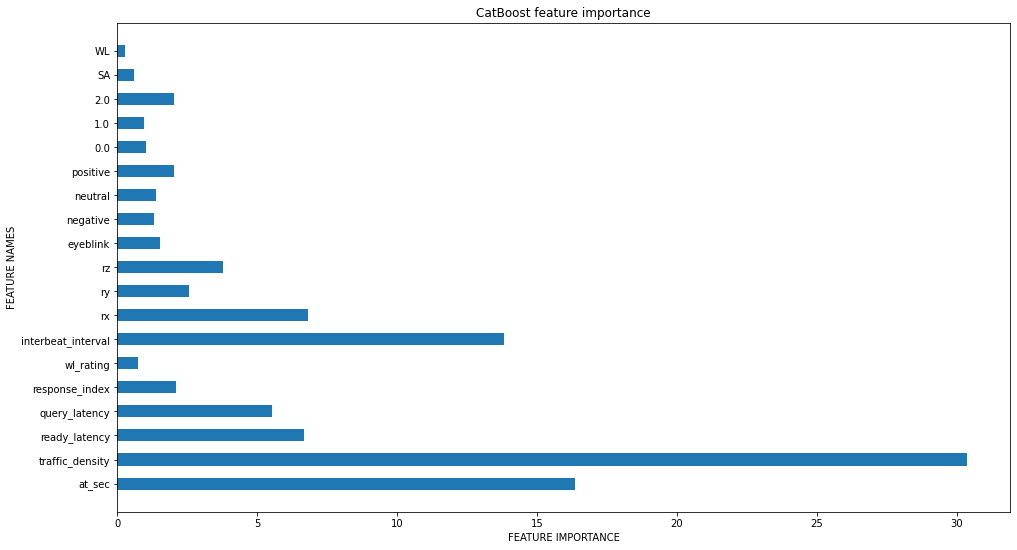

In [6]:
fea_ = model.feature_importances_

fea_name = list(X_0.columns)
fea_name = [str(j) for j in fea_name]

plt.figure(figsize=(16, 9))
plt.title('CatBoost feature importance')
plt.xlabel('FEATURE IMPORTANCE')
plt.ylabel('FEATURE NAMES')
plt.barh(fea_name,fea_,height =0.5)